# Inorganic Material Generation using Deep Q-Networks
https://github.com/eltonpan/InorganicMaterialRL

Elton Pan

In [1]:
# Env: dqn_roost as of 15/1/2022 (after addition of ROOST)
import numpy as np
import pickle5 as pickle
import torch
from torch import nn
import collections
from model import DQN_pytorch, DCN_pytorch
import time
from one_hot import featurize_target, onehot_target, element_set, comp_set, one_hot_to_element, element_to_one_hot, one_hot_to_comp, comp_to_one_hot, step_to_one_hot, one_hot_to_step
import seaborn as sns
import random
import matplotlib.pyplot as plt
import os
from env_constrained import generate_random_act, ConstrainedMaterialEnvironment, extract_data_from_ep, generate_random_ep
import collections
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm 
from sklearn.manifold import TSNE
from numpy.linalg import svd
import imageio
from pymatgen.core import Composition
from constraints.checkers import check_neutrality, check_neutrality, check_neutrality_multiple, check_electronegativity_multiple, check_both_multiple
from matminer.featurizers.base import MultipleFeaturizer
import matminer.featurizers.composition as cf
from sklearn.ensemble import RandomForestRegressor
import joblib
from roost_models.roost_model import predict_formation_energy, predict_bulk_mod, predict_shear_mod, predict_band_gap
import json
from configs import configs
os.environ["CUDA_VISIBLE_DEVICES"]="1"
print(torch.cuda.is_available())

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


True


/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


# Random policy
In env.py, we have generated some data using a random policy. Here, we visualize the distribution of final rewards, and then trained an agent using purely data generated by the random policy.

In [6]:
# Load Q_data_random
# with open('./data/Q_data_random_RF_constrained.pkl', 'rb') as f:
with open('./data/oxides_sinter/Q_data_random.pkl', 'rb') as f:
    Q_c_data_random = pickle.load(f)

print('Number of episodes generated by random policy:',len(Q_c_data_random))

def generate_dqn_dcn_inputs_and_targets_from_Q_c_data(Q_c_data):
    '''
    Generates inputs and targets for DQN training

    Args:
    Q_data: List of Q_datapoints for training
    
    Returns:
    s_material_inputs: torch.tensor of Size([num of episodes in Q_data, 145])
    s_step_inputs: torch.tensor
    a_elem_inputs: torch.tensor
    a_comp_inputs: torch.tensor
    Q_targets: torch.tensor
    en_targets: torch.tensor

    '''
    s_material_inputs = []
    s_step_inputs     = []
    a_elem_inputs     = []
    a_comp_inputs     = []
    Q_targets         = []
    en_targets         = []

    for episode in Q_c_data:
        for step in episode:
            # state, action, reward = step
            [s_material, s_step], [a_elem, a_comp], Q_target, en_target = step

            s_material = torch.tensor(s_material).float()
            s_step = torch.tensor(s_step)
            a_elem = torch.tensor(a_elem)
            a_comp = torch.tensor(a_comp)
            Q_target = torch.tensor([Q_target])
            en_target = torch.tensor([en_target])

            s_material_inputs.append(s_material)
            s_step_inputs.append(s_step)
            a_elem_inputs.append(a_elem)
            a_comp_inputs.append(a_comp)
            Q_targets.append(Q_target)
            en_targets.append(en_target)

    s_material_inputs = torch.stack(s_material_inputs)
    s_step_inputs = torch.stack(s_step_inputs)
    a_elem_inputs = torch.stack(a_elem_inputs)
    a_comp_inputs = torch.stack(a_comp_inputs)
    Q_targets = torch.stack(Q_targets)
    en_targets = torch.stack(en_targets)

    return s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets

s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets = generate_dqn_dcn_inputs_and_targets_from_Q_c_data(Q_c_data = Q_c_data_random)

print('s_material_inputs:', s_material_inputs.shape)
print('s_step_inputs:', s_step_inputs.shape)
print('a_elem_inputs:', a_elem_inputs.shape)
print('a_comp_inputs:', a_comp_inputs.shape)
print('Q_targets:', Q_targets.shape)
print('en_targets:', en_targets.shape)
print('')

Number of episodes generated by random policy: 10000
s_material_inputs: torch.Size([50000, 145])
s_step_inputs: torch.Size([50000, 5])
a_elem_inputs: torch.Size([50000, 78])
a_comp_inputs: torch.Size([50000, 10])
Q_targets: torch.Size([50000, 1])
en_targets: torch.Size([50000, 1])



/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


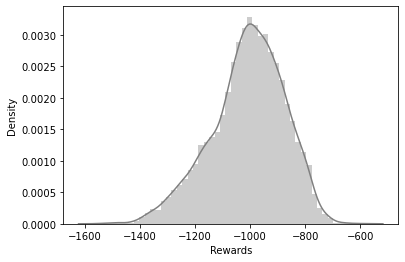

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


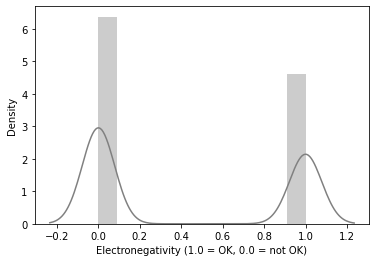

In [7]:
# Plot distribution of final rewards by random policy
plt.figure()
final_rewards_random = Q_targets[0::5].reshape(-1) # find final rewards
sns.distplot(final_rewards_random, color= 'grey')
plt.xlabel('Rewards')
plt.show()

# Plot distribution of en by random policy
plt.figure()
en_random = en_targets[0::5].reshape(-1) # find final rewards
sns.distplot(en_random, color= 'grey')
plt.xlabel('Electronegativity (1.0 = OK, 0.0 = not OK)')
plt.show()

In [8]:
# Standardizing s_material data
scaler = StandardScaler() # Fit scaler
print('before scaling:', s_material_inputs)
scaler.fit(s_material_inputs)
s_material_inputs_scaled = torch.tensor(scaler.transform(s_material_inputs)).float()
print('after scaling:', s_material_inputs_scaled)

# # Save standard scaler
# joblib.dump(scaler, 'data/oxides_sinter/std_scaler.bin', compress=True)

# Load standard scaler
scaler = joblib.load('data/oxides_sinter/std_scaler.bin')

before scaling: tensor([[4.0000, 0.5533, 0.4760,  ..., 0.0000, 0.2135, 0.0240],
        [3.0000, 0.6236, 0.5503,  ..., 0.0000, 0.2135, 0.0277],
        [2.0000, 0.7906, 0.7591,  ..., 0.0000, 0.2135, 0.0400],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
after scaling: tensor([[ 1.6798, -0.1195, -0.2381,  ..., -0.5594,  0.4237,  0.0294],
        [ 0.9239,  0.0804, -0.0255,  ..., -0.5594,  0.4237,  0.1281],
        [ 0.1680,  0.5551,  0.5722,  ..., -0.5594,  0.4237,  0.4607],
        ...,
        [-0.5879,  1.1505,  1.2615,  ...,  1.7877, -0.6532, -0.6172],
        [-1.3438, -1.6924, -1.6005,  ..., -0.5594, -0.6532, -0.6172],
        [-1.3438, -1.6924, -1.6005,  ..., -0.5594, -0.6532, -0.6172]])


In [9]:
# Train-validation split
def train_validation_split(s_material_inputs_scaled, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets, valid_size = 0.2):
    '''
    Args:
    s_material_inputs_scaled
    s_step_inputs
    a_elem_inputs
    a_comp_inputs
    Q_targets
    en_targets
    valid_size: Float (0-1). Size of validation set

    Returns:
    s_material_inputs_train 
    s_step_inputs_train     
    a_elem_inputs_train     
    a_comp_inputs_train     
    Q_targets_train   
    en_targets_train   
    s_material_inputs_valid 
    s_step_inputs_valid 
    a_elem_inputs_valid
    a_comp_inputs_valid 
    Q_targets_valid
    en_targets_valid
  
    '''
    max_idx = s_material_inputs_scaled.shape[0] # Find size of dataset
    idx = [x for x in range(max_idx)] # Generate indices
    random.shuffle(idx) # Shuffle order idx 
    split = int(round(max_idx*(1-valid_size)))
    train_idx, valid_idx = idx[:split], idx[split:] # Split indices

    s_material_inputs_train = s_material_inputs_scaled[train_idx] # Use scaled s_material
    s_step_inputs_train     = s_step_inputs[train_idx]
    a_elem_inputs_train     = a_elem_inputs[train_idx]
    a_comp_inputs_train     = a_comp_inputs[train_idx]
    Q_targets_train         = Q_targets[train_idx]
    en_targets_train         = en_targets[train_idx]

    s_material_inputs_valid = s_material_inputs_scaled[valid_idx] # Use scaled s_material
    s_step_inputs_valid     = s_step_inputs[valid_idx]
    a_elem_inputs_valid     = a_elem_inputs[valid_idx]
    a_comp_inputs_valid     = a_comp_inputs[valid_idx]
    Q_targets_valid         = Q_targets[valid_idx]
    en_targets_valid         = en_targets[valid_idx]

    return s_material_inputs_train, s_step_inputs_train, a_elem_inputs_train, a_comp_inputs_train, Q_targets_train, en_targets_train,s_material_inputs_valid, s_step_inputs_valid, a_elem_inputs_valid, a_comp_inputs_valid, Q_targets_valid, en_targets_valid

s_material_inputs_train, s_step_inputs_train, a_elem_inputs_train, a_comp_inputs_train, Q_targets_train, en_targets_train, s_material_inputs_valid, s_step_inputs_valid, a_elem_inputs_valid, a_comp_inputs_valid, Q_targets_valid, en_targets_valid \
= train_validation_split(s_material_inputs_scaled = s_material_inputs_scaled.to('cuda'), 
                                    s_step_inputs = s_step_inputs.to('cuda'), 
                                    a_elem_inputs = a_elem_inputs.to('cuda'),
                                    a_comp_inputs = a_comp_inputs.to('cuda'),
                                    Q_targets  = Q_targets.to('cuda'),
                                    en_targets = en_targets.to('cuda'),
                                    valid_size = 0.2)

print('TRAIN SIZES:')
print('s_material_inputs_train:', s_material_inputs_train.shape)
print('s_step_inputs_train:', s_step_inputs_train.shape)
print('a_elem_inputs_train:', a_elem_inputs_train.shape)
print('a_comp_inputs_train:', a_comp_inputs_train.shape)
print('Q_targets_train:', Q_targets_train.shape)
print('en_targets_train:', en_targets_train.shape)
print('')
print('VALIDATION SIZES:')
print('s_material_inputs_valid:', s_material_inputs_valid.shape)
print('s_step_inputs_valid:', s_step_inputs_valid.shape)
print('a_elem_inputs_valid:', a_elem_inputs_valid.shape)
print('a_comp_inputs_valid:', a_comp_inputs_valid.shape)
print('Q_targets_valid:', Q_targets_valid.shape)
print('en_targets_valid:', en_targets_valid.shape)

TRAIN SIZES:
s_material_inputs_train: torch.Size([40000, 145])
s_step_inputs_train: torch.Size([40000, 5])
a_elem_inputs_train: torch.Size([40000, 78])
a_comp_inputs_train: torch.Size([40000, 10])
Q_targets_train: torch.Size([40000, 1])
en_targets_train: torch.Size([40000, 1])

VALIDATION SIZES:
s_material_inputs_valid: torch.Size([10000, 145])
s_step_inputs_valid: torch.Size([10000, 5])
a_elem_inputs_valid: torch.Size([10000, 78])
a_comp_inputs_valid: torch.Size([10000, 10])
Q_targets_valid: torch.Size([10000, 1])
en_targets_valid: torch.Size([10000, 1])


Here we train DQN using ONLY data generated by random policy.

# DQN

In [6]:
# Initialize Q network
dqn = DQN_pytorch().cuda()
print('CUDA for model: ', next(dqn.parameters()).is_cuda)

def train_DQN(dqn, num_epoch, s_material_inputs_train, s_step_inputs_train, a_elem_inputs_train, a_comp_inputs_train, Q_targets_train ,s_material_inputs_valid ,s_step_inputs_valid ,a_elem_inputs_valid ,a_comp_inputs_valid ,Q_targets_valid):
    '''
    Trains DQN and prints: 1. training loss 2. validation loss

    Args:
    dqn: DQN
    num_epoch: Int. Number of training epochs 
    s_material_inputs_train
    s_step_inputs_train
    a_elem_inputs_train
    a_comp_inputs_train
    Q_targets_train
    s_material_inputs_valid
    s_step_inputs_valid
    a_elem_inputs_valid
    a_comp_inputs_valid
    Q_targets_valid

    Returns:
    Updated dqn
    train_loss_list
    valid_loss_list
    '''
    train_loss_list = []
    valid_loss_list = []

    # Train Q network
    optimizer = torch.optim.Adam(dqn.parameters(), lr=1e-2)
    loss_func = torch.nn.SmoothL1Loss().float()

    # start = time.time()

    for epoch in range(num_epoch):
        # Train loss
        prediction_train = dqn(s_material = s_material_inputs_train, # torch.Size([batch_size, 145]) and must be .float() !!!
                        s_step      = s_step_inputs_train,     # torch.Size([batch_size,5])
                        a_elem      = a_elem_inputs_train,     # torch.Size([batch_size,80])
                        a_comp      = a_comp_inputs_train,  # torch.Size([batch_size,10])
                        )                    # Input x and predict based on x
        train_loss       = loss_func(prediction_train.float(), Q_targets_train.float()).float()   # Must be (1. nn output, 2. target)
        optimizer.zero_grad()   # Clear gradients for next train
        train_loss.backward()         # Backpropagation, compute gradients
        optimizer.step()        # Apply gradients

        # Validation loss
        prediction_valid = dqn(s_material = s_material_inputs_valid, # torch.Size([batch_size, 145]) and must be .float() !!!
                        s_step      = s_step_inputs_valid,     # torch.Size([batch_size,5])
                        a_elem      = a_elem_inputs_valid,     # torch.Size([batch_size,80])
                        a_comp      = a_comp_inputs_valid,  # torch.Size([batch_size,10]))
                        )
        valid_loss = loss_func(prediction_valid.float(), Q_targets_valid.float()).float()   # Must be (1. nn output, 2. target)
        train_loss_list.append(train_loss.cpu().detach().numpy())
        valid_loss_list.append(valid_loss.cpu().detach().numpy())

        print('Epoch = ', epoch, 'Train_loss = %.4f' % train_loss.cpu().data.numpy(), 'Valid_loss = %.4f' % valid_loss.cpu().data.numpy())
    # end = time.time()
    # print('time taken for batch:', end - start)
    
    return dqn, train_loss_list, valid_loss_list
dqn, train_loss_list, valid_loss_list = train_DQN(dqn =  dqn, num_epoch = 100, s_material_inputs_train = s_material_inputs_train, s_step_inputs_train = s_step_inputs_train,
 a_elem_inputs_train = a_elem_inputs_train, a_comp_inputs_train = a_comp_inputs_train, Q_targets_train = Q_targets_train,
 s_material_inputs_valid = s_material_inputs_valid, s_step_inputs_valid = s_step_inputs_valid, a_elem_inputs_valid = a_elem_inputs_valid,
 a_comp_inputs_valid = a_comp_inputs_valid, Q_targets_valid = Q_targets_valid)

CUDA for model:  True
Epoch =  0 Train_loss = 825.8224 Valid_loss = 825.1849
Epoch =  1 Train_loss = 824.7580 Valid_loss = 823.3150
Epoch =  2 Train_loss = 822.8787 Valid_loss = 820.1368
Epoch =  3 Train_loss = 819.6823 Valid_loss = 815.3101
Epoch =  4 Train_loss = 814.8267 Valid_loss = 808.4542
Epoch =  5 Train_loss = 807.9287 Valid_loss = 799.1511
Epoch =  6 Train_loss = 798.5674 Valid_loss = 786.9410
Epoch =  7 Train_loss = 786.2802 Valid_loss = 771.3217
Epoch =  8 Train_loss = 770.5617 Valid_loss = 751.7380
Epoch =  9 Train_loss = 750.8533 Valid_loss = 727.5927
Epoch =  10 Train_loss = 726.5546 Valid_loss = 698.2238
Epoch =  11 Train_loss = 697.0003 Valid_loss = 662.9277
Epoch =  12 Train_loss = 661.4824 Valid_loss = 620.9318
Epoch =  13 Train_loss = 619.2230 Valid_loss = 571.3926
Epoch =  14 Train_loss = 569.3738 Valid_loss = 513.4457
Epoch =  15 Train_loss = 511.0485 Valid_loss = 447.6274
Epoch =  16 Train_loss = 444.7703 Valid_loss = 386.1784
Epoch =  17 Train_loss = 383.9272 Va

# DCN

In [7]:
# Initialize constraint network
dcn = DCN_pytorch().cuda()

def train_DCN(dcn, num_epoch, s_material_inputs_train, s_step_inputs_train, a_elem_inputs_train, a_comp_inputs_train, Q_targets_train, en_targets_train, s_material_inputs_valid ,s_step_inputs_valid ,a_elem_inputs_valid ,a_comp_inputs_valid , Q_targets_valid, en_targets_valid):
    '''
    Trains DCN and prints: 1. training loss 2. validation loss

    Args:
    dcn: DCN
    num_epoch: Int. Number of training epochs 
    s_material_inputs_train
    s_step_inputs_train
    a_elem_inputs_train
    a_comp_inputs_train
    Q_targets_train
    en_targets_train
    s_material_inputs_valid
    s_step_inputs_valid
    a_elem_inputs_valid
    a_comp_inputs_valid
    Q_targets_valid
    en_targets_valid

    Returns:
    Updated dcn
    train_loss_list
    valid_loss_list
    '''
    train_loss_list = []
    valid_loss_list = []

    # Train Q network
    optimizer = torch.optim.Adam(dcn.parameters(), lr=1e-2)
    # loss_func = torch.nn.SmoothL1Loss().float()
    loss_func = torch.nn.MSELoss().float() # Works better than L1Loss
    # loss_func = torch.nn.L1Loss().float() # Trained model gives pred close to 0

    # start = time.time()

    for epoch in range(num_epoch):
        # Train loss
        prediction_train = dcn(s_material = s_material_inputs_train, # torch.Size([batch_size, 145]) and must be .float() !!!
                        s_step      = s_step_inputs_train,     # torch.Size([batch_size,5])
                        a_elem      = a_elem_inputs_train,     # torch.Size([batch_size,80])
                        a_comp      = a_comp_inputs_train,  # torch.Size([batch_size,10])
                        )                    # Input x and predict based on x
        train_loss       = loss_func(prediction_train.float(), en_targets_train.float()).float()   # Must be (1. nn output, 2. target)
        optimizer.zero_grad()   # Clear gradients for next train
        train_loss.backward()         # Backpropagation, compute gradients
        optimizer.step()        # Apply gradients

        # Validation loss
        prediction_valid = dcn(s_material = s_material_inputs_valid, # torch.Size([batch_size, 145]) and must be .float() !!!
                        s_step      = s_step_inputs_valid,     # torch.Size([batch_size,5])
                        a_elem      = a_elem_inputs_valid,     # torch.Size([batch_size,80])
                        a_comp      = a_comp_inputs_valid,  # torch.Size([batch_size,10]))
                        )
        valid_loss = loss_func(prediction_valid.float(), en_targets_valid.float()).float()   # Must be (1. nn output, 2. target)
        train_loss_list.append(train_loss.cpu().detach().numpy())
        valid_loss_list.append(valid_loss.cpu().detach().numpy())

        print('Epoch = ', epoch, 'Train_loss = %.4f' % train_loss.data.cpu().numpy(), 'Valid_loss = %.4f' % valid_loss.data.cpu().numpy())
    # end = time.time()
    # print('time taken for batch:', end - start)
    
    return dcn, train_loss_list, valid_loss_list
dcn, train_loss_list, valid_loss_list = train_DCN(dcn =  dcn, num_epoch = 100, s_material_inputs_train = s_material_inputs_train, s_step_inputs_train = s_step_inputs_train,
 a_elem_inputs_train = a_elem_inputs_train, a_comp_inputs_train = a_comp_inputs_train, Q_targets_train = Q_targets_train, en_targets_train = en_targets_train,
 s_material_inputs_valid = s_material_inputs_valid, s_step_inputs_valid = s_step_inputs_valid, a_elem_inputs_valid = a_elem_inputs_valid,
 a_comp_inputs_valid = a_comp_inputs_valid, Q_targets_valid = Q_targets_valid, en_targets_valid = en_targets_valid)

Epoch =  0 Train_loss = 0.2531 Valid_loss = 0.2483
Epoch =  1 Train_loss = 0.2507 Valid_loss = 0.2374
Epoch =  2 Train_loss = 0.2389 Valid_loss = 0.2359
Epoch =  3 Train_loss = 0.2371 Valid_loss = 0.2327
Epoch =  4 Train_loss = 0.2343 Valid_loss = 0.2310
Epoch =  5 Train_loss = 0.2326 Valid_loss = 0.2306
Epoch =  6 Train_loss = 0.2317 Valid_loss = 0.2296
Epoch =  7 Train_loss = 0.2303 Valid_loss = 0.2280
Epoch =  8 Train_loss = 0.2285 Valid_loss = 0.2271
Epoch =  9 Train_loss = 0.2276 Valid_loss = 0.2263
Epoch =  10 Train_loss = 0.2267 Valid_loss = 0.2252
Epoch =  11 Train_loss = 0.2254 Valid_loss = 0.2242
Epoch =  12 Train_loss = 0.2241 Valid_loss = 0.2231
Epoch =  13 Train_loss = 0.2229 Valid_loss = 0.2216
Epoch =  14 Train_loss = 0.2213 Valid_loss = 0.2200
Epoch =  15 Train_loss = 0.2195 Valid_loss = 0.2186
Epoch =  16 Train_loss = 0.2181 Valid_loss = 0.2169
Epoch =  17 Train_loss = 0.2169 Valid_loss = 0.2159
Epoch =  18 Train_loss = 0.2160 Valid_loss = 0.2151
Epoch =  19 Train_loss

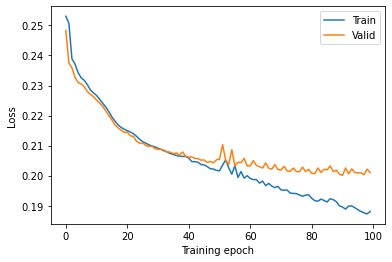

In [8]:
# Plot train and valid losses
plt.figure()
plt.plot(range(0,len(train_loss_list)), train_loss_list, label = 'Train')
plt.plot(range(0,len(valid_loss_list)), valid_loss_list, label = 'Valid')
plt.legend()
# plt.ylim(130,170)
plt.xlabel('Training epoch')
plt.ylabel('Loss')
# plt.savefig('plots/train_valid_loss.png', dpi = 300)
plt.show()

In [11]:
def ranked_max_actions(state, dqn, n_actions = len(element_set)*len(comp_set), oxide = False):
    """
    Returns a list of ranked actions based on Q-network prodictions

    Args:
    state: List [s_material, s_step] where s_material is the string representation of material and s_step is the integer step number
    dqn: Q-network for Q-value prediction
    oxide: Choose oxygen only 

    Returns:
    ranked_max_actions: List [[s_material, s_step, Q-value]
                              ...
                              [s_material, s_step, Q-value]
                              ]
    where s_material is the one-hot torch.tensor.float() of material and
    s_step is the  one-hot torch.tensor.float()
    0th index corresponds to highest Q-value
    """

    s_material, s_step = state
    # s_material = torch.tensor(onehot_target(s_material)).float() # Get one-hot rep of s_material
    s_material = torch.tensor(featurize_target(s_material)).reshape(1, -1) # Get one-hot rep of s_material
    s_material = torch.tensor(scaler.transform(s_material)).reshape(-1).float()  # Standardize s_material
    s_step = torch.tensor(step_to_one_hot([s_step])[0]).float() # Get one-hot rep of s_step

    if oxide: # If oxygen only, we only need smaller action space
        n_actions = len(comp_set) - 1 # since adding 0 oxygen is NOT an option
    s_material_input = torch.stack([s_material]*n_actions).to('cuda')
    s_step_input = torch.stack([s_step]*n_actions).to('cuda')

    a_elem_input = []
    a_comp_input = []

    if oxide: # Consider oxygen only
        a_elem = torch.tensor(element_to_one_hot(['O'])[0]).float()
        # for comp in comp_set:
        for comp in comp_set[1:]: # consider only non-zero compositions for adding oxygen
            a_comp = torch.tensor(comp_to_one_hot([comp])[0]).float()

            a_elem_input.append(a_elem)
            a_comp_input.append(a_comp)

    else:
        for elem in element_set:
            a_elem = torch.tensor(element_to_one_hot([elem])[0]).float()
            for comp in comp_set:
                a_comp = torch.tensor(comp_to_one_hot([comp])[0]).float()

                a_elem_input.append(a_elem)
                a_comp_input.append(a_comp)
    
    a_elem_input = torch.stack(a_elem_input).float().to('cuda')
    a_comp_input = torch.stack(a_comp_input).float().to('cuda')

    
    Q_pred = dqn(s_material = s_material_input, # torch.Size([batch_size, 40, 115]) and must be .float() !!!
                    s_step      = s_step_input,     # torch.Size([batch_size,5])
                    a_elem      = a_elem_input,     # torch.Size([batch_size,80])
                    a_comp      = a_comp_input,  # torch.Size([batch_size,10])

                )   
    # Rank according to Q-values
    Q_pred = Q_pred.cpu().detach().numpy()
    Q_pred = Q_pred.reshape(n_actions)
    order = Q_pred.argsort()
    ranks = order.argsort() # ranks of Q-values, 0th index = lowest Q, last index = highest Q
    
    
    a_elem_input_ranked = torch.zeros([n_actions, len(element_set)])
    a_comp_input_ranked = torch.zeros([n_actions, len(comp_set)])
    Q_pred_ranked = np.zeros(n_actions)

    for rank in reversed(range(n_actions)): # Start with most valuable
        rank_idx = ranks[rank] # rank_idx = final position
        rank_idx = (n_actions - 1) - rank_idx # Reverse rank_idx i.e. Want 0th index to correspond to max Q

        # Sort Q-values
        Q = Q_pred[rank]
        Q_pred_ranked[rank_idx] = Q

        # Sort a_elem according to Q-values
        a_elem = a_elem_input[rank]
        a_elem_input_ranked[rank_idx] = a_elem

        # Sort a_comp according to Q-values
        a_comp = a_comp_input[rank]
        a_comp_input_ranked[rank_idx] = a_comp

    # print('Max Q: ', max(Q_pred_ranked))
    # print('Min Q: ', min(Q_pred_ranked))

    return a_elem_input_ranked, a_comp_input_ranked, Q_pred_ranked

mat_1 = 'BaTiO3'
mat_2 = 'SrTiO3'

print('Material: {}'.format(mat_1))
a_elem_input_ranked, a_comp_input_ranked, Q_pred_ranked = ranked_max_actions([mat_1, 1], dqn = dqn, oxide = True)
print('Q value of max action: ', Q_pred_ranked[0])
print(len(Q_pred_ranked))
# print('max_a_elem: ', tuple(a_elem_input_ranked[0].tolist()))
# print('max_a_comp: ', tuple(a_comp_input_ranked[0].tolist()))
# print('')
print('')

print('Material: {}'.format(mat_2))
a_elem_input_ranked, a_comp_input_ranked, Q_pred_ranked = ranked_max_actions([mat_2, 1], dqn = dqn, oxide = True)
print('Q value of max action: ', Q_pred_ranked[0])
# print('max_a_elem: ', tuple(a_elem_input_ranked[0].tolist()))
# print('max_a_comp: ', tuple(a_comp_input_ranked[0].tolist()))

Material: BaTiO3
Q value of max action:  -631.898193359375
9

Material: SrTiO3
Q value of max action:  -666.8060302734375


In [12]:
# Investigate weights of dqn
# dqn.fc1.weight.mean(), dqn.fc2.weight.mean(), dqn.fc3.weight.mean(), dqn.fc4.weight.mean(),
dcn.fc1.weight.mean(), dcn.fc2.weight.mean(), dcn.fc3.weight.mean(), dcn.fc4.weight.mean(),

(tensor(-0.0071, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(-0.0300, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(-0.0047, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(-0.0183, device='cuda:0', grad_fn=<MeanBackward0>))

In [13]:
# For testing the DCN function
# s_material = torch.tensor(onehot_target('BaTiO3'))
s_material = torch.tensor(scaler.transform(torch.tensor(featurize_target('BaTiO3')).reshape(1,-1))).float().to('cuda')
# s_material = s_material.reshape(1, s_material.shape[0])
# print(s_material.shape)

s_step = torch.zeros(5)
s_step[3] = 1.
s_step = s_step.reshape(1, s_step.shape[0]).to('cuda')
# print(s_step.shape)

a_elem = torch.zeros(78)
a_elem[2] = 1.
a_elem = a_elem.reshape(1, a_elem.shape[0]).to('cuda')
# print(a_elem.shape)

a_comp = torch.zeros(10)
a_comp[1] = 1.
a_comp = a_comp.reshape(1, a_comp.shape[0]).to('cuda')
# print(a_comp.shape)

output = dcn(s_material, s_step, a_elem, a_comp)

print(output)
# print(output.shape)

tensor([[0.8716]], device='cuda:0', grad_fn=<SigmoidBackward>)


In [14]:
env = ConstrainedMaterialEnvironment(element_set = element_set,
                          comp_set =  comp_set,)

def generate_max_act(state, dqn, stochastic_top_frac = 0, oxide = False):
    '''
    Generates max action.
    Args:
    state: state
    dqn: Q-network
    stochastic_top_frac: Int (0-1). action choosen from the top n fraction of ranked actions. Default = 0. 
                         e.g. stochastic_top_frac = 0.1 corresponds to choosing from top 10% of action

    Returns: max_a_elem, max_a_comp
    '''
    a_elem_input_ranked, a_comp_input_ranked, _ = ranked_max_actions(state = state, dqn = dqn, n_actions = len(element_set)*len(comp_set),
                                                                    oxide = oxide)
    
    tot_num_actions = len(a_elem_input_ranked)
    if stochastic_top_frac != 0: # if stochastic
        act_idx = stochastic_top_frac*tot_num_actions # cut-off index
        rank = np.random.randint(0,round(act_idx)) # take top stochastic_top_frac fraction of ranked actions
    else: # deterministic
        rank = 0 # take top action (index 0)
    max_a_elem = a_elem_input_ranked[rank] # 0th index corresponds to max
    max_a_comp = a_comp_input_ranked[rank] # 0th index corresponds to max
    max_a_elem = tuple(max_a_elem.tolist())
    max_a_comp = tuple(max_a_comp.tolist())
    action = [max_a_elem, max_a_comp]

    return action

def generate_constrained_max_act(state, dqn, dcn, en_threshold, stochastic_top_frac = 0, oxide = False):
    '''
    Generates max action.
    Args:
    state: state
    dqn: Q-network
    en_threshold: Float (0.0 - 1.0). Determines how tight the constraint is. 1.0 being the tightest. 
    stochastic_top_frac: Int (0-1). action choosen from the top n fraction of ranked actions. Default = 0. 
                         e.g. stochastic_top_frac = 0.1 corresponds to choosing from top 10% of action

    Returns: max_a_elem, max_a_comp
    '''
    a_elem_input_ranked, a_comp_input_ranked, _ = ranked_max_actions(state = state, dqn = dqn, n_actions = len(element_set)*len(comp_set),
                                                                    oxide = oxide)
    
    tot_num_actions = len(a_elem_input_ranked)
    en = 0

    count = 0
    while en <= en_threshold: # Keep iterating until predicted en goes above 0.5
        if stochastic_top_frac != 0: # if stochastic
            act_idx = stochastic_top_frac*tot_num_actions # cut-off index
            rank = np.random.randint(0,round(act_idx)) # take top stochastic_top_frac fraction of ranked actions
        else: # deterministic
            rank = 0 # take top action (index 0)
        max_a_elem = a_elem_input_ranked[rank] # 0th index corresponds to max
        max_a_comp = a_comp_input_ranked[rank] # 0th index corresponds to max

        # print('state:', state)
        s_material, s_step = state # need to featurize/encode s_material and s_step
        # s_material = torch.tensor(onehot_target(s_material)).float() # Get one-hot rep of s_material
        s_material = torch.tensor(featurize_target(s_material)).reshape(1, -1) # Get one-hot rep of s_material
        s_material_inputs = torch.tensor(scaler.transform(s_material)).float().to('cuda')  # Standardize s_material
        s_step_inputs = torch.tensor(step_to_one_hot([s_step])[0]).reshape(1, -1).float().to('cuda') # Get one-hot rep of s_step
        max_a_elem = max_a_elem.reshape(1, -1).to('cuda')
        max_a_comp = max_a_comp.reshape(1, -1).to('cuda')
        # print('state:', state)
        # print('s_material_inputs:', s_material_inputs)
        # print('s_step_inputs:', s_step_inputs)
        # print('max_a_elem:', max_a_elem)
        # print('max_a_comp:', max_a_comp)
        en = dcn(s_material = s_material_inputs, # torch.Size([batch_size, 145]) and must be .float() !!!
                        s_step      = s_step_inputs,     # torch.Size([batch_size,5])
                        a_elem      = max_a_elem,     # torch.Size([batch_size,80])
                        a_comp      = max_a_comp,  # torch.Size([batch_size,10])
                        )  # Update en with prediction using DCN
        # print('en pred:', en[0])
        count += 1
        if count >= 100: # Tried more than 100 times
            print('Could not satisfy en constraint after %.0f actions' % count)
            break
    max_a_elem = max_a_elem[0]
    max_a_comp = max_a_comp[0]
    max_a_elem = tuple(max_a_elem.tolist())
    max_a_comp = tuple(max_a_comp.tolist())
    action = [max_a_elem, max_a_comp]

    return action

def generate_ep_with_dqn_dcn(dqn, dcn, en_threshold, max_steps = 5, epsilon = 0, stochastic_top_frac = 0, oxide = False):
    '''
    Generates an episode with trained DQN
    
    Args:
    dqn: Q-network for Q-value prediction
    dcn: Constraint-network for constraint value prediction
    en_threshold: Float (0.0 - 1.0). Determines how tight the constraint is. 1.0 being the tightest.
    max_steps: Int
    epsilon: Float. Probability of taking random action 
    stochastic_top_frac: Int (0-1). action choosen from the top n fraction of ranked actions. Default = 0. 
                         e.g. stochastic_top_frac = 0.1 corresponds to choosing from top 10% of action

    Returns: 
    env.path (an episode): List of SAR data in the form of [[material, step], [element, composition], reward]
    final_compound: Str.
    
    '''
    env.initialize()

    for i in range(max_steps):

        if np.random.uniform(0,1) > epsilon:
            if i == max_steps-1: # If last step, choose oxygen only
                action = generate_constrained_max_act(state = [env.state, env.counter+1], dqn = dqn, dcn = dcn, en_threshold = en_threshold, stochastic_top_frac = stochastic_top_frac,
                                                oxide = oxide)
                # action = generate_random_act(oxide = oxide)
            else:
                action = generate_constrained_max_act(state = [env.state, env.counter+1], dqn = dqn, dcn = dcn, en_threshold = en_threshold, stochastic_top_frac = stochastic_top_frac,
                                                oxide = False)
        else:
            if i == max_steps-1: # If last step, choose oxygen only
                action = generate_random_act(oxide = oxide)
            else:
                action = generate_random_act(oxide = False)
        # print(action)
        # Take step with action
        env.step(action)
        final_compound = env.state
        # print('step:', env.counter)
        # print('state:',final_compound)
        # print('reward:',env.reward())
        # print(env.num_steps_taken)
        # print('')
    return env.path, final_compound
ep, final_compound = generate_ep_with_dqn_dcn(dqn = dqn, dcn = dcn, stochastic_top_frac = 0.15, en_threshold = 0., 
                                                oxide = True)

# compounds = []
# for i in tqdm(range(100)):
#     _, final_compound = generate_ep_with_dqn_dcn(dqn = dqn, dcn = dcn, en_threshold = 0.0, stochastic_top_frac = 0.20)
#     compounds.append(final_compound)

# print(final_compound)
# print(check_electronegativity(final_compound))
# len(compounds)
final_compound

'Se9Cd7Pb9F7O8'

In [15]:
# ========= FOR TRAINED POLICY ===========
def generate_Q_c_datapoints_and_evaluate_policy(dqn, dcn, num_eps, epsilon, en_threshold = 0.4, stochastic_top_frac = 0.20, oxide = False):
    '''
    Generates 1) Q datapoints for training 2) List of final rewards using a DQN.

    Args:
    dqn: Q-netowrk
    num_eps: Int. Number of episodes to run.
    epsilon: Float. Probability of taking a random action
    en_threshold: Float (0.0 - 1.0). Determines how tight the constraint is. 1.0 being the tightest. Default 0.4
    stochastic_top_frac: Int (0-1). action choosen from the top n fraction of ranked actions. Default = 0. 
                         e.g. stochastic_top_frac = 0.1 corresponds to choosing from top 10% of action

    Returns:
    Q_c_data_trained: List of Q datapoints for training
    en_targets_trained: List of en datapoints for training
    final_rewards_trained: List of corresponding final rewards
    final_compounds: List (of Str) of final compounds
    '''
    # start = time.time()

    # Generate episodes with DQN
    episodes = []
    final_compounds = []
    for j in range(num_eps):
        episode, final_compound = generate_ep_with_dqn_dcn(dqn = dqn, dcn = dcn, epsilon = epsilon, en_threshold = en_threshold, stochastic_top_frac = stochastic_top_frac,
                                                        oxide = oxide)
        episodes.append(episode)
        final_compounds.append(final_compound)

    Q_c_data_trained = []
    # Extract Q_data from episodes
    for episode in episodes:
        Q_c_data = extract_data_from_ep(episode)
        Q_c_data_trained.append(Q_c_data)

    # end = time.time()
    # print('time taken:', end - start)

    # Save Q_data
    # with open('./data/Q_data_trained_RF.pkl', 'wb') as f:
    #     pickle.dump(Q_data_trained, f, pickle.HIGHEST_PROTOCOL)

    # # Load Q_data_random
    # with open('./data/Q_data_trained_RF.pkl', 'rb') as f:
    #     Q_data_trained = pickle.load(f)

    # print('Number of episodes generated by agent trained on random policy data:', len(Q_data_trained))

    # Extract final rewards from episode data
    Q_targets_trained         = []
    en_targets_trained         = []

    for episode in Q_c_data_trained:
        for step in episode:
            # state, action, reward = step
            _, _, Q_target, en_target = step
            Q_target = torch.tensor([Q_target])
            Q_targets_trained.append(Q_target)
            en_target = torch.tensor([en_target])
            en_targets_trained.append(en_target)

    Q_targets_trained = torch.stack(Q_targets_trained)
    en_targets_trained = torch.stack(en_targets_trained)
    # print('Q_targets:', Q_targets_trained.shape)
    final_rewards_trained = Q_targets_trained[0::5].reshape(-1) # Find final rewards, index of 5 since length of each episode is 5
    final_en_trained = en_targets_trained[0::5].reshape(-1)

    return Q_c_data_trained, en_targets_trained, final_rewards_trained, final_compounds

# Q_c_data_trained, en_targets_trained, final_rewards_trained, final_compounds = \
# generate_Q_c_datapoints_and_evaluate_policy(dqn = dqn, dcn = dcn, num_eps = 50, epsilon = 0, en_threshold = 0.4, 
#                                         stochastic_top_frac = 0.15,
#                                         oxide = True)
# print(len(Q_c_data_trained))
# print(len(en_targets_trained))
# print(len(final_rewards_trained))
# print(final_compounds)

In [14]:
# count = 0
# for target in en_targets_trained[::5]:
#     if target[0] == 1.:
#         count += 1
# print(count)

As shown in the plot below, an agent trained based on just data generated by a random policy can improve the distribution of rewards.

In [15]:
# # Plot distribution of final rewards by random vs trained policy
# plt.figure(figsize=(10,7))
# sns.distplot(final_rewards_random, hist = True, norm_hist = True, label = 'Random')
# sns.distplot(final_rewards_trained, hist = True, norm_hist = True, label = 'Trained')
# plt.ylabel('Probability density')
# plt.xlabel('Reward')
# # plt.ylim(0,0.0025)
# plt.xlim(-2000,0)
# plt.legend()
# # plt.savefig(fname = 'plots/reward_dist.png', dpi = 300)
# plt.show()

In [16]:
# # Plot distribution of en by random policy
# sns.distplot(en_targets_trained, color= 'grey')
# plt.xlabel('Electronegativity (1.0 = OK, 0.0 = not OK)')
# plt.show()

# Deep Reinforcement Learning
We now close the RL loop by training the agent on data generated by increasingly greedy policies. 

In [17]:
# replay_buffer = collections.deque(maxlen = 50000)
# Q_c_data_trained, en_targets_trained, final_rewards_trained, final_compounds = generate_Q_c_datapoints_and_evaluate_policy(dqn = dqn, 
#                                                                                                                            dcn = dcn,
#                                                                                                     num_eps = 100, 
#                                                                                                     epsilon = 0, 
#                                                                                                     en_threshold = 0.4,
#                                                                                                     stochastic_top_frac = 0.2)
# s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets = generate_dqn_dcn_inputs_and_targets_from_Q_c_data(Q_c_data = Q_c_data_trained)

def update_replay_buffer(replay_buffer, s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets):
    '''
    Adds inputs into replay buffer
    Args:
    replay_buffer: collections.deque
    
    Returns: 
    updated replay buffer
    
    '''
    for s_material, s_step, a_elem, a_comp, Q_target, en_target in zip(s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets):
        Q_c_datapoint = [s_material, s_step, a_elem, a_comp, Q_target, en_target]
        replay_buffer.extend([Q_c_datapoint])
    
    return replay_buffer

# replay_buffer = update_replay_buffer(replay_buffer = replay_buffer, s_material_inputs = s_material_inputs, 
#                                                             s_step_inputs = s_step_inputs, 
#                                                             a_elem_inputs = a_elem_inputs, 
#                                                             a_comp_inputs = a_comp_inputs, 
#                                                                 Q_targets = Q_targets,
#                                                                 en_targets = en_targets)
# print('Number of Q datapoints in replay buffer (5 per episode):', len(replay_buffer))

In [18]:
def sample_replay_buffer(replay_buffer, n = 100):
    '''
    Samples datapoints from replay buffer for DQN training

    Args:
    replay_buffer: collections.deque
    n: Int. Number of datapoints to sample

    Returns:
    s_material_inputs: torch.tensor of Size([num of episodes in Q_data, 145])
    s_step_inputs: torch.tensor
    a_elem_inputs: torch.tensor
    a_comp_inputs: torch.tensor
    Q_targets: torch.tensor
    em_targets: torch.tensor

    '''

    s_material_inputs = []
    s_step_inputs     = []
    a_elem_inputs     = []
    a_comp_inputs     = []
    Q_targets         = []
    en_targets         = []

    for Q_c_datapoint in random.sample(replay_buffer, n):
        s_material, s_step, a_elem, a_comp, Q_target, en_target = Q_c_datapoint

        s_material = torch.tensor(s_material).float()
        s_step = torch.tensor(s_step)
        a_elem = torch.tensor(a_elem)
        a_comp = torch.tensor(a_comp)
        Q_target = torch.tensor([Q_target])
        en_target = torch.tensor([en_target])

        s_material_inputs.append(s_material)
        s_step_inputs.append(s_step)
        a_elem_inputs.append(a_elem)
        a_comp_inputs.append(a_comp)
        Q_targets.append(Q_target)
        en_targets.append(en_target)

    s_material_inputs = torch.stack(s_material_inputs).to('cuda')
    s_step_inputs = torch.stack(s_step_inputs).to('cuda')
    a_elem_inputs = torch.stack(a_elem_inputs).to('cuda')
    a_comp_inputs = torch.stack(a_comp_inputs).to('cuda')
    Q_targets = torch.stack(Q_targets).to('cuda')
    en_targets = torch.stack(en_targets).to('cuda')

    return s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets

# s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets = sample_replay_buffer(replay_buffer = replay_buffer, n = 100)

# print('s_material_inputs:', s_material_inputs.shape)
# print('s_step_inputs:', s_step_inputs.shape)
# print('a_elem_inputs:', a_elem_inputs.shape)
# print('a_comp_inputs:', a_comp_inputs.shape)
# print('Q_targets:', Q_targets.shape)
# print('en_targets:', en_targets.shape)
    

### Training the DQN

In [95]:
# num_iter = 500 # No. of training iterations
# epsilon  = 0.99   # Initial epsilon

# en_threshold =  0 # Because we don't want to train DCN online
# # en_threshold_ub = 0.5 # upper bound for en_threshold
# # iteration = np.arange(num_iter)
# # en_threshold_vs_iter = -en_threshold_ub*(np.e**(-iteration/(num_iter*0.3))) + en_threshold_ub

# replay_buffer = collections.deque(maxlen = 50000) # Initialize replay buffer
# dqn_save_freq = 10 # Save DQN model every n iterations
# dqn = DQN_pytorch().cuda() # Initialize DQN
# # dcn = DCN_pytorch().cuda() # Initialize DCN
# env = ConstrainedMaterialEnvironment(element_set = element_set, comp_set = comp_set,) # Initialize env

# # Meta-data to store
# final_rewards_vs_iter   = []
# en_vs_iter              = []
# compounds_vs_iter       = []
# train_loss_list_vs_iter = []
# valid_loss_list_vs_iter = []
# epsilon_vs_iter         = []

# for iteration in tqdm(range(num_iter)):
#     print('=========== TRAINING ITERATION %.0f ===========' % iteration)
# #     en_threshold = en_threshold_vs_iter[iteration]
#     print('Current epsilon = ', epsilon)
#     print('Current en threshold = ', en_threshold)
#     epsilon_vs_iter.append(epsilon)
#     # 1. GENERATE Q DATAPOINTS & ADD TO REPLAY BUFFER
#     print('A) GENERATING DATAPOINTS')
#     Q_c_data_trained, en_targets_trained, final_rewards_trained, final_compounds = \
#         generate_Q_c_datapoints_and_evaluate_policy(dqn = dqn, dcn = dcn, num_eps = 100, epsilon = epsilon, en_threshold = en_threshold,
#                                                                                                     stochastic_top_frac = 0.15,
#                                                                                                     oxide = True) # Generate episodes and score them
#     final_rewards_vs_iter.append(final_rewards_trained) # Save list of final reward
#     en_vs_iter.append(en_targets_trained)
#     compounds_vs_iter.append(final_compounds) # Save list of compounds generated at the end of each episode
#     print('Average final reward = ', np.mean(np.array(final_rewards_trained)))
#     print('Compounds generated:', final_compounds)
#     s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets = generate_dqn_dcn_inputs_and_targets_from_Q_c_data(Q_c_data = Q_c_data_trained) # Processing to give inputs and targets for DQN
#     replay_buffer = update_replay_buffer(replay_buffer = replay_buffer, s_material_inputs = s_material_inputs, 
#                                                                 s_step_inputs = s_step_inputs, 
#                                                                 a_elem_inputs = a_elem_inputs, 
#                                                                 a_comp_inputs = a_comp_inputs, 
#                                                                     Q_targets = Q_targets,
#                                                                    en_targets = en_targets)
#     # 2. SAMPLE FROM REPLAY BUFFER, STANDARDIZE, TRAIN-VALIDATION SPLIT, TRAIN Q-NETWORK
#     print('B) TRAINING Q-NETWORK and C-NETWORK')
#     s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets = sample_replay_buffer(replay_buffer = replay_buffer, n = 100)
#     s_material_inputs_scaled = torch.tensor(scaler.transform(s_material_inputs.cpu())).float().to('cuda') # Standardize s_material_inputs
#     s_material_inputs_train, s_step_inputs_train, a_elem_inputs_train, a_comp_inputs_train, Q_targets_train, en_targets_train, s_material_inputs_valid, s_step_inputs_valid, a_elem_inputs_valid, a_comp_inputs_valid, Q_targets_valid, en_targets_valid \
#     = train_validation_split(s_material_inputs_scaled = s_material_inputs_scaled, 
#                                         s_step_inputs = s_step_inputs, 
#                                         a_elem_inputs = a_elem_inputs,
#                                         a_comp_inputs = a_comp_inputs,
#                                         Q_targets = Q_targets,
#                                         en_targets = en_targets,
#                                         valid_size = 0.2) # Train-validation split of datapoints sampled from replay buffer
#     dqn, train_loss_list, valid_loss_list = train_DQN(dqn =  dqn, num_epoch = 100, s_material_inputs_train = s_material_inputs_train, s_step_inputs_train = s_step_inputs_train,
#     a_elem_inputs_train = a_elem_inputs_train, a_comp_inputs_train = a_comp_inputs_train, Q_targets_train = Q_targets_train,
#     s_material_inputs_valid = s_material_inputs_valid, s_step_inputs_valid = s_step_inputs_valid, a_elem_inputs_valid = a_elem_inputs_valid,
#     a_comp_inputs_valid = a_comp_inputs_valid, Q_targets_valid = Q_targets_valid) # Train DQN
    
# #     dcn, train_loss_list, valid_loss_list = train_DCN(dcn =  dcn, num_epoch = 100, s_material_inputs_train = s_material_inputs_train, s_step_inputs_train = s_step_inputs_train,
# #     a_elem_inputs_train = a_elem_inputs_train, a_comp_inputs_train = a_comp_inputs_train, Q_targets_train = Q_targets_train, en_targets_train = en_targets_train,
# #     s_material_inputs_valid = s_material_inputs_valid, s_step_inputs_valid = s_step_inputs_valid, a_elem_inputs_valid = a_elem_inputs_valid,
# #     a_comp_inputs_valid = a_comp_inputs_valid, Q_targets_valid = Q_targets_valid, en_targets_valid = en_targets_valid)
# #     train_loss_list_vs_iter.append(train_loss_list) # Save list of training loss vs training epoch for this iter
# #     valid_loss_list_vs_iter.append(valid_loss_list) # Save list of validation loss vs training epoch for this iter

#     if iteration in range(0, num_iter+1, dqn_save_freq): # Save DQN model every n iterations
#         torch.save(dqn, './dqn_models/oxides_sinter/dqn_test_%.0fiter_RF_constrained' % iteration)

# #     if iteration in range(0, num_iter+1, dqn_save_freq): # Save DCN model every n iterations
# #         torch.save(dcn, './dcn_models/constrained_DQN_cuda/dcn_test_%.0fiter_RF_constrained' % iteration)

#     epsilon *= 0.99 # Decay epsilon

# with open('./training_data/oxides_sinter/final_rewards_vs_iter_RF_constrained.pkl', 'wb') as f:
#         pickle.dump(final_rewards_vs_iter, f, pickle.HIGHEST_PROTOCOL)

# with open('./training_data/oxides_sinter/en_vs_iter_RF_constrained.pkl', 'wb') as f:
#         pickle.dump(en_vs_iter, f, pickle.HIGHEST_PROTOCOL)

# with open('./training_data/oxides_sinter/compounds_vs_iter_RF_constrained.pkl', 'wb') as f:
#         pickle.dump(compounds_vs_iter, f, pickle.HIGHEST_PROTOCOL)

# with open('./training_data/oxides_sinter/train_loss_list_vs_iter_RF_constrained.pkl', 'wb') as f:
#         pickle.dump(train_loss_list_vs_iter, f, pickle.HIGHEST_PROTOCOL)

# with open('./training_data/oxides_sinter/valid_loss_list_vs_iter_RF_constrained.pkl', 'wb') as f:
#         pickle.dump(valid_loss_list_vs_iter, f, pickle.HIGHEST_PROTOCOL)

# with open('./training_data/oxides_sinter/epsilon_vs_iter_RF_constrained.pkl', 'wb') as f:
#         pickle.dump(epsilon_vs_iter, f, pickle.HIGHEST_PROTOCOL)

  0%|          | 0/500 [00:00<?, ?it/s]

=========== TRAINING ITERATION 0 ===========
Current epsilon =  0.99
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -1012.4740830639282
Compounds generated: ['O3Zr8C1Os8', 'O8Si6Sr9K3P1', 'O6Al1Se4Al8Al6', 'O5Y4Pb9Th4', 'O6Os1Si6S4Cs4', 'O3Te7H4Be4Rb1', 'O1Tb1Ga1U1Ru1', 'O7V7Cr6', 'O3Cl5Rh2F9Li1', 'O3Cu6La5U1', 'Ni6Cr8Ba1Ta8', 'O5Nb8Pd9Ru1Fe5', 'O4Gd1Ca1Mn8S1', 'O4U6Lu6Sc1Ag8', 'O3Br2Lu6Li9', 'O7Cr5Lu6Sn5Rh2', 'O5Yb6Sm5V1', 'O2Te6Pr4Br8', 'O4Rb7Os9Se6P3', 'O9Hg8Zr6Be5Y3', 'O1Mg6Gd5Nd7Tb4', 'O9Tb7Be6Fe7', 'O8Cr2Sc2Lu8', 'O7S1N4C2In7', 'O6S9Na1Th6Sc9', 'O8Ag5Nd7Cl4', 'O4S9Pu2Lu2Tb5', 'O8O2Pd3Cd5Cl3', 'O7S2Zr2Yb9', 'O6Os4Lu1Nd1Mo9', 'O8U9Er4Tl8U8', 'O5Pt5Be8Tb9Bi1', 'O1Nb3Au2C2Ru4', 'O9Lu3H9H8', 'O9Be7Tm2Ta3Ho1', 'O2Ni9Pt1Ni9', 'O9Cu1P7Zr7', 'O8Eu5Sr9Ba1', 'O7Mo1Mn4Ag1', 'Ce8Zn4Br8As1', 'O1Rb2H7Al2Rh7', 'O8Pt7Ta1Dy7In7', 'O9Nb2U6Sb1Sm6', 'O2Tb2Yb5Ga6Sc4', 'Bi5U9Fe8Ga2', 'O4Rh4Sr8Br5Mo6', 'O9Pd6Sc7Zn4Sm5', 'O2Ca6Ti4Os3Cl1', 'O2Gd1Ga7Th1U8', 'O5Br4Ba1N7Li3', 'O8S

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 37.1239 Valid_loss = 129.9418
Epoch =  77 Train_loss = 36.1970 Valid_loss = 130.6543
Epoch =  78 Train_loss = 35.7105 Valid_loss = 130.8919
Epoch =  79 Train_loss = 35.5272 Valid_loss = 130.6449
Epoch =  80 Train_loss = 35.1395 Valid_loss = 130.0621
Epoch =  81 Train_loss = 34.1029 Valid_loss = 129.6172
Epoch =  82 Train_loss = 34.4454 Valid_loss = 129.2758
Epoch =  83 Train_loss = 33.1864 Valid_loss = 129.1995
Epoch =  84 Train_loss = 33.1856 Valid_loss = 129.2520
Epoch =  85 Train_loss = 32.0986 Valid_loss = 129.7402
Epoch =  86 Train_loss = 31.4827 Valid_loss = 130.4311
Epoch =  87 Train_loss = 31.3098 Valid_loss = 130.6842
Epoch =  88 Train_loss = 30.4696 Valid_loss = 130.4727
Epoch =  89 Train_loss = 29.7423 Valid_loss = 130.1528
Epoch =  90 Train_loss = 29.3838 Valid_loss = 130.0501
Epoch =  91 Train_loss = 29.0437 Valid_loss = 130.3511
Epoch =  92 Train_loss = 29.1764 Valid_loss = 130.9634
Epoch =  93 Train_loss = 31.0860 Valid_loss = 129.9765
Epoch =  9

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 23.9046 Valid_loss = 101.0533
Epoch =  84 Train_loss = 26.5126 Valid_loss = 98.1565
Epoch =  85 Train_loss = 23.0458 Valid_loss = 97.5184
Epoch =  86 Train_loss = 23.6199 Valid_loss = 99.8090
Epoch =  87 Train_loss = 24.2047 Valid_loss = 98.3187
Epoch =  88 Train_loss = 22.4585 Valid_loss = 97.4546
Epoch =  89 Train_loss = 23.6920 Valid_loss = 100.3484
Epoch =  90 Train_loss = 25.1148 Valid_loss = 98.9497
Epoch =  91 Train_loss = 22.1663 Valid_loss = 97.2600
Epoch =  92 Train_loss = 24.3420 Valid_loss = 97.4135
Epoch =  93 Train_loss = 21.7029 Valid_loss = 97.7275
Epoch =  94 Train_loss = 24.4543 Valid_loss = 96.9635
Epoch =  95 Train_loss = 21.8620 Valid_loss = 98.0799
Epoch =  96 Train_loss = 23.7821 Valid_loss = 99.9720
Epoch =  97 Train_loss = 23.4864 Valid_loss = 97.3333
Epoch =  98 Train_loss = 21.3845 Valid_loss = 96.0923
Epoch =  99 Train_loss = 22.8987 Valid_loss = 97.4451
=========== TRAINING ITERATION 2 ===========
Current epsilon =  0.97029899999999

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 22.1558 Valid_loss = 131.5680
Epoch =  83 Train_loss = 24.6061 Valid_loss = 131.1143
Epoch =  84 Train_loss = 22.7674 Valid_loss = 129.2909
Epoch =  85 Train_loss = 23.2993 Valid_loss = 129.5085
Epoch =  86 Train_loss = 24.5165 Valid_loss = 130.1948
Epoch =  87 Train_loss = 22.7998 Valid_loss = 130.4309
Epoch =  88 Train_loss = 24.4792 Valid_loss = 131.8521
Epoch =  89 Train_loss = 24.2197 Valid_loss = 131.3456
Epoch =  90 Train_loss = 23.3686 Valid_loss = 129.4738
Epoch =  91 Train_loss = 23.9899 Valid_loss = 129.4398
Epoch =  92 Train_loss = 23.5303 Valid_loss = 130.8782
Epoch =  93 Train_loss = 22.9497 Valid_loss = 131.3730
Epoch =  94 Train_loss = 23.1501 Valid_loss = 130.7962
Epoch =  95 Train_loss = 22.8930 Valid_loss = 130.1300
Epoch =  96 Train_loss = 21.2381 Valid_loss = 129.6930
Epoch =  97 Train_loss = 22.8322 Valid_loss = 130.5740
Epoch =  98 Train_loss = 21.0172 Valid_loss = 132.1355
Epoch =  99 Train_loss = 21.6354 Valid_loss = 132.2049
==========

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  81 Train_loss = 18.6598 Valid_loss = 132.3233
Epoch =  82 Train_loss = 21.6798 Valid_loss = 132.6497
Epoch =  83 Train_loss = 17.5115 Valid_loss = 132.3916
Epoch =  84 Train_loss = 19.4314 Valid_loss = 132.1501
Epoch =  85 Train_loss = 16.8730 Valid_loss = 132.4671
Epoch =  86 Train_loss = 18.0722 Valid_loss = 133.4406
Epoch =  87 Train_loss = 16.5593 Valid_loss = 134.3003
Epoch =  88 Train_loss = 15.7552 Valid_loss = 134.7102
Epoch =  89 Train_loss = 16.6816 Valid_loss = 135.2477
Epoch =  90 Train_loss = 16.2424 Valid_loss = 135.4215
Epoch =  91 Train_loss = 15.6575 Valid_loss = 135.5887
Epoch =  92 Train_loss = 15.3150 Valid_loss = 134.7782
Epoch =  93 Train_loss = 15.1327 Valid_loss = 133.9392
Epoch =  94 Train_loss = 16.2747 Valid_loss = 134.0432
Epoch =  95 Train_loss = 15.8925 Valid_loss = 135.5048
Epoch =  96 Train_loss = 15.0241 Valid_loss = 136.3030
Epoch =  97 Train_loss = 16.5894 Valid_loss = 137.2397
Epoch =  98 Train_loss = 14.4441 Valid_loss = 137.0792
Epoch =  9

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 23.2883 Valid_loss = 110.0534
Epoch =  83 Train_loss = 23.2754 Valid_loss = 117.0267
Epoch =  84 Train_loss = 20.8395 Valid_loss = 118.5123
Epoch =  85 Train_loss = 23.3847 Valid_loss = 112.4878
Epoch =  86 Train_loss = 19.5007 Valid_loss = 110.9868
Epoch =  87 Train_loss = 20.4321 Valid_loss = 116.3227
Epoch =  88 Train_loss = 19.0968 Valid_loss = 116.8606
Epoch =  89 Train_loss = 19.5769 Valid_loss = 111.4082
Epoch =  90 Train_loss = 19.5615 Valid_loss = 112.0455
Epoch =  91 Train_loss = 18.8790 Valid_loss = 116.9970
Epoch =  92 Train_loss = 20.5569 Valid_loss = 114.1892
Epoch =  93 Train_loss = 17.1275 Valid_loss = 111.3046
Epoch =  94 Train_loss = 19.7752 Valid_loss = 115.0272
Epoch =  95 Train_loss = 17.9843 Valid_loss = 115.1778
Epoch =  96 Train_loss = 17.2517 Valid_loss = 111.3972
Epoch =  97 Train_loss = 18.6572 Valid_loss = 113.3777
Epoch =  98 Train_loss = 17.0523 Valid_loss = 115.8300
Epoch =  99 Train_loss = 19.0795 Valid_loss = 112.2199
==========

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 27.6509 Valid_loss = 109.2094
Epoch =  84 Train_loss = 24.9466 Valid_loss = 109.0029
Epoch =  85 Train_loss = 24.4468 Valid_loss = 107.8848
Epoch =  86 Train_loss = 25.2099 Valid_loss = 108.2013
Epoch =  87 Train_loss = 24.4803 Valid_loss = 108.0031
Epoch =  88 Train_loss = 23.8524 Valid_loss = 107.4968
Epoch =  89 Train_loss = 23.9994 Valid_loss = 109.1684
Epoch =  90 Train_loss = 26.0471 Valid_loss = 108.2091
Epoch =  91 Train_loss = 24.8891 Valid_loss = 107.3352
Epoch =  92 Train_loss = 25.6944 Valid_loss = 108.1511
Epoch =  93 Train_loss = 23.2237 Valid_loss = 108.0363
Epoch =  94 Train_loss = 23.1122 Valid_loss = 106.8628
Epoch =  95 Train_loss = 26.4528 Valid_loss = 108.3533
Epoch =  96 Train_loss = 23.5755 Valid_loss = 109.4805
Epoch =  97 Train_loss = 25.8326 Valid_loss = 107.9832
Epoch =  98 Train_loss = 22.1624 Valid_loss = 108.1145
Epoch =  99 Train_loss = 22.2159 Valid_loss = 108.9358
=========== TRAINING ITERATION 6 ===========
Current epsilon =  0

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  68 Train_loss = 39.1571 Valid_loss = 72.7571
Epoch =  69 Train_loss = 34.6659 Valid_loss = 73.9244
Epoch =  70 Train_loss = 34.4810 Valid_loss = 74.2645
Epoch =  71 Train_loss = 37.7979 Valid_loss = 72.4750
Epoch =  72 Train_loss = 30.8397 Valid_loss = 71.6551
Epoch =  73 Train_loss = 37.0402 Valid_loss = 72.2048
Epoch =  74 Train_loss = 35.1201 Valid_loss = 72.5978
Epoch =  75 Train_loss = 30.0839 Valid_loss = 74.1151
Epoch =  76 Train_loss = 34.8206 Valid_loss = 72.6329
Epoch =  77 Train_loss = 29.7021 Valid_loss = 70.7311
Epoch =  78 Train_loss = 32.6905 Valid_loss = 70.8786
Epoch =  79 Train_loss = 31.9396 Valid_loss = 73.4950
Epoch =  80 Train_loss = 29.3588 Valid_loss = 74.6787
Epoch =  81 Train_loss = 31.3661 Valid_loss = 73.9291
Epoch =  82 Train_loss = 27.8246 Valid_loss = 72.5904
Epoch =  83 Train_loss = 30.8496 Valid_loss = 72.9968
Epoch =  84 Train_loss = 27.8465 Valid_loss = 73.7838
Epoch =  85 Train_loss = 30.0375 Valid_loss = 73.0363
Epoch =  86 Train_loss = 28

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

 Train_loss = 26.7902 Valid_loss = 84.0863
Epoch =  72 Train_loss = 25.9128 Valid_loss = 79.9988
Epoch =  73 Train_loss = 27.5237 Valid_loss = 84.0724
Epoch =  74 Train_loss = 25.7950 Valid_loss = 83.5720
Epoch =  75 Train_loss = 24.8076 Valid_loss = 80.1217
Epoch =  76 Train_loss = 27.2420 Valid_loss = 86.2326
Epoch =  77 Train_loss = 25.5079 Valid_loss = 84.3917
Epoch =  78 Train_loss = 23.9209 Valid_loss = 80.4934
Epoch =  79 Train_loss = 26.1626 Valid_loss = 86.8328
Epoch =  80 Train_loss = 24.0659 Valid_loss = 84.3347
Epoch =  81 Train_loss = 22.4741 Valid_loss = 82.1437
Epoch =  82 Train_loss = 23.2047 Valid_loss = 88.9454
Epoch =  83 Train_loss = 25.3591 Valid_loss = 85.0080
Epoch =  84 Train_loss = 22.2329 Valid_loss = 79.5938
Epoch =  85 Train_loss = 25.5660 Valid_loss = 87.0946
Epoch =  86 Train_loss = 22.8923 Valid_loss = 91.9709
Epoch =  87 Train_loss = 25.6236 Valid_loss = 83.3884
Epoch =  88 Train_loss = 23.6559 Valid_loss = 83.4561
Epoch =  89 Train_loss = 23.6780 Valid_

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 23.0866 Valid_loss = 83.7472
Epoch =  78 Train_loss = 23.8264 Valid_loss = 83.6217
Epoch =  79 Train_loss = 22.6531 Valid_loss = 84.0076
Epoch =  80 Train_loss = 22.7964 Valid_loss = 84.2051
Epoch =  81 Train_loss = 21.9644 Valid_loss = 84.2229
Epoch =  82 Train_loss = 21.0933 Valid_loss = 84.6640
Epoch =  83 Train_loss = 20.7102 Valid_loss = 85.5376
Epoch =  84 Train_loss = 22.6874 Valid_loss = 85.5190
Epoch =  85 Train_loss = 23.3550 Valid_loss = 85.7362
Epoch =  86 Train_loss = 21.0793 Valid_loss = 86.4352
Epoch =  87 Train_loss = 25.0959 Valid_loss = 86.4764
Epoch =  88 Train_loss = 20.9898 Valid_loss = 87.5548
Epoch =  89 Train_loss = 21.0537 Valid_loss = 89.2211
Epoch =  90 Train_loss = 25.2968 Valid_loss = 89.3708
Epoch =  91 Train_loss = 22.6518 Valid_loss = 88.4956
Epoch =  92 Train_loss = 23.6748 Valid_loss = 87.9809
Epoch =  93 Train_loss = 22.5218 Valid_loss = 88.8871
Epoch =  94 Train_loss = 21.9695 Valid_loss = 90.4816
Epoch =  95 Train_loss = 21.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  78 Train_loss = 22.2433 Valid_loss = 68.3168
Epoch =  79 Train_loss = 26.1906 Valid_loss = 68.0779
Epoch =  80 Train_loss = 22.3901 Valid_loss = 69.6769
Epoch =  81 Train_loss = 27.8686 Valid_loss = 68.7963
Epoch =  82 Train_loss = 25.1850 Valid_loss = 68.4814
Epoch =  83 Train_loss = 25.5042 Valid_loss = 68.4468
Epoch =  84 Train_loss = 24.8335 Valid_loss = 68.3526
Epoch =  85 Train_loss = 24.1982 Valid_loss = 68.8726
Epoch =  86 Train_loss = 25.2050 Valid_loss = 67.6666
Epoch =  87 Train_loss = 20.5362 Valid_loss = 68.2997
Epoch =  88 Train_loss = 23.2822 Valid_loss = 67.4873
Epoch =  89 Train_loss = 19.4809 Valid_loss = 68.0515
Epoch =  90 Train_loss = 21.5396 Valid_loss = 67.0819
Epoch =  91 Train_loss = 19.8937 Valid_loss = 67.1191
Epoch =  92 Train_loss = 19.7430 Valid_loss = 67.4122
Epoch =  93 Train_loss = 21.4859 Valid_loss = 67.0448
Epoch =  94 Train_loss = 19.6168 Valid_loss = 67.5813
Epoch =  95 Train_loss = 22.1268 Valid_loss = 67.3238
Epoch =  96 Train_loss = 20.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  81 Train_loss = 25.5178 Valid_loss = 96.0956
Epoch =  82 Train_loss = 27.3072 Valid_loss = 96.7303
Epoch =  83 Train_loss = 24.8391 Valid_loss = 97.4342
Epoch =  84 Train_loss = 26.4094 Valid_loss = 96.0611
Epoch =  85 Train_loss = 25.1279 Valid_loss = 98.6359
Epoch =  86 Train_loss = 23.6430 Valid_loss = 100.9188
Epoch =  87 Train_loss = 27.2135 Valid_loss = 100.1322
Epoch =  88 Train_loss = 23.5497 Valid_loss = 97.6193
Epoch =  89 Train_loss = 24.9025 Valid_loss = 98.3278
Epoch =  90 Train_loss = 24.5198 Valid_loss = 98.3738
Epoch =  91 Train_loss = 23.4138 Valid_loss = 97.3503
Epoch =  92 Train_loss = 26.3259 Valid_loss = 99.5244
Epoch =  93 Train_loss = 23.4835 Valid_loss = 100.8927
Epoch =  94 Train_loss = 24.5986 Valid_loss = 99.3881
Epoch =  95 Train_loss = 22.7257 Valid_loss = 99.1296
Epoch =  96 Train_loss = 22.2856 Valid_loss = 100.0211
Epoch =  97 Train_loss = 23.9543 Valid_loss = 98.9480
Epoch =  98 Train_loss = 22.8867 Valid_loss = 99.1158
Epoch =  99 Train_loss 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 23.7950 Valid_loss = 114.3091
Epoch =  72 Train_loss = 22.9136 Valid_loss = 115.1873
Epoch =  73 Train_loss = 22.4450 Valid_loss = 115.6088
Epoch =  74 Train_loss = 22.6986 Valid_loss = 114.8378
Epoch =  75 Train_loss = 24.7278 Valid_loss = 116.8798
Epoch =  76 Train_loss = 23.0894 Valid_loss = 117.3923
Epoch =  77 Train_loss = 22.0482 Valid_loss = 116.4430
Epoch =  78 Train_loss = 20.9013 Valid_loss = 117.5289
Epoch =  79 Train_loss = 23.4794 Valid_loss = 117.2047
Epoch =  80 Train_loss = 23.5031 Valid_loss = 119.3613
Epoch =  81 Train_loss = 21.2732 Valid_loss = 118.4429
Epoch =  82 Train_loss = 21.5363 Valid_loss = 117.3447
Epoch =  83 Train_loss = 23.7750 Valid_loss = 118.7980
Epoch =  84 Train_loss = 20.1200 Valid_loss = 123.4456
Epoch =  85 Train_loss = 22.4383 Valid_loss = 124.3149
Epoch =  86 Train_loss = 22.5351 Valid_loss = 120.8584
Epoch =  87 Train_loss = 19.6433 Valid_loss = 119.9834
Epoch =  88 Train_loss = 23.6901 Valid_loss = 121.7431
Epoch =  8

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 15.2708 Valid_loss = 75.2567
Epoch =  78 Train_loss = 14.1840 Valid_loss = 77.5725
Epoch =  79 Train_loss = 14.8279 Valid_loss = 76.0135
Epoch =  80 Train_loss = 15.8289 Valid_loss = 80.4116
Epoch =  81 Train_loss = 16.6248 Valid_loss = 78.1838
Epoch =  82 Train_loss = 15.5942 Valid_loss = 79.6502
Epoch =  83 Train_loss = 14.1554 Valid_loss = 76.8414
Epoch =  84 Train_loss = 13.3190 Valid_loss = 77.2794
Epoch =  85 Train_loss = 14.3460 Valid_loss = 74.0538
Epoch =  86 Train_loss = 16.6390 Valid_loss = 79.1204
Epoch =  87 Train_loss = 15.0139 Valid_loss = 78.9191
Epoch =  88 Train_loss = 13.3341 Valid_loss = 78.5738
Epoch =  89 Train_loss = 13.3214 Valid_loss = 80.8888
Epoch =  90 Train_loss = 15.0621 Valid_loss = 76.7237
Epoch =  91 Train_loss = 14.7997 Valid_loss = 77.4477
Epoch =  92 Train_loss = 13.3692 Valid_loss = 76.0381
Epoch =  93 Train_loss = 14.1344 Valid_loss = 71.4230
Epoch =  94 Train_loss = 16.8471 Valid_loss = 74.4546
Epoch =  95 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 28.2765 Valid_loss = 79.5456
Epoch =  74 Train_loss = 28.4223 Valid_loss = 78.6596
Epoch =  75 Train_loss = 27.0507 Valid_loss = 78.8588
Epoch =  76 Train_loss = 26.2448 Valid_loss = 79.3281
Epoch =  77 Train_loss = 28.0728 Valid_loss = 79.3276
Epoch =  78 Train_loss = 26.6073 Valid_loss = 78.5422
Epoch =  79 Train_loss = 28.1663 Valid_loss = 78.5647
Epoch =  80 Train_loss = 26.4717 Valid_loss = 79.2106
Epoch =  81 Train_loss = 28.7878 Valid_loss = 77.8977
Epoch =  82 Train_loss = 28.5306 Valid_loss = 76.8257
Epoch =  83 Train_loss = 25.6179 Valid_loss = 78.1920
Epoch =  84 Train_loss = 25.5975 Valid_loss = 80.6140
Epoch =  85 Train_loss = 27.3378 Valid_loss = 81.5682
Epoch =  86 Train_loss = 26.0880 Valid_loss = 80.8129
Epoch =  87 Train_loss = 28.0190 Valid_loss = 77.3239
Epoch =  88 Train_loss = 27.3515 Valid_loss = 75.9849
Epoch =  89 Train_loss = 27.2986 Valid_loss = 77.5395
Epoch =  90 Train_loss = 28.6874 Valid_loss = 77.8292
Epoch =  91 Train_loss = 24.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  67 Train_loss = 24.3643 Valid_loss = 104.2275
Epoch =  68 Train_loss = 23.4392 Valid_loss = 104.8582
Epoch =  69 Train_loss = 22.5760 Valid_loss = 104.6278
Epoch =  70 Train_loss = 22.2639 Valid_loss = 105.2957
Epoch =  71 Train_loss = 21.4452 Valid_loss = 105.5794
Epoch =  72 Train_loss = 21.7051 Valid_loss = 106.0865
Epoch =  73 Train_loss = 20.7733 Valid_loss = 106.3192
Epoch =  74 Train_loss = 20.9473 Valid_loss = 106.7727
Epoch =  75 Train_loss = 20.6604 Valid_loss = 105.9330
Epoch =  76 Train_loss = 23.1473 Valid_loss = 107.5721
Epoch =  77 Train_loss = 20.5978 Valid_loss = 107.6214
Epoch =  78 Train_loss = 19.9707 Valid_loss = 106.7758
Epoch =  79 Train_loss = 24.3105 Valid_loss = 107.6564
Epoch =  80 Train_loss = 20.0428 Valid_loss = 108.8689
Epoch =  81 Train_loss = 20.8299 Valid_loss = 107.4470
Epoch =  82 Train_loss = 23.6662 Valid_loss = 108.2052
Epoch =  83 Train_loss = 22.3088 Valid_loss = 110.0922
Epoch =  84 Train_loss = 21.0053 Valid_loss = 109.4569
Epoch =  8

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  68 Train_loss = 27.2793 Valid_loss = 62.1105
Epoch =  69 Train_loss = 29.8075 Valid_loss = 63.1042
Epoch =  70 Train_loss = 26.7273 Valid_loss = 64.7396
Epoch =  71 Train_loss = 31.3752 Valid_loss = 63.1974
Epoch =  72 Train_loss = 27.7069 Valid_loss = 62.6263
Epoch =  73 Train_loss = 32.4657 Valid_loss = 62.5183
Epoch =  74 Train_loss = 29.2950 Valid_loss = 65.4875
Epoch =  75 Train_loss = 30.9614 Valid_loss = 65.7754
Epoch =  76 Train_loss = 29.8944 Valid_loss = 64.8143
Epoch =  77 Train_loss = 28.8439 Valid_loss = 64.6044
Epoch =  78 Train_loss = 29.8408 Valid_loss = 65.1251
Epoch =  79 Train_loss = 25.9633 Valid_loss = 65.9911
Epoch =  80 Train_loss = 28.2917 Valid_loss = 63.9693
Epoch =  81 Train_loss = 26.4457 Valid_loss = 64.5515
Epoch =  82 Train_loss = 26.5665 Valid_loss = 67.1340
Epoch =  83 Train_loss = 26.3598 Valid_loss = 67.5917
Epoch =  84 Train_loss = 26.0664 Valid_loss = 65.6235
Epoch =  85 Train_loss = 26.4391 Valid_loss = 64.7953
Epoch =  86 Train_loss = 25.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  67 Train_loss = 16.9405 Valid_loss = 107.5631
Epoch =  68 Train_loss = 19.9120 Valid_loss = 106.2610
Epoch =  69 Train_loss = 18.5516 Valid_loss = 108.5422
Epoch =  70 Train_loss = 19.0929 Valid_loss = 108.3069
Epoch =  71 Train_loss = 19.7490 Valid_loss = 107.3072
Epoch =  72 Train_loss = 15.1839 Valid_loss = 108.1880
Epoch =  73 Train_loss = 17.3880 Valid_loss = 109.0285
Epoch =  74 Train_loss = 14.8061 Valid_loss = 108.5741
Epoch =  75 Train_loss = 17.7918 Valid_loss = 105.2004
Epoch =  76 Train_loss = 18.5129 Valid_loss = 104.6851
Epoch =  77 Train_loss = 18.2714 Valid_loss = 108.8398
Epoch =  78 Train_loss = 13.7729 Valid_loss = 110.9158
Epoch =  79 Train_loss = 14.7821 Valid_loss = 110.7929
Epoch =  80 Train_loss = 14.3010 Valid_loss = 108.5055
Epoch =  81 Train_loss = 13.0882 Valid_loss = 107.1811
Epoch =  82 Train_loss = 15.2272 Valid_loss = 110.1131
Epoch =  83 Train_loss = 15.8145 Valid_loss = 109.0846
Epoch =  84 Train_loss = 13.0241 Valid_loss = 110.1342
Epoch =  8

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 21.5465 Valid_loss = 89.0725
Epoch =  74 Train_loss = 23.5815 Valid_loss = 89.3380
Epoch =  75 Train_loss = 22.4904 Valid_loss = 87.8468
Epoch =  76 Train_loss = 20.8437 Valid_loss = 88.5546
Epoch =  77 Train_loss = 20.0811 Valid_loss = 91.0851
Epoch =  78 Train_loss = 23.3350 Valid_loss = 90.4472
Epoch =  79 Train_loss = 20.0219 Valid_loss = 89.2671
Epoch =  80 Train_loss = 22.4419 Valid_loss = 90.0670
Epoch =  81 Train_loss = 22.0475 Valid_loss = 88.4934
Epoch =  82 Train_loss = 19.1792 Valid_loss = 88.9682
Epoch =  83 Train_loss = 19.5649 Valid_loss = 90.7698
Epoch =  84 Train_loss = 23.0688 Valid_loss = 89.8759
Epoch =  85 Train_loss = 20.4237 Valid_loss = 89.5723
Epoch =  86 Train_loss = 22.7331 Valid_loss = 88.6277
Epoch =  87 Train_loss = 19.9090 Valid_loss = 90.2602
Epoch =  88 Train_loss = 24.0161 Valid_loss = 90.7289
Epoch =  89 Train_loss = 18.8689 Valid_loss = 91.4054
Epoch =  90 Train_loss = 25.6579 Valid_loss = 90.9218
Epoch =  91 Train_loss = 19.5099 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  67 Train_loss = 21.6223 Valid_loss = 55.4679
Epoch =  68 Train_loss = 25.1152 Valid_loss = 56.7862
Epoch =  69 Train_loss = 20.7406 Valid_loss = 60.6244
Epoch =  70 Train_loss = 26.3960 Valid_loss = 58.3884
Epoch =  71 Train_loss = 21.4182 Valid_loss = 54.1173
Epoch =  72 Train_loss = 26.7002 Valid_loss = 53.6950
Epoch =  73 Train_loss = 27.5422 Valid_loss = 56.3058
Epoch =  74 Train_loss = 18.6704 Valid_loss = 58.1895
Epoch =  75 Train_loss = 23.8567 Valid_loss = 54.8923
Epoch =  76 Train_loss = 18.0907 Valid_loss = 54.1066
Epoch =  77 Train_loss = 23.5945 Valid_loss = 55.0885
Epoch =  78 Train_loss = 17.4871 Valid_loss = 59.1598
Epoch =  79 Train_loss = 25.9340 Valid_loss = 57.6189
Epoch =  80 Train_loss = 22.0675 Valid_loss = 53.7765
Epoch =  81 Train_loss = 24.4155 Valid_loss = 53.6959
Epoch =  82 Train_loss = 24.7962 Valid_loss = 56.4182
Epoch =  83 Train_loss = 17.9036 Valid_loss = 57.2377
Epoch =  84 Train_loss = 18.6508 Valid_loss = 54.5795
Epoch =  85 Train_loss = 21.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

 Valid_loss = 72.0555
Epoch =  84 Train_loss = 13.6972 Valid_loss = 72.2265
Epoch =  85 Train_loss = 15.3936 Valid_loss = 70.6399
Epoch =  86 Train_loss = 14.8385 Valid_loss = 70.7624
Epoch =  87 Train_loss = 12.9896 Valid_loss = 70.5134
Epoch =  88 Train_loss = 12.6483 Valid_loss = 70.2785
Epoch =  89 Train_loss = 12.9172 Valid_loss = 71.8523
Epoch =  90 Train_loss = 14.6223 Valid_loss = 70.9556
Epoch =  91 Train_loss = 14.3366 Valid_loss = 71.8202
Epoch =  92 Train_loss = 12.8181 Valid_loss = 71.7361
Epoch =  93 Train_loss = 12.5118 Valid_loss = 70.9648
Epoch =  94 Train_loss = 12.6323 Valid_loss = 70.0823
Epoch =  95 Train_loss = 12.4069 Valid_loss = 71.1243
Epoch =  96 Train_loss = 13.2226 Valid_loss = 71.7841
Epoch =  97 Train_loss = 13.8460 Valid_loss = 72.4353
Epoch =  98 Train_loss = 12.9515 Valid_loss = 71.7839
Epoch =  99 Train_loss = 14.8436 Valid_loss = 69.1820
=========== TRAINING ITERATION 20 ===========
Current epsilon =  0.8097278682212583
Current en threshold =  0
A) G

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 30.1932 Valid_loss = 84.6068
Epoch =  72 Train_loss = 23.1804 Valid_loss = 85.1287
Epoch =  73 Train_loss = 26.7290 Valid_loss = 85.8083
Epoch =  74 Train_loss = 23.8200 Valid_loss = 85.8360
Epoch =  75 Train_loss = 26.1404 Valid_loss = 85.5328
Epoch =  76 Train_loss = 23.3956 Valid_loss = 85.3261
Epoch =  77 Train_loss = 27.2862 Valid_loss = 85.1989
Epoch =  78 Train_loss = 24.9105 Valid_loss = 85.7218
Epoch =  79 Train_loss = 25.7284 Valid_loss = 86.1070
Epoch =  80 Train_loss = 26.6634 Valid_loss = 86.1301
Epoch =  81 Train_loss = 22.6161 Valid_loss = 86.0878
Epoch =  82 Train_loss = 25.7174 Valid_loss = 86.3160
Epoch =  83 Train_loss = 20.4426 Valid_loss = 85.9357
Epoch =  84 Train_loss = 23.9356 Valid_loss = 85.4141
Epoch =  85 Train_loss = 20.8224 Valid_loss = 85.2045
Epoch =  86 Train_loss = 21.8172 Valid_loss = 85.1083
Epoch =  87 Train_loss = 21.5329 Valid_loss = 84.9294
Epoch =  88 Train_loss = 19.9771 Valid_loss = 85.1831
Epoch =  89 Train_loss = 20.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 26.6913 Valid_loss = 72.9069
Epoch =  85 Train_loss = 27.8892 Valid_loss = 74.9024
Epoch =  86 Train_loss = 25.3151 Valid_loss = 78.5701
Epoch =  87 Train_loss = 27.2363 Valid_loss = 76.4665
Epoch =  88 Train_loss = 24.7138 Valid_loss = 73.2351
Epoch =  89 Train_loss = 26.1817 Valid_loss = 74.4544
Epoch =  90 Train_loss = 23.6892 Valid_loss = 77.9861
Epoch =  91 Train_loss = 26.9884 Valid_loss = 77.8427
Epoch =  92 Train_loss = 25.3377 Valid_loss = 74.9435
Epoch =  93 Train_loss = 26.5644 Valid_loss = 75.5033
Epoch =  94 Train_loss = 24.7622 Valid_loss = 78.2029
Epoch =  95 Train_loss = 26.2925 Valid_loss = 75.9690
Epoch =  96 Train_loss = 24.8954 Valid_loss = 72.2041
Epoch =  97 Train_loss = 25.7623 Valid_loss = 73.0876
Epoch =  98 Train_loss = 23.7253 Valid_loss = 78.0850
Epoch =  99 Train_loss = 26.4500 Valid_loss = 78.1659
=========== TRAINING ITERATION 22 ===========
Current epsilon =  0.7936142836436553
Current en threshold =  0
A) GENERATING DATAPOINTS
A

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 22.9828 Valid_loss = 106.0355
Epoch =  73 Train_loss = 23.9121 Valid_loss = 104.3874
Epoch =  74 Train_loss = 22.1350 Valid_loss = 105.6395
Epoch =  75 Train_loss = 24.0556 Valid_loss = 104.3694
Epoch =  76 Train_loss = 22.7132 Valid_loss = 103.7501
Epoch =  77 Train_loss = 24.1187 Valid_loss = 107.8573
Epoch =  78 Train_loss = 21.8848 Valid_loss = 107.9884
Epoch =  79 Train_loss = 21.9139 Valid_loss = 105.6108
Epoch =  80 Train_loss = 20.8814 Valid_loss = 106.0166
Epoch =  81 Train_loss = 20.4214 Valid_loss = 105.2046
Epoch =  82 Train_loss = 19.9859 Valid_loss = 105.0893
Epoch =  83 Train_loss = 19.5572 Valid_loss = 106.2588
Epoch =  84 Train_loss = 18.9545 Valid_loss = 105.1846
Epoch =  85 Train_loss = 18.6449 Valid_loss = 106.1338
Epoch =  86 Train_loss = 20.8037 Valid_loss = 102.1797
Epoch =  87 Train_loss = 20.8850 Valid_loss = 101.5554
Epoch =  88 Train_loss = 19.5739 Valid_loss = 103.3890
Epoch =  89 Train_loss = 21.5563 Valid_loss = 102.8766
Epoch =  9

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 14.2689 Valid_loss = 85.8251
Epoch =  84 Train_loss = 13.5879 Valid_loss = 83.8892
Epoch =  85 Train_loss = 15.0275 Valid_loss = 84.0920
Epoch =  86 Train_loss = 13.0589 Valid_loss = 86.3334
Epoch =  87 Train_loss = 14.7821 Valid_loss = 85.6515
Epoch =  88 Train_loss = 11.6988 Valid_loss = 84.2230
Epoch =  89 Train_loss = 17.7861 Valid_loss = 84.5095
Epoch =  90 Train_loss = 13.6819 Valid_loss = 87.6385
Epoch =  91 Train_loss = 18.4624 Valid_loss = 88.2435
Epoch =  92 Train_loss = 18.8646 Valid_loss = 85.6581
Epoch =  93 Train_loss = 11.0192 Valid_loss = 85.4663
Epoch =  94 Train_loss = 15.4148 Valid_loss = 85.3540
Epoch =  95 Train_loss = 9.9097 Valid_loss = 85.9660
Epoch =  96 Train_loss = 13.4146 Valid_loss = 84.4804
Epoch =  97 Train_loss = 9.1938 Valid_loss = 84.2742
Epoch =  98 Train_loss = 9.5656 Valid_loss = 86.0861
Epoch =  99 Train_loss = 14.0595 Valid_loss = 86.4240
=========== TRAINING ITERATION 24 ===========
Current epsilon =  0.7778213593991465
C

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 19.0045 Valid_loss = 106.8883
Epoch =  75 Train_loss = 20.2066 Valid_loss = 106.9667
Epoch =  76 Train_loss = 19.5671 Valid_loss = 103.2282
Epoch =  77 Train_loss = 23.4140 Valid_loss = 104.8262
Epoch =  78 Train_loss = 20.4527 Valid_loss = 105.8997
Epoch =  79 Train_loss = 20.3342 Valid_loss = 104.2035
Epoch =  80 Train_loss = 21.0425 Valid_loss = 105.2261
Epoch =  81 Train_loss = 21.1607 Valid_loss = 106.6345
Epoch =  82 Train_loss = 18.9872 Valid_loss = 104.9815
Epoch =  83 Train_loss = 20.5332 Valid_loss = 104.5611
Epoch =  84 Train_loss = 20.6984 Valid_loss = 106.6854
Epoch =  85 Train_loss = 19.3453 Valid_loss = 107.0193
Epoch =  86 Train_loss = 19.5566 Valid_loss = 107.8170
Epoch =  87 Train_loss = 19.8305 Valid_loss = 107.2100
Epoch =  88 Train_loss = 17.9958 Valid_loss = 105.0058
Epoch =  89 Train_loss = 19.6004 Valid_loss = 105.6387
Epoch =  90 Train_loss = 19.4314 Valid_loss = 105.9566
Epoch =  91 Train_loss = 18.0611 Valid_loss = 104.3310
Epoch =  9

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 21.1940 Valid_loss = 75.2098
Epoch =  80 Train_loss = 24.1024 Valid_loss = 75.8356
Epoch =  81 Train_loss = 19.8206 Valid_loss = 75.7209
Epoch =  82 Train_loss = 24.0714 Valid_loss = 74.1320
Epoch =  83 Train_loss = 21.7232 Valid_loss = 73.8013
Epoch =  84 Train_loss = 24.3469 Valid_loss = 75.4240
Epoch =  85 Train_loss = 19.6586 Valid_loss = 76.2161
Epoch =  86 Train_loss = 21.2641 Valid_loss = 75.8461
Epoch =  87 Train_loss = 23.3459 Valid_loss = 76.2071
Epoch =  88 Train_loss = 20.8795 Valid_loss = 77.1764
Epoch =  89 Train_loss = 24.4293 Valid_loss = 76.3052
Epoch =  90 Train_loss = 22.5227 Valid_loss = 75.8584
Epoch =  91 Train_loss = 25.2745 Valid_loss = 74.6812
Epoch =  92 Train_loss = 21.5181 Valid_loss = 76.5308
Epoch =  93 Train_loss = 27.4773 Valid_loss = 77.2669
Epoch =  94 Train_loss = 26.6866 Valid_loss = 76.8232
Epoch =  95 Train_loss = 21.7711 Valid_loss = 77.0124
Epoch =  96 Train_loss = 24.0077 Valid_loss = 78.0743
Epoch =  97 Train_loss = 19.9123 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 24.6414 Valid_loss = 78.4110
Epoch =  78 Train_loss = 25.9507 Valid_loss = 76.4557
Epoch =  79 Train_loss = 23.3489 Valid_loss = 76.2849
Epoch =  80 Train_loss = 22.7452 Valid_loss = 79.0281
Epoch =  81 Train_loss = 26.3727 Valid_loss = 78.9680
Epoch =  82 Train_loss = 24.5269 Valid_loss = 75.8934
Epoch =  83 Train_loss = 25.9987 Valid_loss = 75.3936
Epoch =  84 Train_loss = 24.9951 Valid_loss = 77.3931
Epoch =  85 Train_loss = 24.1863 Valid_loss = 77.1404
Epoch =  86 Train_loss = 24.2553 Valid_loss = 75.3393
Epoch =  87 Train_loss = 23.3693 Valid_loss = 75.3637
Epoch =  88 Train_loss = 22.2841 Valid_loss = 78.1779
Epoch =  89 Train_loss = 24.0877 Valid_loss = 77.7041
Epoch =  90 Train_loss = 22.1486 Valid_loss = 75.3549
Epoch =  91 Train_loss = 24.1591 Valid_loss = 75.8803
Epoch =  92 Train_loss = 22.4836 Valid_loss = 78.4416
Epoch =  93 Train_loss = 24.9633 Valid_loss = 78.4988
Epoch =  94 Train_loss = 24.4254 Valid_loss = 76.1897
Epoch =  95 Train_loss = 22.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 18.0900 Valid_loss = 91.9742
Epoch =  77 Train_loss = 24.6710 Valid_loss = 90.5276
Epoch =  78 Train_loss = 23.1877 Valid_loss = 86.3165
Epoch =  79 Train_loss = 20.7224 Valid_loss = 84.9722
Epoch =  80 Train_loss = 24.1992 Valid_loss = 88.6296
Epoch =  81 Train_loss = 17.5469 Valid_loss = 93.5816
Epoch =  82 Train_loss = 24.6648 Valid_loss = 93.3312
Epoch =  83 Train_loss = 23.0686 Valid_loss = 88.8641
Epoch =  84 Train_loss = 19.6855 Valid_loss = 87.3575
Epoch =  85 Train_loss = 21.3828 Valid_loss = 90.4485
Epoch =  86 Train_loss = 17.1999 Valid_loss = 91.3240
Epoch =  87 Train_loss = 20.6618 Valid_loss = 88.0068
Epoch =  88 Train_loss = 16.8509 Valid_loss = 87.0204
Epoch =  89 Train_loss = 18.9376 Valid_loss = 90.4486
Epoch =  90 Train_loss = 17.1228 Valid_loss = 90.5039
Epoch =  91 Train_loss = 16.2893 Valid_loss = 87.6014
Epoch =  92 Train_loss = 17.9074 Valid_loss = 88.6388
Epoch =  93 Train_loss = 15.8872 Valid_loss = 89.6359
Epoch =  94 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 21.9463 Valid_loss = 75.9413
Epoch =  77 Train_loss = 20.7582 Valid_loss = 75.6333
Epoch =  78 Train_loss = 21.3974 Valid_loss = 77.6873
Epoch =  79 Train_loss = 18.1604 Valid_loss = 79.7225
Epoch =  80 Train_loss = 22.7939 Valid_loss = 78.1805
Epoch =  81 Train_loss = 19.1259 Valid_loss = 75.5173
Epoch =  82 Train_loss = 24.3903 Valid_loss = 74.9507
Epoch =  83 Train_loss = 23.8682 Valid_loss = 75.9047
Epoch =  84 Train_loss = 19.8299 Valid_loss = 76.8461
Epoch =  85 Train_loss = 22.4429 Valid_loss = 75.9632
Epoch =  86 Train_loss = 17.2777 Valid_loss = 76.4305
Epoch =  87 Train_loss = 20.6993 Valid_loss = 78.5103
Epoch =  88 Train_loss = 17.3739 Valid_loss = 79.1280
Epoch =  89 Train_loss = 20.9421 Valid_loss = 77.1800
Epoch =  90 Train_loss = 16.8143 Valid_loss = 76.0489
Epoch =  91 Train_loss = 22.4707 Valid_loss = 76.7399
Epoch =  92 Train_loss = 17.3276 Valid_loss = 79.7660
Epoch =  93 Train_loss = 25.7565 Valid_loss = 79.7851
Epoch =  94 Train_loss = 25.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 13.9329 Valid_loss = 94.5494
Epoch =  78 Train_loss = 15.0606 Valid_loss = 95.0848
Epoch =  79 Train_loss = 13.3447 Valid_loss = 94.7970
Epoch =  80 Train_loss = 16.2873 Valid_loss = 94.3157
Epoch =  81 Train_loss = 15.8324 Valid_loss = 93.9135
Epoch =  82 Train_loss = 13.0871 Valid_loss = 93.1506
Epoch =  83 Train_loss = 13.9947 Valid_loss = 92.1397
Epoch =  84 Train_loss = 12.2519 Valid_loss = 92.9900
Epoch =  85 Train_loss = 12.2431 Valid_loss = 94.8411
Epoch =  86 Train_loss = 12.0095 Valid_loss = 95.0493
Epoch =  87 Train_loss = 9.4299 Valid_loss = 94.8362
Epoch =  88 Train_loss = 12.6930 Valid_loss = 94.9563
Epoch =  89 Train_loss = 9.6421 Valid_loss = 94.8754
Epoch =  90 Train_loss = 10.9375 Valid_loss = 94.5039
Epoch =  91 Train_loss = 9.5272 Valid_loss = 93.9707
Epoch =  92 Train_loss = 9.0283 Valid_loss = 93.3503
Epoch =  93 Train_loss = 12.2408 Valid_loss = 92.7366
Epoch =  94 Train_loss = 9.7634 Valid_loss = 92.5926
Epoch =  95 Train_loss = 11.6311 Valid_loss =

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 28.7478 Valid_loss = 75.8582
Epoch =  76 Train_loss = 30.0050 Valid_loss = 78.9617
Epoch =  77 Train_loss = 28.8333 Valid_loss = 79.9847
Epoch =  78 Train_loss = 27.5871 Valid_loss = 81.4370
Epoch =  79 Train_loss = 29.4544 Valid_loss = 83.1948
Epoch =  80 Train_loss = 31.0300 Valid_loss = 80.3800
Epoch =  81 Train_loss = 28.2172 Valid_loss = 75.3446
Epoch =  82 Train_loss = 32.5777 Valid_loss = 75.5917
Epoch =  83 Train_loss = 29.8309 Valid_loss = 80.1885
Epoch =  84 Train_loss = 31.8689 Valid_loss = 79.5956
Epoch =  85 Train_loss = 28.8358 Valid_loss = 76.5570
Epoch =  86 Train_loss = 33.2546 Valid_loss = 77.7207
Epoch =  87 Train_loss = 29.9549 Valid_loss = 82.5303
Epoch =  88 Train_loss = 31.8874 Valid_loss = 82.6911
Epoch =  89 Train_loss = 31.6104 Valid_loss = 77.8440
Epoch =  90 Train_loss = 28.2635 Valid_loss = 78.3025
Epoch =  91 Train_loss = 29.1334 Valid_loss = 82.3363
Epoch =  92 Train_loss = 28.8098 Valid_loss = 81.9695
Epoch =  93 Train_loss = 28.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  79 Train_loss = 24.0141 Valid_loss = 54.0140
Epoch =  80 Train_loss = 23.3010 Valid_loss = 53.2444
Epoch =  81 Train_loss = 21.7520 Valid_loss = 53.2187
Epoch =  82 Train_loss = 23.6043 Valid_loss = 53.1765
Epoch =  83 Train_loss = 20.7847 Valid_loss = 53.7835
Epoch =  84 Train_loss = 22.6654 Valid_loss = 54.8622
Epoch =  85 Train_loss = 22.8509 Valid_loss = 54.7954
Epoch =  86 Train_loss = 21.3576 Valid_loss = 53.8093
Epoch =  87 Train_loss = 20.4524 Valid_loss = 53.3681
Epoch =  88 Train_loss = 21.6919 Valid_loss = 53.6959
Epoch =  89 Train_loss = 20.8081 Valid_loss = 54.5742
Epoch =  90 Train_loss = 19.6342 Valid_loss = 55.2257
Epoch =  91 Train_loss = 23.7152 Valid_loss = 54.8020
Epoch =  92 Train_loss = 20.3284 Valid_loss = 53.8454
Epoch =  93 Train_loss = 23.1596 Valid_loss = 53.8125
Epoch =  94 Train_loss = 20.1095 Valid_loss = 54.5642
Epoch =  95 Train_loss = 20.8947 Valid_loss = 55.0458
Epoch =  96 Train_loss = 20.6649 Valid_loss = 55.8133
Epoch =  97 Train_loss = 19.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  78 Train_loss = 17.6093 Valid_loss = 94.4565
Epoch =  79 Train_loss = 19.0309 Valid_loss = 95.7640
Epoch =  80 Train_loss = 17.1691 Valid_loss = 102.6146
Epoch =  81 Train_loss = 20.1072 Valid_loss = 102.2968
Epoch =  82 Train_loss = 18.2449 Valid_loss = 96.7598
Epoch =  83 Train_loss = 21.1260 Valid_loss = 96.7022
Epoch =  84 Train_loss = 19.6132 Valid_loss = 102.2957
Epoch =  85 Train_loss = 18.4583 Valid_loss = 101.9820
Epoch =  86 Train_loss = 18.8819 Valid_loss = 94.8981
Epoch =  87 Train_loss = 18.6815 Valid_loss = 95.2191
Epoch =  88 Train_loss = 18.0233 Valid_loss = 101.1585
Epoch =  89 Train_loss = 18.7465 Valid_loss = 101.0805
Epoch =  90 Train_loss = 18.1312 Valid_loss = 95.9901
Epoch =  91 Train_loss = 16.8672 Valid_loss = 97.4063
Epoch =  92 Train_loss = 15.7732 Valid_loss = 101.5953
Epoch =  93 Train_loss = 16.9522 Valid_loss = 100.1941
Epoch =  94 Train_loss = 14.3535 Valid_loss = 97.8615
Epoch =  95 Train_loss = 18.0334 Valid_loss = 101.2800
Epoch =  96 Train_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  70 Train_loss = 18.3103 Valid_loss = 87.8023
Epoch =  71 Train_loss = 25.7734 Valid_loss = 87.7605
Epoch =  72 Train_loss = 19.6352 Valid_loss = 92.9092
Epoch =  73 Train_loss = 26.8990 Valid_loss = 94.3925
Epoch =  74 Train_loss = 29.7250 Valid_loss = 90.1390
Epoch =  75 Train_loss = 19.7620 Valid_loss = 89.8570
Epoch =  76 Train_loss = 28.2777 Valid_loss = 92.5726
Epoch =  77 Train_loss = 30.9458 Valid_loss = 95.0085
Epoch =  78 Train_loss = 25.3932 Valid_loss = 97.1425
Epoch =  79 Train_loss = 21.4953 Valid_loss = 98.8729
Epoch =  80 Train_loss = 28.2241 Valid_loss = 94.2219
Epoch =  81 Train_loss = 19.0991 Valid_loss = 88.9931
Epoch =  82 Train_loss = 25.6346 Valid_loss = 87.9081
Epoch =  83 Train_loss = 29.5494 Valid_loss = 90.0177
Epoch =  84 Train_loss = 19.0129 Valid_loss = 95.0650
Epoch =  85 Train_loss = 22.1986 Valid_loss = 97.3373
Epoch =  86 Train_loss = 23.7450 Valid_loss = 95.2650
Epoch =  87 Train_loss = 16.0423 Valid_loss = 93.9382
Epoch =  88 Train_loss = 19.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  78 Train_loss = 29.6584 Valid_loss = 111.5842
Epoch =  79 Train_loss = 27.5875 Valid_loss = 110.6206
Epoch =  80 Train_loss = 24.0692 Valid_loss = 109.2837
Epoch =  81 Train_loss = 26.0473 Valid_loss = 109.2016
Epoch =  82 Train_loss = 25.1467 Valid_loss = 112.0391
Epoch =  83 Train_loss = 24.6978 Valid_loss = 111.8544
Epoch =  84 Train_loss = 25.0362 Valid_loss = 109.4874
Epoch =  85 Train_loss = 24.0322 Valid_loss = 109.5691
Epoch =  86 Train_loss = 26.7041 Valid_loss = 108.0409
Epoch =  87 Train_loss = 25.1169 Valid_loss = 109.5004
Epoch =  88 Train_loss = 23.7962 Valid_loss = 113.1362
Epoch =  89 Train_loss = 26.7407 Valid_loss = 113.2759
Epoch =  90 Train_loss = 26.1133 Valid_loss = 110.7580
Epoch =  91 Train_loss = 25.6213 Valid_loss = 109.6160
Epoch =  92 Train_loss = 23.6639 Valid_loss = 108.8143
Epoch =  93 Train_loss = 24.8617 Valid_loss = 106.8999
Epoch =  94 Train_loss = 27.7375 Valid_loss = 107.6325
Epoch =  95 Train_loss = 26.1315 Valid_loss = 110.9561
Epoch =  9

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  78 Train_loss = 34.0700 Valid_loss = 83.9214
Epoch =  79 Train_loss = 31.7531 Valid_loss = 88.0454
Epoch =  80 Train_loss = 30.1379 Valid_loss = 88.5900
Epoch =  81 Train_loss = 31.3041 Valid_loss = 84.8719
Epoch =  82 Train_loss = 26.9218 Valid_loss = 86.3613
Epoch =  83 Train_loss = 27.5422 Valid_loss = 92.6863
Epoch =  84 Train_loss = 28.4905 Valid_loss = 92.1394
Epoch =  85 Train_loss = 27.8572 Valid_loss = 85.6905
Epoch =  86 Train_loss = 26.5586 Valid_loss = 84.5275
Epoch =  87 Train_loss = 25.7898 Valid_loss = 88.5960
Epoch =  88 Train_loss = 27.8393 Valid_loss = 88.8690
Epoch =  89 Train_loss = 24.8622 Valid_loss = 86.1323
Epoch =  90 Train_loss = 27.0841 Valid_loss = 87.8209
Epoch =  91 Train_loss = 23.6181 Valid_loss = 89.8462
Epoch =  92 Train_loss = 26.5543 Valid_loss = 86.8886
Epoch =  93 Train_loss = 23.5029 Valid_loss = 87.0271
Epoch =  94 Train_loss = 23.9822 Valid_loss = 90.8726
Epoch =  95 Train_loss = 25.0621 Valid_loss = 88.6948
Epoch =  96 Train_loss = 22.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  78 Train_loss = 18.1505 Valid_loss = 82.7892
Epoch =  79 Train_loss = 15.6730 Valid_loss = 87.4529
Epoch =  80 Train_loss = 18.2018 Valid_loss = 85.5770
Epoch =  81 Train_loss = 14.5686 Valid_loss = 80.4619
Epoch =  82 Train_loss = 20.5690 Valid_loss = 80.7980
Epoch =  83 Train_loss = 16.2464 Valid_loss = 86.4532
Epoch =  84 Train_loss = 21.5757 Valid_loss = 86.1038
Epoch =  85 Train_loss = 21.1524 Valid_loss = 80.3330
Epoch =  86 Train_loss = 15.4594 Valid_loss = 80.1852
Epoch =  87 Train_loss = 16.5388 Valid_loss = 85.2268
Epoch =  88 Train_loss = 16.8872 Valid_loss = 84.5756
Epoch =  89 Train_loss = 14.5880 Valid_loss = 80.5450
Epoch =  90 Train_loss = 19.1429 Valid_loss = 81.0684
Epoch =  91 Train_loss = 15.9587 Valid_loss = 86.2074
Epoch =  92 Train_loss = 21.2037 Valid_loss = 86.0306
Epoch =  93 Train_loss = 21.6353 Valid_loss = 80.8073
Epoch =  94 Train_loss = 14.0491 Valid_loss = 80.1526
Epoch =  95 Train_loss = 18.0147 Valid_loss = 84.0668
Epoch =  96 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 12.6598 Valid_loss = 97.3347
Epoch =  64 Train_loss = 11.5701 Valid_loss = 96.8745
Epoch =  65 Train_loss = 10.9711 Valid_loss = 96.0016
Epoch =  66 Train_loss = 9.9802 Valid_loss = 97.1295
Epoch =  67 Train_loss = 9.5055 Valid_loss = 97.2476
Epoch =  68 Train_loss = 9.3198 Valid_loss = 94.6790
Epoch =  69 Train_loss = 9.2022 Valid_loss = 94.1804
Epoch =  70 Train_loss = 9.4163 Valid_loss = 96.9682
Epoch =  71 Train_loss = 9.1972 Valid_loss = 96.5992
Epoch =  72 Train_loss = 9.3415 Valid_loss = 96.6496
Epoch =  73 Train_loss = 7.7280 Valid_loss = 94.8707
Epoch =  74 Train_loss = 9.2417 Valid_loss = 95.9363
Epoch =  75 Train_loss = 8.6435 Valid_loss = 97.8256
Epoch =  76 Train_loss = 12.0299 Valid_loss = 96.1151
Epoch =  77 Train_loss = 9.5288 Valid_loss = 96.2289
Epoch =  78 Train_loss = 7.2749 Valid_loss = 94.5663
Epoch =  79 Train_loss = 8.5194 Valid_loss = 94.9327
Epoch =  80 Train_loss = 8.0382 Valid_loss = 98.1100
Epoch =  81 Train_loss = 13.1324 Valid_loss = 97.9191


/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  81 Train_loss = 13.3607 Valid_loss = 87.4734
Epoch =  82 Train_loss = 14.7502 Valid_loss = 90.9253
Epoch =  83 Train_loss = 12.5220 Valid_loss = 90.0371
Epoch =  84 Train_loss = 11.9376 Valid_loss = 86.6830
Epoch =  85 Train_loss = 14.8058 Valid_loss = 91.3253
Epoch =  86 Train_loss = 12.4896 Valid_loss = 88.8627
Epoch =  87 Train_loss = 12.2460 Valid_loss = 91.3033
Epoch =  88 Train_loss = 12.1662 Valid_loss = 89.8231
Epoch =  89 Train_loss = 11.2869 Valid_loss = 91.3967
Epoch =  90 Train_loss = 12.0278 Valid_loss = 87.5466
Epoch =  91 Train_loss = 14.6092 Valid_loss = 90.2804
Epoch =  92 Train_loss = 11.9976 Valid_loss = 94.7269
Epoch =  93 Train_loss = 16.1338 Valid_loss = 91.5994
Epoch =  94 Train_loss = 13.7074 Valid_loss = 84.3320
Epoch =  95 Train_loss = 19.0384 Valid_loss = 85.3375
Epoch =  96 Train_loss = 15.5280 Valid_loss = 93.6160
Epoch =  97 Train_loss = 19.3610 Valid_loss = 94.1527
Epoch =  98 Train_loss = 18.8857 Valid_loss = 86.5846
Epoch =  99 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  80 Train_loss = 17.3601 Valid_loss = 83.4466
Epoch =  81 Train_loss = 17.7934 Valid_loss = 82.9332
Epoch =  82 Train_loss = 18.2784 Valid_loss = 83.2783
Epoch =  83 Train_loss = 16.9625 Valid_loss = 85.7526
Epoch =  84 Train_loss = 17.7234 Valid_loss = 88.7800
Epoch =  85 Train_loss = 16.5463 Valid_loss = 89.9464
Epoch =  86 Train_loss = 17.8676 Valid_loss = 87.9971
Epoch =  87 Train_loss = 15.7365 Valid_loss = 85.1419
Epoch =  88 Train_loss = 15.2878 Valid_loss = 84.5385
Epoch =  89 Train_loss = 18.1583 Valid_loss = 83.1122
Epoch =  90 Train_loss = 16.6713 Valid_loss = 83.8318
Epoch =  91 Train_loss = 15.8226 Valid_loss = 86.2941
Epoch =  92 Train_loss = 16.9106 Valid_loss = 88.6043
Epoch =  93 Train_loss = 16.0380 Valid_loss = 89.3073
Epoch =  94 Train_loss = 16.2625 Valid_loss = 87.3991
Epoch =  95 Train_loss = 15.4322 Valid_loss = 84.9234
Epoch =  96 Train_loss = 17.3107 Valid_loss = 83.9303
Epoch =  97 Train_loss = 17.2333 Valid_loss = 84.4570
Epoch =  98 Train_loss = 16

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 35.2694 Valid_loss = 87.4431
Epoch =  81 Train_loss = 31.8015 Valid_loss = 94.0954
Epoch =  82 Train_loss = 35.0463 Valid_loss = 91.9726
Epoch =  83 Train_loss = 33.1611 Valid_loss = 82.6825
Epoch =  84 Train_loss = 33.3287 Valid_loss = 82.0545
Epoch =  85 Train_loss = 34.6400 Valid_loss = 89.5329
Epoch =  86 Train_loss = 28.9348 Valid_loss = 94.2726
Epoch =  87 Train_loss = 32.5725 Valid_loss = 90.6332
Epoch =  88 Train_loss = 27.7468 Valid_loss = 86.5899
Epoch =  89 Train_loss = 29.4850 Valid_loss = 87.3119
Epoch =  90 Train_loss = 27.0074 Valid_loss = 85.6720
Epoch =  91 Train_loss = 25.9966 Valid_loss = 86.6610
Epoch =  92 Train_loss = 26.5709 Valid_loss = 92.8496
Epoch =  93 Train_loss = 30.5802 Valid_loss = 91.5789
Epoch =  94 Train_loss = 26.0917 Valid_loss = 87.8922
Epoch =  95 Train_loss = 29.9498 Valid_loss = 87.8508
Epoch =  96 Train_loss = 26.2314 Valid_loss = 90.1434
Epoch =  97 Train_loss = 29.6394 Valid_loss = 87.4412
Epoch =  98 Train_loss = 24.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 18.9619 Valid_loss = 89.2971
Epoch =  77 Train_loss = 17.6586 Valid_loss = 80.4970
Epoch =  78 Train_loss = 20.4943 Valid_loss = 79.3207
Epoch =  79 Train_loss = 17.4984 Valid_loss = 86.5460
Epoch =  80 Train_loss = 20.6833 Valid_loss = 88.0399
Epoch =  81 Train_loss = 21.3981 Valid_loss = 82.4634
Epoch =  82 Train_loss = 14.7434 Valid_loss = 77.8777
Epoch =  83 Train_loss = 21.2507 Valid_loss = 80.6590
Epoch =  84 Train_loss = 18.6794 Valid_loss = 89.3716
Epoch =  85 Train_loss = 18.7840 Valid_loss = 84.4155
Epoch =  86 Train_loss = 17.6646 Valid_loss = 75.0403
Epoch =  87 Train_loss = 19.7602 Valid_loss = 80.2026
Epoch =  88 Train_loss = 15.6296 Valid_loss = 92.2017
Epoch =  89 Train_loss = 18.7986 Valid_loss = 90.9563
Epoch =  90 Train_loss = 16.6482 Valid_loss = 81.1270
Epoch =  91 Train_loss = 20.1418 Valid_loss = 78.8488
Epoch =  92 Train_loss = 18.7493 Valid_loss = 85.7348
Epoch =  93 Train_loss = 15.9978 Valid_loss = 85.6857
Epoch =  94 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  69 Train_loss = 23.1513 Valid_loss = 97.0470
Epoch =  70 Train_loss = 20.3366 Valid_loss = 97.4343
Epoch =  71 Train_loss = 19.3849 Valid_loss = 96.9115
Epoch =  72 Train_loss = 21.8495 Valid_loss = 98.3028
Epoch =  73 Train_loss = 20.4594 Valid_loss = 97.1525
Epoch =  74 Train_loss = 18.8996 Valid_loss = 96.1453
Epoch =  75 Train_loss = 19.8128 Valid_loss = 97.2333
Epoch =  76 Train_loss = 20.4467 Valid_loss = 97.1208
Epoch =  77 Train_loss = 19.3692 Valid_loss = 98.5254
Epoch =  78 Train_loss = 19.5052 Valid_loss = 97.8671
Epoch =  79 Train_loss = 18.1863 Valid_loss = 96.8470
Epoch =  80 Train_loss = 18.2097 Valid_loss = 97.6111
Epoch =  81 Train_loss = 21.1888 Valid_loss = 96.6882
Epoch =  82 Train_loss = 19.6241 Valid_loss = 96.6776
Epoch =  83 Train_loss = 19.0917 Valid_loss = 98.2060
Epoch =  84 Train_loss = 19.4781 Valid_loss = 98.7076
Epoch =  85 Train_loss = 19.8586 Valid_loss = 97.4879
Epoch =  86 Train_loss = 18.2107 Valid_loss = 98.0450
Epoch =  87 Train_loss = 19.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  69 Train_loss = 24.5816 Valid_loss = 84.3085
Epoch =  70 Train_loss = 30.5387 Valid_loss = 80.5776
Epoch =  71 Train_loss = 25.3566 Valid_loss = 71.2600
Epoch =  72 Train_loss = 31.5702 Valid_loss = 70.9134
Epoch =  73 Train_loss = 31.6497 Valid_loss = 77.7896
Epoch =  74 Train_loss = 24.5734 Valid_loss = 82.9625
Epoch =  75 Train_loss = 28.4622 Valid_loss = 78.6705
Epoch =  76 Train_loss = 23.1598 Valid_loss = 75.3286
Epoch =  77 Train_loss = 27.9632 Valid_loss = 77.4701
Epoch =  78 Train_loss = 24.9124 Valid_loss = 84.8634
Epoch =  79 Train_loss = 29.0619 Valid_loss = 84.0243
Epoch =  80 Train_loss = 28.7012 Valid_loss = 75.7204
Epoch =  81 Train_loss = 23.4359 Valid_loss = 72.3837
Epoch =  82 Train_loss = 27.5378 Valid_loss = 75.7075
Epoch =  83 Train_loss = 23.5446 Valid_loss = 78.2850
Epoch =  84 Train_loss = 23.6560 Valid_loss = 77.0647
Epoch =  85 Train_loss = 23.3510 Valid_loss = 81.1418
Epoch =  86 Train_loss = 23.1279 Valid_loss = 82.2976
Epoch =  87 Train_loss = 23.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  79 Train_loss = 17.3604 Valid_loss = 76.8758
Epoch =  80 Train_loss = 18.0515 Valid_loss = 76.5787
Epoch =  81 Train_loss = 15.8062 Valid_loss = 76.7650
Epoch =  82 Train_loss = 17.6371 Valid_loss = 77.5913
Epoch =  83 Train_loss = 17.8577 Valid_loss = 77.4052
Epoch =  84 Train_loss = 15.6552 Valid_loss = 77.4772
Epoch =  85 Train_loss = 18.0680 Valid_loss = 77.6233
Epoch =  86 Train_loss = 16.2150 Valid_loss = 77.3794
Epoch =  87 Train_loss = 16.2370 Valid_loss = 77.0700
Epoch =  88 Train_loss = 15.5091 Valid_loss = 76.4772
Epoch =  89 Train_loss = 17.2263 Valid_loss = 76.3256
Epoch =  90 Train_loss = 15.6453 Valid_loss = 77.0051
Epoch =  91 Train_loss = 14.8619 Valid_loss = 77.1273
Epoch =  92 Train_loss = 14.7127 Valid_loss = 76.4986
Epoch =  93 Train_loss = 16.4263 Valid_loss = 76.4091
Epoch =  94 Train_loss = 16.8662 Valid_loss = 76.4273
Epoch =  95 Train_loss = 15.1762 Valid_loss = 76.3645
Epoch =  96 Train_loss = 16.8120 Valid_loss = 78.3989
Epoch =  97 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 23.4424 Valid_loss = 74.9419
Epoch =  75 Train_loss = 21.1054 Valid_loss = 77.3789
Epoch =  76 Train_loss = 20.5036 Valid_loss = 76.7636
Epoch =  77 Train_loss = 22.6948 Valid_loss = 75.6868
Epoch =  78 Train_loss = 20.5711 Valid_loss = 74.3105
Epoch =  79 Train_loss = 22.9396 Valid_loss = 72.7788
Epoch =  80 Train_loss = 22.9433 Valid_loss = 71.9915
Epoch =  81 Train_loss = 20.4470 Valid_loss = 74.4101
Epoch =  82 Train_loss = 21.7925 Valid_loss = 77.4859
Epoch =  83 Train_loss = 20.6469 Valid_loss = 77.1579
Epoch =  84 Train_loss = 20.0384 Valid_loss = 73.7546
Epoch =  85 Train_loss = 20.3271 Valid_loss = 71.6460
Epoch =  86 Train_loss = 18.7127 Valid_loss = 71.6602
Epoch =  87 Train_loss = 18.8586 Valid_loss = 73.8216
Epoch =  88 Train_loss = 20.7070 Valid_loss = 76.0329
Epoch =  89 Train_loss = 19.2789 Valid_loss = 75.7205
Epoch =  90 Train_loss = 23.2472 Valid_loss = 73.2552
Epoch =  91 Train_loss = 20.1037 Valid_loss = 72.9405
Epoch =  92 Train_loss = 23.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 21.3206 Valid_loss = 100.5593
Epoch =  81 Train_loss = 18.5082 Valid_loss = 100.4638
Epoch =  82 Train_loss = 17.7581 Valid_loss = 99.4949
Epoch =  83 Train_loss = 19.3797 Valid_loss = 100.4150
Epoch =  84 Train_loss = 18.1791 Valid_loss = 101.0952
Epoch =  85 Train_loss = 18.5990 Valid_loss = 99.9125
Epoch =  86 Train_loss = 18.6393 Valid_loss = 100.7900
Epoch =  87 Train_loss = 17.5794 Valid_loss = 101.1890
Epoch =  88 Train_loss = 18.2038 Valid_loss = 100.0793
Epoch =  89 Train_loss = 18.8754 Valid_loss = 100.2146
Epoch =  90 Train_loss = 16.0342 Valid_loss = 101.6844
Epoch =  91 Train_loss = 20.5889 Valid_loss = 101.1229
Epoch =  92 Train_loss = 18.9517 Valid_loss = 100.0432
Epoch =  93 Train_loss = 19.6657 Valid_loss = 100.4845
Epoch =  94 Train_loss = 18.8139 Valid_loss = 101.6353
Epoch =  95 Train_loss = 18.8226 Valid_loss = 101.6187
Epoch =  96 Train_loss = 17.3653 Valid_loss = 100.3486
Epoch =  97 Train_loss = 20.3416 Valid_loss = 101.5503
Epoch =  98 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  80 Train_loss = 27.9383 Valid_loss = 66.1502
Epoch =  81 Train_loss = 22.5930 Valid_loss = 65.5367
Epoch =  82 Train_loss = 25.3358 Valid_loss = 65.3565
Epoch =  83 Train_loss = 21.4808 Valid_loss = 65.9676
Epoch =  84 Train_loss = 22.5674 Valid_loss = 66.3683
Epoch =  85 Train_loss = 22.5619 Valid_loss = 66.3798
Epoch =  86 Train_loss = 21.3721 Valid_loss = 65.6124
Epoch =  87 Train_loss = 22.0882 Valid_loss = 64.9361
Epoch =  88 Train_loss = 20.1623 Valid_loss = 65.2546
Epoch =  89 Train_loss = 21.5121 Valid_loss = 66.1775
Epoch =  90 Train_loss = 21.2622 Valid_loss = 66.4692
Epoch =  91 Train_loss = 20.4065 Valid_loss = 65.7593
Epoch =  92 Train_loss = 20.4640 Valid_loss = 64.5376
Epoch =  93 Train_loss = 19.9573 Valid_loss = 63.9878
Epoch =  94 Train_loss = 19.6488 Valid_loss = 65.2561
Epoch =  95 Train_loss = 19.4821 Valid_loss = 66.0260
Epoch =  96 Train_loss = 19.5212 Valid_loss = 65.0054
Epoch =  97 Train_loss = 18.4455 Valid_loss = 64.1715
Epoch =  98 Train_loss = 19

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 14.0944 Valid_loss = 113.2334
Epoch =  81 Train_loss = 16.4778 Valid_loss = 112.0031
Epoch =  82 Train_loss = 16.1917 Valid_loss = 113.4010
Epoch =  83 Train_loss = 15.4822 Valid_loss = 115.3923
Epoch =  84 Train_loss = 14.4202 Valid_loss = 114.2123
Epoch =  85 Train_loss = 14.2295 Valid_loss = 112.2721
Epoch =  86 Train_loss = 15.3039 Valid_loss = 112.2434
Epoch =  87 Train_loss = 15.4580 Valid_loss = 110.6802
Epoch =  88 Train_loss = 15.0788 Valid_loss = 111.3254
Epoch =  89 Train_loss = 15.5737 Valid_loss = 113.8135
Epoch =  90 Train_loss = 12.5346 Valid_loss = 114.6557
Epoch =  91 Train_loss = 17.4911 Valid_loss = 113.0534
Epoch =  92 Train_loss = 14.7038 Valid_loss = 111.1003
Epoch =  93 Train_loss = 17.6257 Valid_loss = 112.6699
Epoch =  94 Train_loss = 14.3731 Valid_loss = 115.0699
Epoch =  95 Train_loss = 17.2660 Valid_loss = 113.8535
Epoch =  96 Train_loss = 14.3730 Valid_loss = 110.3247
Epoch =  97 Train_loss = 13.1336 Valid_loss = 109.7963
Epoch =  9

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 22.7390 Valid_loss = 99.6318
Epoch =  81 Train_loss = 27.5594 Valid_loss = 99.9036
Epoch =  82 Train_loss = 24.3373 Valid_loss = 101.8140
Epoch =  83 Train_loss = 27.0403 Valid_loss = 101.2936
Epoch =  84 Train_loss = 25.9085 Valid_loss = 99.5043
Epoch =  85 Train_loss = 25.1291 Valid_loss = 100.3128
Epoch =  86 Train_loss = 24.1576 Valid_loss = 102.9479
Epoch =  87 Train_loss = 26.0704 Valid_loss = 101.5848
Epoch =  88 Train_loss = 24.1247 Valid_loss = 99.4004
Epoch =  89 Train_loss = 26.7575 Valid_loss = 98.9776
Epoch =  90 Train_loss = 26.1223 Valid_loss = 100.3986
Epoch =  91 Train_loss = 23.7788 Valid_loss = 101.3615
Epoch =  92 Train_loss = 23.7584 Valid_loss = 101.3811
Epoch =  93 Train_loss = 24.8006 Valid_loss = 102.3920
Epoch =  94 Train_loss = 24.0697 Valid_loss = 102.8176
Epoch =  95 Train_loss = 24.3853 Valid_loss = 100.6567
Epoch =  96 Train_loss = 22.3965 Valid_loss = 98.2150
Epoch =  97 Train_loss = 25.0575 Valid_loss = 96.5607
Epoch =  98 Train

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  81 Train_loss = 27.2802 Valid_loss = 68.6469
Epoch =  82 Train_loss = 25.9018 Valid_loss = 67.7449
Epoch =  83 Train_loss = 30.3009 Valid_loss = 67.8819
Epoch =  84 Train_loss = 22.3435 Valid_loss = 70.7402
Epoch =  85 Train_loss = 25.9573 Valid_loss = 70.3168
Epoch =  86 Train_loss = 26.5952 Valid_loss = 67.1335
Epoch =  87 Train_loss = 19.8437 Valid_loss = 66.4333
Epoch =  88 Train_loss = 26.8426 Valid_loss = 67.0344
Epoch =  89 Train_loss = 20.7855 Valid_loss = 71.2758
Epoch =  90 Train_loss = 27.3720 Valid_loss = 73.3377
Epoch =  91 Train_loss = 29.5350 Valid_loss = 69.7576
Epoch =  92 Train_loss = 18.9150 Valid_loss = 67.6546
Epoch =  93 Train_loss = 29.7733 Valid_loss = 67.7582
Epoch =  94 Train_loss = 31.7522 Valid_loss = 67.9792
Epoch =  95 Train_loss = 21.0530 Valid_loss = 73.5613
Epoch =  96 Train_loss = 30.8235 Valid_loss = 74.6371
Epoch =  97 Train_loss = 36.2529 Valid_loss = 70.7400
Epoch =  98 Train_loss = 27.9539 Valid_loss = 66.9721
Epoch =  99 Train_loss = 22.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 23.4016 Valid_loss = 105.9189
Epoch =  81 Train_loss = 21.2806 Valid_loss = 106.1552
Epoch =  82 Train_loss = 24.6896 Valid_loss = 106.3861
Epoch =  83 Train_loss = 20.5258 Valid_loss = 105.1165
Epoch =  84 Train_loss = 26.9609 Valid_loss = 103.2225
Epoch =  85 Train_loss = 22.2335 Valid_loss = 101.7177
Epoch =  86 Train_loss = 26.7908 Valid_loss = 100.6969
Epoch =  87 Train_loss = 26.1025 Valid_loss = 100.7423
Epoch =  88 Train_loss = 22.0957 Valid_loss = 100.9052
Epoch =  89 Train_loss = 23.7849 Valid_loss = 100.8932
Epoch =  90 Train_loss = 20.5945 Valid_loss = 101.3004
Epoch =  91 Train_loss = 21.2685 Valid_loss = 102.4303
Epoch =  92 Train_loss = 22.3845 Valid_loss = 102.8837
Epoch =  93 Train_loss = 20.1199 Valid_loss = 103.1948
Epoch =  94 Train_loss = 24.3704 Valid_loss = 103.3245
Epoch =  95 Train_loss = 22.2286 Valid_loss = 103.5025
Epoch =  96 Train_loss = 23.3412 Valid_loss = 103.3761
Epoch =  97 Train_loss = 24.6103 Valid_loss = 102.9721
Epoch =  9

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 25.0446 Valid_loss = 71.3503
Epoch =  83 Train_loss = 21.4017 Valid_loss = 67.0880
Epoch =  84 Train_loss = 24.6848 Valid_loss = 67.1122
Epoch =  85 Train_loss = 24.8184 Valid_loss = 71.0942
Epoch =  86 Train_loss = 20.2289 Valid_loss = 74.0038
Epoch =  87 Train_loss = 23.7971 Valid_loss = 70.7793
Epoch =  88 Train_loss = 18.5048 Valid_loss = 68.6940
Epoch =  89 Train_loss = 24.5832 Valid_loss = 70.6119
Epoch =  90 Train_loss = 21.8515 Valid_loss = 76.6221
Epoch =  91 Train_loss = 23.0483 Valid_loss = 78.3381
Epoch =  92 Train_loss = 24.9587 Valid_loss = 73.4617
Epoch =  93 Train_loss = 19.5170 Valid_loss = 67.1578
Epoch =  94 Train_loss = 23.6831 Valid_loss = 66.5304
Epoch =  95 Train_loss = 21.6905 Valid_loss = 70.5532
Epoch =  96 Train_loss = 20.9914 Valid_loss = 74.2300
Epoch =  97 Train_loss = 21.8379 Valid_loss = 72.3972
Epoch =  98 Train_loss = 17.1997 Valid_loss = 71.2892
Epoch =  99 Train_loss = 22.2125 Valid_loss = 76.3641
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 18.1632 Valid_loss = 104.9261
Epoch =  81 Train_loss = 23.8745 Valid_loss = 103.9750
Epoch =  82 Train_loss = 19.3074 Valid_loss = 100.6598
Epoch =  83 Train_loss = 23.5460 Valid_loss = 100.3204
Epoch =  84 Train_loss = 22.7965 Valid_loss = 103.5214
Epoch =  85 Train_loss = 19.2397 Valid_loss = 104.1386
Epoch =  86 Train_loss = 21.5813 Valid_loss = 101.9512
Epoch =  87 Train_loss = 17.8122 Valid_loss = 101.5336
Epoch =  88 Train_loss = 19.0828 Valid_loss = 104.2983
Epoch =  89 Train_loss = 18.1607 Valid_loss = 104.7857
Epoch =  90 Train_loss = 16.7671 Valid_loss = 103.1303
Epoch =  91 Train_loss = 18.8712 Valid_loss = 104.3292
Epoch =  92 Train_loss = 17.0438 Valid_loss = 105.7554
Epoch =  93 Train_loss = 20.0503 Valid_loss = 104.1098
Epoch =  94 Train_loss = 16.8378 Valid_loss = 101.2870
Epoch =  95 Train_loss = 22.4339 Valid_loss = 102.3497
Epoch =  96 Train_loss = 20.2255 Valid_loss = 106.4443
Epoch =  97 Train_loss = 20.2166 Valid_loss = 107.1893
Epoch =  9

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 21.4708 Valid_loss = 98.3344
Epoch =  81 Train_loss = 23.4240 Valid_loss = 94.9682
Epoch =  82 Train_loss = 12.6348 Valid_loss = 89.5605
Epoch =  83 Train_loss = 24.4830 Valid_loss = 88.3104
Epoch =  84 Train_loss = 28.8745 Valid_loss = 90.7248
Epoch =  85 Train_loss = 21.6038 Valid_loss = 96.8055
Epoch =  86 Train_loss = 15.1669 Valid_loss = 98.9168
Epoch =  87 Train_loss = 20.6150 Valid_loss = 97.0559
Epoch =  88 Train_loss = 12.0948 Valid_loss = 92.8675
Epoch =  89 Train_loss = 19.2868 Valid_loss = 92.4116
Epoch =  90 Train_loss = 20.1846 Valid_loss = 95.3754
Epoch =  91 Train_loss = 11.7301 Valid_loss = 96.4127
Epoch =  92 Train_loss = 15.6612 Valid_loss = 94.0737
Epoch =  93 Train_loss = 10.4287 Valid_loss = 90.2089
Epoch =  94 Train_loss = 17.7239 Valid_loss = 90.6360
Epoch =  95 Train_loss = 17.5657 Valid_loss = 94.9155
Epoch =  96 Train_loss = 11.3246 Valid_loss = 97.5921
Epoch =  97 Train_loss = 16.0149 Valid_loss = 96.1441
Epoch =  98 Train_loss = 10.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 21.7096 Valid_loss = 78.9810
Epoch =  83 Train_loss = 22.6472 Valid_loss = 78.7006
Epoch =  84 Train_loss = 22.3404 Valid_loss = 78.9366
Epoch =  85 Train_loss = 22.1294 Valid_loss = 79.9554
Epoch =  86 Train_loss = 24.6073 Valid_loss = 79.3842
Epoch =  87 Train_loss = 21.5459 Valid_loss = 78.6177
Epoch =  88 Train_loss = 22.8782 Valid_loss = 78.9841
Epoch =  89 Train_loss = 20.2853 Valid_loss = 80.4571
Epoch =  90 Train_loss = 23.8220 Valid_loss = 80.3127
Epoch =  91 Train_loss = 21.9270 Valid_loss = 79.8115
Epoch =  92 Train_loss = 22.3801 Valid_loss = 81.9087
Epoch =  93 Train_loss = 20.3695 Valid_loss = 82.3803
Epoch =  94 Train_loss = 22.2924 Valid_loss = 79.8919
Epoch =  95 Train_loss = 20.9155 Valid_loss = 79.8585
Epoch =  96 Train_loss = 20.4347 Valid_loss = 81.4011
Epoch =  97 Train_loss = 23.0674 Valid_loss = 82.0587
Epoch =  98 Train_loss = 22.1488 Valid_loss = 81.9863
Epoch =  99 Train_loss = 19.9745 Valid_loss = 84.9788
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  81 Train_loss = 12.7054 Valid_loss = 98.0964
Epoch =  82 Train_loss = 11.9293 Valid_loss = 96.6656
Epoch =  83 Train_loss = 14.8728 Valid_loss = 97.1933
Epoch =  84 Train_loss = 13.9012 Valid_loss = 98.1709
Epoch =  85 Train_loss = 13.8095 Valid_loss = 98.9845
Epoch =  86 Train_loss = 13.4163 Valid_loss = 101.0445
Epoch =  87 Train_loss = 11.8630 Valid_loss = 99.8244
Epoch =  88 Train_loss = 11.9601 Valid_loss = 96.2922
Epoch =  89 Train_loss = 15.1584 Valid_loss = 94.7182
Epoch =  90 Train_loss = 12.7875 Valid_loss = 95.0023
Epoch =  91 Train_loss = 16.1205 Valid_loss = 95.1002
Epoch =  92 Train_loss = 12.3145 Valid_loss = 95.5067
Epoch =  93 Train_loss = 18.2192 Valid_loss = 97.7156
Epoch =  94 Train_loss = 16.2376 Valid_loss = 101.3689
Epoch =  95 Train_loss = 15.9333 Valid_loss = 100.9758
Epoch =  96 Train_loss = 16.3302 Valid_loss = 97.7694
Epoch =  97 Train_loss = 11.9845 Valid_loss = 95.7266
Epoch =  98 Train_loss = 11.5173 Valid_loss = 95.5570
Epoch =  99 Train_loss =

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 20.0662 Valid_loss = 92.4464
Epoch =  81 Train_loss = 19.2332 Valid_loss = 91.8564
Epoch =  82 Train_loss = 20.1502 Valid_loss = 96.7909
Epoch =  83 Train_loss = 21.8671 Valid_loss = 96.1702
Epoch =  84 Train_loss = 20.2848 Valid_loss = 92.7539
Epoch =  85 Train_loss = 21.9849 Valid_loss = 93.4541
Epoch =  86 Train_loss = 20.1030 Valid_loss = 96.3626
Epoch =  87 Train_loss = 20.8848 Valid_loss = 93.7289
Epoch =  88 Train_loss = 18.2869 Valid_loss = 91.5493
Epoch =  89 Train_loss = 20.9725 Valid_loss = 94.7356
Epoch =  90 Train_loss = 18.1090 Valid_loss = 97.2352
Epoch =  91 Train_loss = 21.1183 Valid_loss = 93.6289
Epoch =  92 Train_loss = 18.8152 Valid_loss = 95.0944
Epoch =  93 Train_loss = 17.5601 Valid_loss = 97.5290
Epoch =  94 Train_loss = 19.4485 Valid_loss = 94.7456
Epoch =  95 Train_loss = 18.3282 Valid_loss = 95.5378
Epoch =  96 Train_loss = 16.5079 Valid_loss = 97.0473
Epoch =  97 Train_loss = 18.6589 Valid_loss = 94.0595
Epoch =  98 Train_loss = 18.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 19.3475 Valid_loss = 109.4660
Epoch =  81 Train_loss = 17.7249 Valid_loss = 100.7104
Epoch =  82 Train_loss = 16.5175 Valid_loss = 100.3535
Epoch =  83 Train_loss = 16.6799 Valid_loss = 107.4732
Epoch =  84 Train_loss = 15.3960 Valid_loss = 109.7216
Epoch =  85 Train_loss = 16.4611 Valid_loss = 104.0673
Epoch =  86 Train_loss = 14.5404 Valid_loss = 102.6008
Epoch =  87 Train_loss = 15.0060 Valid_loss = 106.6715
Epoch =  88 Train_loss = 14.1363 Valid_loss = 106.0820
Epoch =  89 Train_loss = 14.3755 Valid_loss = 102.0814
Epoch =  90 Train_loss = 14.4725 Valid_loss = 104.9546
Epoch =  91 Train_loss = 12.5726 Valid_loss = 109.9172
Epoch =  92 Train_loss = 15.3533 Valid_loss = 106.7810
Epoch =  93 Train_loss = 11.9310 Valid_loss = 100.9848
Epoch =  94 Train_loss = 15.3381 Valid_loss = 103.1790
Epoch =  95 Train_loss = 12.1430 Valid_loss = 105.6042
Epoch =  96 Train_loss = 13.3352 Valid_loss = 103.7216
Epoch =  97 Train_loss = 11.3733 Valid_loss = 104.3628
Epoch =  9

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  81 Train_loss = 22.1655 Valid_loss = 100.1437
Epoch =  82 Train_loss = 16.1040 Valid_loss = 100.9865
Epoch =  83 Train_loss = 19.0580 Valid_loss = 98.6081
Epoch =  84 Train_loss = 15.9098 Valid_loss = 97.3805
Epoch =  85 Train_loss = 16.2109 Valid_loss = 98.8996
Epoch =  86 Train_loss = 18.4093 Valid_loss = 98.7904
Epoch =  87 Train_loss = 17.2558 Valid_loss = 97.2393
Epoch =  88 Train_loss = 17.1568 Valid_loss = 97.5471
Epoch =  89 Train_loss = 17.0987 Valid_loss = 98.4511
Epoch =  90 Train_loss = 16.4349 Valid_loss = 98.0975
Epoch =  91 Train_loss = 15.9537 Valid_loss = 97.1216
Epoch =  92 Train_loss = 16.2841 Valid_loss = 98.1915
Epoch =  93 Train_loss = 14.4438 Valid_loss = 101.0730
Epoch =  94 Train_loss = 16.3718 Valid_loss = 100.6488
Epoch =  95 Train_loss = 13.6430 Valid_loss = 99.3422
Epoch =  96 Train_loss = 15.6497 Valid_loss = 99.7872
Epoch =  97 Train_loss = 13.4262 Valid_loss = 99.7306
Epoch =  98 Train_loss = 13.1816 Valid_loss = 98.2071
Epoch =  99 Train_loss =

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  81 Train_loss = 16.9083 Valid_loss = 69.4349
Epoch =  82 Train_loss = 14.6696 Valid_loss = 70.7681
Epoch =  83 Train_loss = 17.2947 Valid_loss = 69.4157
Epoch =  84 Train_loss = 16.2869 Valid_loss = 70.4673
Epoch =  85 Train_loss = 14.4559 Valid_loss = 70.4350
Epoch =  86 Train_loss = 14.6323 Valid_loss = 69.0491
Epoch =  87 Train_loss = 16.5357 Valid_loss = 71.0086
Epoch =  88 Train_loss = 17.5157 Valid_loss = 69.8057
Epoch =  89 Train_loss = 14.9461 Valid_loss = 68.4890
Epoch =  90 Train_loss = 17.7286 Valid_loss = 70.0677
Epoch =  91 Train_loss = 15.1014 Valid_loss = 70.9318
Epoch =  92 Train_loss = 16.5971 Valid_loss = 68.7927
Epoch =  93 Train_loss = 16.6929 Valid_loss = 69.9046
Epoch =  94 Train_loss = 14.2282 Valid_loss = 70.6093
Epoch =  95 Train_loss = 14.7137 Valid_loss = 68.9568
Epoch =  96 Train_loss = 17.6648 Valid_loss = 70.5111
Epoch =  97 Train_loss = 14.3825 Valid_loss = 71.6694
Epoch =  98 Train_loss = 18.4629 Valid_loss = 69.6276
Epoch =  99 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 27.9222 Valid_loss = 71.5969
Epoch =  74 Train_loss = 28.9496 Valid_loss = 72.0095
Epoch =  75 Train_loss = 29.6109 Valid_loss = 72.6528
Epoch =  76 Train_loss = 26.4229 Valid_loss = 72.7418
Epoch =  77 Train_loss = 29.5405 Valid_loss = 72.2788
Epoch =  78 Train_loss = 25.2507 Valid_loss = 72.5977
Epoch =  79 Train_loss = 32.7701 Valid_loss = 71.9730
Epoch =  80 Train_loss = 27.8363 Valid_loss = 72.8397
Epoch =  81 Train_loss = 31.4554 Valid_loss = 73.7105
Epoch =  82 Train_loss = 32.9098 Valid_loss = 71.8971
Epoch =  83 Train_loss = 26.0143 Valid_loss = 71.7722
Epoch =  84 Train_loss = 30.2338 Valid_loss = 71.3539
Epoch =  85 Train_loss = 27.0880 Valid_loss = 71.6514
Epoch =  86 Train_loss = 29.2637 Valid_loss = 71.4420
Epoch =  87 Train_loss = 29.5284 Valid_loss = 71.1752
Epoch =  88 Train_loss = 24.4613 Valid_loss = 71.7280
Epoch =  89 Train_loss = 28.0562 Valid_loss = 72.3163
Epoch =  90 Train_loss = 23.0761 Valid_loss = 73.1758
Epoch =  91 Train_loss = 27.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 20.8476 Valid_loss = 79.8067
Epoch =  81 Train_loss = 21.8504 Valid_loss = 78.9654
Epoch =  82 Train_loss = 20.9477 Valid_loss = 80.3897
Epoch =  83 Train_loss = 22.2019 Valid_loss = 78.7297
Epoch =  84 Train_loss = 20.8646 Valid_loss = 77.8134
Epoch =  85 Train_loss = 21.5287 Valid_loss = 79.0434
Epoch =  86 Train_loss = 18.8701 Valid_loss = 80.0723
Epoch =  87 Train_loss = 19.6421 Valid_loss = 78.9752
Epoch =  88 Train_loss = 19.6882 Valid_loss = 79.9025
Epoch =  89 Train_loss = 18.4440 Valid_loss = 80.2081
Epoch =  90 Train_loss = 18.7636 Valid_loss = 79.0149
Epoch =  91 Train_loss = 19.2034 Valid_loss = 80.7014
Epoch =  92 Train_loss = 19.0437 Valid_loss = 79.4683
Epoch =  93 Train_loss = 18.0814 Valid_loss = 78.6624
Epoch =  94 Train_loss = 18.1385 Valid_loss = 79.1482
Epoch =  95 Train_loss = 17.7481 Valid_loss = 79.4343
Epoch =  96 Train_loss = 17.6694 Valid_loss = 79.2314
Epoch =  97 Train_loss = 17.4658 Valid_loss = 77.7429
Epoch =  98 Train_loss = 18.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  79 Train_loss = 13.4803 Valid_loss = 71.4290
Epoch =  80 Train_loss = 16.8894 Valid_loss = 71.9179
Epoch =  81 Train_loss = 14.4603 Valid_loss = 78.1350
Epoch =  82 Train_loss = 16.7798 Valid_loss = 80.1373
Epoch =  83 Train_loss = 16.9968 Valid_loss = 74.8432
Epoch =  84 Train_loss = 12.6755 Valid_loss = 74.8937
Epoch =  85 Train_loss = 14.1255 Valid_loss = 80.1770
Epoch =  86 Train_loss = 13.6390 Valid_loss = 79.3761
Epoch =  87 Train_loss = 13.0866 Valid_loss = 72.4261
Epoch =  88 Train_loss = 13.7430 Valid_loss = 72.2697
Epoch =  89 Train_loss = 11.4413 Valid_loss = 77.0733
Epoch =  90 Train_loss = 15.7718 Valid_loss = 77.1113
Epoch =  91 Train_loss = 13.9705 Valid_loss = 72.2049
Epoch =  92 Train_loss = 13.1125 Valid_loss = 74.4330
Epoch =  93 Train_loss = 11.8130 Valid_loss = 79.3062
Epoch =  94 Train_loss = 13.6396 Valid_loss = 75.6610
Epoch =  95 Train_loss = 9.5727 Valid_loss = 70.0697
Epoch =  96 Train_loss = 14.2898 Valid_loss = 70.9132
Epoch =  97 Train_loss = 10.9

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  81 Train_loss = 16.8414 Valid_loss = 66.5798
Epoch =  82 Train_loss = 19.6962 Valid_loss = 61.0812
Epoch =  83 Train_loss = 16.1590 Valid_loss = 63.3215
Epoch =  84 Train_loss = 16.4485 Valid_loss = 67.9473
Epoch =  85 Train_loss = 17.9021 Valid_loss = 66.3548
Epoch =  86 Train_loss = 17.2227 Valid_loss = 58.3085
Epoch =  87 Train_loss = 19.1118 Valid_loss = 57.8897
Epoch =  88 Train_loss = 18.8675 Valid_loss = 63.6625
Epoch =  89 Train_loss = 15.8859 Valid_loss = 65.9180
Epoch =  90 Train_loss = 15.9440 Valid_loss = 61.5975
Epoch =  91 Train_loss = 18.7952 Valid_loss = 64.2013
Epoch =  92 Train_loss = 15.3241 Valid_loss = 65.4505
Epoch =  93 Train_loss = 16.3273 Valid_loss = 59.5647
Epoch =  94 Train_loss = 15.1949 Valid_loss = 59.7498
Epoch =  95 Train_loss = 14.3763 Valid_loss = 64.1282
Epoch =  96 Train_loss = 15.5966 Valid_loss = 62.3828
Epoch =  97 Train_loss = 15.6055 Valid_loss = 60.4214
Epoch =  98 Train_loss = 14.3525 Valid_loss = 62.9897
Epoch =  99 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  81 Train_loss = 19.1342 Valid_loss = 124.6541
Epoch =  82 Train_loss = 20.3027 Valid_loss = 121.9091
Epoch =  83 Train_loss = 17.3947 Valid_loss = 120.7046
Epoch =  84 Train_loss = 18.9301 Valid_loss = 122.6051
Epoch =  85 Train_loss = 16.7346 Valid_loss = 122.8772
Epoch =  86 Train_loss = 17.1972 Valid_loss = 121.2291
Epoch =  87 Train_loss = 16.9235 Valid_loss = 122.4833
Epoch =  88 Train_loss = 16.5904 Valid_loss = 122.0406
Epoch =  89 Train_loss = 16.3565 Valid_loss = 121.8222
Epoch =  90 Train_loss = 16.2110 Valid_loss = 123.1087
Epoch =  91 Train_loss = 16.4910 Valid_loss = 121.9735
Epoch =  92 Train_loss = 17.0044 Valid_loss = 123.7589
Epoch =  93 Train_loss = 15.7486 Valid_loss = 124.5858
Epoch =  94 Train_loss = 16.0784 Valid_loss = 122.5683
Epoch =  95 Train_loss = 17.0968 Valid_loss = 124.3002
Epoch =  96 Train_loss = 15.9731 Valid_loss = 124.9505
Epoch =  97 Train_loss = 15.9497 Valid_loss = 123.2565
Epoch =  98 Train_loss = 17.4984 Valid_loss = 125.1729
Epoch =  9

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 14.6274 Valid_loss = 105.4651
Epoch =  81 Train_loss = 14.7708 Valid_loss = 103.8308
Epoch =  82 Train_loss = 14.4606 Valid_loss = 104.0479
Epoch =  83 Train_loss = 11.2347 Valid_loss = 107.9225
Epoch =  84 Train_loss = 15.0993 Valid_loss = 106.9997
Epoch =  85 Train_loss = 14.8010 Valid_loss = 102.9340
Epoch =  86 Train_loss = 11.2779 Valid_loss = 103.0543
Epoch =  87 Train_loss = 12.1965 Valid_loss = 106.4313
Epoch =  88 Train_loss = 11.7468 Valid_loss = 107.2412
Epoch =  89 Train_loss = 12.0611 Valid_loss = 102.5611
Epoch =  90 Train_loss = 12.8904 Valid_loss = 104.4015
Epoch =  91 Train_loss = 10.2507 Valid_loss = 107.1231
Epoch =  92 Train_loss = 13.0273 Valid_loss = 103.7055
Epoch =  93 Train_loss = 10.0942 Valid_loss = 104.6793
Epoch =  94 Train_loss = 9.3638 Valid_loss = 107.8569
Epoch =  95 Train_loss = 11.6480 Valid_loss = 105.0767
Epoch =  96 Train_loss = 10.5845 Valid_loss = 106.4985
Epoch =  97 Train_loss = 9.2977 Valid_loss = 106.6335
Epoch =  98 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 17.8448 Valid_loss = 110.2973
Epoch =  83 Train_loss = 14.7537 Valid_loss = 111.8084
Epoch =  84 Train_loss = 16.8767 Valid_loss = 108.9423
Epoch =  85 Train_loss = 14.3479 Valid_loss = 108.0456
Epoch =  86 Train_loss = 15.6836 Valid_loss = 110.9903
Epoch =  87 Train_loss = 14.4011 Valid_loss = 110.9960
Epoch =  88 Train_loss = 14.4280 Valid_loss = 109.3375
Epoch =  89 Train_loss = 14.8404 Valid_loss = 110.0929
Epoch =  90 Train_loss = 13.0935 Valid_loss = 110.9802
Epoch =  91 Train_loss = 13.8024 Valid_loss = 110.0084
Epoch =  92 Train_loss = 13.7078 Valid_loss = 111.4075
Epoch =  93 Train_loss = 13.8485 Valid_loss = 110.4747
Epoch =  94 Train_loss = 12.9493 Valid_loss = 108.0493
Epoch =  95 Train_loss = 13.9829 Valid_loss = 110.0839
Epoch =  96 Train_loss = 15.1482 Valid_loss = 109.6971
Epoch =  97 Train_loss = 13.7783 Valid_loss = 106.6244
Epoch =  98 Train_loss = 15.2212 Valid_loss = 107.9384
Epoch =  99 Train_loss = 14.9242 Valid_loss = 110.4391
==========

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  78 Train_loss = 14.0501 Valid_loss = 93.7045
Epoch =  79 Train_loss = 21.1192 Valid_loss = 92.9951
Epoch =  80 Train_loss = 18.6490 Valid_loss = 91.2663
Epoch =  81 Train_loss = 15.3666 Valid_loss = 90.7929
Epoch =  82 Train_loss = 16.5821 Valid_loss = 90.5588
Epoch =  83 Train_loss = 15.1006 Valid_loss = 90.4555
Epoch =  84 Train_loss = 15.4542 Valid_loss = 90.3383
Epoch =  85 Train_loss = 13.4328 Valid_loss = 90.5887
Epoch =  86 Train_loss = 13.8023 Valid_loss = 91.0917
Epoch =  87 Train_loss = 14.9312 Valid_loss = 91.2789
Epoch =  88 Train_loss = 12.2706 Valid_loss = 91.0827
Epoch =  89 Train_loss = 15.9243 Valid_loss = 91.1423
Epoch =  90 Train_loss = 12.2804 Valid_loss = 92.1477
Epoch =  91 Train_loss = 17.4659 Valid_loss = 92.1262
Epoch =  92 Train_loss = 16.1148 Valid_loss = 91.1417
Epoch =  93 Train_loss = 14.1073 Valid_loss = 91.0335
Epoch =  94 Train_loss = 14.9771 Valid_loss = 91.1803
Epoch =  95 Train_loss = 13.8194 Valid_loss = 91.4918
Epoch =  96 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  64 Train_loss = 22.1880 Valid_loss = 110.5293
Epoch =  65 Train_loss = 14.8097 Valid_loss = 115.2865
Epoch =  66 Train_loss = 21.6558 Valid_loss = 112.1032
Epoch =  67 Train_loss = 19.5364 Valid_loss = 104.6526
Epoch =  68 Train_loss = 13.9450 Valid_loss = 101.6044
Epoch =  69 Train_loss = 19.4442 Valid_loss = 101.8359
Epoch =  70 Train_loss = 14.2902 Valid_loss = 105.7001
Epoch =  71 Train_loss = 18.7741 Valid_loss = 107.4658
Epoch =  72 Train_loss = 18.8080 Valid_loss = 106.9240
Epoch =  73 Train_loss = 11.7982 Valid_loss = 107.7260
Epoch =  74 Train_loss = 18.8386 Valid_loss = 109.1788
Epoch =  75 Train_loss = 19.8066 Valid_loss = 110.5593
Epoch =  76 Train_loss = 13.0944 Valid_loss = 112.6986
Epoch =  77 Train_loss = 19.3553 Valid_loss = 110.2059
Epoch =  78 Train_loss = 20.5922 Valid_loss = 104.8897
Epoch =  79 Train_loss = 15.5072 Valid_loss = 100.8794
Epoch =  80 Train_loss = 19.8515 Valid_loss = 100.5461
Epoch =  81 Train_loss = 20.8890 Valid_loss = 102.8540
Epoch =  8

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  68 Train_loss = 13.4511 Valid_loss = 90.9844
Epoch =  69 Train_loss = 14.5436 Valid_loss = 91.0355
Epoch =  70 Train_loss = 11.9070 Valid_loss = 93.1461
Epoch =  71 Train_loss = 16.4262 Valid_loss = 92.1137
Epoch =  72 Train_loss = 13.3815 Valid_loss = 89.5435
Epoch =  73 Train_loss = 16.7966 Valid_loss = 88.8605
Epoch =  74 Train_loss = 17.4380 Valid_loss = 90.2762
Epoch =  75 Train_loss = 11.3947 Valid_loss = 91.4296
Epoch =  76 Train_loss = 15.7666 Valid_loss = 89.7781
Epoch =  77 Train_loss = 11.1818 Valid_loss = 88.5169
Epoch =  78 Train_loss = 15.5568 Valid_loss = 89.4542
Epoch =  79 Train_loss = 12.5562 Valid_loss = 92.6045
Epoch =  80 Train_loss = 15.8210 Valid_loss = 92.9917
Epoch =  81 Train_loss = 14.0910 Valid_loss = 92.2239
Epoch =  82 Train_loss = 14.9769 Valid_loss = 91.9964
Epoch =  83 Train_loss = 16.0761 Valid_loss = 91.7691
Epoch =  84 Train_loss = 11.3104 Valid_loss = 92.8416
Epoch =  85 Train_loss = 14.6645 Valid_loss = 92.2249
Epoch =  86 Train_loss = 11.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 23.6574 Valid_loss = 83.3480
Epoch =  72 Train_loss = 23.4442 Valid_loss = 82.3568
Epoch =  73 Train_loss = 23.0874 Valid_loss = 83.1689
Epoch =  74 Train_loss = 23.9547 Valid_loss = 80.8937
Epoch =  75 Train_loss = 24.5892 Valid_loss = 81.4616
Epoch =  76 Train_loss = 24.0336 Valid_loss = 86.5584
Epoch =  77 Train_loss = 26.7482 Valid_loss = 84.9525
Epoch =  78 Train_loss = 24.1416 Valid_loss = 80.1390
Epoch =  79 Train_loss = 26.5460 Valid_loss = 80.9095
Epoch =  80 Train_loss = 23.3859 Valid_loss = 84.5451
Epoch =  81 Train_loss = 27.5730 Valid_loss = 82.1367
Epoch =  82 Train_loss = 26.2622 Valid_loss = 77.8220
Epoch =  83 Train_loss = 25.4048 Valid_loss = 77.2623
Epoch =  84 Train_loss = 26.3758 Valid_loss = 82.4625
Epoch =  85 Train_loss = 23.2285 Valid_loss = 85.3707
Epoch =  86 Train_loss = 25.2955 Valid_loss = 82.8903
Epoch =  87 Train_loss = 23.6706 Valid_loss = 81.3210
Epoch =  88 Train_loss = 23.0987 Valid_loss = 83.0628
Epoch =  89 Train_loss = 23.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 16.6101 Valid_loss = 92.2076
Epoch =  75 Train_loss = 16.4412 Valid_loss = 91.7232
Epoch =  76 Train_loss = 15.2761 Valid_loss = 92.8364
Epoch =  77 Train_loss = 16.7838 Valid_loss = 92.8886
Epoch =  78 Train_loss = 13.9563 Valid_loss = 92.1436
Epoch =  79 Train_loss = 17.8359 Valid_loss = 93.1564
Epoch =  80 Train_loss = 16.3902 Valid_loss = 94.2659
Epoch =  81 Train_loss = 15.8952 Valid_loss = 91.6436
Epoch =  82 Train_loss = 16.0710 Valid_loss = 91.6695
Epoch =  83 Train_loss = 15.9629 Valid_loss = 93.0214
Epoch =  84 Train_loss = 14.2119 Valid_loss = 93.5988
Epoch =  85 Train_loss = 16.2881 Valid_loss = 94.1894
Epoch =  86 Train_loss = 16.9519 Valid_loss = 94.8943
Epoch =  87 Train_loss = 15.8813 Valid_loss = 93.0999
Epoch =  88 Train_loss = 14.6836 Valid_loss = 91.7564
Epoch =  89 Train_loss = 15.5168 Valid_loss = 92.9622
Epoch =  90 Train_loss = 14.0183 Valid_loss = 94.9418
Epoch =  91 Train_loss = 14.9143 Valid_loss = 94.1727
Epoch =  92 Train_loss = 16.2351 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 14.4404 Valid_loss = 125.4660
Epoch =  85 Train_loss = 13.8239 Valid_loss = 122.9014
Epoch =  86 Train_loss = 13.4990 Valid_loss = 122.8715
Epoch =  87 Train_loss = 12.6174 Valid_loss = 123.5964
Epoch =  88 Train_loss = 12.8775 Valid_loss = 122.3472
Epoch =  89 Train_loss = 13.5561 Valid_loss = 125.5316
Epoch =  90 Train_loss = 11.9893 Valid_loss = 125.3282
Epoch =  91 Train_loss = 11.7880 Valid_loss = 122.9806
Epoch =  92 Train_loss = 12.3066 Valid_loss = 124.7940
Epoch =  93 Train_loss = 12.6796 Valid_loss = 122.4364
Epoch =  94 Train_loss = 12.1515 Valid_loss = 123.3890
Epoch =  95 Train_loss = 11.1995 Valid_loss = 124.0011
Epoch =  96 Train_loss = 10.5356 Valid_loss = 123.8298
Epoch =  97 Train_loss = 10.5224 Valid_loss = 124.5527
Epoch =  98 Train_loss = 10.5562 Valid_loss = 122.7186
Epoch =  99 Train_loss = 11.9546 Valid_loss = 125.1828
=========== TRAINING ITERATION 74 ===========
Current epsilon =  0.47058664158564995
Current en threshold =  0
A) GENERA

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  85 Train_loss = 19.5473 Valid_loss = 82.4802
Epoch =  86 Train_loss = 19.9238 Valid_loss = 79.3181
Epoch =  87 Train_loss = 15.5179 Valid_loss = 78.1589
Epoch =  88 Train_loss = 20.8346 Valid_loss = 79.9396
Epoch =  89 Train_loss = 17.9739 Valid_loss = 84.5444
Epoch =  90 Train_loss = 17.5073 Valid_loss = 86.2619
Epoch =  91 Train_loss = 19.4457 Valid_loss = 83.2255
Epoch =  92 Train_loss = 18.6201 Valid_loss = 81.1318
Epoch =  93 Train_loss = 18.0349 Valid_loss = 79.6360
Epoch =  94 Train_loss = 13.8908 Valid_loss = 81.2825
Epoch =  95 Train_loss = 19.7932 Valid_loss = 82.5720
Epoch =  96 Train_loss = 22.2911 Valid_loss = 81.1920
Epoch =  97 Train_loss = 18.1735 Valid_loss = 80.0931
Epoch =  98 Train_loss = 13.7861 Valid_loss = 82.0245
Epoch =  99 Train_loss = 16.3424 Valid_loss = 83.8159
=========== TRAINING ITERATION 75 ===========
Current epsilon =  0.4658807751697934
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -924.5524844096384
Compounds ge

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  86 Train_loss = 17.3487 Valid_loss = 100.5518
Epoch =  87 Train_loss = 20.3048 Valid_loss = 102.4968
Epoch =  88 Train_loss = 16.8984 Valid_loss = 102.3459
Epoch =  89 Train_loss = 20.3063 Valid_loss = 99.5167
Epoch =  90 Train_loss = 16.7160 Valid_loss = 99.1694
Epoch =  91 Train_loss = 20.0704 Valid_loss = 101.3129
Epoch =  92 Train_loss = 16.5270 Valid_loss = 101.9509
Epoch =  93 Train_loss = 18.2676 Valid_loss = 100.0276
Epoch =  94 Train_loss = 19.2475 Valid_loss = 100.7937
Epoch =  95 Train_loss = 17.0179 Valid_loss = 102.8808
Epoch =  96 Train_loss = 21.2924 Valid_loss = 102.0052
Epoch =  97 Train_loss = 17.9645 Valid_loss = 100.0896
Epoch =  98 Train_loss = 23.2032 Valid_loss = 100.5552
Epoch =  99 Train_loss = 23.6354 Valid_loss = 102.6004
=========== TRAINING ITERATION 76 ===========
Current epsilon =  0.4612219674180955
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -906.7067787417484
Compounds generated: ['O1H6Eu3K9Pd8', 'O1Re7Cr8Li4', '

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

 Valid_loss = 74.1978
Epoch =  86 Train_loss = 20.6456 Valid_loss = 66.9294
Epoch =  87 Train_loss = 22.0047 Valid_loss = 67.7630
Epoch =  88 Train_loss = 20.3881 Valid_loss = 76.5633
Epoch =  89 Train_loss = 22.1445 Valid_loss = 76.6060
Epoch =  90 Train_loss = 21.2721 Valid_loss = 68.2306
Epoch =  91 Train_loss = 20.7528 Valid_loss = 66.8262
Epoch =  92 Train_loss = 22.1642 Valid_loss = 73.2619
Epoch =  93 Train_loss = 18.7416 Valid_loss = 74.5678
Epoch =  94 Train_loss = 19.5833 Valid_loss = 69.6779
Epoch =  95 Train_loss = 18.8103 Valid_loss = 69.7511
Epoch =  96 Train_loss = 17.9545 Valid_loss = 73.5112
Epoch =  97 Train_loss = 18.8049 Valid_loss = 69.4777
Epoch =  98 Train_loss = 16.8326 Valid_loss = 67.6715
Epoch =  99 Train_loss = 18.5286 Valid_loss = 73.8070
=========== TRAINING ITERATION 77 ===========
Current epsilon =  0.45660974774391455
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -926.3821964931387
Compounds generated: ['O7H4As4', 'O6Bi6Ca3P

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 19.1377 Valid_loss = 111.4842
Epoch =  85 Train_loss = 23.1027 Valid_loss = 111.6079
Epoch =  86 Train_loss = 21.8121 Valid_loss = 111.8420
Epoch =  87 Train_loss = 19.8867 Valid_loss = 112.5702
Epoch =  88 Train_loss = 19.0626 Valid_loss = 114.3688
Epoch =  89 Train_loss = 21.3110 Valid_loss = 114.6382
Epoch =  90 Train_loss = 19.8167 Valid_loss = 114.7298
Epoch =  91 Train_loss = 20.7801 Valid_loss = 114.8539
Epoch =  92 Train_loss = 20.2366 Valid_loss = 114.8839
Epoch =  93 Train_loss = 19.3225 Valid_loss = 114.8494
Epoch =  94 Train_loss = 19.7036 Valid_loss = 114.7576
Epoch =  95 Train_loss = 18.2097 Valid_loss = 114.6569
Epoch =  96 Train_loss = 18.6487 Valid_loss = 114.5267
Epoch =  97 Train_loss = 18.2477 Valid_loss = 114.4465
Epoch =  98 Train_loss = 17.0931 Valid_loss = 115.2776
Epoch =  99 Train_loss = 18.9361 Valid_loss = 115.3622
=========== TRAINING ITERATION 78 ===========
Current epsilon =  0.4520436502664754
Current en threshold =  0
A) GENERAT

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 12.7593 Valid_loss = 119.7261
Epoch =  85 Train_loss = 12.7067 Valid_loss = 118.6759
Epoch =  86 Train_loss = 10.7786 Valid_loss = 116.8515
Epoch =  87 Train_loss = 13.8830 Valid_loss = 118.3220
Epoch =  88 Train_loss = 12.1335 Valid_loss = 118.7927
Epoch =  89 Train_loss = 12.3849 Valid_loss = 116.9033
Epoch =  90 Train_loss = 14.5412 Valid_loss = 117.9401
Epoch =  91 Train_loss = 12.7379 Valid_loss = 119.9544
Epoch =  92 Train_loss = 14.3014 Valid_loss = 119.0459
Epoch =  93 Train_loss = 12.2247 Valid_loss = 115.8750
Epoch =  94 Train_loss = 15.8990 Valid_loss = 116.2873
Epoch =  95 Train_loss = 13.3273 Valid_loss = 118.3339
Epoch =  96 Train_loss = 12.7190 Valid_loss = 117.7765
Epoch =  97 Train_loss = 10.7680 Valid_loss = 115.2407
Epoch =  98 Train_loss = 15.9495 Valid_loss = 116.1169
Epoch =  99 Train_loss = 12.8705 Valid_loss = 119.5769
=========== TRAINING ITERATION 79 ===========
Current epsilon =  0.44752321376381066
Current en threshold =  0
A) GENERA

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 21.6240 Valid_loss = 109.6210
Epoch =  85 Train_loss = 28.3854 Valid_loss = 109.9111
Epoch =  86 Train_loss = 28.3792 Valid_loss = 108.4605
Epoch =  87 Train_loss = 20.6929 Valid_loss = 108.5702
Epoch =  88 Train_loss = 27.0109 Valid_loss = 109.4430
Epoch =  89 Train_loss = 24.5370 Valid_loss = 111.3781
Epoch =  90 Train_loss = 22.5546 Valid_loss = 111.9103
Epoch =  91 Train_loss = 25.3159 Valid_loss = 110.5930
Epoch =  92 Train_loss = 21.1229 Valid_loss = 108.8165
Epoch =  93 Train_loss = 22.3235 Valid_loss = 107.6079
Epoch =  94 Train_loss = 19.9310 Valid_loss = 107.9869
Epoch =  95 Train_loss = 22.5327 Valid_loss = 107.1508
Epoch =  96 Train_loss = 19.6978 Valid_loss = 107.9266
Epoch =  97 Train_loss = 22.1142 Valid_loss = 109.2946
Epoch =  98 Train_loss = 20.5938 Valid_loss = 110.6897
Epoch =  99 Train_loss = 22.4588 Valid_loss = 110.3014
=========== TRAINING ITERATION 80 ===========
Current epsilon =  0.44304798162617254
Current en threshold =  0
A) GENERA

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 12.1804 Valid_loss = 80.0837
Epoch =  84 Train_loss = 13.6043 Valid_loss = 80.2785
Epoch =  85 Train_loss = 14.3934 Valid_loss = 80.0450
Epoch =  86 Train_loss = 12.7672 Valid_loss = 80.0110
Epoch =  87 Train_loss = 13.2676 Valid_loss = 80.4860
Epoch =  88 Train_loss = 13.4804 Valid_loss = 80.9565
Epoch =  89 Train_loss = 13.9480 Valid_loss = 81.2335
Epoch =  90 Train_loss = 11.6796 Valid_loss = 81.8942
Epoch =  91 Train_loss = 12.8283 Valid_loss = 82.1917
Epoch =  92 Train_loss = 12.4975 Valid_loss = 81.7035
Epoch =  93 Train_loss = 11.6696 Valid_loss = 81.4264
Epoch =  94 Train_loss = 12.4761 Valid_loss = 81.4966
Epoch =  95 Train_loss = 11.0145 Valid_loss = 81.7772
Epoch =  96 Train_loss = 12.4568 Valid_loss = 82.0784
Epoch =  97 Train_loss = 11.9499 Valid_loss = 82.3903
Epoch =  98 Train_loss = 11.9014 Valid_loss = 82.5317
Epoch =  99 Train_loss = 12.5863 Valid_loss = 82.4708
=========== TRAINING ITERATION 81 ===========
Current epsilon =  0.438617501809910

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 9.2662 Valid_loss = 83.3611
Epoch =  83 Train_loss = 12.9874 Valid_loss = 86.9642
Epoch =  84 Train_loss = 9.5932 Valid_loss = 85.2385
Epoch =  85 Train_loss = 8.4594 Valid_loss = 86.6282
Epoch =  86 Train_loss = 8.9407 Valid_loss = 85.2561
Epoch =  87 Train_loss = 9.1565 Valid_loss = 88.9650
Epoch =  88 Train_loss = 12.5935 Valid_loss = 86.4826
Epoch =  89 Train_loss = 8.4551 Valid_loss = 85.6039
Epoch =  90 Train_loss = 9.3965 Valid_loss = 89.4325
Epoch =  91 Train_loss = 12.8308 Valid_loss = 87.2146
Epoch =  92 Train_loss = 9.4975 Valid_loss = 84.7847
Epoch =  93 Train_loss = 9.8664 Valid_loss = 86.5779
Epoch =  94 Train_loss = 9.4215 Valid_loss = 85.9425
Epoch =  95 Train_loss = 8.9326 Valid_loss = 85.1418
Epoch =  96 Train_loss = 9.5738 Valid_loss = 87.3193
Epoch =  97 Train_loss = 9.4310 Valid_loss = 87.9489
Epoch =  98 Train_loss = 9.9465 Valid_loss = 83.5187
Epoch =  99 Train_loss = 12.5644 Valid_loss = 84.8818
=========== TRAINING ITERATION 82 ========

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 13.2310 Valid_loss = 71.5140
Epoch =  83 Train_loss = 11.8065 Valid_loss = 75.6534
Epoch =  84 Train_loss = 14.2936 Valid_loss = 71.9555
Epoch =  85 Train_loss = 11.1451 Valid_loss = 71.3425
Epoch =  86 Train_loss = 11.8918 Valid_loss = 76.3765
Epoch =  87 Train_loss = 15.2620 Valid_loss = 71.8618
Epoch =  88 Train_loss = 10.7815 Valid_loss = 68.1011
Epoch =  89 Train_loss = 15.2308 Valid_loss = 73.2318
Epoch =  90 Train_loss = 10.5813 Valid_loss = 74.7469
Epoch =  91 Train_loss = 12.2516 Valid_loss = 68.6340
Epoch =  92 Train_loss = 15.1206 Valid_loss = 71.1741
Epoch =  93 Train_loss = 11.7447 Valid_loss = 78.9550
Epoch =  94 Train_loss = 17.6540 Valid_loss = 76.9541
Epoch =  95 Train_loss = 14.3173 Valid_loss = 67.1793
Epoch =  96 Train_loss = 18.6706 Valid_loss = 67.1385
Epoch =  97 Train_loss = 19.0030 Valid_loss = 75.6464
Epoch =  98 Train_loss = 12.1339 Valid_loss = 77.6521
Epoch =  99 Train_loss = 15.1724 Valid_loss = 70.9099
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 8.5365 Valid_loss = 61.0215
Epoch =  83 Train_loss = 9.8377 Valid_loss = 61.9719
Epoch =  84 Train_loss = 10.5232 Valid_loss = 60.0894
Epoch =  85 Train_loss = 9.3609 Valid_loss = 60.9725
Epoch =  86 Train_loss = 8.8223 Valid_loss = 60.5907
Epoch =  87 Train_loss = 7.7353 Valid_loss = 61.4409
Epoch =  88 Train_loss = 7.7008 Valid_loss = 60.5868
Epoch =  89 Train_loss = 8.0442 Valid_loss = 61.6012
Epoch =  90 Train_loss = 11.3390 Valid_loss = 59.4039
Epoch =  91 Train_loss = 8.3621 Valid_loss = 59.1225
Epoch =  92 Train_loss = 10.2778 Valid_loss = 62.0550
Epoch =  93 Train_loss = 10.5010 Valid_loss = 61.3515
Epoch =  94 Train_loss = 8.7868 Valid_loss = 59.5534
Epoch =  95 Train_loss = 8.3426 Valid_loss = 60.1768
Epoch =  96 Train_loss = 11.2833 Valid_loss = 60.4174
Epoch =  97 Train_loss = 10.8795 Valid_loss = 60.3392
Epoch =  98 Train_loss = 8.5970 Valid_loss = 62.1340
Epoch =  99 Train_loss = 8.5807 Valid_loss = 63.3217
=========== TRAINING ITERATION 84 ======

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 23.7642 Valid_loss = 61.8754
Epoch =  85 Train_loss = 21.3017 Valid_loss = 60.9562
Epoch =  86 Train_loss = 24.1087 Valid_loss = 59.9459
Epoch =  87 Train_loss = 22.4325 Valid_loss = 60.7892
Epoch =  88 Train_loss = 23.4794 Valid_loss = 60.6098
Epoch =  89 Train_loss = 22.1933 Valid_loss = 60.1598
Epoch =  90 Train_loss = 22.2557 Valid_loss = 60.2359
Epoch =  91 Train_loss = 21.2939 Valid_loss = 61.0917
Epoch =  92 Train_loss = 22.6870 Valid_loss = 60.9044
Epoch =  93 Train_loss = 19.8287 Valid_loss = 60.6289
Epoch =  94 Train_loss = 22.5341 Valid_loss = 60.4484
Epoch =  95 Train_loss = 19.5712 Valid_loss = 61.1067
Epoch =  96 Train_loss = 23.2243 Valid_loss = 60.2084
Epoch =  97 Train_loss = 19.9782 Valid_loss = 60.1919
Epoch =  98 Train_loss = 24.2206 Valid_loss = 59.7135
Epoch =  99 Train_loss = 22.1915 Valid_loss = 60.5613
=========== TRAINING ITERATION 85 ===========
Current epsilon =  0.4213342221547681
Current en threshold =  0
A) GENERATING DATAPOINTS
A

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  64 Train_loss = 17.7036 Valid_loss = 88.2346
Epoch =  65 Train_loss = 18.0634 Valid_loss = 87.2793
Epoch =  66 Train_loss = 16.2900 Valid_loss = 86.6132
Epoch =  67 Train_loss = 19.0566 Valid_loss = 88.9136
Epoch =  68 Train_loss = 18.4258 Valid_loss = 88.2024
Epoch =  69 Train_loss = 20.4890 Valid_loss = 84.7536
Epoch =  70 Train_loss = 17.1043 Valid_loss = 84.5293
Epoch =  71 Train_loss = 17.0046 Valid_loss = 86.1137
Epoch =  72 Train_loss = 17.1709 Valid_loss = 87.3645
Epoch =  73 Train_loss = 16.0899 Valid_loss = 87.3635
Epoch =  74 Train_loss = 15.5427 Valid_loss = 85.8384
Epoch =  75 Train_loss = 15.9822 Valid_loss = 86.3009
Epoch =  76 Train_loss = 15.6563 Valid_loss = 87.9433
Epoch =  77 Train_loss = 18.1926 Valid_loss = 87.7192
Epoch =  78 Train_loss = 16.6856 Valid_loss = 86.0225
Epoch =  79 Train_loss = 16.0475 Valid_loss = 85.1873
Epoch =  80 Train_loss = 19.1635 Valid_loss = 85.1760
Epoch =  81 Train_loss = 18.1909 Valid_loss = 86.0201
Epoch =  82 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 11.1569 Valid_loss = 92.7277
Epoch =  85 Train_loss = 11.4922 Valid_loss = 90.2914
Epoch =  86 Train_loss = 14.5924 Valid_loss = 91.0608
Epoch =  87 Train_loss = 12.5418 Valid_loss = 93.6506
Epoch =  88 Train_loss = 15.2890 Valid_loss = 91.8942
Epoch =  89 Train_loss = 12.2586 Valid_loss = 89.6582
Epoch =  90 Train_loss = 15.9264 Valid_loss = 90.2085
Epoch =  91 Train_loss = 14.2372 Valid_loss = 93.8758
Epoch =  92 Train_loss = 15.2636 Valid_loss = 95.3516
Epoch =  93 Train_loss = 17.6609 Valid_loss = 93.4884
Epoch =  94 Train_loss = 11.0357 Valid_loss = 90.9385
Epoch =  95 Train_loss = 18.5269 Valid_loss = 91.9200
Epoch =  96 Train_loss = 19.9673 Valid_loss = 94.1570
Epoch =  97 Train_loss = 15.6808 Valid_loss = 99.0834
Epoch =  98 Train_loss = 16.2865 Valid_loss = 97.4666
Epoch =  99 Train_loss = 13.7772 Valid_loss = 93.0996
=========== TRAINING ITERATION 87 ===========
Current epsilon =  0.41294967113388825
Current en threshold =  0
A) GENERATING DATAPOINTS


/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  86 Train_loss = 28.5678 Valid_loss = 81.0450
Epoch =  87 Train_loss = 27.7878 Valid_loss = 81.9919
Epoch =  88 Train_loss = 27.3997 Valid_loss = 80.7008
Epoch =  89 Train_loss = 26.3037 Valid_loss = 80.6858
Epoch =  90 Train_loss = 26.3414 Valid_loss = 80.6799
Epoch =  91 Train_loss = 26.0217 Valid_loss = 81.5824
Epoch =  92 Train_loss = 26.2285 Valid_loss = 84.3641
Epoch =  93 Train_loss = 26.6101 Valid_loss = 80.5619
Epoch =  94 Train_loss = 25.7795 Valid_loss = 80.3171
Epoch =  95 Train_loss = 24.9779 Valid_loss = 81.6107
Epoch =  96 Train_loss = 25.2531 Valid_loss = 80.3104
Epoch =  97 Train_loss = 25.8751 Valid_loss = 84.2853
Epoch =  98 Train_loss = 26.2003 Valid_loss = 82.8317
Epoch =  99 Train_loss = 24.5819 Valid_loss = 79.6261
=========== TRAINING ITERATION 88 ===========
Current epsilon =  0.40882017442254937
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -928.8104045406471
Compounds generated: ['O6Yb4Tb8Zr7Pb7', 'O6H1Re7Ca9Ca9', 'O6Nb1Au

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 22.0354 Valid_loss = 78.8708
Epoch =  85 Train_loss = 25.7628 Valid_loss = 79.7550
Epoch =  86 Train_loss = 26.2087 Valid_loss = 73.8297
Epoch =  87 Train_loss = 21.7694 Valid_loss = 73.0225
Epoch =  88 Train_loss = 25.6784 Valid_loss = 76.4227
Epoch =  89 Train_loss = 21.1266 Valid_loss = 80.6221
Epoch =  90 Train_loss = 26.2689 Valid_loss = 77.8849
Epoch =  91 Train_loss = 22.6757 Valid_loss = 79.6089
Epoch =  92 Train_loss = 21.8877 Valid_loss = 79.1682
Epoch =  93 Train_loss = 24.2701 Valid_loss = 78.7446
Epoch =  94 Train_loss = 21.1636 Valid_loss = 77.4164
Epoch =  95 Train_loss = 22.9958 Valid_loss = 74.5908
Epoch =  96 Train_loss = 19.0139 Valid_loss = 73.5939
Epoch =  97 Train_loss = 21.0748 Valid_loss = 76.5474
Epoch =  98 Train_loss = 21.0306 Valid_loss = 76.2035
Epoch =  99 Train_loss = 19.5319 Valid_loss = 74.3616
=========== TRAINING ITERATION 89 ===========
Current epsilon =  0.4047319726783239
Current en threshold =  0
A) GENERATING DATAPOINTS
A

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  85 Train_loss = 15.6268 Valid_loss = 92.4169
Epoch =  86 Train_loss = 17.2796 Valid_loss = 92.9575
Epoch =  87 Train_loss = 13.8062 Valid_loss = 94.3062
Epoch =  88 Train_loss = 18.5231 Valid_loss = 92.9441
Epoch =  89 Train_loss = 15.2423 Valid_loss = 90.9526
Epoch =  90 Train_loss = 19.0977 Valid_loss = 91.3355
Epoch =  91 Train_loss = 18.8213 Valid_loss = 93.1569
Epoch =  92 Train_loss = 14.3988 Valid_loss = 93.7671
Epoch =  93 Train_loss = 15.8871 Valid_loss = 92.6568
Epoch =  94 Train_loss = 14.6995 Valid_loss = 92.5204
Epoch =  95 Train_loss = 13.2404 Valid_loss = 93.0053
Epoch =  96 Train_loss = 15.8933 Valid_loss = 91.8835
Epoch =  97 Train_loss = 12.2226 Valid_loss = 92.3497
Epoch =  98 Train_loss = 18.2144 Valid_loss = 93.1814
Epoch =  99 Train_loss = 14.8897 Valid_loss = 94.3302
=========== TRAINING ITERATION 90 ===========
Current epsilon =  0.40068465295154065
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -887.7581325764784
Compounds g

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  85 Train_loss = 16.0219 Valid_loss = 49.5362
Epoch =  86 Train_loss = 18.4852 Valid_loss = 51.0503
Epoch =  87 Train_loss = 18.8762 Valid_loss = 46.1257
Epoch =  88 Train_loss = 14.4537 Valid_loss = 42.8347
Epoch =  89 Train_loss = 19.0973 Valid_loss = 45.5399
Epoch =  90 Train_loss = 14.3000 Valid_loss = 50.6698
Epoch =  91 Train_loss = 19.6332 Valid_loss = 46.7971
Epoch =  92 Train_loss = 17.6922 Valid_loss = 40.8834
Epoch =  93 Train_loss = 15.3622 Valid_loss = 40.9042
Epoch =  94 Train_loss = 16.4630 Valid_loss = 43.9986
Epoch =  95 Train_loss = 14.0701 Valid_loss = 47.9230
Epoch =  96 Train_loss = 14.6688 Valid_loss = 45.8752
Epoch =  97 Train_loss = 14.3567 Valid_loss = 45.9244
Epoch =  98 Train_loss = 13.7839 Valid_loss = 47.6069
Epoch =  99 Train_loss = 14.0679 Valid_loss = 44.7498
=========== TRAINING ITERATION 91 ===========
Current epsilon =  0.39667780642202527
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -897.8436466711785
Compounds g

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 18.8846 Valid_loss = 94.5352
Epoch =  85 Train_loss = 17.8547 Valid_loss = 95.3286
Epoch =  86 Train_loss = 17.1467 Valid_loss = 98.1685
Epoch =  87 Train_loss = 19.2191 Valid_loss = 97.3318
Epoch =  88 Train_loss = 17.0406 Valid_loss = 93.8757
Epoch =  89 Train_loss = 19.3175 Valid_loss = 94.0028
Epoch =  90 Train_loss = 17.2590 Valid_loss = 96.7329
Epoch =  91 Train_loss = 20.0269 Valid_loss = 97.2122
Epoch =  92 Train_loss = 19.9247 Valid_loss = 94.2154
Epoch =  93 Train_loss = 17.0307 Valid_loss = 94.3384
Epoch =  94 Train_loss = 17.4497 Valid_loss = 96.9626
Epoch =  95 Train_loss = 17.5722 Valid_loss = 96.6737
Epoch =  96 Train_loss = 16.2009 Valid_loss = 94.1830
Epoch =  97 Train_loss = 18.3580 Valid_loss = 95.0540
Epoch =  98 Train_loss = 16.4582 Valid_loss = 97.3677
Epoch =  99 Train_loss = 18.0946 Valid_loss = 97.2313
=========== TRAINING ITERATION 92 ===========
Current epsilon =  0.392711028357805
Current en threshold =  0
A) GENERATING DATAPOINTS
Av

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 15.8026 Valid_loss = 76.0448
Epoch =  85 Train_loss = 11.2369 Valid_loss = 77.5161
Epoch =  86 Train_loss = 14.3773 Valid_loss = 76.0565
Epoch =  87 Train_loss = 10.9383 Valid_loss = 74.5053
Epoch =  88 Train_loss = 14.6938 Valid_loss = 75.0748
Epoch =  89 Train_loss = 11.4024 Valid_loss = 79.4755
Epoch =  90 Train_loss = 15.5008 Valid_loss = 78.7667
Epoch =  91 Train_loss = 13.9303 Valid_loss = 74.5819
Epoch =  92 Train_loss = 13.2325 Valid_loss = 74.8217
Epoch =  93 Train_loss = 14.1353 Valid_loss = 76.1963
Epoch =  94 Train_loss = 10.6997 Valid_loss = 76.3948
Epoch =  95 Train_loss = 11.0914 Valid_loss = 74.1949
Epoch =  96 Train_loss = 11.7507 Valid_loss = 74.3191
Epoch =  97 Train_loss = 10.4109 Valid_loss = 77.8576
Epoch =  98 Train_loss = 12.1237 Valid_loss = 76.9583
Epoch =  99 Train_loss = 9.2230 Valid_loss = 75.9717
=========== TRAINING ITERATION 93 ===========
Current epsilon =  0.38878391807422696
Current en threshold =  0
A) GENERATING DATAPOINTS
A

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 14.0284 Valid_loss = 68.6970
Epoch =  72 Train_loss = 14.2735 Valid_loss = 72.1392
Epoch =  73 Train_loss = 15.4927 Valid_loss = 70.9977
Epoch =  74 Train_loss = 13.3239 Valid_loss = 67.2723
Epoch =  75 Train_loss = 18.5939 Valid_loss = 68.3731
Epoch =  76 Train_loss = 16.1983 Valid_loss = 73.8472
Epoch =  77 Train_loss = 16.1515 Valid_loss = 73.9453
Epoch =  78 Train_loss = 16.4668 Valid_loss = 69.8444
Epoch =  79 Train_loss = 13.9811 Valid_loss = 69.1916
Epoch =  80 Train_loss = 15.2642 Valid_loss = 71.8658
Epoch =  81 Train_loss = 13.3842 Valid_loss = 72.4217
Epoch =  82 Train_loss = 13.5503 Valid_loss = 69.0719
Epoch =  83 Train_loss = 13.9274 Valid_loss = 69.9262
Epoch =  84 Train_loss = 12.2768 Valid_loss = 72.6982
Epoch =  85 Train_loss = 14.5882 Valid_loss = 70.8910
Epoch =  86 Train_loss = 12.2448 Valid_loss = 68.1070
Epoch =  87 Train_loss = 15.2834 Valid_loss = 69.4657
Epoch =  88 Train_loss = 12.0723 Valid_loss = 74.7702
Epoch =  89 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  85 Train_loss = 13.2630 Valid_loss = 82.0881
Epoch =  86 Train_loss = 13.6943 Valid_loss = 83.4981
Epoch =  87 Train_loss = 13.3363 Valid_loss = 82.0115
Epoch =  88 Train_loss = 12.7087 Valid_loss = 81.6416
Epoch =  89 Train_loss = 12.3357 Valid_loss = 83.6160
Epoch =  90 Train_loss = 12.8202 Valid_loss = 80.5665
Epoch =  91 Train_loss = 13.0815 Valid_loss = 82.3054
Epoch =  92 Train_loss = 12.4793 Valid_loss = 79.5594
Epoch =  93 Train_loss = 13.0635 Valid_loss = 84.3568
Epoch =  94 Train_loss = 13.6422 Valid_loss = 82.0305
Epoch =  95 Train_loss = 13.3687 Valid_loss = 82.1692
Epoch =  96 Train_loss = 12.4801 Valid_loss = 84.1720
Epoch =  97 Train_loss = 13.5307 Valid_loss = 78.5073
Epoch =  98 Train_loss = 14.0912 Valid_loss = 78.8887
Epoch =  99 Train_loss = 13.4999 Valid_loss = 83.1392
=========== TRAINING ITERATION 95 ===========
Current epsilon =  0.38104711810454983
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -861.3427041862072
Compounds g

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 24.8915 Valid_loss = 75.0173
Epoch =  72 Train_loss = 23.6500 Valid_loss = 74.8739
Epoch =  73 Train_loss = 24.7970 Valid_loss = 77.8458
Epoch =  74 Train_loss = 20.8652 Valid_loss = 79.8235
Epoch =  75 Train_loss = 22.5934 Valid_loss = 77.4171
Epoch =  76 Train_loss = 19.4544 Valid_loss = 75.5730
Epoch =  77 Train_loss = 21.1788 Valid_loss = 77.0293
Epoch =  78 Train_loss = 18.9678 Valid_loss = 80.0021
Epoch =  79 Train_loss = 20.8486 Valid_loss = 79.0521
Epoch =  80 Train_loss = 18.4611 Valid_loss = 77.4679
Epoch =  81 Train_loss = 20.1199 Valid_loss = 78.6877
Epoch =  82 Train_loss = 17.6239 Valid_loss = 78.4038
Epoch =  83 Train_loss = 17.8695 Valid_loss = 76.3770
Epoch =  84 Train_loss = 19.8877 Valid_loss = 77.0021
Epoch =  85 Train_loss = 18.0764 Valid_loss = 80.0757
Epoch =  86 Train_loss = 19.7264 Valid_loss = 79.3663
Epoch =  87 Train_loss = 17.3652 Valid_loss = 77.6074
Epoch =  88 Train_loss = 20.2911 Valid_loss = 78.6280
Epoch =  89 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  85 Train_loss = 17.1531 Valid_loss = 84.2506
Epoch =  86 Train_loss = 17.0212 Valid_loss = 80.1389
Epoch =  87 Train_loss = 19.6995 Valid_loss = 82.9573
Epoch =  88 Train_loss = 17.6222 Valid_loss = 84.0064
Epoch =  89 Train_loss = 18.0644 Valid_loss = 80.8789
Epoch =  90 Train_loss = 17.7035 Valid_loss = 83.2572
Epoch =  91 Train_loss = 16.7897 Valid_loss = 82.7683
Epoch =  92 Train_loss = 16.6353 Valid_loss = 83.5647
Epoch =  93 Train_loss = 15.9833 Valid_loss = 82.7639
Epoch =  94 Train_loss = 16.1535 Valid_loss = 85.5810
Epoch =  95 Train_loss = 17.2182 Valid_loss = 83.4800
Epoch =  96 Train_loss = 17.0505 Valid_loss = 86.2998
Epoch =  97 Train_loss = 17.0528 Valid_loss = 84.3083
Epoch =  98 Train_loss = 16.0009 Valid_loss = 84.3389
Epoch =  99 Train_loss = 15.9403 Valid_loss = 86.1504
=========== TRAINING ITERATION 97 ===========
Current epsilon =  0.37346428045426927
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -923.4514372726157
Compounds g

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  85 Train_loss = 21.1618 Valid_loss = 102.2692
Epoch =  86 Train_loss = 23.0036 Valid_loss = 102.1553
Epoch =  87 Train_loss = 20.0911 Valid_loss = 101.9446
Epoch =  88 Train_loss = 22.0765 Valid_loss = 101.7972
Epoch =  89 Train_loss = 19.6815 Valid_loss = 101.7921
Epoch =  90 Train_loss = 21.1766 Valid_loss = 101.4569
Epoch =  91 Train_loss = 20.7173 Valid_loss = 101.0883
Epoch =  92 Train_loss = 20.1703 Valid_loss = 101.2986
Epoch =  93 Train_loss = 20.7536 Valid_loss = 102.0353
Epoch =  94 Train_loss = 18.5791 Valid_loss = 102.4952
Epoch =  95 Train_loss = 18.3000 Valid_loss = 102.4941
Epoch =  96 Train_loss = 19.0366 Valid_loss = 102.4716
Epoch =  97 Train_loss = 18.0715 Valid_loss = 102.2185
Epoch =  98 Train_loss = 18.4206 Valid_loss = 101.8288
Epoch =  99 Train_loss = 18.2676 Valid_loss = 101.5499
=========== TRAINING ITERATION 98 ===========
Current epsilon =  0.36972963764972655
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -907.0798577576

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 22.7059 Valid_loss = 62.7083
Epoch =  85 Train_loss = 20.6150 Valid_loss = 66.0324
Epoch =  86 Train_loss = 21.8091 Valid_loss = 66.1829
Epoch =  87 Train_loss = 21.8658 Valid_loss = 63.9406
Epoch =  88 Train_loss = 18.4209 Valid_loss = 63.4598
Epoch =  89 Train_loss = 19.5803 Valid_loss = 65.2219
Epoch =  90 Train_loss = 18.1401 Valid_loss = 64.8609
Epoch =  91 Train_loss = 17.0008 Valid_loss = 62.6671
Epoch =  92 Train_loss = 20.2821 Valid_loss = 62.8359
Epoch =  93 Train_loss = 18.2133 Valid_loss = 65.5332
Epoch =  94 Train_loss = 21.1673 Valid_loss = 64.6489
Epoch =  95 Train_loss = 19.8960 Valid_loss = 62.2233
Epoch =  96 Train_loss = 19.2842 Valid_loss = 62.1915
Epoch =  97 Train_loss = 20.5866 Valid_loss = 64.4873
Epoch =  98 Train_loss = 17.8469 Valid_loss = 65.7058
Epoch =  99 Train_loss = 19.1310 Valid_loss = 63.8477
=========== TRAINING ITERATION 99 ===========
Current epsilon =  0.36603234127322926
Current en threshold =  0
A) GENERATING DATAPOINTS


/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 11.6896 Valid_loss = 61.5889
Epoch =  85 Train_loss = 11.3070 Valid_loss = 62.8289
Epoch =  86 Train_loss = 11.2820 Valid_loss = 62.6968
Epoch =  87 Train_loss = 11.6805 Valid_loss = 65.1175
Epoch =  88 Train_loss = 12.2460 Valid_loss = 62.4104
Epoch =  89 Train_loss = 11.5455 Valid_loss = 62.2439
Epoch =  90 Train_loss = 11.0773 Valid_loss = 62.7212
Epoch =  91 Train_loss = 10.6395 Valid_loss = 60.8206
Epoch =  92 Train_loss = 12.2412 Valid_loss = 63.2902
Epoch =  93 Train_loss = 12.2801 Valid_loss = 62.0084
Epoch =  94 Train_loss = 11.0952 Valid_loss = 59.6922
Epoch =  95 Train_loss = 12.4464 Valid_loss = 61.9522
Epoch =  96 Train_loss = 10.3823 Valid_loss = 63.9638
Epoch =  97 Train_loss = 11.1045 Valid_loss = 61.9329
Epoch =  98 Train_loss = 12.7957 Valid_loss = 64.2178
Epoch =  99 Train_loss = 10.1492 Valid_loss = 64.8902
=========== TRAINING ITERATION 100 ===========
Current epsilon =  0.36237201786049694
Current en threshold =  0
A) GENERATING DATAPOINTS

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  85 Train_loss = 12.5644 Valid_loss = 69.7733
Epoch =  86 Train_loss = 9.9346 Valid_loss = 69.0890
Epoch =  87 Train_loss = 10.8584 Valid_loss = 66.9194
Epoch =  88 Train_loss = 12.2317 Valid_loss = 65.5987
Epoch =  89 Train_loss = 11.0929 Valid_loss = 67.5580
Epoch =  90 Train_loss = 12.8665 Valid_loss = 67.6277
Epoch =  91 Train_loss = 10.0967 Valid_loss = 69.4324
Epoch =  92 Train_loss = 13.1696 Valid_loss = 70.8615
Epoch =  93 Train_loss = 12.7988 Valid_loss = 70.5265
Epoch =  94 Train_loss = 12.8512 Valid_loss = 69.4417
Epoch =  95 Train_loss = 10.9155 Valid_loss = 67.7748
Epoch =  96 Train_loss = 12.5750 Valid_loss = 66.8417
Epoch =  97 Train_loss = 11.9930 Valid_loss = 67.9490
Epoch =  98 Train_loss = 12.9817 Valid_loss = 68.4050
Epoch =  99 Train_loss = 12.3211 Valid_loss = 68.0451
=========== TRAINING ITERATION 101 ===========
Current epsilon =  0.358748297681892
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -928.6296002577043
Compounds gen

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 12.7127 Valid_loss = 55.0440
Epoch =  83 Train_loss = 11.5189 Valid_loss = 47.8989
Epoch =  84 Train_loss = 11.7060 Valid_loss = 47.3592
Epoch =  85 Train_loss = 11.4654 Valid_loss = 53.0632
Epoch =  86 Train_loss = 11.0727 Valid_loss = 53.6090
Epoch =  87 Train_loss = 11.2370 Valid_loss = 48.4599
Epoch =  88 Train_loss = 9.4769 Valid_loss = 48.5596
Epoch =  89 Train_loss = 10.0970 Valid_loss = 54.9906
Epoch =  90 Train_loss = 9.5574 Valid_loss = 54.1364
Epoch =  91 Train_loss = 7.5539 Valid_loss = 48.9818
Epoch =  92 Train_loss = 11.6876 Valid_loss = 50.1321
Epoch =  93 Train_loss = 9.4031 Valid_loss = 56.0856
Epoch =  94 Train_loss = 11.8371 Valid_loss = 53.9680
Epoch =  95 Train_loss = 9.7634 Valid_loss = 47.4004
Epoch =  96 Train_loss = 12.0550 Valid_loss = 47.7546
Epoch =  97 Train_loss = 11.8521 Valid_loss = 53.2149
Epoch =  98 Train_loss = 9.6909 Valid_loss = 54.1657
Epoch =  99 Train_loss = 10.6486 Valid_loss = 49.0194
=========== TRAINING ITERATION 102

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 12.0176 Valid_loss = 93.3198
Epoch =  83 Train_loss = 13.8106 Valid_loss = 93.0019
Epoch =  84 Train_loss = 14.4628 Valid_loss = 98.1092
Epoch =  85 Train_loss = 10.2348 Valid_loss = 99.0172
Epoch =  86 Train_loss = 11.1209 Valid_loss = 95.0547
Epoch =  87 Train_loss = 11.3023 Valid_loss = 95.3682
Epoch =  88 Train_loss = 11.0020 Valid_loss = 100.6540
Epoch =  89 Train_loss = 10.5636 Valid_loss = 100.5970
Epoch =  90 Train_loss = 10.2157 Valid_loss = 96.7956
Epoch =  91 Train_loss = 10.2540 Valid_loss = 97.5250
Epoch =  92 Train_loss = 8.9357 Valid_loss = 100.4302
Epoch =  93 Train_loss = 10.1767 Valid_loss = 98.1132
Epoch =  94 Train_loss = 7.5674 Valid_loss = 96.0530
Epoch =  95 Train_loss = 9.9661 Valid_loss = 99.7647
Epoch =  96 Train_loss = 9.0662 Valid_loss = 99.0905
Epoch =  97 Train_loss = 7.6204 Valid_loss = 96.1859
Epoch =  98 Train_loss = 10.2194 Valid_loss = 98.1026
Epoch =  99 Train_loss = 8.3179 Valid_loss = 101.5751
=========== TRAINING ITERATION

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 17.4873 Valid_loss = 70.4595
Epoch =  83 Train_loss = 18.1318 Valid_loss = 70.7385
Epoch =  84 Train_loss = 15.7146 Valid_loss = 71.5825
Epoch =  85 Train_loss = 16.3774 Valid_loss = 71.8898
Epoch =  86 Train_loss = 15.5749 Valid_loss = 72.4441
Epoch =  87 Train_loss = 15.7386 Valid_loss = 73.3116
Epoch =  88 Train_loss = 16.2525 Valid_loss = 73.0784
Epoch =  89 Train_loss = 15.0596 Valid_loss = 72.2143
Epoch =  90 Train_loss = 15.3124 Valid_loss = 71.7140
Epoch =  91 Train_loss = 14.6545 Valid_loss = 71.9078
Epoch =  92 Train_loss = 14.9041 Valid_loss = 72.1485
Epoch =  93 Train_loss = 13.7973 Valid_loss = 73.0200
Epoch =  94 Train_loss = 13.7727 Valid_loss = 73.8386
Epoch =  95 Train_loss = 14.2742 Valid_loss = 73.8625
Epoch =  96 Train_loss = 13.9520 Valid_loss = 74.1814
Epoch =  97 Train_loss = 13.7468 Valid_loss = 75.3946
Epoch =  98 Train_loss = 14.0338 Valid_loss = 75.7137
Epoch =  99 Train_loss = 13.3241 Valid_loss = 76.6729
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 9.7698 Valid_loss = 79.4855
Epoch =  83 Train_loss = 9.1030 Valid_loss = 76.9490
Epoch =  84 Train_loss = 12.4755 Valid_loss = 80.2101
Epoch =  85 Train_loss = 10.0438 Valid_loss = 80.3363
Epoch =  86 Train_loss = 9.9939 Valid_loss = 77.8332
Epoch =  87 Train_loss = 10.6491 Valid_loss = 79.9304
Epoch =  88 Train_loss = 9.0219 Valid_loss = 81.3610
Epoch =  89 Train_loss = 9.3002 Valid_loss = 78.1970
Epoch =  90 Train_loss = 13.4736 Valid_loss = 80.7410
Epoch =  91 Train_loss = 11.0211 Valid_loss = 83.4182
Epoch =  92 Train_loss = 12.0404 Valid_loss = 81.3320
Epoch =  93 Train_loss = 9.7746 Valid_loss = 78.0806
Epoch =  94 Train_loss = 12.3259 Valid_loss = 80.2208
Epoch =  95 Train_loss = 8.3055 Valid_loss = 84.6903
Epoch =  96 Train_loss = 14.3888 Valid_loss = 83.7409
Epoch =  97 Train_loss = 11.3163 Valid_loss = 78.3195
Epoch =  98 Train_loss = 14.3895 Valid_loss = 77.9902
Epoch =  99 Train_loss = 14.7303 Valid_loss = 82.2375
=========== TRAINING ITERATION 105 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 13.0511 Valid_loss = 80.0079
Epoch =  83 Train_loss = 12.9524 Valid_loss = 78.0415
Epoch =  84 Train_loss = 14.6887 Valid_loss = 80.9684
Epoch =  85 Train_loss = 13.8130 Valid_loss = 84.9668
Epoch =  86 Train_loss = 14.9462 Valid_loss = 81.7802
Epoch =  87 Train_loss = 12.2148 Valid_loss = 80.3657
Epoch =  88 Train_loss = 11.8863 Valid_loss = 81.3123
Epoch =  89 Train_loss = 13.6973 Valid_loss = 78.4334
Epoch =  90 Train_loss = 11.9574 Valid_loss = 77.3083
Epoch =  91 Train_loss = 13.1204 Valid_loss = 82.1882
Epoch =  92 Train_loss = 13.0958 Valid_loss = 81.2398
Epoch =  93 Train_loss = 11.5449 Valid_loss = 79.4843
Epoch =  94 Train_loss = 11.8816 Valid_loss = 82.2900
Epoch =  95 Train_loss = 13.9892 Valid_loss = 79.6843
Epoch =  96 Train_loss = 12.1217 Valid_loss = 76.2396
Epoch =  97 Train_loss = 15.0641 Valid_loss = 78.1074
Epoch =  98 Train_loss = 13.0676 Valid_loss = 83.0280
Epoch =  99 Train_loss = 15.7431 Valid_loss = 81.3927
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 13.5005 Valid_loss = 83.7769
Epoch =  83 Train_loss = 11.9970 Valid_loss = 85.5845
Epoch =  84 Train_loss = 9.1656 Valid_loss = 86.3760
Epoch =  85 Train_loss = 10.4943 Valid_loss = 85.1295
Epoch =  86 Train_loss = 6.8270 Valid_loss = 84.8811
Epoch =  87 Train_loss = 9.3596 Valid_loss = 85.6810
Epoch =  88 Train_loss = 5.8260 Valid_loss = 86.3852
Epoch =  89 Train_loss = 8.5452 Valid_loss = 86.0884
Epoch =  90 Train_loss = 6.0126 Valid_loss = 86.0588
Epoch =  91 Train_loss = 7.7804 Valid_loss = 87.3734
Epoch =  92 Train_loss = 7.8715 Valid_loss = 87.1609
Epoch =  93 Train_loss = 6.6529 Valid_loss = 85.7494
Epoch =  94 Train_loss = 8.6120 Valid_loss = 85.4898
Epoch =  95 Train_loss = 7.0905 Valid_loss = 86.1608
Epoch =  96 Train_loss = 10.0776 Valid_loss = 86.1276
Epoch =  97 Train_loss = 8.9028 Valid_loss = 86.0392
Epoch =  98 Train_loss = 7.2893 Valid_loss = 86.5877
Epoch =  99 Train_loss = 7.8254 Valid_loss = 87.9558
=========== TRAINING ITERATION 107 =======

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 13.8404 Valid_loss = 89.9506
Epoch =  84 Train_loss = 13.8217 Valid_loss = 90.1124
Epoch =  85 Train_loss = 13.4053 Valid_loss = 91.1783
Epoch =  86 Train_loss = 14.0403 Valid_loss = 89.3308
Epoch =  87 Train_loss = 16.3181 Valid_loss = 90.7693
Epoch =  88 Train_loss = 12.8434 Valid_loss = 91.6218
Epoch =  89 Train_loss = 14.8557 Valid_loss = 89.7173
Epoch =  90 Train_loss = 15.3931 Valid_loss = 89.9917
Epoch =  91 Train_loss = 14.3486 Valid_loss = 92.9140
Epoch =  92 Train_loss = 18.8387 Valid_loss = 92.2519
Epoch =  93 Train_loss = 16.0932 Valid_loss = 88.9603
Epoch =  94 Train_loss = 18.3333 Valid_loss = 88.9757
Epoch =  95 Train_loss = 18.6400 Valid_loss = 91.9786
Epoch =  96 Train_loss = 15.3246 Valid_loss = 94.6851
Epoch =  97 Train_loss = 20.1078 Valid_loss = 93.4883
Epoch =  98 Train_loss = 15.5322 Valid_loss = 91.3399
Epoch =  99 Train_loss = 18.0513 Valid_loss = 91.0632
=========== TRAINING ITERATION 108 ===========
Current epsilon =  0.33437685688991

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 9.0862 Valid_loss = 106.5133
Epoch =  83 Train_loss = 7.6814 Valid_loss = 103.7769
Epoch =  84 Train_loss = 8.0702 Valid_loss = 102.6360
Epoch =  85 Train_loss = 9.1837 Valid_loss = 103.3512
Epoch =  86 Train_loss = 5.7247 Valid_loss = 105.6923
Epoch =  87 Train_loss = 10.2094 Valid_loss = 105.6491
Epoch =  88 Train_loss = 6.9349 Valid_loss = 104.3879
Epoch =  89 Train_loss = 10.1796 Valid_loss = 105.6068
Epoch =  90 Train_loss = 8.1073 Valid_loss = 108.6886
Epoch =  91 Train_loss = 8.6918 Valid_loss = 107.7214
Epoch =  92 Train_loss = 11.0315 Valid_loss = 104.6564
Epoch =  93 Train_loss = 5.6407 Valid_loss = 103.8619
Epoch =  94 Train_loss = 7.0492 Valid_loss = 103.5630
Epoch =  95 Train_loss = 4.3829 Valid_loss = 105.3306
Epoch =  96 Train_loss = 6.9270 Valid_loss = 106.0519
Epoch =  97 Train_loss = 5.1676 Valid_loss = 105.8495
Epoch =  98 Train_loss = 7.3755 Valid_loss = 106.6361
Epoch =  99 Train_loss = 4.7494 Valid_loss = 107.6854
=========== TRAINING ITER

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 13.0380 Valid_loss = 75.3410
Epoch =  84 Train_loss = 11.5265 Valid_loss = 75.2193
Epoch =  85 Train_loss = 11.5387 Valid_loss = 75.5335
Epoch =  86 Train_loss = 12.1272 Valid_loss = 76.0019
Epoch =  87 Train_loss = 11.3247 Valid_loss = 76.5132
Epoch =  88 Train_loss = 12.5206 Valid_loss = 75.9725
Epoch =  89 Train_loss = 11.5578 Valid_loss = 75.0790
Epoch =  90 Train_loss = 11.1876 Valid_loss = 75.3440
Epoch =  91 Train_loss = 12.0866 Valid_loss = 74.9298
Epoch =  92 Train_loss = 11.4121 Valid_loss = 75.8179
Epoch =  93 Train_loss = 12.4862 Valid_loss = 75.8875
Epoch =  94 Train_loss = 12.0620 Valid_loss = 76.3628
Epoch =  95 Train_loss = 11.7781 Valid_loss = 77.4991
Epoch =  96 Train_loss = 12.8150 Valid_loss = 78.1420
Epoch =  97 Train_loss = 12.4045 Valid_loss = 77.9313
Epoch =  98 Train_loss = 12.3609 Valid_loss = 77.2161
Epoch =  99 Train_loss = 11.7072 Valid_loss = 76.9248
=========== TRAINING ITERATION 110 ===========
Current epsilon =  0.32772275743780

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 12.0835 Valid_loss = 87.7296
Epoch =  83 Train_loss = 11.5907 Valid_loss = 88.8240
Epoch =  84 Train_loss = 11.6822 Valid_loss = 87.3315
Epoch =  85 Train_loss = 12.2908 Valid_loss = 89.7061
Epoch =  86 Train_loss = 12.5772 Valid_loss = 86.3484
Epoch =  87 Train_loss = 12.5460 Valid_loss = 89.0241
Epoch =  88 Train_loss = 11.7139 Valid_loss = 88.7215
Epoch =  89 Train_loss = 10.3438 Valid_loss = 87.5836
Epoch =  90 Train_loss = 11.5285 Valid_loss = 91.3760
Epoch =  91 Train_loss = 12.8622 Valid_loss = 88.9132
Epoch =  92 Train_loss = 11.1716 Valid_loss = 88.0026
Epoch =  93 Train_loss = 11.6542 Valid_loss = 91.8737
Epoch =  94 Train_loss = 12.9575 Valid_loss = 87.7576
Epoch =  95 Train_loss = 10.8720 Valid_loss = 88.6457
Epoch =  96 Train_loss = 10.2982 Valid_loss = 89.2464
Epoch =  97 Train_loss = 10.2736 Valid_loss = 86.0105
Epoch =  98 Train_loss = 13.2069 Valid_loss = 90.3795
Epoch =  99 Train_loss = 11.3662 Valid_loss = 90.2077
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 12.5865 Valid_loss = 88.4152
Epoch =  83 Train_loss = 17.2939 Valid_loss = 86.7003
Epoch =  84 Train_loss = 14.2683 Valid_loss = 84.1065
Epoch =  85 Train_loss = 16.3545 Valid_loss = 85.7457
Epoch =  86 Train_loss = 13.5848 Valid_loss = 89.8390
Epoch =  87 Train_loss = 18.0433 Valid_loss = 88.3158
Epoch =  88 Train_loss = 14.9640 Valid_loss = 84.9096
Epoch =  89 Train_loss = 16.6829 Valid_loss = 84.4522
Epoch =  90 Train_loss = 16.5895 Valid_loss = 87.0668
Epoch =  91 Train_loss = 13.6196 Valid_loss = 86.6578
Epoch =  92 Train_loss = 13.4005 Valid_loss = 83.7074
Epoch =  93 Train_loss = 15.4113 Valid_loss = 84.3232
Epoch =  94 Train_loss = 13.5580 Valid_loss = 88.2316
Epoch =  95 Train_loss = 16.4776 Valid_loss = 88.4102
Epoch =  96 Train_loss = 15.9806 Valid_loss = 85.2614
Epoch =  97 Train_loss = 13.2799 Valid_loss = 85.2366
Epoch =  98 Train_loss = 14.7647 Valid_loss = 87.4254
Epoch =  99 Train_loss = 12.1740 Valid_loss = 87.6251
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 9.9428 Valid_loss = 101.5206
Epoch =  83 Train_loss = 12.0125 Valid_loss = 101.2928
Epoch =  84 Train_loss = 11.2133 Valid_loss = 97.6218
Epoch =  85 Train_loss = 10.4078 Valid_loss = 97.4427
Epoch =  86 Train_loss = 11.1289 Valid_loss = 100.7025
Epoch =  87 Train_loss = 9.5902 Valid_loss = 101.1663
Epoch =  88 Train_loss = 10.2516 Valid_loss = 97.9550
Epoch =  89 Train_loss = 8.9101 Valid_loss = 98.5040
Epoch =  90 Train_loss = 7.5622 Valid_loss = 100.3785
Epoch =  91 Train_loss = 8.9888 Valid_loss = 98.6625
Epoch =  92 Train_loss = 8.6486 Valid_loss = 98.3419
Epoch =  93 Train_loss = 7.5593 Valid_loss = 99.5576
Epoch =  94 Train_loss = 9.2807 Valid_loss = 97.5277
Epoch =  95 Train_loss = 8.5778 Valid_loss = 96.7520
Epoch =  96 Train_loss = 9.7817 Valid_loss = 99.8646
Epoch =  97 Train_loss = 8.6602 Valid_loss = 100.7184
Epoch =  98 Train_loss = 10.0545 Valid_loss = 97.9137
Epoch =  99 Train_loss = 9.3446 Valid_loss = 97.3329
=========== TRAINING ITERATION 113

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 17.4888 Valid_loss = 69.4553
Epoch =  84 Train_loss = 13.9446 Valid_loss = 68.5117
Epoch =  85 Train_loss = 15.4504 Valid_loss = 71.9494
Epoch =  86 Train_loss = 15.4948 Valid_loss = 71.5249
Epoch =  87 Train_loss = 14.5150 Valid_loss = 68.9497
Epoch =  88 Train_loss = 15.7744 Valid_loss = 70.3662
Epoch =  89 Train_loss = 13.9861 Valid_loss = 73.6156
Epoch =  90 Train_loss = 16.8043 Valid_loss = 71.1706
Epoch =  91 Train_loss = 13.7305 Valid_loss = 67.6091
Epoch =  92 Train_loss = 17.9859 Valid_loss = 68.2783
Epoch =  93 Train_loss = 15.1040 Valid_loss = 73.0247
Epoch =  94 Train_loss = 18.0789 Valid_loss = 72.7727
Epoch =  95 Train_loss = 17.6006 Valid_loss = 68.1765
Epoch =  96 Train_loss = 15.1029 Valid_loss = 67.7929
Epoch =  97 Train_loss = 16.3191 Valid_loss = 70.9510
Epoch =  98 Train_loss = 15.1194 Valid_loss = 72.2113
Epoch =  99 Train_loss = 16.5928 Valid_loss = 69.2773
=========== TRAINING ITERATION 114 ===========
Current epsilon =  0.31480917318095

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  81 Train_loss = 26.0999 Valid_loss = 87.3084
Epoch =  82 Train_loss = 25.6464 Valid_loss = 87.1287
Epoch =  83 Train_loss = 25.4122 Valid_loss = 87.1682
Epoch =  84 Train_loss = 24.8306 Valid_loss = 87.1959
Epoch =  85 Train_loss = 25.1888 Valid_loss = 85.8736
Epoch =  86 Train_loss = 26.6548 Valid_loss = 86.2036
Epoch =  87 Train_loss = 25.3398 Valid_loss = 86.6883
Epoch =  88 Train_loss = 25.8854 Valid_loss = 85.8867
Epoch =  89 Train_loss = 24.3128 Valid_loss = 86.0023
Epoch =  90 Train_loss = 24.4144 Valid_loss = 86.4210
Epoch =  91 Train_loss = 25.0818 Valid_loss = 85.3157
Epoch =  92 Train_loss = 25.6510 Valid_loss = 86.1733
Epoch =  93 Train_loss = 24.0465 Valid_loss = 86.1732
Epoch =  94 Train_loss = 24.2811 Valid_loss = 84.8077
Epoch =  95 Train_loss = 26.2226 Valid_loss = 85.2923
Epoch =  96 Train_loss = 24.3967 Valid_loss = 86.5428
Epoch =  97 Train_loss = 25.4194 Valid_loss = 85.6407
Epoch =  98 Train_loss = 24.8729 Valid_loss = 86.1887
Epoch =  99 Train_loss = 24.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 16.7108 Valid_loss = 72.2543
Epoch =  83 Train_loss = 19.0752 Valid_loss = 74.5509
Epoch =  84 Train_loss = 17.2770 Valid_loss = 74.6927
Epoch =  85 Train_loss = 16.6552 Valid_loss = 73.6231
Epoch =  86 Train_loss = 17.8556 Valid_loss = 75.9197
Epoch =  87 Train_loss = 17.6250 Valid_loss = 74.8175
Epoch =  88 Train_loss = 17.0148 Valid_loss = 74.2235
Epoch =  89 Train_loss = 16.6386 Valid_loss = 75.6628
Epoch =  90 Train_loss = 17.8859 Valid_loss = 73.4440
Epoch =  91 Train_loss = 16.7556 Valid_loss = 74.0785
Epoch =  92 Train_loss = 16.1215 Valid_loss = 74.9936
Epoch =  93 Train_loss = 15.8901 Valid_loss = 75.0409
Epoch =  94 Train_loss = 16.1820 Valid_loss = 76.7706
Epoch =  95 Train_loss = 16.9635 Valid_loss = 75.3895
Epoch =  96 Train_loss = 16.5234 Valid_loss = 75.6061
Epoch =  97 Train_loss = 15.5952 Valid_loss = 75.8086
Epoch =  98 Train_loss = 16.0426 Valid_loss = 74.4767
Epoch =  99 Train_loss = 17.0870 Valid_loss = 75.6964
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 18.8444 Valid_loss = 108.6383
Epoch =  81 Train_loss = 22.0616 Valid_loss = 110.0923
Epoch =  82 Train_loss = 23.2836 Valid_loss = 109.0957
Epoch =  83 Train_loss = 19.2163 Valid_loss = 107.8143
Epoch =  84 Train_loss = 22.3130 Valid_loss = 109.6253
Epoch =  85 Train_loss = 20.5755 Valid_loss = 112.4844
Epoch =  86 Train_loss = 20.4163 Valid_loss = 112.1636
Epoch =  87 Train_loss = 21.1415 Valid_loss = 108.4817
Epoch =  88 Train_loss = 18.2637 Valid_loss = 106.5372
Epoch =  89 Train_loss = 19.7044 Valid_loss = 107.7179
Epoch =  90 Train_loss = 18.2728 Valid_loss = 108.4721
Epoch =  91 Train_loss = 18.7097 Valid_loss = 108.4822
Epoch =  92 Train_loss = 16.5807 Valid_loss = 108.6706
Epoch =  93 Train_loss = 17.5335 Valid_loss = 110.3736
Epoch =  94 Train_loss = 17.8105 Valid_loss = 111.1895
Epoch =  95 Train_loss = 17.4559 Valid_loss = 109.6967
Epoch =  96 Train_loss = 16.1127 Valid_loss = 109.2525
Epoch =  97 Train_loss = 16.8630 Valid_loss = 108.5557
Epoch =  9

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

 Valid_loss = 68.3466
Epoch =  69 Train_loss = 24.4527 Valid_loss = 67.3369
Epoch =  70 Train_loss = 22.1146 Valid_loss = 64.9045
Epoch =  71 Train_loss = 24.2473 Valid_loss = 65.1970
Epoch =  72 Train_loss = 23.4707 Valid_loss = 68.0602
Epoch =  73 Train_loss = 22.9678 Valid_loss = 68.2214
Epoch =  74 Train_loss = 23.2075 Valid_loss = 65.6407
Epoch =  75 Train_loss = 22.0065 Valid_loss = 65.3244
Epoch =  76 Train_loss = 22.3471 Valid_loss = 67.3653
Epoch =  77 Train_loss = 22.0070 Valid_loss = 67.3429
Epoch =  78 Train_loss = 21.9104 Valid_loss = 65.0414
Epoch =  79 Train_loss = 22.6583 Valid_loss = 65.1526
Epoch =  80 Train_loss = 22.3773 Valid_loss = 67.4121
Epoch =  81 Train_loss = 21.7750 Valid_loss = 67.3800
Epoch =  82 Train_loss = 21.5933 Valid_loss = 65.1956
Epoch =  83 Train_loss = 22.0957 Valid_loss = 65.2833
Epoch =  84 Train_loss = 21.5750 Valid_loss = 67.6925
Epoch =  85 Train_loss = 22.0208 Valid_loss = 67.4241
Epoch =  86 Train_loss = 21.3593 Valid_loss = 64.9350
Epoch 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 23.6657 Valid_loss = 86.4650
Epoch =  74 Train_loss = 26.7760 Valid_loss = 85.9148
Epoch =  75 Train_loss = 25.4669 Valid_loss = 83.2386
Epoch =  76 Train_loss = 24.9672 Valid_loss = 82.6901
Epoch =  77 Train_loss = 25.1879 Valid_loss = 84.2224
Epoch =  78 Train_loss = 23.0508 Valid_loss = 85.0048
Epoch =  79 Train_loss = 23.8463 Valid_loss = 84.0789
Epoch =  80 Train_loss = 22.5075 Valid_loss = 84.1899
Epoch =  81 Train_loss = 22.3839 Valid_loss = 84.7864
Epoch =  82 Train_loss = 23.4160 Valid_loss = 83.6111
Epoch =  83 Train_loss = 22.2875 Valid_loss = 81.7717
Epoch =  84 Train_loss = 23.0857 Valid_loss = 81.5678
Epoch =  85 Train_loss = 22.2031 Valid_loss = 82.8626
Epoch =  86 Train_loss = 23.1538 Valid_loss = 82.7415
Epoch =  87 Train_loss = 22.7416 Valid_loss = 81.4158
Epoch =  88 Train_loss = 22.1275 Valid_loss = 82.6166
Epoch =  89 Train_loss = 21.0700 Valid_loss = 83.9853
Epoch =  90 Train_loss = 21.7776 Valid_loss = 83.7390
Epoch =  91 Train_loss = 20.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 19.2814 Valid_loss = 83.2000
Epoch =  84 Train_loss = 18.9712 Valid_loss = 83.3307
Epoch =  85 Train_loss = 18.2291 Valid_loss = 83.4843
Epoch =  86 Train_loss = 19.0772 Valid_loss = 83.3395
Epoch =  87 Train_loss = 18.0233 Valid_loss = 83.2893
Epoch =  88 Train_loss = 18.9317 Valid_loss = 83.2016
Epoch =  89 Train_loss = 17.7604 Valid_loss = 83.5252
Epoch =  90 Train_loss = 19.3691 Valid_loss = 83.4163
Epoch =  91 Train_loss = 17.9305 Valid_loss = 83.4288
Epoch =  92 Train_loss = 20.1181 Valid_loss = 83.4855
Epoch =  93 Train_loss = 19.7672 Valid_loss = 83.5696
Epoch =  94 Train_loss = 17.7997 Valid_loss = 83.7017
Epoch =  95 Train_loss = 18.2162 Valid_loss = 83.6471
Epoch =  96 Train_loss = 17.8593 Valid_loss = 83.7666
Epoch =  97 Train_loss = 17.3087 Valid_loss = 84.1916
Epoch =  98 Train_loss = 18.6099 Valid_loss = 84.1841
Epoch =  99 Train_loss = 17.1618 Valid_loss = 84.2608
=========== TRAINING ITERATION 120 ===========
Current epsilon =  0.29638658739920

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

 Valid_loss = 55.7239
Epoch =  60 Train_loss = 23.0350 Valid_loss = 55.7243
Epoch =  61 Train_loss = 23.9861 Valid_loss = 56.1597
Epoch =  62 Train_loss = 23.0670 Valid_loss = 55.6225
Epoch =  63 Train_loss = 22.7076 Valid_loss = 54.0831
Epoch =  64 Train_loss = 24.8774 Valid_loss = 53.3250
Epoch =  65 Train_loss = 22.6000 Valid_loss = 55.9147
Epoch =  66 Train_loss = 25.4256 Valid_loss = 54.9396
Epoch =  67 Train_loss = 22.7905 Valid_loss = 54.6115
Epoch =  68 Train_loss = 25.5326 Valid_loss = 53.9879
Epoch =  69 Train_loss = 23.8434 Valid_loss = 54.3791
Epoch =  70 Train_loss = 23.3808 Valid_loss = 53.5926
Epoch =  71 Train_loss = 22.0053 Valid_loss = 53.3699
Epoch =  72 Train_loss = 24.5533 Valid_loss = 53.0588
Epoch =  73 Train_loss = 22.7256 Valid_loss = 54.6799
Epoch =  74 Train_loss = 24.8640 Valid_loss = 54.7161
Epoch =  75 Train_loss = 24.9786 Valid_loss = 53.0397
Epoch =  76 Train_loss = 21.3959 Valid_loss = 53.9470
Epoch =  77 Train_loss = 24.1415 Valid_loss = 53.8825
Epoch 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 17.3961 Valid_loss = 64.7041
Epoch =  84 Train_loss = 16.6488 Valid_loss = 66.0934
Epoch =  85 Train_loss = 17.3364 Valid_loss = 64.1055
Epoch =  86 Train_loss = 16.2813 Valid_loss = 62.7011
Epoch =  87 Train_loss = 17.0593 Valid_loss = 64.7895
Epoch =  88 Train_loss = 15.0871 Valid_loss = 67.2337
Epoch =  89 Train_loss = 16.5457 Valid_loss = 65.8631
Epoch =  90 Train_loss = 15.9897 Valid_loss = 65.5594
Epoch =  91 Train_loss = 15.9017 Valid_loss = 67.3715
Epoch =  92 Train_loss = 16.6636 Valid_loss = 66.0572
Epoch =  93 Train_loss = 15.6527 Valid_loss = 64.7133
Epoch =  94 Train_loss = 16.0156 Valid_loss = 66.4278
Epoch =  95 Train_loss = 15.2798 Valid_loss = 66.1154
Epoch =  96 Train_loss = 14.9463 Valid_loss = 65.6114
Epoch =  97 Train_loss = 14.6662 Valid_loss = 65.4787
Epoch =  98 Train_loss = 14.8622 Valid_loss = 64.8502
Epoch =  99 Train_loss = 14.7317 Valid_loss = 67.0193
=========== TRAINING ITERATION 122 ===========
Current epsilon =  0.29048849430996

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 15.5976 Valid_loss = 92.2999
Epoch =  81 Train_loss = 13.7976 Valid_loss = 93.8441
Epoch =  82 Train_loss = 16.6008 Valid_loss = 93.0958
Epoch =  83 Train_loss = 13.3913 Valid_loss = 91.6578
Epoch =  84 Train_loss = 16.6733 Valid_loss = 92.6948
Epoch =  85 Train_loss = 12.5380 Valid_loss = 94.1502
Epoch =  86 Train_loss = 16.6859 Valid_loss = 93.3383
Epoch =  87 Train_loss = 13.3209 Valid_loss = 90.9670
Epoch =  88 Train_loss = 17.8226 Valid_loss = 91.0834
Epoch =  89 Train_loss = 17.5268 Valid_loss = 93.1874
Epoch =  90 Train_loss = 13.6505 Valid_loss = 95.4404
Epoch =  91 Train_loss = 19.7924 Valid_loss = 95.2629
Epoch =  92 Train_loss = 17.5061 Valid_loss = 92.8722
Epoch =  93 Train_loss = 14.4223 Valid_loss = 91.8704
Epoch =  94 Train_loss = 17.6284 Valid_loss = 93.1063
Epoch =  95 Train_loss = 12.6495 Valid_loss = 93.8738
Epoch =  96 Train_loss = 14.4920 Valid_loss = 92.9165
Epoch =  97 Train_loss = 12.8843 Valid_loss = 90.7576
Epoch =  98 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 19.0441 Valid_loss = 64.0301
Epoch =  84 Train_loss = 20.8697 Valid_loss = 64.0289
Epoch =  85 Train_loss = 19.7532 Valid_loss = 63.9302
Epoch =  86 Train_loss = 19.3505 Valid_loss = 64.0169
Epoch =  87 Train_loss = 21.2165 Valid_loss = 64.0177
Epoch =  88 Train_loss = 19.0883 Valid_loss = 64.5697
Epoch =  89 Train_loss = 23.7103 Valid_loss = 63.8850
Epoch =  90 Train_loss = 20.4257 Valid_loss = 63.8060
Epoch =  91 Train_loss = 24.7988 Valid_loss = 63.4280
Epoch =  92 Train_loss = 24.1886 Valid_loss = 62.7923
Epoch =  93 Train_loss = 20.0370 Valid_loss = 63.1212
Epoch =  94 Train_loss = 23.3672 Valid_loss = 63.2408
Epoch =  95 Train_loss = 18.7561 Valid_loss = 63.9117
Epoch =  96 Train_loss = 22.1965 Valid_loss = 64.2087
Epoch =  97 Train_loss = 19.2390 Valid_loss = 64.4299
Epoch =  98 Train_loss = 22.4716 Valid_loss = 64.1624
Epoch =  99 Train_loss = 20.2908 Valid_loss = 64.0459
=========== TRAINING ITERATION 124 ===========
Current epsilon =  0.28470777327319

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  78 Train_loss = 12.3012 Valid_loss = 76.1353
Epoch =  79 Train_loss = 13.2626 Valid_loss = 76.1632
Epoch =  80 Train_loss = 13.2310 Valid_loss = 74.7244
Epoch =  81 Train_loss = 12.2498 Valid_loss = 74.4098
Epoch =  82 Train_loss = 11.3341 Valid_loss = 73.9882
Epoch =  83 Train_loss = 13.0676 Valid_loss = 73.1119
Epoch =  84 Train_loss = 12.8273 Valid_loss = 74.2833
Epoch =  85 Train_loss = 11.4491 Valid_loss = 75.1003
Epoch =  86 Train_loss = 11.7321 Valid_loss = 75.1634
Epoch =  87 Train_loss = 12.1597 Valid_loss = 74.8094
Epoch =  88 Train_loss = 10.6705 Valid_loss = 73.9151
Epoch =  89 Train_loss = 11.7753 Valid_loss = 74.6315
Epoch =  90 Train_loss = 12.7749 Valid_loss = 74.6751
Epoch =  91 Train_loss = 10.7380 Valid_loss = 74.7143
Epoch =  92 Train_loss = 11.8069 Valid_loss = 76.3377
Epoch =  93 Train_loss = 12.1005 Valid_loss = 75.7618
Epoch =  94 Train_loss = 11.2308 Valid_loss = 73.1096
Epoch =  95 Train_loss = 12.5239 Valid_loss = 73.0225
Epoch =  96 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 14.9084 Valid_loss = 107.2611
Epoch =  74 Train_loss = 17.0906 Valid_loss = 107.0122
Epoch =  75 Train_loss = 14.7596 Valid_loss = 106.1494
Epoch =  76 Train_loss = 17.9141 Valid_loss = 105.5758
Epoch =  77 Train_loss = 16.5654 Valid_loss = 106.6189
Epoch =  78 Train_loss = 15.9713 Valid_loss = 107.5502
Epoch =  79 Train_loss = 16.4670 Valid_loss = 107.7249
Epoch =  80 Train_loss = 13.0696 Valid_loss = 107.9472
Epoch =  81 Train_loss = 16.6052 Valid_loss = 107.8535
Epoch =  82 Train_loss = 14.9516 Valid_loss = 108.2933
Epoch =  83 Train_loss = 16.5865 Valid_loss = 107.6583
Epoch =  84 Train_loss = 14.2683 Valid_loss = 106.7065
Epoch =  85 Train_loss = 15.7066 Valid_loss = 107.4548
Epoch =  86 Train_loss = 16.0284 Valid_loss = 108.0954
Epoch =  87 Train_loss = 14.1385 Valid_loss = 108.7658
Epoch =  88 Train_loss = 14.6493 Valid_loss = 108.4915
Epoch =  89 Train_loss = 12.1396 Valid_loss = 108.1678
Epoch =  90 Train_loss = 14.2394 Valid_loss = 108.0872
Epoch =  9

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 20.7377 Valid_loss = 65.4754
Epoch =  76 Train_loss = 20.7254 Valid_loss = 64.6618
Epoch =  77 Train_loss = 10.5878 Valid_loss = 65.6080
Epoch =  78 Train_loss = 17.2528 Valid_loss = 66.0139
Epoch =  79 Train_loss = 12.7822 Valid_loss = 66.4267
Epoch =  80 Train_loss = 18.6236 Valid_loss = 67.2968
Epoch =  81 Train_loss = 20.0067 Valid_loss = 69.3506
Epoch =  82 Train_loss = 13.1432 Valid_loss = 69.4599
Epoch =  83 Train_loss = 19.3747 Valid_loss = 67.2087
Epoch =  84 Train_loss = 17.3267 Valid_loss = 65.0024
Epoch =  85 Train_loss = 14.6813 Valid_loss = 67.2733
Epoch =  86 Train_loss = 24.0026 Valid_loss = 66.4494
Epoch =  87 Train_loss = 22.4064 Valid_loss = 63.7785
Epoch =  88 Train_loss = 11.3284 Valid_loss = 65.3175
Epoch =  89 Train_loss = 17.5180 Valid_loss = 67.6487
Epoch =  90 Train_loss = 16.4472 Valid_loss = 66.7255
Epoch =  91 Train_loss = 15.3336 Valid_loss = 66.1228
Epoch =  92 Train_loss = 19.0996 Valid_loss = 66.7933
Epoch =  93 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 21.3907 Valid_loss = 72.8685
Epoch =  73 Train_loss = 19.4714 Valid_loss = 73.3734
Epoch =  74 Train_loss = 19.6469 Valid_loss = 71.5266
Epoch =  75 Train_loss = 20.9989 Valid_loss = 71.8658
Epoch =  76 Train_loss = 20.4867 Valid_loss = 74.0015
Epoch =  77 Train_loss = 20.2790 Valid_loss = 73.8768
Epoch =  78 Train_loss = 18.8388 Valid_loss = 72.6808
Epoch =  79 Train_loss = 19.9195 Valid_loss = 74.1682
Epoch =  80 Train_loss = 19.5361 Valid_loss = 72.8764
Epoch =  81 Train_loss = 18.4805 Valid_loss = 71.0596
Epoch =  82 Train_loss = 20.3498 Valid_loss = 72.1030
Epoch =  83 Train_loss = 18.4134 Valid_loss = 74.3826
Epoch =  84 Train_loss = 21.3338 Valid_loss = 73.5381
Epoch =  85 Train_loss = 18.1800 Valid_loss = 71.9876
Epoch =  86 Train_loss = 21.4515 Valid_loss = 72.6863
Epoch =  87 Train_loss = 18.5257 Valid_loss = 74.8841
Epoch =  88 Train_loss = 22.0524 Valid_loss = 74.2154
Epoch =  89 Train_loss = 20.3672 Valid_loss = 71.9107
Epoch =  90 Train_loss = 20.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 15.2097 Valid_loss = 82.1964
Epoch =  73 Train_loss = 18.2720 Valid_loss = 84.3516
Epoch =  74 Train_loss = 16.2985 Valid_loss = 87.4645
Epoch =  75 Train_loss = 18.2122 Valid_loss = 87.2739
Epoch =  76 Train_loss = 17.5202 Valid_loss = 84.7278
Epoch =  77 Train_loss = 15.4993 Valid_loss = 85.5259
Epoch =  78 Train_loss = 14.8407 Valid_loss = 89.5125
Epoch =  79 Train_loss = 18.1909 Valid_loss = 88.8790
Epoch =  80 Train_loss = 16.1775 Valid_loss = 85.4011
Epoch =  81 Train_loss = 17.6989 Valid_loss = 85.2765
Epoch =  82 Train_loss = 17.6284 Valid_loss = 88.3249
Epoch =  83 Train_loss = 15.4655 Valid_loss = 88.2517
Epoch =  84 Train_loss = 16.0572 Valid_loss = 84.9738
Epoch =  85 Train_loss = 14.9197 Valid_loss = 84.8125
Epoch =  86 Train_loss = 13.6540 Valid_loss = 86.2825
Epoch =  87 Train_loss = 16.0300 Valid_loss = 84.6557
Epoch =  88 Train_loss = 13.6355 Valid_loss = 83.2812
Epoch =  89 Train_loss = 17.1577 Valid_loss = 86.4066
Epoch =  90 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  70 Train_loss = 23.3343 Valid_loss = 69.6532
Epoch =  71 Train_loss = 23.4557 Valid_loss = 68.9086
Epoch =  72 Train_loss = 18.6746 Valid_loss = 70.6988
Epoch =  73 Train_loss = 22.6965 Valid_loss = 69.9986
Epoch =  74 Train_loss = 18.4469 Valid_loss = 69.6285
Epoch =  75 Train_loss = 22.1689 Valid_loss = 69.5167
Epoch =  76 Train_loss = 20.3726 Valid_loss = 70.2342
Epoch =  77 Train_loss = 19.8690 Valid_loss = 70.4446
Epoch =  78 Train_loss = 20.4663 Valid_loss = 69.9847
Epoch =  79 Train_loss = 18.9647 Valid_loss = 70.2255
Epoch =  80 Train_loss = 20.4405 Valid_loss = 70.6299
Epoch =  81 Train_loss = 16.3117 Valid_loss = 71.6583
Epoch =  82 Train_loss = 19.3480 Valid_loss = 71.4900
Epoch =  83 Train_loss = 16.7663 Valid_loss = 70.9142
Epoch =  84 Train_loss = 20.2294 Valid_loss = 70.9597
Epoch =  85 Train_loss = 19.0896 Valid_loss = 71.6307
Epoch =  86 Train_loss = 18.2093 Valid_loss = 71.8992
Epoch =  87 Train_loss = 17.6904 Valid_loss = 71.5358
Epoch =  88 Train_loss = 18.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 19.5312 Valid_loss = 94.2704
Epoch =  72 Train_loss = 16.5279 Valid_loss = 92.3924
Epoch =  73 Train_loss = 19.4899 Valid_loss = 92.2097
Epoch =  74 Train_loss = 18.6887 Valid_loss = 93.5240
Epoch =  75 Train_loss = 16.9440 Valid_loss = 95.1769
Epoch =  76 Train_loss = 18.7076 Valid_loss = 95.2806
Epoch =  77 Train_loss = 14.9284 Valid_loss = 95.3616
Epoch =  78 Train_loss = 17.6279 Valid_loss = 96.6247
Epoch =  79 Train_loss = 14.9450 Valid_loss = 96.9848
Epoch =  80 Train_loss = 17.2158 Valid_loss = 95.9003
Epoch =  81 Train_loss = 14.5445 Valid_loss = 94.3490
Epoch =  82 Train_loss = 17.1241 Valid_loss = 94.2104
Epoch =  83 Train_loss = 16.3888 Valid_loss = 94.8520
Epoch =  84 Train_loss = 16.4194 Valid_loss = 95.9915
Epoch =  85 Train_loss = 15.8177 Valid_loss = 96.6120
Epoch =  86 Train_loss = 13.9222 Valid_loss = 98.0908
Epoch =  87 Train_loss = 14.9760 Valid_loss = 98.2736
Epoch =  88 Train_loss = 14.2377 Valid_loss = 97.3684
Epoch =  89 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  70 Train_loss = 16.0106 Valid_loss = 62.8006
Epoch =  71 Train_loss = 16.4874 Valid_loss = 62.9290
Epoch =  72 Train_loss = 18.4323 Valid_loss = 62.1266
Epoch =  73 Train_loss = 15.7858 Valid_loss = 61.9670
Epoch =  74 Train_loss = 17.7384 Valid_loss = 63.6605
Epoch =  75 Train_loss = 17.5647 Valid_loss = 62.6172
Epoch =  76 Train_loss = 16.0718 Valid_loss = 63.4556
Epoch =  77 Train_loss = 15.0379 Valid_loss = 63.7895
Epoch =  78 Train_loss = 15.9816 Valid_loss = 63.5245
Epoch =  79 Train_loss = 15.3024 Valid_loss = 63.8039
Epoch =  80 Train_loss = 17.9168 Valid_loss = 63.6421
Epoch =  81 Train_loss = 16.1568 Valid_loss = 63.2339
Epoch =  82 Train_loss = 15.5752 Valid_loss = 63.8605
Epoch =  83 Train_loss = 17.3144 Valid_loss = 63.0818
Epoch =  84 Train_loss = 16.7789 Valid_loss = 63.2640
Epoch =  85 Train_loss = 18.5072 Valid_loss = 63.2927
Epoch =  86 Train_loss = 14.4449 Valid_loss = 64.9208
Epoch =  87 Train_loss = 18.4134 Valid_loss = 63.5661
Epoch =  88 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 30.8990 Valid_loss = 59.8759
Epoch =  72 Train_loss = 32.0875 Valid_loss = 59.6958
Epoch =  73 Train_loss = 31.9070 Valid_loss = 62.7140
Epoch =  74 Train_loss = 30.5381 Valid_loss = 63.6231
Epoch =  75 Train_loss = 31.3111 Valid_loss = 60.6743
Epoch =  76 Train_loss = 29.3342 Valid_loss = 60.5129
Epoch =  77 Train_loss = 29.7373 Valid_loss = 63.0852
Epoch =  78 Train_loss = 29.9084 Valid_loss = 63.0156
Epoch =  79 Train_loss = 29.7275 Valid_loss = 60.8854
Epoch =  80 Train_loss = 29.6775 Valid_loss = 60.9451
Epoch =  81 Train_loss = 28.9365 Valid_loss = 63.2056
Epoch =  82 Train_loss = 29.6357 Valid_loss = 61.0568
Epoch =  83 Train_loss = 28.2259 Valid_loss = 60.4789
Epoch =  84 Train_loss = 28.6849 Valid_loss = 62.8478
Epoch =  85 Train_loss = 28.6189 Valid_loss = 62.6696
Epoch =  86 Train_loss = 28.0837 Valid_loss = 60.9312
Epoch =  87 Train_loss = 28.6794 Valid_loss = 62.0153
Epoch =  88 Train_loss = 27.6018 Valid_loss = 62.8534
Epoch =  89 Train_loss = 28.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 17.8195 Valid_loss = 76.4420
Epoch =  73 Train_loss = 16.7298 Valid_loss = 76.5205
Epoch =  74 Train_loss = 15.9219 Valid_loss = 77.1144
Epoch =  75 Train_loss = 18.4322 Valid_loss = 76.9583
Epoch =  76 Train_loss = 15.2759 Valid_loss = 77.0033
Epoch =  77 Train_loss = 18.2707 Valid_loss = 76.5841
Epoch =  78 Train_loss = 15.4044 Valid_loss = 75.9401
Epoch =  79 Train_loss = 19.8620 Valid_loss = 75.6903
Epoch =  80 Train_loss = 19.0175 Valid_loss = 76.6219
Epoch =  81 Train_loss = 15.6195 Valid_loss = 77.1206
Epoch =  82 Train_loss = 19.7706 Valid_loss = 76.8471
Epoch =  83 Train_loss = 14.5226 Valid_loss = 77.1007
Epoch =  84 Train_loss = 20.6297 Valid_loss = 76.6584
Epoch =  85 Train_loss = 18.6901 Valid_loss = 76.5799
Epoch =  86 Train_loss = 16.6838 Valid_loss = 76.6313
Epoch =  87 Train_loss = 17.8283 Valid_loss = 75.7500
Epoch =  88 Train_loss = 15.4748 Valid_loss = 76.3266
Epoch =  89 Train_loss = 18.0186 Valid_loss = 76.3956
Epoch =  90 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 12.8224 Valid_loss = 80.5843
Epoch =  75 Train_loss = 13.4610 Valid_loss = 85.9914
Epoch =  76 Train_loss = 13.5506 Valid_loss = 85.5119
Epoch =  77 Train_loss = 12.7651 Valid_loss = 80.5806
Epoch =  78 Train_loss = 13.7444 Valid_loss = 81.0328
Epoch =  79 Train_loss = 12.3716 Valid_loss = 86.6171
Epoch =  80 Train_loss = 14.9233 Valid_loss = 85.4557
Epoch =  81 Train_loss = 13.7900 Valid_loss = 79.6841
Epoch =  82 Train_loss = 13.5814 Valid_loss = 79.4844
Epoch =  83 Train_loss = 13.7927 Valid_loss = 84.4272
Epoch =  84 Train_loss = 12.1515 Valid_loss = 84.5014
Epoch =  85 Train_loss = 11.8635 Valid_loss = 79.9574
Epoch =  86 Train_loss = 13.2274 Valid_loss = 80.9846
Epoch =  87 Train_loss = 11.8740 Valid_loss = 86.2660
Epoch =  88 Train_loss = 13.3997 Valid_loss = 85.4264
Epoch =  89 Train_loss = 12.3454 Valid_loss = 79.9905
Epoch =  90 Train_loss = 13.0345 Valid_loss = 80.5128
Epoch =  91 Train_loss = 11.9295 Valid_loss = 86.3039
Epoch =  92 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 18.4958 Valid_loss = 73.2149
Epoch =  74 Train_loss = 18.4624 Valid_loss = 72.3198
Epoch =  75 Train_loss = 19.7539 Valid_loss = 73.2697
Epoch =  76 Train_loss = 18.5451 Valid_loss = 73.1933
Epoch =  77 Train_loss = 19.9186 Valid_loss = 70.0953
Epoch =  78 Train_loss = 17.6323 Valid_loss = 69.7788
Epoch =  79 Train_loss = 18.9877 Valid_loss = 70.5897
Epoch =  80 Train_loss = 20.0876 Valid_loss = 71.5244
Epoch =  81 Train_loss = 17.8491 Valid_loss = 71.1213
Epoch =  82 Train_loss = 21.9591 Valid_loss = 73.3449
Epoch =  83 Train_loss = 20.3880 Valid_loss = 75.9603
Epoch =  84 Train_loss = 19.9784 Valid_loss = 75.8523
Epoch =  85 Train_loss = 19.6792 Valid_loss = 72.7382
Epoch =  86 Train_loss = 20.8754 Valid_loss = 70.9834
Epoch =  87 Train_loss = 20.5952 Valid_loss = 71.6002
Epoch =  88 Train_loss = 18.5166 Valid_loss = 70.3008
Epoch =  89 Train_loss = 18.8090 Valid_loss = 69.0650
Epoch =  90 Train_loss = 18.4523 Valid_loss = 69.1786
Epoch =  91 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 19.6296 Valid_loss = 64.5630
Epoch =  74 Train_loss = 15.8302 Valid_loss = 60.3327
Epoch =  75 Train_loss = 21.8672 Valid_loss = 60.2850
Epoch =  76 Train_loss = 19.0220 Valid_loss = 65.3227
Epoch =  77 Train_loss = 19.8833 Valid_loss = 66.3781
Epoch =  78 Train_loss = 20.6806 Valid_loss = 63.7430
Epoch =  79 Train_loss = 15.9885 Valid_loss = 63.1149
Epoch =  80 Train_loss = 18.1655 Valid_loss = 65.1657
Epoch =  81 Train_loss = 15.6045 Valid_loss = 63.8621
Epoch =  82 Train_loss = 16.4163 Valid_loss = 59.3898
Epoch =  83 Train_loss = 16.9503 Valid_loss = 60.0849
Epoch =  84 Train_loss = 15.4981 Valid_loss = 65.0544
Epoch =  85 Train_loss = 19.0349 Valid_loss = 66.1451
Epoch =  86 Train_loss = 18.0040 Valid_loss = 62.6501
Epoch =  87 Train_loss = 16.6903 Valid_loss = 62.3309
Epoch =  88 Train_loss = 15.1847 Valid_loss = 64.3058
Epoch =  89 Train_loss = 17.9144 Valid_loss = 62.6423
Epoch =  90 Train_loss = 15.6233 Valid_loss = 59.8108
Epoch =  91 Train_loss = 18.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 12.1871 Valid_loss = 50.5809
Epoch =  72 Train_loss = 16.4155 Valid_loss = 50.7116
Epoch =  73 Train_loss = 14.9149 Valid_loss = 50.2604
Epoch =  74 Train_loss = 16.0037 Valid_loss = 48.9597
Epoch =  75 Train_loss = 12.5831 Valid_loss = 49.0954
Epoch =  76 Train_loss = 18.5797 Valid_loss = 48.4190
Epoch =  77 Train_loss = 16.5317 Valid_loss = 48.0336
Epoch =  78 Train_loss = 15.1462 Valid_loss = 49.2496
Epoch =  79 Train_loss = 17.9006 Valid_loss = 48.8991
Epoch =  80 Train_loss = 12.1242 Valid_loss = 50.7000
Epoch =  81 Train_loss = 18.1805 Valid_loss = 51.1571
Epoch =  82 Train_loss = 17.4258 Valid_loss = 49.7760
Epoch =  83 Train_loss = 13.6611 Valid_loss = 49.7032
Epoch =  84 Train_loss = 20.8577 Valid_loss = 48.4415
Epoch =  85 Train_loss = 19.1303 Valid_loss = 46.9982
Epoch =  86 Train_loss = 12.2796 Valid_loss = 50.1901
Epoch =  87 Train_loss = 19.7344 Valid_loss = 48.2278
Epoch =  88 Train_loss = 16.6961 Valid_loss = 47.4813
Epoch =  89 Train_loss = 11.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 17.3130 Valid_loss = 69.5234
Epoch =  72 Train_loss = 25.3779 Valid_loss = 68.4406
Epoch =  73 Train_loss = 24.6786 Valid_loss = 64.6632
Epoch =  74 Train_loss = 18.5780 Valid_loss = 65.5640
Epoch =  75 Train_loss = 26.0309 Valid_loss = 66.7909
Epoch =  76 Train_loss = 22.2036 Valid_loss = 68.6659
Epoch =  77 Train_loss = 18.6807 Valid_loss = 69.2554
Epoch =  78 Train_loss = 20.5910 Valid_loss = 67.8782
Epoch =  79 Train_loss = 16.8281 Valid_loss = 66.8512
Epoch =  80 Train_loss = 18.3853 Valid_loss = 66.4058
Epoch =  81 Train_loss = 15.9850 Valid_loss = 65.6258
Epoch =  82 Train_loss = 15.7075 Valid_loss = 64.8615
Epoch =  83 Train_loss = 16.9309 Valid_loss = 65.0889
Epoch =  84 Train_loss = 15.4152 Valid_loss = 66.0157
Epoch =  85 Train_loss = 16.7593 Valid_loss = 65.7287
Epoch =  86 Train_loss = 14.0414 Valid_loss = 65.6110
Epoch =  87 Train_loss = 15.5420 Valid_loss = 64.9399
Epoch =  88 Train_loss = 13.7143 Valid_loss = 64.1929
Epoch =  89 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 8.6058 Valid_loss = 72.0168
Epoch =  84 Train_loss = 13.3344 Valid_loss = 70.4177
Epoch =  85 Train_loss = 11.6105 Valid_loss = 66.5785
Epoch =  86 Train_loss = 9.3854 Valid_loss = 66.7485
Epoch =  87 Train_loss = 9.8269 Valid_loss = 68.9334
Epoch =  88 Train_loss = 10.0871 Valid_loss = 70.4522
Epoch =  89 Train_loss = 10.0166 Valid_loss = 68.9720
Epoch =  90 Train_loss = 8.2466 Valid_loss = 68.2720
Epoch =  91 Train_loss = 8.6156 Valid_loss = 69.0191
Epoch =  92 Train_loss = 8.5078 Valid_loss = 67.0404
Epoch =  93 Train_loss = 7.5196 Valid_loss = 66.1948
Epoch =  94 Train_loss = 9.9160 Valid_loss = 67.4899
Epoch =  95 Train_loss = 7.6537 Valid_loss = 71.8327
Epoch =  96 Train_loss = 11.7094 Valid_loss = 70.8019
Epoch =  97 Train_loss = 9.1018 Valid_loss = 67.8265
Epoch =  98 Train_loss = 11.4603 Valid_loss = 67.7924
Epoch =  99 Train_loss = 12.5690 Valid_loss = 69.9650
=========== TRAINING ITERATION 140 ===========
Current epsilon =  0.24241664604458016
Curren

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  85 Train_loss = 15.3225 Valid_loss = 62.8306
Epoch =  86 Train_loss = 13.5716 Valid_loss = 62.7709
Epoch =  87 Train_loss = 14.9620 Valid_loss = 60.8029
Epoch =  88 Train_loss = 12.3258 Valid_loss = 60.1813
Epoch =  89 Train_loss = 13.5067 Valid_loss = 61.8111
Epoch =  90 Train_loss = 12.6192 Valid_loss = 61.5914
Epoch =  91 Train_loss = 11.6163 Valid_loss = 60.6769
Epoch =  92 Train_loss = 13.4117 Valid_loss = 62.0341
Epoch =  93 Train_loss = 11.2068 Valid_loss = 63.2546
Epoch =  94 Train_loss = 13.5951 Valid_loss = 62.4773
Epoch =  95 Train_loss = 10.9525 Valid_loss = 61.8580
Epoch =  96 Train_loss = 11.4124 Valid_loss = 62.5520
Epoch =  97 Train_loss = 13.2094 Valid_loss = 61.3088
Epoch =  98 Train_loss = 10.7740 Valid_loss = 61.0435
Epoch =  99 Train_loss = 12.1548 Valid_loss = 62.4657
=========== TRAINING ITERATION 141 ===========
Current epsilon =  0.23999247958413436
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -900.4398474836129
Compounds 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 15.2478 Valid_loss = 67.1582
Epoch =  84 Train_loss = 15.2292 Valid_loss = 67.3939
Epoch =  85 Train_loss = 13.8509 Valid_loss = 67.8540
Epoch =  86 Train_loss = 16.2054 Valid_loss = 67.7965
Epoch =  87 Train_loss = 14.2571 Valid_loss = 67.4019
Epoch =  88 Train_loss = 17.1139 Valid_loss = 67.5900
Epoch =  89 Train_loss = 16.7267 Valid_loss = 68.2248
Epoch =  90 Train_loss = 13.7238 Valid_loss = 68.4905
Epoch =  91 Train_loss = 15.9796 Valid_loss = 68.1699
Epoch =  92 Train_loss = 12.6263 Valid_loss = 67.7951
Epoch =  93 Train_loss = 14.4592 Valid_loss = 68.0018
Epoch =  94 Train_loss = 13.5912 Valid_loss = 68.2696
Epoch =  95 Train_loss = 13.1584 Valid_loss = 68.2824
Epoch =  96 Train_loss = 14.2987 Valid_loss = 68.5597
Epoch =  97 Train_loss = 13.1801 Valid_loss = 68.5324
Epoch =  98 Train_loss = 14.4759 Valid_loss = 68.0373
Epoch =  99 Train_loss = 12.4524 Valid_loss = 67.9619
=========== TRAINING ITERATION 142 ===========
Current epsilon =  0.23759255478829

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 20.4118 Valid_loss = 77.7330
Epoch =  84 Train_loss = 19.1688 Valid_loss = 76.7658
Epoch =  85 Train_loss = 16.6061 Valid_loss = 75.4905
Epoch =  86 Train_loss = 19.3631 Valid_loss = 75.6310
Epoch =  87 Train_loss = 13.8574 Valid_loss = 76.4784
Epoch =  88 Train_loss = 19.7572 Valid_loss = 76.1377
Epoch =  89 Train_loss = 18.8675 Valid_loss = 74.8174
Epoch =  90 Train_loss = 14.6093 Valid_loss = 75.2744
Epoch =  91 Train_loss = 19.2143 Valid_loss = 76.1860
Epoch =  92 Train_loss = 13.7975 Valid_loss = 78.2979
Epoch =  93 Train_loss = 20.2015 Valid_loss = 78.2608
Epoch =  94 Train_loss = 19.7805 Valid_loss = 77.4529
Epoch =  95 Train_loss = 14.3835 Valid_loss = 77.2887
Epoch =  96 Train_loss = 18.1499 Valid_loss = 76.6928
Epoch =  97 Train_loss = 14.7937 Valid_loss = 75.8785
Epoch =  98 Train_loss = 17.9521 Valid_loss = 76.0121
Epoch =  99 Train_loss = 19.9913 Valid_loss = 75.1856
=========== TRAINING ITERATION 143 ===========
Current epsilon =  0.23521662924041

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 18.7607 Valid_loss = 70.5480
Epoch =  84 Train_loss = 18.5839 Valid_loss = 72.8840
Epoch =  85 Train_loss = 18.1370 Valid_loss = 74.3930
Epoch =  86 Train_loss = 17.9071 Valid_loss = 73.5817
Epoch =  87 Train_loss = 17.8023 Valid_loss = 73.2765
Epoch =  88 Train_loss = 16.2592 Valid_loss = 72.4383
Epoch =  89 Train_loss = 17.4606 Valid_loss = 71.1509
Epoch =  90 Train_loss = 17.1987 Valid_loss = 72.3376
Epoch =  91 Train_loss = 16.4641 Valid_loss = 74.6147
Epoch =  92 Train_loss = 17.9275 Valid_loss = 75.2675
Epoch =  93 Train_loss = 17.0224 Valid_loss = 73.4653
Epoch =  94 Train_loss = 18.1905 Valid_loss = 72.2312
Epoch =  95 Train_loss = 15.8272 Valid_loss = 72.2462
Epoch =  96 Train_loss = 17.5318 Valid_loss = 71.8800
Epoch =  97 Train_loss = 17.1599 Valid_loss = 72.5926
Epoch =  98 Train_loss = 16.9804 Valid_loss = 74.2545
Epoch =  99 Train_loss = 16.9060 Valid_loss = 74.1266
=========== TRAINING ITERATION 144 ===========
Current epsilon =  0.23286446294800

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  87 Train_loss = 13.4492 Valid_loss = 72.8743
Epoch =  88 Train_loss = 11.8911 Valid_loss = 72.9944
Epoch =  89 Train_loss = 11.6487 Valid_loss = 73.4543
Epoch =  90 Train_loss = 13.2945 Valid_loss = 73.2160
Epoch =  91 Train_loss = 11.9697 Valid_loss = 72.8858
Epoch =  92 Train_loss = 13.5891 Valid_loss = 72.8942
Epoch =  93 Train_loss = 13.7396 Valid_loss = 73.1825
Epoch =  94 Train_loss = 10.8062 Valid_loss = 73.2424
Epoch =  95 Train_loss = 11.5790 Valid_loss = 72.6132
Epoch =  96 Train_loss = 11.9984 Valid_loss = 72.5241
Epoch =  97 Train_loss = 10.5634 Valid_loss = 72.9501
Epoch =  98 Train_loss = 13.5848 Valid_loss = 72.6168
Epoch =  99 Train_loss = 12.1134 Valid_loss = 71.9267
=========== TRAINING ITERATION 145 ===========
Current epsilon =  0.23053581831852593
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -854.5448919328993
Compounds generated: ['O3K5Cr5Fe7K5', 'O3Cu1Hg9H2Ge6', 'O3Li4P8Re7Fe5', 'O7Te4Pd9Ge9Ge8', 'O3Te3Br8Ni5Cr4', 'O3Rb7Au6S

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 10.6723 Valid_loss = 66.7062
Epoch =  77 Train_loss = 10.3939 Valid_loss = 65.9740
Epoch =  78 Train_loss = 11.0740 Valid_loss = 64.0731
Epoch =  79 Train_loss = 14.1200 Valid_loss = 63.0955
Epoch =  80 Train_loss = 11.6118 Valid_loss = 63.4004
Epoch =  81 Train_loss = 14.7181 Valid_loss = 63.1608
Epoch =  82 Train_loss = 12.4672 Valid_loss = 63.8020
Epoch =  83 Train_loss = 13.7981 Valid_loss = 65.4922
Epoch =  84 Train_loss = 11.9309 Valid_loss = 67.5949
Epoch =  85 Train_loss = 14.9264 Valid_loss = 67.6154
Epoch =  86 Train_loss = 13.5173 Valid_loss = 66.1701
Epoch =  87 Train_loss = 12.9322 Valid_loss = 65.2269
Epoch =  88 Train_loss = 13.3986 Valid_loss = 65.4141
Epoch =  89 Train_loss = 11.5919 Valid_loss = 65.1981
Epoch =  90 Train_loss = 11.1266 Valid_loss = 64.3218
Epoch =  91 Train_loss = 13.2034 Valid_loss = 64.3860
Epoch =  92 Train_loss = 12.3003 Valid_loss = 64.6130
Epoch =  93 Train_loss = 11.9459 Valid_loss = 65.4189
Epoch =  94 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 9.3136 Valid_loss = 80.1496
Epoch =  72 Train_loss = 8.3924 Valid_loss = 80.1604
Epoch =  73 Train_loss = 8.6816 Valid_loss = 82.7213
Epoch =  74 Train_loss = 9.3303 Valid_loss = 81.4867
Epoch =  75 Train_loss = 8.6060 Valid_loss = 80.5173
Epoch =  76 Train_loss = 7.0462 Valid_loss = 79.4602
Epoch =  77 Train_loss = 8.1603 Valid_loss = 79.5001
Epoch =  78 Train_loss = 7.0027 Valid_loss = 81.3329
Epoch =  79 Train_loss = 7.0837 Valid_loss = 80.5184
Epoch =  80 Train_loss = 8.7988 Valid_loss = 81.6460
Epoch =  81 Train_loss = 7.6572 Valid_loss = 80.5168
Epoch =  82 Train_loss = 7.1879 Valid_loss = 78.9549
Epoch =  83 Train_loss = 8.4699 Valid_loss = 80.4805
Epoch =  84 Train_loss = 8.0807 Valid_loss = 79.8318
Epoch =  85 Train_loss = 6.6624 Valid_loss = 79.9599
Epoch =  86 Train_loss = 8.1257 Valid_loss = 82.1800
Epoch =  87 Train_loss = 8.4646 Valid_loss = 81.3422
Epoch =  88 Train_loss = 6.7537 Valid_loss = 79.2466
Epoch =  89 Train_loss = 7.8879 Valid_loss = 8

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 15.2487 Valid_loss = 69.5817
Epoch =  73 Train_loss = 15.9388 Valid_loss = 69.5175
Epoch =  74 Train_loss = 14.6448 Valid_loss = 70.2927
Epoch =  75 Train_loss = 17.8327 Valid_loss = 70.4916
Epoch =  76 Train_loss = 15.6880 Valid_loss = 70.6401
Epoch =  77 Train_loss = 18.1312 Valid_loss = 70.5797
Epoch =  78 Train_loss = 17.5775 Valid_loss = 70.1191
Epoch =  79 Train_loss = 15.3262 Valid_loss = 69.8346
Epoch =  80 Train_loss = 15.9425 Valid_loss = 69.6679
Epoch =  81 Train_loss = 15.1628 Valid_loss = 69.4916
Epoch =  82 Train_loss = 14.9141 Valid_loss = 69.8059
Epoch =  83 Train_loss = 15.2707 Valid_loss = 69.9438
Epoch =  84 Train_loss = 14.0154 Valid_loss = 69.9039
Epoch =  85 Train_loss = 16.0138 Valid_loss = 69.7406
Epoch =  86 Train_loss = 14.1962 Valid_loss = 69.9955
Epoch =  87 Train_loss = 16.3586 Valid_loss = 69.6937
Epoch =  88 Train_loss = 14.6728 Valid_loss = 69.7022
Epoch =  89 Train_loss = 16.1503 Valid_loss = 69.8914
Epoch =  90 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 13.9821 Valid_loss = 120.8692
Epoch =  73 Train_loss = 12.3732 Valid_loss = 121.4725
Epoch =  74 Train_loss = 12.8332 Valid_loss = 122.5931
Epoch =  75 Train_loss = 12.7887 Valid_loss = 122.8024
Epoch =  76 Train_loss = 12.9076 Valid_loss = 121.8979
Epoch =  77 Train_loss = 12.0118 Valid_loss = 121.3995
Epoch =  78 Train_loss = 11.3641 Valid_loss = 121.2449
Epoch =  79 Train_loss = 12.6884 Valid_loss = 120.4976
Epoch =  80 Train_loss = 11.3824 Valid_loss = 120.2774
Epoch =  81 Train_loss = 12.1392 Valid_loss = 121.1533
Epoch =  82 Train_loss = 10.0122 Valid_loss = 122.4656
Epoch =  83 Train_loss = 11.8757 Valid_loss = 122.6903
Epoch =  84 Train_loss = 9.7517 Valid_loss = 122.5870
Epoch =  85 Train_loss = 12.0223 Valid_loss = 123.0634
Epoch =  86 Train_loss = 10.8114 Valid_loss = 123.2477
Epoch =  87 Train_loss = 12.6028 Valid_loss = 122.5563
Epoch =  88 Train_loss = 9.4736 Valid_loss = 122.2187
Epoch =  89 Train_loss = 9.9906 Valid_loss = 122.7013
Epoch =  90 T

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 17.2969 Valid_loss = 93.5161
Epoch =  71 Train_loss = 17.0847 Valid_loss = 93.0879
Epoch =  72 Train_loss = 15.8783 Valid_loss = 92.5612
Epoch =  73 Train_loss = 17.6038 Valid_loss = 92.0784
Epoch =  74 Train_loss = 15.5192 Valid_loss = 92.5667
Epoch =  75 Train_loss = 17.0992 Valid_loss = 93.8831
Epoch =  76 Train_loss = 16.7071 Valid_loss = 94.1051
Epoch =  77 Train_loss = 15.7806 Valid_loss = 93.9112
Epoch =  78 Train_loss = 14.9585 Valid_loss = 93.2363
Epoch =  79 Train_loss = 15.0860 Valid_loss = 92.7858
Epoch =  80 Train_loss = 16.4719 Valid_loss = 92.8681
Epoch =  81 Train_loss = 15.5946 Valid_loss = 93.5876
Epoch =  82 Train_loss = 15.0236 Valid_loss = 94.1782
Epoch =  83 Train_loss = 14.8595 Valid_loss = 94.8452
Epoch =  84 Train_loss = 16.6328 Valid_loss = 94.6090
Epoch =  85 Train_loss = 14.9876 Valid_loss = 93.9366
Epoch =  86 Train_loss = 14.9800 Valid_loss = 93.6145
Epoch =  87 Train_loss = 15.1711 Valid_loss = 93.7137
Epoch =  88 Train_loss = 14.2343 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  71 Train_loss = 12.3003 Valid_loss = 66.9216
Epoch =  72 Train_loss = 13.8259 Valid_loss = 66.7817
Epoch =  73 Train_loss = 12.3586 Valid_loss = 66.4525
Epoch =  74 Train_loss = 11.6768 Valid_loss = 66.5148
Epoch =  75 Train_loss = 12.7443 Valid_loss = 66.6580
Epoch =  76 Train_loss = 12.4477 Valid_loss = 66.8388
Epoch =  77 Train_loss = 11.0779 Valid_loss = 67.1616
Epoch =  78 Train_loss = 11.9204 Valid_loss = 66.6281
Epoch =  79 Train_loss = 12.9137 Valid_loss = 65.7203
Epoch =  80 Train_loss = 11.3404 Valid_loss = 65.6773
Epoch =  81 Train_loss = 11.3062 Valid_loss = 66.0057
Epoch =  82 Train_loss = 13.3740 Valid_loss = 66.7219
Epoch =  83 Train_loss = 10.6483 Valid_loss = 67.1078
Epoch =  84 Train_loss = 12.0254 Valid_loss = 67.5160
Epoch =  85 Train_loss = 13.4740 Valid_loss = 66.1581
Epoch =  86 Train_loss = 10.8777 Valid_loss = 66.3078
Epoch =  87 Train_loss = 14.7975 Valid_loss = 65.7412
Epoch =  88 Train_loss = 11.1425 Valid_loss = 66.6633
Epoch =  89 Train_loss = 16

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 17.3515 Valid_loss = 57.6848
Epoch =  72 Train_loss = 18.1534 Valid_loss = 58.5924
Epoch =  73 Train_loss = 17.0249 Valid_loss = 62.1424
Epoch =  74 Train_loss = 19.0814 Valid_loss = 62.5308
Epoch =  75 Train_loss = 18.4087 Valid_loss = 60.4404
Epoch =  76 Train_loss = 17.0149 Valid_loss = 59.5528
Epoch =  77 Train_loss = 18.9328 Valid_loss = 61.2270
Epoch =  78 Train_loss = 14.4146 Valid_loss = 61.7606
Epoch =  79 Train_loss = 16.7646 Valid_loss = 59.7006
Epoch =  80 Train_loss = 14.7127 Valid_loss = 59.0069
Epoch =  81 Train_loss = 16.0530 Valid_loss = 60.8056
Epoch =  82 Train_loss = 15.5390 Valid_loss = 61.6641
Epoch =  83 Train_loss = 15.6887 Valid_loss = 60.6387
Epoch =  84 Train_loss = 14.5506 Valid_loss = 61.2627
Epoch =  85 Train_loss = 14.1998 Valid_loss = 62.7805
Epoch =  86 Train_loss = 14.6611 Valid_loss = 62.2946
Epoch =  87 Train_loss = 13.9904 Valid_loss = 62.1584
Epoch =  88 Train_loss = 13.8949 Valid_loss = 61.7507
Epoch =  89 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  70 Train_loss = 17.4036 Valid_loss = 74.9812
Epoch =  71 Train_loss = 12.1811 Valid_loss = 78.8481
Epoch =  72 Train_loss = 17.8707 Valid_loss = 77.8797
Epoch =  73 Train_loss = 15.2891 Valid_loss = 72.2338
Epoch =  74 Train_loss = 15.9151 Valid_loss = 71.4495
Epoch =  75 Train_loss = 15.1574 Valid_loss = 75.1105
Epoch =  76 Train_loss = 14.7545 Valid_loss = 74.6963
Epoch =  77 Train_loss = 14.9035 Valid_loss = 70.4160
Epoch =  78 Train_loss = 13.9181 Valid_loss = 70.9194
Epoch =  79 Train_loss = 14.0368 Valid_loss = 74.9898
Epoch =  80 Train_loss = 13.0481 Valid_loss = 76.0166
Epoch =  81 Train_loss = 13.0502 Valid_loss = 73.7729
Epoch =  82 Train_loss = 13.0093 Valid_loss = 74.5369
Epoch =  83 Train_loss = 11.3262 Valid_loss = 76.0356
Epoch =  84 Train_loss = 14.1730 Valid_loss = 73.2093
Epoch =  85 Train_loss = 11.0976 Valid_loss = 71.3975
Epoch =  86 Train_loss = 16.2545 Valid_loss = 72.7689
Epoch =  87 Train_loss = 12.7789 Valid_loss = 78.7652
Epoch =  88 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 19.2084 Valid_loss = 71.7868
Epoch =  72 Train_loss = 19.0087 Valid_loss = 71.8934
Epoch =  73 Train_loss = 19.0779 Valid_loss = 71.8653
Epoch =  74 Train_loss = 17.9117 Valid_loss = 72.1913
Epoch =  75 Train_loss = 18.7201 Valid_loss = 72.7338
Epoch =  76 Train_loss = 17.8128 Valid_loss = 73.4630
Epoch =  77 Train_loss = 18.1059 Valid_loss = 73.4809
Epoch =  78 Train_loss = 18.1649 Valid_loss = 73.8354
Epoch =  79 Train_loss = 17.2523 Valid_loss = 73.7466
Epoch =  80 Train_loss = 17.1995 Valid_loss = 72.8566
Epoch =  81 Train_loss = 17.1257 Valid_loss = 72.6449
Epoch =  82 Train_loss = 16.5106 Valid_loss = 72.6425
Epoch =  83 Train_loss = 16.4285 Valid_loss = 72.8891
Epoch =  84 Train_loss = 17.0806 Valid_loss = 73.8474
Epoch =  85 Train_loss = 17.2025 Valid_loss = 74.2765
Epoch =  86 Train_loss = 16.9141 Valid_loss = 74.1340
Epoch =  87 Train_loss = 16.6683 Valid_loss = 74.2018
Epoch =  88 Train_loss = 17.2289 Valid_loss = 73.1867
Epoch =  89 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 19.4734 Valid_loss = 54.7777
Epoch =  73 Train_loss = 17.8449 Valid_loss = 54.5760
Epoch =  74 Train_loss = 17.7045 Valid_loss = 53.5029
Epoch =  75 Train_loss = 19.7661 Valid_loss = 53.9022
Epoch =  76 Train_loss = 17.4707 Valid_loss = 54.8834
Epoch =  77 Train_loss = 19.0951 Valid_loss = 53.7056
Epoch =  78 Train_loss = 18.1231 Valid_loss = 54.0967
Epoch =  79 Train_loss = 17.2977 Valid_loss = 56.0261
Epoch =  80 Train_loss = 19.8390 Valid_loss = 55.6867
Epoch =  81 Train_loss = 18.0932 Valid_loss = 54.6405
Epoch =  82 Train_loss = 20.4919 Valid_loss = 55.0076
Epoch =  83 Train_loss = 17.7063 Valid_loss = 58.2768
Epoch =  84 Train_loss = 21.7631 Valid_loss = 57.3728
Epoch =  85 Train_loss = 20.0532 Valid_loss = 55.1513
Epoch =  86 Train_loss = 19.8162 Valid_loss = 55.4647
Epoch =  87 Train_loss = 20.3873 Valid_loss = 56.2697
Epoch =  88 Train_loss = 18.4472 Valid_loss = 57.1100
Epoch =  89 Train_loss = 20.0314 Valid_loss = 55.6416
Epoch =  90 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 18.7913 Valid_loss = 57.9202
Epoch =  72 Train_loss = 18.6710 Valid_loss = 60.1920
Epoch =  73 Train_loss = 20.1254 Valid_loss = 59.8609
Epoch =  74 Train_loss = 18.0924 Valid_loss = 58.6484
Epoch =  75 Train_loss = 20.7021 Valid_loss = 57.4334
Epoch =  76 Train_loss = 18.0851 Valid_loss = 57.9056
Epoch =  77 Train_loss = 19.6839 Valid_loss = 56.9303
Epoch =  78 Train_loss = 18.2218 Valid_loss = 58.3335
Epoch =  79 Train_loss = 17.8194 Valid_loss = 59.7906
Epoch =  80 Train_loss = 17.8197 Valid_loss = 59.4285
Epoch =  81 Train_loss = 16.3403 Valid_loss = 59.2820
Epoch =  82 Train_loss = 17.0084 Valid_loss = 60.3738
Epoch =  83 Train_loss = 17.7633 Valid_loss = 59.9522
Epoch =  84 Train_loss = 16.5540 Valid_loss = 60.6183
Epoch =  85 Train_loss = 15.7648 Valid_loss = 60.6521
Epoch =  86 Train_loss = 16.1830 Valid_loss = 59.6635
Epoch =  87 Train_loss = 15.6391 Valid_loss = 59.6312
Epoch =  88 Train_loss = 15.2693 Valid_loss = 59.3637
Epoch =  89 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 17.5830 Valid_loss = 87.5179
Epoch =  73 Train_loss = 20.7509 Valid_loss = 84.8208
Epoch =  74 Train_loss = 17.2412 Valid_loss = 83.3485
Epoch =  75 Train_loss = 19.0098 Valid_loss = 86.8320
Epoch =  76 Train_loss = 18.1735 Valid_loss = 85.1732
Epoch =  77 Train_loss = 16.7303 Valid_loss = 84.7004
Epoch =  78 Train_loss = 17.1117 Valid_loss = 88.2970
Epoch =  79 Train_loss = 19.4705 Valid_loss = 86.1604
Epoch =  80 Train_loss = 16.6963 Valid_loss = 83.4702
Epoch =  81 Train_loss = 20.3381 Valid_loss = 85.3026
Epoch =  82 Train_loss = 16.5551 Valid_loss = 89.9475
Epoch =  83 Train_loss = 22.2584 Valid_loss = 88.4895
Epoch =  84 Train_loss = 20.1014 Valid_loss = 83.1437
Epoch =  85 Train_loss = 20.1530 Valid_loss = 83.3634
Epoch =  86 Train_loss = 19.8383 Valid_loss = 88.2614
Epoch =  87 Train_loss = 18.9654 Valid_loss = 89.4554
Epoch =  88 Train_loss = 20.1122 Valid_loss = 85.8227
Epoch =  89 Train_loss = 17.5968 Valid_loss = 84.7003
Epoch =  90 Train_loss = 18.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 14.9175 Valid_loss = 51.5854
Epoch =  72 Train_loss = 16.9325 Valid_loss = 52.3980
Epoch =  73 Train_loss = 14.8741 Valid_loss = 54.0017
Epoch =  74 Train_loss = 17.5185 Valid_loss = 52.5953
Epoch =  75 Train_loss = 14.2322 Valid_loss = 52.3701
Epoch =  76 Train_loss = 17.8548 Valid_loss = 52.2088
Epoch =  77 Train_loss = 15.1562 Valid_loss = 53.7134
Epoch =  78 Train_loss = 18.2544 Valid_loss = 53.3818
Epoch =  79 Train_loss = 18.3563 Valid_loss = 50.5811
Epoch =  80 Train_loss = 14.0396 Valid_loss = 50.5162
Epoch =  81 Train_loss = 17.2582 Valid_loss = 51.0755
Epoch =  82 Train_loss = 13.7361 Valid_loss = 53.2520
Epoch =  83 Train_loss = 16.3451 Valid_loss = 52.9859
Epoch =  84 Train_loss = 14.0476 Valid_loss = 51.9437
Epoch =  85 Train_loss = 17.0616 Valid_loss = 51.9608
Epoch =  86 Train_loss = 16.0056 Valid_loss = 52.8253
Epoch =  87 Train_loss = 15.0173 Valid_loss = 52.9981
Epoch =  88 Train_loss = 15.5169 Valid_loss = 51.2430
Epoch =  89 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 10.6423 Valid_loss = 73.7593
Epoch =  76 Train_loss = 10.2831 Valid_loss = 73.3560
Epoch =  77 Train_loss = 9.8248 Valid_loss = 73.4410
Epoch =  78 Train_loss = 9.7962 Valid_loss = 73.2416
Epoch =  79 Train_loss = 9.9861 Valid_loss = 73.6019
Epoch =  80 Train_loss = 10.3708 Valid_loss = 73.5094
Epoch =  81 Train_loss = 10.6071 Valid_loss = 73.3100
Epoch =  82 Train_loss = 9.4667 Valid_loss = 73.1855
Epoch =  83 Train_loss = 10.0049 Valid_loss = 72.9708
Epoch =  84 Train_loss = 11.1899 Valid_loss = 73.0924
Epoch =  85 Train_loss = 9.3155 Valid_loss = 73.2711
Epoch =  86 Train_loss = 8.9499 Valid_loss = 73.2039
Epoch =  87 Train_loss = 9.6381 Valid_loss = 73.5441
Epoch =  88 Train_loss = 10.3495 Valid_loss = 73.0732
Epoch =  89 Train_loss = 9.6810 Valid_loss = 73.2109
Epoch =  90 Train_loss = 9.2025 Valid_loss = 73.5636
Epoch =  91 Train_loss = 9.0557 Valid_loss = 73.5246
Epoch =  92 Train_loss = 10.6358 Valid_loss = 73.4442
Epoch =  93 Train_loss = 9.9814 Valid_

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 18.6707 Valid_loss = 69.6183
Epoch =  72 Train_loss = 19.9258 Valid_loss = 69.0779
Epoch =  73 Train_loss = 18.2586 Valid_loss = 69.4758
Epoch =  74 Train_loss = 18.3394 Valid_loss = 70.1569
Epoch =  75 Train_loss = 19.1041 Valid_loss = 68.3861
Epoch =  76 Train_loss = 18.7660 Valid_loss = 69.4523
Epoch =  77 Train_loss = 18.7762 Valid_loss = 68.5305
Epoch =  78 Train_loss = 17.8965 Valid_loss = 69.4209
Epoch =  79 Train_loss = 17.3423 Valid_loss = 69.3945
Epoch =  80 Train_loss = 17.6389 Valid_loss = 70.6503
Epoch =  81 Train_loss = 18.5355 Valid_loss = 68.9915
Epoch =  82 Train_loss = 18.5674 Valid_loss = 69.9269
Epoch =  83 Train_loss = 17.7739 Valid_loss = 70.6533
Epoch =  84 Train_loss = 17.3234 Valid_loss = 70.4800
Epoch =  85 Train_loss = 18.2257 Valid_loss = 71.8894
Epoch =  86 Train_loss = 17.7284 Valid_loss = 71.2453
Epoch =  87 Train_loss = 17.5745 Valid_loss = 67.9064
Epoch =  88 Train_loss = 19.3596 Valid_loss = 68.0862
Epoch =  89 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 17.3760 Valid_loss = 48.0599
Epoch =  72 Train_loss = 18.0126 Valid_loss = 49.5061
Epoch =  73 Train_loss = 17.1133 Valid_loss = 49.5105
Epoch =  74 Train_loss = 16.9148 Valid_loss = 47.6891
Epoch =  75 Train_loss = 17.6129 Valid_loss = 48.8046
Epoch =  76 Train_loss = 15.7604 Valid_loss = 51.7816
Epoch =  77 Train_loss = 17.9003 Valid_loss = 50.2890
Epoch =  78 Train_loss = 15.5448 Valid_loss = 49.0616
Epoch =  79 Train_loss = 17.5354 Valid_loss = 49.1642
Epoch =  80 Train_loss = 15.0583 Valid_loss = 51.5265
Epoch =  81 Train_loss = 18.0956 Valid_loss = 49.8947
Epoch =  82 Train_loss = 15.4103 Valid_loss = 48.0980
Epoch =  83 Train_loss = 19.2405 Valid_loss = 48.3784
Epoch =  84 Train_loss = 17.8981 Valid_loss = 50.8753
Epoch =  85 Train_loss = 16.6613 Valid_loss = 51.9078
Epoch =  86 Train_loss = 17.4985 Valid_loss = 49.4238
Epoch =  87 Train_loss = 15.6012 Valid_loss = 49.6921
Epoch =  88 Train_loss = 16.0756 Valid_loss = 51.8092
Epoch =  89 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 25.2357 Valid_loss = 66.3870
Epoch =  72 Train_loss = 23.1409 Valid_loss = 61.8013
Epoch =  73 Train_loss = 26.1007 Valid_loss = 61.8438
Epoch =  74 Train_loss = 24.4956 Valid_loss = 66.2212
Epoch =  75 Train_loss = 27.1618 Valid_loss = 67.8825
Epoch =  76 Train_loss = 27.9753 Valid_loss = 65.4452
Epoch =  77 Train_loss = 23.8887 Valid_loss = 62.2693
Epoch =  78 Train_loss = 27.0962 Valid_loss = 63.5769
Epoch =  79 Train_loss = 27.6447 Valid_loss = 66.7391
Epoch =  80 Train_loss = 25.6101 Valid_loss = 70.2794
Epoch =  81 Train_loss = 26.7829 Valid_loss = 68.4610
Epoch =  82 Train_loss = 24.6902 Valid_loss = 62.3896
Epoch =  83 Train_loss = 23.7842 Valid_loss = 60.0604
Epoch =  84 Train_loss = 26.0243 Valid_loss = 61.7457
Epoch =  85 Train_loss = 23.5695 Valid_loss = 63.4549
Epoch =  86 Train_loss = 24.7953 Valid_loss = 62.2803
Epoch =  87 Train_loss = 22.5577 Valid_loss = 60.3577
Epoch =  88 Train_loss = 24.8121 Valid_loss = 61.9705
Epoch =  89 Train_loss = 23.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 25.2038 Valid_loss = 104.3522
Epoch =  73 Train_loss = 18.3459 Valid_loss = 109.8964
Epoch =  74 Train_loss = 25.5490 Valid_loss = 110.9809
Epoch =  75 Train_loss = 27.9196 Valid_loss = 107.1538
Epoch =  76 Train_loss = 20.6753 Valid_loss = 101.9165
Epoch =  77 Train_loss = 22.3606 Valid_loss = 99.5099
Epoch =  78 Train_loss = 27.6888 Valid_loss = 100.3401
Epoch =  79 Train_loss = 22.7866 Valid_loss = 103.9904
Epoch =  80 Train_loss = 17.8232 Valid_loss = 106.9626
Epoch =  81 Train_loss = 22.7351 Valid_loss = 106.2530
Epoch =  82 Train_loss = 19.8585 Valid_loss = 104.2429
Epoch =  83 Train_loss = 19.0828 Valid_loss = 103.8907
Epoch =  84 Train_loss = 22.0331 Valid_loss = 104.3145
Epoch =  85 Train_loss = 19.2379 Valid_loss = 105.8842
Epoch =  86 Train_loss = 17.1014 Valid_loss = 105.9802
Epoch =  87 Train_loss = 18.8894 Valid_loss = 104.3542
Epoch =  88 Train_loss = 15.9338 Valid_loss = 103.5316
Epoch =  89 Train_loss = 17.7325 Valid_loss = 104.2255
Epoch =  90

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 13.5520 Valid_loss = 82.1959
Epoch =  71 Train_loss = 14.6286 Valid_loss = 81.2768
Epoch =  72 Train_loss = 13.0677 Valid_loss = 79.6460
Epoch =  73 Train_loss = 15.1346 Valid_loss = 79.6300
Epoch =  74 Train_loss = 13.9082 Valid_loss = 81.0721
Epoch =  75 Train_loss = 16.1086 Valid_loss = 79.9223
Epoch =  76 Train_loss = 12.8406 Valid_loss = 78.5976
Epoch =  77 Train_loss = 17.0669 Valid_loss = 78.7918
Epoch =  78 Train_loss = 15.4663 Valid_loss = 79.9305
Epoch =  79 Train_loss = 14.9901 Valid_loss = 80.1861
Epoch =  80 Train_loss = 16.2630 Valid_loss = 78.7667
Epoch =  81 Train_loss = 11.9286 Valid_loss = 77.9766
Epoch =  82 Train_loss = 14.8645 Valid_loss = 78.2386
Epoch =  83 Train_loss = 11.0080 Valid_loss = 78.7315
Epoch =  84 Train_loss = 13.8992 Valid_loss = 78.2218
Epoch =  85 Train_loss = 10.6802 Valid_loss = 77.9572
Epoch =  86 Train_loss = 12.7227 Valid_loss = 78.7893
Epoch =  87 Train_loss = 11.7424 Valid_loss = 78.2593
Epoch =  88 Train_loss = 10.6168 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 16.7338 Valid_loss = 49.2167
Epoch =  72 Train_loss = 15.8473 Valid_loss = 49.1910
Epoch =  73 Train_loss = 15.1605 Valid_loss = 49.1306
Epoch =  74 Train_loss = 15.6829 Valid_loss = 49.4098
Epoch =  75 Train_loss = 16.5526 Valid_loss = 49.1631
Epoch =  76 Train_loss = 15.5598 Valid_loss = 49.4507
Epoch =  77 Train_loss = 14.9093 Valid_loss = 49.9525
Epoch =  78 Train_loss = 14.9879 Valid_loss = 49.9532
Epoch =  79 Train_loss = 16.7483 Valid_loss = 50.4474
Epoch =  80 Train_loss = 16.3827 Valid_loss = 50.1692
Epoch =  81 Train_loss = 15.5417 Valid_loss = 49.6721
Epoch =  82 Train_loss = 16.8054 Valid_loss = 49.8885
Epoch =  83 Train_loss = 15.0849 Valid_loss = 49.4570
Epoch =  84 Train_loss = 14.3147 Valid_loss = 49.5476
Epoch =  85 Train_loss = 14.2483 Valid_loss = 49.9241
Epoch =  86 Train_loss = 14.8959 Valid_loss = 50.2005
Epoch =  87 Train_loss = 16.6729 Valid_loss = 50.4162
Epoch =  88 Train_loss = 14.3958 Valid_loss = 50.4094
Epoch =  89 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  81 Train_loss = 12.5391 Valid_loss = 80.0099
Epoch =  82 Train_loss = 12.2949 Valid_loss = 80.3261
Epoch =  83 Train_loss = 11.9350 Valid_loss = 80.4665
Epoch =  84 Train_loss = 13.4696 Valid_loss = 80.3767
Epoch =  85 Train_loss = 12.0004 Valid_loss = 80.6080
Epoch =  86 Train_loss = 14.3424 Valid_loss = 80.7272
Epoch =  87 Train_loss = 14.1547 Valid_loss = 80.6170
Epoch =  88 Train_loss = 12.1724 Valid_loss = 80.3247
Epoch =  89 Train_loss = 14.0081 Valid_loss = 79.8648
Epoch =  90 Train_loss = 10.4074 Valid_loss = 79.7929
Epoch =  91 Train_loss = 13.0992 Valid_loss = 79.4387
Epoch =  92 Train_loss = 10.6781 Valid_loss = 79.5265
Epoch =  93 Train_loss = 13.5761 Valid_loss = 79.3104
Epoch =  94 Train_loss = 11.1389 Valid_loss = 79.3189
Epoch =  95 Train_loss = 13.5648 Valid_loss = 79.3670
Epoch =  96 Train_loss = 12.2506 Valid_loss = 79.5635
Epoch =  97 Train_loss = 13.1739 Valid_loss = 79.5334
Epoch =  98 Train_loss = 12.6393 Valid_loss = 79.5044
Epoch =  99 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

 Train_loss = 13.5689 Valid_loss = 65.6320
Epoch =  83 Train_loss = 18.8374 Valid_loss = 63.6459
Epoch =  84 Train_loss = 18.2191 Valid_loss = 61.9968
Epoch =  85 Train_loss = 12.9886 Valid_loss = 63.5594
Epoch =  86 Train_loss = 17.3745 Valid_loss = 63.3865
Epoch =  87 Train_loss = 14.3948 Valid_loss = 63.6268
Epoch =  88 Train_loss = 16.4478 Valid_loss = 64.1148
Epoch =  89 Train_loss = 17.0527 Valid_loss = 63.8906
Epoch =  90 Train_loss = 12.2017 Valid_loss = 64.2393
Epoch =  91 Train_loss = 15.8974 Valid_loss = 63.4534
Epoch =  92 Train_loss = 12.4129 Valid_loss = 63.6014
Epoch =  93 Train_loss = 16.7005 Valid_loss = 63.3976
Epoch =  94 Train_loss = 16.7778 Valid_loss = 63.5486
Epoch =  95 Train_loss = 12.1081 Valid_loss = 65.4031
Epoch =  96 Train_loss = 16.6686 Valid_loss = 65.8261
Epoch =  97 Train_loss = 13.9955 Valid_loss = 65.5377
Epoch =  98 Train_loss = 15.1051 Valid_loss = 65.7923
Epoch =  99 Train_loss = 15.6151 Valid_loss = 66.3312
=========== TRAINING ITERATION 167 ====

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  81 Train_loss = 16.8637 Valid_loss = 76.9166
Epoch =  82 Train_loss = 12.7559 Valid_loss = 78.8143
Epoch =  83 Train_loss = 17.6090 Valid_loss = 79.3866
Epoch =  84 Train_loss = 20.3168 Valid_loss = 78.1806
Epoch =  85 Train_loss = 14.3762 Valid_loss = 77.3283
Epoch =  86 Train_loss = 16.3965 Valid_loss = 78.4273
Epoch =  87 Train_loss = 17.7272 Valid_loss = 80.9510
Epoch =  88 Train_loss = 12.0670 Valid_loss = 82.0824
Epoch =  89 Train_loss = 16.2739 Valid_loss = 81.5787
Epoch =  90 Train_loss = 15.0880 Valid_loss = 79.6392
Epoch =  91 Train_loss = 11.5660 Valid_loss = 78.0334
Epoch =  92 Train_loss = 13.2374 Valid_loss = 78.1274
Epoch =  93 Train_loss = 11.6725 Valid_loss = 78.6657
Epoch =  94 Train_loss = 12.2793 Valid_loss = 78.6545
Epoch =  95 Train_loss = 11.2717 Valid_loss = 79.2297
Epoch =  96 Train_loss = 11.1506 Valid_loss = 80.0287
Epoch =  97 Train_loss = 11.5174 Valid_loss = 79.5171
Epoch =  98 Train_loss = 10.3245 Valid_loss = 78.8524
Epoch =  99 Train_loss = 11.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  81 Train_loss = 14.5719 Valid_loss = 77.9260
Epoch =  82 Train_loss = 12.8515 Valid_loss = 78.2882
Epoch =  83 Train_loss = 11.0282 Valid_loss = 79.2434
Epoch =  84 Train_loss = 9.5356 Valid_loss = 80.7143
Epoch =  85 Train_loss = 13.3518 Valid_loss = 81.0176
Epoch =  86 Train_loss = 11.0043 Valid_loss = 80.7435
Epoch =  87 Train_loss = 13.2300 Valid_loss = 80.5712
Epoch =  88 Train_loss = 13.5126 Valid_loss = 80.4856
Epoch =  89 Train_loss = 8.7222 Valid_loss = 80.3262
Epoch =  90 Train_loss = 10.7637 Valid_loss = 79.7413
Epoch =  91 Train_loss = 8.2076 Valid_loss = 79.4239
Epoch =  92 Train_loss = 8.4695 Valid_loss = 79.7871
Epoch =  93 Train_loss = 10.8135 Valid_loss = 79.4871
Epoch =  94 Train_loss = 8.4843 Valid_loss = 79.7867
Epoch =  95 Train_loss = 12.1844 Valid_loss = 80.2606
Epoch =  96 Train_loss = 10.7747 Valid_loss = 80.7257
Epoch =  97 Train_loss = 10.8806 Valid_loss = 80.6132
Epoch =  98 Train_loss = 10.6286 Valid_loss = 79.7724
Epoch =  99 Train_loss = 8.7490 V

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  81 Train_loss = 12.1741 Valid_loss = 70.6167
Epoch =  82 Train_loss = 9.3929 Valid_loss = 70.3365
Epoch =  83 Train_loss = 9.0685 Valid_loss = 69.7342
Epoch =  84 Train_loss = 10.2653 Valid_loss = 69.5087
Epoch =  85 Train_loss = 8.2183 Valid_loss = 70.3220
Epoch =  86 Train_loss = 12.6886 Valid_loss = 70.0785
Epoch =  87 Train_loss = 10.4498 Valid_loss = 69.5084
Epoch =  88 Train_loss = 12.2837 Valid_loss = 69.7035
Epoch =  89 Train_loss = 12.0094 Valid_loss = 70.6449
Epoch =  90 Train_loss = 10.4141 Valid_loss = 70.9850
Epoch =  91 Train_loss = 11.8643 Valid_loss = 70.4293
Epoch =  92 Train_loss = 7.9196 Valid_loss = 69.9224
Epoch =  93 Train_loss = 11.0860 Valid_loss = 69.8594
Epoch =  94 Train_loss = 8.1798 Valid_loss = 70.6591
Epoch =  95 Train_loss = 11.5086 Valid_loss = 71.0210
Epoch =  96 Train_loss = 9.1308 Valid_loss = 70.3614
Epoch =  97 Train_loss = 11.5555 Valid_loss = 69.9908
Epoch =  98 Train_loss = 10.9049 Valid_loss = 70.5581
Epoch =  99 Train_loss = 9.3053 Va

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  81 Train_loss = 20.8909 Valid_loss = 74.9729
Epoch =  82 Train_loss = 18.9508 Valid_loss = 74.3408
Epoch =  83 Train_loss = 19.3112 Valid_loss = 75.3865
Epoch =  84 Train_loss = 18.7701 Valid_loss = 76.2629
Epoch =  85 Train_loss = 18.4186 Valid_loss = 78.0560
Epoch =  86 Train_loss = 20.1228 Valid_loss = 77.3191
Epoch =  87 Train_loss = 19.1798 Valid_loss = 75.4708
Epoch =  88 Train_loss = 19.9556 Valid_loss = 75.2098
Epoch =  89 Train_loss = 18.9369 Valid_loss = 75.9782
Epoch =  90 Train_loss = 20.8801 Valid_loss = 75.8688
Epoch =  91 Train_loss = 20.3072 Valid_loss = 76.2012
Epoch =  92 Train_loss = 19.9739 Valid_loss = 76.7747
Epoch =  93 Train_loss = 18.5512 Valid_loss = 76.1662
Epoch =  94 Train_loss = 18.7310 Valid_loss = 74.8361
Epoch =  95 Train_loss = 19.6041 Valid_loss = 75.1364
Epoch =  96 Train_loss = 17.5425 Valid_loss = 76.6705
Epoch =  97 Train_loss = 18.7047 Valid_loss = 76.4372
Epoch =  98 Train_loss = 19.1376 Valid_loss = 76.4164
Epoch =  99 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  83 Train_loss = 20.0092 Valid_loss = 68.8544
Epoch =  84 Train_loss = 17.8603 Valid_loss = 69.2229
Epoch =  85 Train_loss = 18.4153 Valid_loss = 69.6896
Epoch =  86 Train_loss = 16.4933 Valid_loss = 69.7834
Epoch =  87 Train_loss = 16.8822 Valid_loss = 69.7204
Epoch =  88 Train_loss = 17.6156 Valid_loss = 69.3908
Epoch =  89 Train_loss = 16.1261 Valid_loss = 68.9823
Epoch =  90 Train_loss = 18.0101 Valid_loss = 68.8791
Epoch =  91 Train_loss = 16.4026 Valid_loss = 69.1613
Epoch =  92 Train_loss = 17.2710 Valid_loss = 69.2684
Epoch =  93 Train_loss = 16.8631 Valid_loss = 69.4778
Epoch =  94 Train_loss = 15.8851 Valid_loss = 69.4181
Epoch =  95 Train_loss = 17.4261 Valid_loss = 69.2346
Epoch =  96 Train_loss = 15.7652 Valid_loss = 69.6233
Epoch =  97 Train_loss = 16.8369 Valid_loss = 70.1922
Epoch =  98 Train_loss = 15.0859 Valid_loss = 70.6458
Epoch =  99 Train_loss = 15.3865 Valid_loss = 70.6208
=========== TRAINING ITERATION 172 ===========
Current epsilon =  0.1757473014911

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 9.7543 Valid_loss = 81.2502
Epoch =  84 Train_loss = 10.5531 Valid_loss = 79.7586
Epoch =  85 Train_loss = 9.4525 Valid_loss = 79.4448
Epoch =  86 Train_loss = 9.6137 Valid_loss = 81.4781
Epoch =  87 Train_loss = 10.6549 Valid_loss = 80.7185
Epoch =  88 Train_loss = 9.7606 Valid_loss = 80.1174
Epoch =  89 Train_loss = 8.8940 Valid_loss = 82.1125
Epoch =  90 Train_loss = 12.2509 Valid_loss = 80.9270
Epoch =  91 Train_loss = 10.7027 Valid_loss = 79.5271
Epoch =  92 Train_loss = 11.2844 Valid_loss = 81.0142
Epoch =  93 Train_loss = 9.0880 Valid_loss = 83.2712
Epoch =  94 Train_loss = 12.3583 Valid_loss = 81.9933
Epoch =  95 Train_loss = 9.0766 Valid_loss = 80.8446
Epoch =  96 Train_loss = 10.0424 Valid_loss = 81.9289
Epoch =  97 Train_loss = 10.2935 Valid_loss = 81.7887
Epoch =  98 Train_loss = 9.9332 Valid_loss = 80.6414
Epoch =  99 Train_loss = 9.8691 Valid_loss = 81.9939
=========== TRAINING ITERATION 173 ===========
Current epsilon =  0.17398982847626407
Curre

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 21.2002 Valid_loss = 74.6978
Epoch =  84 Train_loss = 19.1348 Valid_loss = 72.7014
Epoch =  85 Train_loss = 20.0852 Valid_loss = 74.6347
Epoch =  86 Train_loss = 19.7040 Valid_loss = 74.7534
Epoch =  87 Train_loss = 19.3392 Valid_loss = 72.1062
Epoch =  88 Train_loss = 20.0379 Valid_loss = 73.8607
Epoch =  89 Train_loss = 19.0288 Valid_loss = 76.1059
Epoch =  90 Train_loss = 20.1897 Valid_loss = 73.6942
Epoch =  91 Train_loss = 18.3684 Valid_loss = 73.4733
Epoch =  92 Train_loss = 18.5645 Valid_loss = 76.1408
Epoch =  93 Train_loss = 19.1102 Valid_loss = 74.5221
Epoch =  94 Train_loss = 17.5758 Valid_loss = 74.6300
Epoch =  95 Train_loss = 17.6040 Valid_loss = 77.0875
Epoch =  96 Train_loss = 18.4887 Valid_loss = 74.8832
Epoch =  97 Train_loss = 18.1271 Valid_loss = 76.6294
Epoch =  98 Train_loss = 17.3942 Valid_loss = 76.8288
Epoch =  99 Train_loss = 17.2002 Valid_loss = 74.8142
=========== TRAINING ITERATION 174 ===========
Current epsilon =  0.17224993019150

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 10.9920 Valid_loss = 84.9237
Epoch =  84 Train_loss = 8.4370 Valid_loss = 85.3382
Epoch =  85 Train_loss = 11.4736 Valid_loss = 85.8614
Epoch =  86 Train_loss = 10.6697 Valid_loss = 85.7675
Epoch =  87 Train_loss = 8.5212 Valid_loss = 85.7789
Epoch =  88 Train_loss = 10.3635 Valid_loss = 84.6672
Epoch =  89 Train_loss = 7.6657 Valid_loss = 83.9973
Epoch =  90 Train_loss = 8.7901 Valid_loss = 84.1351
Epoch =  91 Train_loss = 8.3598 Valid_loss = 84.3419
Epoch =  92 Train_loss = 7.7428 Valid_loss = 84.5813
Epoch =  93 Train_loss = 10.2938 Valid_loss = 85.2774
Epoch =  94 Train_loss = 9.5546 Valid_loss = 85.5099
Epoch =  95 Train_loss = 7.6966 Valid_loss = 85.8014
Epoch =  96 Train_loss = 8.0717 Valid_loss = 84.5586
Epoch =  97 Train_loss = 7.8628 Valid_loss = 84.2138
Epoch =  98 Train_loss = 7.9546 Valid_loss = 84.8062
Epoch =  99 Train_loss = 8.2123 Valid_loss = 84.7980
=========== TRAINING ITERATION 175 ===========
Current epsilon =  0.1705274308895864
Current e

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 17.9222 Valid_loss = 79.8218
Epoch =  83 Train_loss = 18.4428 Valid_loss = 79.4557
Epoch =  84 Train_loss = 18.0103 Valid_loss = 79.3797
Epoch =  85 Train_loss = 17.6120 Valid_loss = 76.9069
Epoch =  86 Train_loss = 17.9117 Valid_loss = 77.1397
Epoch =  87 Train_loss = 18.0185 Valid_loss = 78.5955
Epoch =  88 Train_loss = 16.8064 Valid_loss = 79.5628
Epoch =  89 Train_loss = 17.4513 Valid_loss = 81.0689
Epoch =  90 Train_loss = 18.0645 Valid_loss = 79.3413
Epoch =  91 Train_loss = 16.4658 Valid_loss = 77.3032
Epoch =  92 Train_loss = 15.9910 Valid_loss = 77.4032
Epoch =  93 Train_loss = 17.6828 Valid_loss = 77.6703
Epoch =  94 Train_loss = 16.4460 Valid_loss = 78.0488
Epoch =  95 Train_loss = 17.3445 Valid_loss = 80.7589
Epoch =  96 Train_loss = 17.1708 Valid_loss = 81.6565
Epoch =  97 Train_loss = 17.6294 Valid_loss = 79.3101
Epoch =  98 Train_loss = 16.3439 Valid_loss = 78.8418
Epoch =  99 Train_loss = 15.5177 Valid_loss = 77.8394
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 14.9605 Valid_loss = 39.0594
Epoch =  83 Train_loss = 15.9716 Valid_loss = 39.8231
Epoch =  84 Train_loss = 12.6560 Valid_loss = 40.3812
Epoch =  85 Train_loss = 13.6160 Valid_loss = 39.9848
Epoch =  86 Train_loss = 13.9420 Valid_loss = 39.5622
Epoch =  87 Train_loss = 12.9404 Valid_loss = 40.1470
Epoch =  88 Train_loss = 14.6523 Valid_loss = 39.4579
Epoch =  89 Train_loss = 13.9340 Valid_loss = 39.1354
Epoch =  90 Train_loss = 14.1732 Valid_loss = 39.5784
Epoch =  91 Train_loss = 12.8674 Valid_loss = 40.9513
Epoch =  92 Train_loss = 15.6849 Valid_loss = 40.7800
Epoch =  93 Train_loss = 14.7608 Valid_loss = 39.8809
Epoch =  94 Train_loss = 14.0772 Valid_loss = 39.8543
Epoch =  95 Train_loss = 15.3179 Valid_loss = 40.0227
Epoch =  96 Train_loss = 11.7865 Valid_loss = 40.3263
Epoch =  97 Train_loss = 13.3070 Valid_loss = 40.0150
Epoch =  98 Train_loss = 12.3824 Valid_loss = 40.2106
Epoch =  99 Train_loss = 11.6723 Valid_loss = 40.7952
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  83 Train_loss = 16.7790 Valid_loss = 57.0794
Epoch =  84 Train_loss = 18.1158 Valid_loss = 55.5201
Epoch =  85 Train_loss = 15.4405 Valid_loss = 55.5584
Epoch =  86 Train_loss = 15.5601 Valid_loss = 56.8578
Epoch =  87 Train_loss = 16.9070 Valid_loss = 56.6580
Epoch =  88 Train_loss = 15.0972 Valid_loss = 55.4836
Epoch =  89 Train_loss = 18.3096 Valid_loss = 55.5969
Epoch =  90 Train_loss = 17.7743 Valid_loss = 57.2909
Epoch =  91 Train_loss = 15.9556 Valid_loss = 57.6982
Epoch =  92 Train_loss = 18.7444 Valid_loss = 56.0813
Epoch =  93 Train_loss = 13.7504 Valid_loss = 55.5729
Epoch =  94 Train_loss = 18.0953 Valid_loss = 55.5421
Epoch =  95 Train_loss = 15.9994 Valid_loss = 55.5742
Epoch =  96 Train_loss = 16.6696 Valid_loss = 56.7873
Epoch =  97 Train_loss = 17.5503 Valid_loss = 55.9221
Epoch =  98 Train_loss = 13.8995 Valid_loss = 55.9623
Epoch =  99 Train_loss = 14.7238 Valid_loss = 56.9470
=========== TRAINING ITERATION 178 ===========
Current epsilon =  0.1654625956647

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 15.3685 Valid_loss = 77.4024
Epoch =  84 Train_loss = 16.8828 Valid_loss = 76.6779
Epoch =  85 Train_loss = 15.8993 Valid_loss = 76.8149
Epoch =  86 Train_loss = 17.0922 Valid_loss = 77.8017
Epoch =  87 Train_loss = 16.8904 Valid_loss = 77.6972
Epoch =  88 Train_loss = 16.9867 Valid_loss = 76.1554
Epoch =  89 Train_loss = 16.4856 Valid_loss = 76.2340
Epoch =  90 Train_loss = 16.9434 Valid_loss = 76.7916
Epoch =  91 Train_loss = 15.9479 Valid_loss = 77.4882
Epoch =  92 Train_loss = 16.0349 Valid_loss = 77.1319
Epoch =  93 Train_loss = 17.4443 Valid_loss = 77.5905
Epoch =  94 Train_loss = 17.3370 Valid_loss = 77.7483
Epoch =  95 Train_loss = 15.0801 Valid_loss = 77.8544
Epoch =  96 Train_loss = 16.4814 Valid_loss = 77.9491
Epoch =  97 Train_loss = 16.6931 Valid_loss = 78.0678
Epoch =  98 Train_loss = 17.4363 Valid_loss = 77.9756
Epoch =  99 Train_loss = 13.6235 Valid_loss = 77.8980
=========== TRAINING ITERATION 179 ===========
Current epsilon =  0.16380796970808

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  83 Train_loss = 11.8491 Valid_loss = 55.5776
Epoch =  84 Train_loss = 11.8126 Valid_loss = 55.3319
Epoch =  85 Train_loss = 11.7883 Valid_loss = 55.9023
Epoch =  86 Train_loss = 11.7009 Valid_loss = 55.9557
Epoch =  87 Train_loss = 11.0570 Valid_loss = 56.6501
Epoch =  88 Train_loss = 11.2005 Valid_loss = 56.0514
Epoch =  89 Train_loss = 10.9277 Valid_loss = 54.8579
Epoch =  90 Train_loss = 11.9704 Valid_loss = 54.7816
Epoch =  91 Train_loss = 11.6545 Valid_loss = 55.8918
Epoch =  92 Train_loss = 11.4752 Valid_loss = 56.5621
Epoch =  93 Train_loss = 9.9359 Valid_loss = 56.3538
Epoch =  94 Train_loss = 11.7862 Valid_loss = 56.1431
Epoch =  95 Train_loss = 10.2643 Valid_loss = 55.8146
Epoch =  96 Train_loss = 9.7489 Valid_loss = 55.7538
Epoch =  97 Train_loss = 9.7080 Valid_loss = 55.7594
Epoch =  98 Train_loss = 10.6660 Valid_loss = 55.6392
Epoch =  99 Train_loss = 10.3789 Valid_loss = 55.4662
=========== TRAINING ITERATION 180 ===========
Current epsilon =  0.1621698900110065

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 9.4424 Valid_loss = 72.1638
Epoch =  84 Train_loss = 7.6769 Valid_loss = 72.0397
Epoch =  85 Train_loss = 9.5031 Valid_loss = 72.0916
Epoch =  86 Train_loss = 8.2147 Valid_loss = 72.6626
Epoch =  87 Train_loss = 8.8717 Valid_loss = 72.6684
Epoch =  88 Train_loss = 8.9516 Valid_loss = 72.0496
Epoch =  89 Train_loss = 7.6207 Valid_loss = 71.8453
Epoch =  90 Train_loss = 8.9074 Valid_loss = 71.8132
Epoch =  91 Train_loss = 7.6132 Valid_loss = 72.2578
Epoch =  92 Train_loss = 8.8436 Valid_loss = 72.3504
Epoch =  93 Train_loss = 8.8430 Valid_loss = 72.0256
Epoch =  94 Train_loss = 8.0830 Valid_loss = 72.1039
Epoch =  95 Train_loss = 9.9165 Valid_loss = 72.0050
Epoch =  96 Train_loss = 9.0477 Valid_loss = 72.0873
Epoch =  97 Train_loss = 9.1842 Valid_loss = 72.4642
Epoch =  98 Train_loss = 9.0788 Valid_loss = 72.6954
Epoch =  99 Train_loss = 10.1253 Valid_loss = 72.4828
=========== TRAINING ITERATION 181 ===========
Current epsilon =  0.1605481911108965
Current en th

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 12.6946 Valid_loss = 61.0587
Epoch =  84 Train_loss = 14.0056 Valid_loss = 60.9251
Epoch =  85 Train_loss = 13.4618 Valid_loss = 59.2767
Epoch =  86 Train_loss = 13.2022 Valid_loss = 60.2520
Epoch =  87 Train_loss = 15.1764 Valid_loss = 59.4424
Epoch =  88 Train_loss = 14.1282 Valid_loss = 59.8136
Epoch =  89 Train_loss = 13.3708 Valid_loss = 61.9884
Epoch =  90 Train_loss = 14.5615 Valid_loss = 62.1851
Epoch =  91 Train_loss = 15.3234 Valid_loss = 60.8805
Epoch =  92 Train_loss = 13.8135 Valid_loss = 58.6982
Epoch =  93 Train_loss = 13.9255 Valid_loss = 59.8690
Epoch =  94 Train_loss = 15.6701 Valid_loss = 61.1946
Epoch =  95 Train_loss = 17.0152 Valid_loss = 59.7474
Epoch =  96 Train_loss = 13.0819 Valid_loss = 60.6417
Epoch =  97 Train_loss = 15.1162 Valid_loss = 62.7153
Epoch =  98 Train_loss = 16.5000 Valid_loss = 62.9984
Epoch =  99 Train_loss = 15.8950 Valid_loss = 61.7754
=========== TRAINING ITERATION 182 ===========
Current epsilon =  0.15894270919978

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  78 Train_loss = 9.5214 Valid_loss = 70.3083
Epoch =  79 Train_loss = 10.9753 Valid_loss = 72.5736
Epoch =  80 Train_loss = 9.1395 Valid_loss = 71.9972
Epoch =  81 Train_loss = 8.6810 Valid_loss = 70.3099
Epoch =  82 Train_loss = 9.5159 Valid_loss = 71.5217
Epoch =  83 Train_loss = 7.8367 Valid_loss = 72.3701
Epoch =  84 Train_loss = 8.6969 Valid_loss = 70.5233
Epoch =  85 Train_loss = 9.4633 Valid_loss = 71.3198
Epoch =  86 Train_loss = 7.5941 Valid_loss = 73.2467
Epoch =  87 Train_loss = 10.1909 Valid_loss = 70.8952
Epoch =  88 Train_loss = 7.6255 Valid_loss = 71.1647
Epoch =  89 Train_loss = 7.2484 Valid_loss = 72.3247
Epoch =  90 Train_loss = 8.7753 Valid_loss = 70.1118
Epoch =  91 Train_loss = 9.4001 Valid_loss = 71.0555
Epoch =  92 Train_loss = 7.6006 Valid_loss = 71.8433
Epoch =  93 Train_loss = 8.2943 Valid_loss = 69.9259
Epoch =  94 Train_loss = 10.0852 Valid_loss = 70.7163
Epoch =  95 Train_loss = 8.7505 Valid_loss = 72.6552
Epoch =  96 Train_loss = 10.1930 Valid_loss

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  85 Train_loss = 18.6252 Valid_loss = 53.5392
Epoch =  86 Train_loss = 16.5751 Valid_loss = 55.6817
Epoch =  87 Train_loss = 19.5172 Valid_loss = 56.1537
Epoch =  88 Train_loss = 17.9096 Valid_loss = 54.9231
Epoch =  89 Train_loss = 19.4313 Valid_loss = 54.4245
Epoch =  90 Train_loss = 20.1960 Valid_loss = 55.0797
Epoch =  91 Train_loss = 15.8303 Valid_loss = 56.3516
Epoch =  92 Train_loss = 22.2407 Valid_loss = 55.6559
Epoch =  93 Train_loss = 22.0602 Valid_loss = 55.2408
Epoch =  94 Train_loss = 16.6868 Valid_loss = 54.6987
Epoch =  95 Train_loss = 22.6624 Valid_loss = 54.9540
Epoch =  96 Train_loss = 23.9142 Valid_loss = 56.3020
Epoch =  97 Train_loss = 18.5426 Valid_loss = 58.8064
Epoch =  98 Train_loss = 21.1243 Valid_loss = 58.9955
Epoch =  99 Train_loss = 23.3544 Valid_loss = 56.8909
=========== TRAINING ITERATION 184 ===========
Current epsilon =  0.15577974928671176
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -828.7026604289936
Compounds

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 16.8625 Valid_loss = 84.3486
Epoch =  76 Train_loss = 15.6645 Valid_loss = 84.3425
Epoch =  77 Train_loss = 18.3857 Valid_loss = 86.4120
Epoch =  78 Train_loss = 15.1085 Valid_loss = 86.9519
Epoch =  79 Train_loss = 16.8940 Valid_loss = 85.4204
Epoch =  80 Train_loss = 15.8539 Valid_loss = 85.3910
Epoch =  81 Train_loss = 14.5057 Valid_loss = 85.7887
Epoch =  82 Train_loss = 14.2102 Valid_loss = 85.6835
Epoch =  83 Train_loss = 16.1217 Valid_loss = 87.2655
Epoch =  84 Train_loss = 15.0489 Valid_loss = 87.6320
Epoch =  85 Train_loss = 17.0960 Valid_loss = 86.1726
Epoch =  86 Train_loss = 15.1424 Valid_loss = 85.5551
Epoch =  87 Train_loss = 14.6962 Valid_loss = 86.3177
Epoch =  88 Train_loss = 15.0737 Valid_loss = 86.3355
Epoch =  89 Train_loss = 13.8224 Valid_loss = 87.4082
Epoch =  90 Train_loss = 13.8419 Valid_loss = 87.1067
Epoch =  91 Train_loss = 13.3530 Valid_loss = 86.3534
Epoch =  92 Train_loss = 14.2005 Valid_loss = 87.3341
Epoch =  93 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 16.6405 Valid_loss = 72.1204
Epoch =  73 Train_loss = 17.0043 Valid_loss = 71.2629
Epoch =  74 Train_loss = 17.6706 Valid_loss = 71.9541
Epoch =  75 Train_loss = 16.8614 Valid_loss = 71.8600
Epoch =  76 Train_loss = 16.3566 Valid_loss = 71.5946
Epoch =  77 Train_loss = 17.7478 Valid_loss = 72.3801
Epoch =  78 Train_loss = 16.5944 Valid_loss = 72.2525
Epoch =  79 Train_loss = 15.7457 Valid_loss = 72.4933
Epoch =  80 Train_loss = 15.7612 Valid_loss = 72.2823
Epoch =  81 Train_loss = 15.5063 Valid_loss = 73.0357
Epoch =  82 Train_loss = 17.8216 Valid_loss = 72.0785
Epoch =  83 Train_loss = 16.2988 Valid_loss = 72.1192
Epoch =  84 Train_loss = 16.3555 Valid_loss = 73.2915
Epoch =  85 Train_loss = 17.8039 Valid_loss = 73.0388
Epoch =  86 Train_loss = 16.7916 Valid_loss = 72.3634
Epoch =  87 Train_loss = 16.1518 Valid_loss = 73.0443
Epoch =  88 Train_loss = 16.1953 Valid_loss = 73.0875
Epoch =  89 Train_loss = 16.1731 Valid_loss = 73.1977
Epoch =  90 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 27.6318 Valid_loss = 59.3182
Epoch =  73 Train_loss = 27.7799 Valid_loss = 57.8221
Epoch =  74 Train_loss = 27.9243 Valid_loss = 60.5371
Epoch =  75 Train_loss = 28.1237 Valid_loss = 59.7748
Epoch =  76 Train_loss = 27.0677 Valid_loss = 57.7348
Epoch =  77 Train_loss = 28.2494 Valid_loss = 59.3112
Epoch =  78 Train_loss = 27.5215 Valid_loss = 59.4611
Epoch =  79 Train_loss = 27.6483 Valid_loss = 55.3348
Epoch =  80 Train_loss = 29.9321 Valid_loss = 56.1445
Epoch =  81 Train_loss = 28.9611 Valid_loss = 59.2341
Epoch =  82 Train_loss = 28.6346 Valid_loss = 59.5283
Epoch =  83 Train_loss = 28.4950 Valid_loss = 56.1726
Epoch =  84 Train_loss = 28.5661 Valid_loss = 57.8303
Epoch =  85 Train_loss = 26.8840 Valid_loss = 61.1118
Epoch =  86 Train_loss = 29.0971 Valid_loss = 59.3527
Epoch =  87 Train_loss = 26.7812 Valid_loss = 57.0204
Epoch =  88 Train_loss = 28.9586 Valid_loss = 58.9564
Epoch =  89 Train_loss = 26.7003 Valid_loss = 61.9917
Epoch =  90 Train_loss = 30.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 20.6464 Valid_loss = 80.2548
Epoch =  73 Train_loss = 20.8578 Valid_loss = 80.3176
Epoch =  74 Train_loss = 20.7608 Valid_loss = 79.8335
Epoch =  75 Train_loss = 20.7287 Valid_loss = 79.8876
Epoch =  76 Train_loss = 19.1819 Valid_loss = 79.6527
Epoch =  77 Train_loss = 19.6419 Valid_loss = 79.8670
Epoch =  78 Train_loss = 19.8046 Valid_loss = 80.4327
Epoch =  79 Train_loss = 19.2055 Valid_loss = 80.8795
Epoch =  80 Train_loss = 19.1783 Valid_loss = 81.1989
Epoch =  81 Train_loss = 19.0253 Valid_loss = 80.9396
Epoch =  82 Train_loss = 18.6715 Valid_loss = 80.6859
Epoch =  83 Train_loss = 18.7668 Valid_loss = 81.1969
Epoch =  84 Train_loss = 18.0330 Valid_loss = 81.0954
Epoch =  85 Train_loss = 18.7413 Valid_loss = 82.4582
Epoch =  86 Train_loss = 19.5524 Valid_loss = 81.5409
Epoch =  87 Train_loss = 18.0727 Valid_loss = 80.9465
Epoch =  88 Train_loss = 18.6315 Valid_loss = 81.5801
Epoch =  89 Train_loss = 19.4244 Valid_loss = 80.9293
Epoch =  90 Train_loss = 18.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 19.4743 Valid_loss = 89.8558
Epoch =  75 Train_loss = 20.7772 Valid_loss = 93.9524
Epoch =  76 Train_loss = 21.3752 Valid_loss = 93.9172
Epoch =  77 Train_loss = 20.8178 Valid_loss = 90.1581
Epoch =  78 Train_loss = 21.1312 Valid_loss = 91.5791
Epoch =  79 Train_loss = 20.2437 Valid_loss = 94.7231
Epoch =  80 Train_loss = 20.5136 Valid_loss = 93.3394
Epoch =  81 Train_loss = 18.6903 Valid_loss = 90.2332
Epoch =  82 Train_loss = 20.9277 Valid_loss = 92.8679
Epoch =  83 Train_loss = 19.2259 Valid_loss = 94.9403
Epoch =  84 Train_loss = 19.9935 Valid_loss = 92.1907
Epoch =  85 Train_loss = 18.8299 Valid_loss = 92.6337
Epoch =  86 Train_loss = 19.0277 Valid_loss = 93.4886
Epoch =  87 Train_loss = 18.1933 Valid_loss = 92.9542
Epoch =  88 Train_loss = 18.4391 Valid_loss = 91.6759
Epoch =  89 Train_loss = 19.1546 Valid_loss = 94.8209
Epoch =  90 Train_loss = 18.8325 Valid_loss = 94.2433
Epoch =  91 Train_loss = 18.1216 Valid_loss = 92.2836
Epoch =  92 Train_loss = 18.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 12.1623 Valid_loss = 68.9471
Epoch =  72 Train_loss = 12.5703 Valid_loss = 64.9598
Epoch =  73 Train_loss = 9.7363 Valid_loss = 64.0373
Epoch =  74 Train_loss = 9.7506 Valid_loss = 65.8641
Epoch =  75 Train_loss = 10.2379 Valid_loss = 65.5051
Epoch =  76 Train_loss = 8.1800 Valid_loss = 66.7419
Epoch =  77 Train_loss = 8.5283 Valid_loss = 67.5980
Epoch =  78 Train_loss = 8.9070 Valid_loss = 65.4159
Epoch =  79 Train_loss = 8.2176 Valid_loss = 65.1910
Epoch =  80 Train_loss = 8.2555 Valid_loss = 65.4907
Epoch =  81 Train_loss = 8.0192 Valid_loss = 66.6679
Epoch =  82 Train_loss = 8.5823 Valid_loss = 65.1726
Epoch =  83 Train_loss = 8.7226 Valid_loss = 65.7306
Epoch =  84 Train_loss = 9.6059 Valid_loss = 64.1792
Epoch =  85 Train_loss = 8.8894 Valid_loss = 65.4433
Epoch =  86 Train_loss = 8.1114 Valid_loss = 65.4401
Epoch =  87 Train_loss = 8.3200 Valid_loss = 67.9155
Epoch =  88 Train_loss = 9.8864 Valid_loss = 66.8081
Epoch =  89 Train_loss = 8.1154 Valid_loss = 65.2188
Ep

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 10.4464 Valid_loss = 54.0924
Epoch =  78 Train_loss = 9.4225 Valid_loss = 52.8170
Epoch =  79 Train_loss = 11.3701 Valid_loss = 53.9941
Epoch =  80 Train_loss = 8.8809 Valid_loss = 56.1491
Epoch =  81 Train_loss = 12.6361 Valid_loss = 55.2323
Epoch =  82 Train_loss = 9.6226 Valid_loss = 52.8424
Epoch =  83 Train_loss = 14.0517 Valid_loss = 53.0371
Epoch =  84 Train_loss = 13.7469 Valid_loss = 55.1121
Epoch =  85 Train_loss = 8.6790 Valid_loss = 55.8996
Epoch =  86 Train_loss = 11.3307 Valid_loss = 54.1680
Epoch =  87 Train_loss = 8.6842 Valid_loss = 53.7029
Epoch =  88 Train_loss = 8.2026 Valid_loss = 54.4523
Epoch =  89 Train_loss = 10.9340 Valid_loss = 53.6486
Epoch =  90 Train_loss = 8.3038 Valid_loss = 52.5257
Epoch =  91 Train_loss = 13.1742 Valid_loss = 53.7657
Epoch =  92 Train_loss = 11.5090 Valid_loss = 56.3978
Epoch =  93 Train_loss = 11.1370 Valid_loss = 56.4451
Epoch =  94 Train_loss = 11.2674 Valid_loss = 54.0476
Epoch =  95 Train_loss = 10.0121 Va

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 18.4791 Valid_loss = 80.7984
Epoch =  77 Train_loss = 17.6113 Valid_loss = 80.1821
Epoch =  78 Train_loss = 15.3511 Valid_loss = 80.2178
Epoch =  79 Train_loss = 16.3526 Valid_loss = 81.0156
Epoch =  80 Train_loss = 14.2943 Valid_loss = 81.1875
Epoch =  81 Train_loss = 15.0838 Valid_loss = 80.1051
Epoch =  82 Train_loss = 14.5434 Valid_loss = 79.9313
Epoch =  83 Train_loss = 13.4935 Valid_loss = 80.8776
Epoch =  84 Train_loss = 15.6672 Valid_loss = 80.8178
Epoch =  85 Train_loss = 14.9471 Valid_loss = 79.9836
Epoch =  86 Train_loss = 14.0326 Valid_loss = 80.5034
Epoch =  87 Train_loss = 12.3328 Valid_loss = 81.8407
Epoch =  88 Train_loss = 16.2531 Valid_loss = 81.4884
Epoch =  89 Train_loss = 13.9653 Valid_loss = 80.5403
Epoch =  90 Train_loss = 16.7820 Valid_loss = 80.7895
Epoch =  91 Train_loss = 16.6114 Valid_loss = 81.7819
Epoch =  92 Train_loss = 12.8298 Valid_loss = 82.1606
Epoch =  93 Train_loss = 14.3130 Valid_loss = 81.3796
Epoch =  94 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  72 Train_loss = 14.2623 Valid_loss = 72.3132
Epoch =  73 Train_loss = 15.9937 Valid_loss = 72.1581
Epoch =  74 Train_loss = 13.9707 Valid_loss = 73.5992
Epoch =  75 Train_loss = 14.7324 Valid_loss = 74.7013
Epoch =  76 Train_loss = 15.7307 Valid_loss = 74.3237
Epoch =  77 Train_loss = 16.0976 Valid_loss = 73.6968
Epoch =  78 Train_loss = 15.7846 Valid_loss = 73.2426
Epoch =  79 Train_loss = 14.5509 Valid_loss = 73.5788
Epoch =  80 Train_loss = 18.2869 Valid_loss = 73.0439
Epoch =  81 Train_loss = 17.5423 Valid_loss = 72.0587
Epoch =  82 Train_loss = 15.7210 Valid_loss = 72.6261
Epoch =  83 Train_loss = 18.6710 Valid_loss = 73.0824
Epoch =  84 Train_loss = 14.3227 Valid_loss = 73.9026
Epoch =  85 Train_loss = 19.2737 Valid_loss = 74.0554
Epoch =  86 Train_loss = 19.7405 Valid_loss = 73.0545
Epoch =  87 Train_loss = 14.2335 Valid_loss = 72.3095
Epoch =  88 Train_loss = 19.0925 Valid_loss = 71.5361
Epoch =  89 Train_loss = 17.8970 Valid_loss = 70.8420
Epoch =  90 Train_loss = 15

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 17.3923 Valid_loss = 46.5572
Epoch =  77 Train_loss = 18.6841 Valid_loss = 45.8588
Epoch =  78 Train_loss = 18.4368 Valid_loss = 45.8142
Epoch =  79 Train_loss = 17.1193 Valid_loss = 46.2589
Epoch =  80 Train_loss = 17.9379 Valid_loss = 46.2682
Epoch =  81 Train_loss = 17.5497 Valid_loss = 46.8134
Epoch =  82 Train_loss = 16.5253 Valid_loss = 47.5934
Epoch =  83 Train_loss = 16.9456 Valid_loss = 47.4210
Epoch =  84 Train_loss = 18.0582 Valid_loss = 47.2467
Epoch =  85 Train_loss = 16.5639 Valid_loss = 47.1140
Epoch =  86 Train_loss = 18.1199 Valid_loss = 46.6584
Epoch =  87 Train_loss = 16.1882 Valid_loss = 46.9605
Epoch =  88 Train_loss = 17.3835 Valid_loss = 47.8462
Epoch =  89 Train_loss = 17.4190 Valid_loss = 48.0890
Epoch =  90 Train_loss = 15.7370 Valid_loss = 48.7771
Epoch =  91 Train_loss = 18.5194 Valid_loss = 49.2066
Epoch =  92 Train_loss = 16.3074 Valid_loss = 50.2271
Epoch =  93 Train_loss = 18.8269 Valid_loss = 49.5225
Epoch =  94 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  73 Train_loss = 13.7281 Valid_loss = 67.5207
Epoch =  74 Train_loss = 13.9273 Valid_loss = 67.3353
Epoch =  75 Train_loss = 12.5494 Valid_loss = 71.2297
Epoch =  76 Train_loss = 16.0338 Valid_loss = 70.0198
Epoch =  77 Train_loss = 15.7718 Valid_loss = 67.1140
Epoch =  78 Train_loss = 13.2422 Valid_loss = 67.1459
Epoch =  79 Train_loss = 12.6798 Valid_loss = 71.6383
Epoch =  80 Train_loss = 14.6810 Valid_loss = 70.3166
Epoch =  81 Train_loss = 13.6372 Valid_loss = 68.9927
Epoch =  82 Train_loss = 13.8436 Valid_loss = 69.4826
Epoch =  83 Train_loss = 11.9136 Valid_loss = 68.8475
Epoch =  84 Train_loss = 11.9461 Valid_loss = 66.8718
Epoch =  85 Train_loss = 13.4763 Valid_loss = 68.8042
Epoch =  86 Train_loss = 13.1130 Valid_loss = 69.0710
Epoch =  87 Train_loss = 12.2401 Valid_loss = 67.5282
Epoch =  88 Train_loss = 13.3642 Valid_loss = 68.8046
Epoch =  89 Train_loss = 12.3652 Valid_loss = 70.9391
Epoch =  90 Train_loss = 13.0204 Valid_loss = 68.2830
Epoch =  91 Train_loss = 11

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 21.1077 Valid_loss = 63.6570
Epoch =  73 Train_loss = 19.6641 Valid_loss = 66.2681
Epoch =  74 Train_loss = 22.2562 Valid_loss = 66.3460
Epoch =  75 Train_loss = 21.7349 Valid_loss = 63.7673
Epoch =  76 Train_loss = 19.6624 Valid_loss = 63.4598
Epoch =  77 Train_loss = 20.0458 Valid_loss = 65.8428
Epoch =  78 Train_loss = 19.6512 Valid_loss = 65.4466
Epoch =  79 Train_loss = 18.8445 Valid_loss = 63.2981
Epoch =  80 Train_loss = 20.0776 Valid_loss = 63.8055
Epoch =  81 Train_loss = 18.6147 Valid_loss = 65.5702
Epoch =  82 Train_loss = 20.4696 Valid_loss = 65.3708
Epoch =  83 Train_loss = 19.5173 Valid_loss = 63.0079
Epoch =  84 Train_loss = 19.7114 Valid_loss = 63.0930
Epoch =  85 Train_loss = 19.3975 Valid_loss = 65.6746
Epoch =  86 Train_loss = 18.8087 Valid_loss = 65.7617
Epoch =  87 Train_loss = 18.5762 Valid_loss = 63.7884
Epoch =  88 Train_loss = 18.6440 Valid_loss = 64.0223
Epoch =  89 Train_loss = 18.0156 Valid_loss = 65.9705
Epoch =  90 Train_loss = 18.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 13.2569 Valid_loss = 65.4367
Epoch =  73 Train_loss = 12.4964 Valid_loss = 65.7970
Epoch =  74 Train_loss = 12.4185 Valid_loss = 67.2881
Epoch =  75 Train_loss = 13.0062 Valid_loss = 65.4317
Epoch =  76 Train_loss = 13.3819 Valid_loss = 66.6275
Epoch =  77 Train_loss = 13.0570 Valid_loss = 67.1756
Epoch =  78 Train_loss = 12.6751 Valid_loss = 65.7710
Epoch =  79 Train_loss = 12.6355 Valid_loss = 67.2260
Epoch =  80 Train_loss = 12.8470 Valid_loss = 66.6372
Epoch =  81 Train_loss = 12.5993 Valid_loss = 66.0688
Epoch =  82 Train_loss = 11.9887 Valid_loss = 66.7310
Epoch =  83 Train_loss = 12.4693 Valid_loss = 65.1977
Epoch =  84 Train_loss = 13.0693 Valid_loss = 65.5968
Epoch =  85 Train_loss = 12.5918 Valid_loss = 67.1841
Epoch =  86 Train_loss = 12.7921 Valid_loss = 66.1785
Epoch =  87 Train_loss = 12.5198 Valid_loss = 67.1177
Epoch =  88 Train_loss = 12.5700 Valid_loss = 67.0839
Epoch =  89 Train_loss = 11.8569 Valid_loss = 66.5881
Epoch =  90 Train_loss = 11.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 14.2478 Valid_loss = 68.7544
Epoch =  73 Train_loss = 13.8098 Valid_loss = 69.0868
Epoch =  74 Train_loss = 14.4642 Valid_loss = 69.3431
Epoch =  75 Train_loss = 14.7070 Valid_loss = 69.7518
Epoch =  76 Train_loss = 13.5658 Valid_loss = 69.9201
Epoch =  77 Train_loss = 13.2018 Valid_loss = 69.7528
Epoch =  78 Train_loss = 13.6032 Valid_loss = 69.7982
Epoch =  79 Train_loss = 14.7640 Valid_loss = 69.5464
Epoch =  80 Train_loss = 12.9876 Valid_loss = 69.5420
Epoch =  81 Train_loss = 14.4225 Valid_loss = 69.9873
Epoch =  82 Train_loss = 13.7625 Valid_loss = 70.1839
Epoch =  83 Train_loss = 14.4707 Valid_loss = 70.0718
Epoch =  84 Train_loss = 14.6362 Valid_loss = 69.9382
Epoch =  85 Train_loss = 13.4419 Valid_loss = 70.1611
Epoch =  86 Train_loss = 15.6444 Valid_loss = 69.9937
Epoch =  87 Train_loss = 14.2421 Valid_loss = 69.9689
Epoch =  88 Train_loss = 14.6878 Valid_loss = 69.8931
Epoch =  89 Train_loss = 13.9460 Valid_loss = 70.0624
Epoch =  90 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 11.9474 Valid_loss = 67.6497
Epoch =  74 Train_loss = 12.3417 Valid_loss = 67.7403
Epoch =  75 Train_loss = 13.1327 Valid_loss = 68.7907
Epoch =  76 Train_loss = 9.0520 Valid_loss = 70.5182
Epoch =  77 Train_loss = 12.7881 Valid_loss = 69.9419
Epoch =  78 Train_loss = 10.5676 Valid_loss = 68.0910
Epoch =  79 Train_loss = 12.1014 Valid_loss = 67.8054
Epoch =  80 Train_loss = 11.7653 Valid_loss = 68.7334
Epoch =  81 Train_loss = 9.0889 Valid_loss = 68.8537
Epoch =  82 Train_loss = 10.2159 Valid_loss = 67.5747
Epoch =  83 Train_loss = 9.2669 Valid_loss = 67.8163
Epoch =  84 Train_loss = 9.3361 Valid_loss = 69.3659
Epoch =  85 Train_loss = 9.1992 Valid_loss = 69.2280
Epoch =  86 Train_loss = 8.3780 Valid_loss = 68.3078
Epoch =  87 Train_loss = 9.7849 Valid_loss = 68.3673
Epoch =  88 Train_loss = 8.7253 Valid_loss = 69.2354
Epoch =  89 Train_loss = 9.4787 Valid_loss = 68.5354
Epoch =  90 Train_loss = 7.5918 Valid_loss = 68.1730
Epoch =  91 Train_loss = 8.6250 Valid_

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 19.9514 Valid_loss = 88.8620
Epoch =  73 Train_loss = 19.6268 Valid_loss = 90.0795
Epoch =  74 Train_loss = 16.6758 Valid_loss = 91.7099
Epoch =  75 Train_loss = 19.6575 Valid_loss = 90.5485
Epoch =  76 Train_loss = 16.7086 Valid_loss = 88.2867
Epoch =  77 Train_loss = 19.5845 Valid_loss = 87.9107
Epoch =  78 Train_loss = 19.5862 Valid_loss = 89.2931
Epoch =  79 Train_loss = 15.7700 Valid_loss = 90.1607
Epoch =  80 Train_loss = 18.6280 Valid_loss = 88.9619
Epoch =  81 Train_loss = 16.4857 Valid_loss = 87.5065
Epoch =  82 Train_loss = 17.5138 Valid_loss = 88.0060
Epoch =  83 Train_loss = 17.8503 Valid_loss = 90.4844
Epoch =  84 Train_loss = 14.6568 Valid_loss = 92.2302
Epoch =  85 Train_loss = 17.3469 Valid_loss = 90.9462
Epoch =  86 Train_loss = 15.7192 Valid_loss = 88.2818
Epoch =  87 Train_loss = 17.0961 Valid_loss = 87.4395
Epoch =  88 Train_loss = 15.9365 Valid_loss = 88.4952
Epoch =  89 Train_loss = 16.5804 Valid_loss = 88.5831
Epoch =  90 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 13.8743 Valid_loss = 65.0283
Epoch =  73 Train_loss = 13.2320 Valid_loss = 64.9568
Epoch =  74 Train_loss = 12.2296 Valid_loss = 65.0538
Epoch =  75 Train_loss = 14.3354 Valid_loss = 65.5869
Epoch =  76 Train_loss = 11.8302 Valid_loss = 66.0527
Epoch =  77 Train_loss = 14.5403 Valid_loss = 65.5274
Epoch =  78 Train_loss = 11.7572 Valid_loss = 64.9358
Epoch =  79 Train_loss = 16.2007 Valid_loss = 65.2372
Epoch =  80 Train_loss = 13.6152 Valid_loss = 66.0720
Epoch =  81 Train_loss = 14.7725 Valid_loss = 65.6378
Epoch =  82 Train_loss = 14.3815 Valid_loss = 64.3967
Epoch =  83 Train_loss = 12.8566 Valid_loss = 64.7233
Epoch =  84 Train_loss = 14.4126 Valid_loss = 66.0239
Epoch =  85 Train_loss = 12.0684 Valid_loss = 67.0573
Epoch =  86 Train_loss = 13.2683 Valid_loss = 66.7191
Epoch =  87 Train_loss = 11.4625 Valid_loss = 65.6742
Epoch =  88 Train_loss = 11.6579 Valid_loss = 65.2080
Epoch =  89 Train_loss = 11.4080 Valid_loss = 65.2486
Epoch =  90 Train_loss = 11.9876 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  79 Train_loss = 14.0182 Valid_loss = 63.3609
Epoch =  80 Train_loss = 13.6449 Valid_loss = 62.3901
Epoch =  81 Train_loss = 12.9022 Valid_loss = 59.7736
Epoch =  82 Train_loss = 12.9622 Valid_loss = 60.6397
Epoch =  83 Train_loss = 11.3983 Valid_loss = 62.9755
Epoch =  84 Train_loss = 13.6693 Valid_loss = 62.6996
Epoch =  85 Train_loss = 12.7064 Valid_loss = 60.1997
Epoch =  86 Train_loss = 12.5482 Valid_loss = 60.3922
Epoch =  87 Train_loss = 11.7890 Valid_loss = 62.4216
Epoch =  88 Train_loss = 12.8479 Valid_loss = 61.9243
Epoch =  89 Train_loss = 10.9742 Valid_loss = 60.8476
Epoch =  90 Train_loss = 12.7647 Valid_loss = 62.3722
Epoch =  91 Train_loss = 10.4383 Valid_loss = 64.4186
Epoch =  92 Train_loss = 13.8206 Valid_loss = 63.2620
Epoch =  93 Train_loss = 11.4503 Valid_loss = 60.2566
Epoch =  94 Train_loss = 13.4102 Valid_loss = 60.2728
Epoch =  95 Train_loss = 12.1063 Valid_loss = 62.8325
Epoch =  96 Train_loss = 13.3101 Valid_loss = 62.9557
Epoch =  97 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  78 Train_loss = 16.2816 Valid_loss = 77.4430
Epoch =  79 Train_loss = 18.0072 Valid_loss = 76.3646
Epoch =  80 Train_loss = 15.8173 Valid_loss = 76.4298
Epoch =  81 Train_loss = 15.7832 Valid_loss = 77.9656
Epoch =  82 Train_loss = 17.1576 Valid_loss = 78.2178
Epoch =  83 Train_loss = 16.3156 Valid_loss = 77.7378
Epoch =  84 Train_loss = 17.2758 Valid_loss = 78.6302
Epoch =  85 Train_loss = 14.8806 Valid_loss = 78.9521
Epoch =  86 Train_loss = 16.6087 Valid_loss = 77.9600
Epoch =  87 Train_loss = 16.4256 Valid_loss = 77.9986
Epoch =  88 Train_loss = 16.2066 Valid_loss = 78.9689
Epoch =  89 Train_loss = 15.5136 Valid_loss = 78.6165
Epoch =  90 Train_loss = 14.2060 Valid_loss = 78.1181
Epoch =  91 Train_loss = 15.0856 Valid_loss = 78.7053
Epoch =  92 Train_loss = 15.1350 Valid_loss = 77.9301
Epoch =  93 Train_loss = 13.8825 Valid_loss = 77.9159
Epoch =  94 Train_loss = 13.5267 Valid_loss = 78.5186
Epoch =  95 Train_loss = 14.4296 Valid_loss = 77.8940
Epoch =  96 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  79 Train_loss = 15.1418 Valid_loss = 86.1491
Epoch =  80 Train_loss = 17.1745 Valid_loss = 83.2526
Epoch =  81 Train_loss = 15.2377 Valid_loss = 79.5529
Epoch =  82 Train_loss = 18.8269 Valid_loss = 81.7301
Epoch =  83 Train_loss = 15.8133 Valid_loss = 88.3315
Epoch =  84 Train_loss = 19.1745 Valid_loss = 89.2998
Epoch =  85 Train_loss = 19.7010 Valid_loss = 85.2556
Epoch =  86 Train_loss = 13.7233 Valid_loss = 81.5326
Epoch =  87 Train_loss = 18.5913 Valid_loss = 83.0508
Epoch =  88 Train_loss = 16.5977 Valid_loss = 88.5377
Epoch =  89 Train_loss = 15.9478 Valid_loss = 88.8240
Epoch =  90 Train_loss = 16.3594 Valid_loss = 84.5277
Epoch =  91 Train_loss = 13.7832 Valid_loss = 82.4061
Epoch =  92 Train_loss = 14.1407 Valid_loss = 84.8558
Epoch =  93 Train_loss = 15.3787 Valid_loss = 85.9901
Epoch =  94 Train_loss = 15.3607 Valid_loss = 82.8188
Epoch =  95 Train_loss = 13.4395 Valid_loss = 83.8386
Epoch =  96 Train_loss = 13.0472 Valid_loss = 87.9773
Epoch =  97 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  78 Train_loss = 11.1065 Valid_loss = 85.5530
Epoch =  79 Train_loss = 11.7100 Valid_loss = 83.2788
Epoch =  80 Train_loss = 13.4878 Valid_loss = 84.8918
Epoch =  81 Train_loss = 10.7421 Valid_loss = 86.3749
Epoch =  82 Train_loss = 12.7955 Valid_loss = 84.5880
Epoch =  83 Train_loss = 11.1479 Valid_loss = 85.2944
Epoch =  84 Train_loss = 10.3276 Valid_loss = 84.7728
Epoch =  85 Train_loss = 9.7734 Valid_loss = 83.4459
Epoch =  86 Train_loss = 10.9784 Valid_loss = 85.5246
Epoch =  87 Train_loss = 10.8049 Valid_loss = 84.3283
Epoch =  88 Train_loss = 10.8289 Valid_loss = 85.1575
Epoch =  89 Train_loss = 9.8466 Valid_loss = 84.5916
Epoch =  90 Train_loss = 9.1264 Valid_loss = 82.6819
Epoch =  91 Train_loss = 10.5550 Valid_loss = 84.0497
Epoch =  92 Train_loss = 9.6118 Valid_loss = 84.3278
Epoch =  93 Train_loss = 9.4921 Valid_loss = 83.8456
Epoch =  94 Train_loss = 9.6975 Valid_loss = 86.1381
Epoch =  95 Train_loss = 11.4991 Valid_loss = 84.4835
Epoch =  96 Train_loss = 9.8098 Va

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  78 Train_loss = 14.3019 Valid_loss = 66.5541
Epoch =  79 Train_loss = 15.1301 Valid_loss = 67.1947
Epoch =  80 Train_loss = 13.5486 Valid_loss = 68.0149
Epoch =  81 Train_loss = 13.9033 Valid_loss = 67.1381
Epoch =  82 Train_loss = 14.0511 Valid_loss = 67.9647
Epoch =  83 Train_loss = 12.9725 Valid_loss = 67.3377
Epoch =  84 Train_loss = 12.8942 Valid_loss = 64.8764
Epoch =  85 Train_loss = 14.6442 Valid_loss = 65.6618
Epoch =  86 Train_loss = 12.7732 Valid_loss = 68.2850
Epoch =  87 Train_loss = 15.1027 Valid_loss = 67.7352
Epoch =  88 Train_loss = 13.6627 Valid_loss = 65.9140
Epoch =  89 Train_loss = 16.6032 Valid_loss = 65.6246
Epoch =  90 Train_loss = 13.7840 Valid_loss = 68.4806
Epoch =  91 Train_loss = 16.3181 Valid_loss = 68.5752
Epoch =  92 Train_loss = 16.2874 Valid_loss = 65.8719
Epoch =  93 Train_loss = 12.8057 Valid_loss = 66.1932
Epoch =  94 Train_loss = 14.6713 Valid_loss = 67.8523
Epoch =  95 Train_loss = 11.5513 Valid_loss = 68.8662
Epoch =  96 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  79 Train_loss = 14.2462 Valid_loss = 88.6792
Epoch =  80 Train_loss = 12.9849 Valid_loss = 91.0105
Epoch =  81 Train_loss = 14.2527 Valid_loss = 91.6177
Epoch =  82 Train_loss = 15.5144 Valid_loss = 90.1146
Epoch =  83 Train_loss = 10.8580 Valid_loss = 88.5481
Epoch =  84 Train_loss = 16.1680 Valid_loss = 89.2564
Epoch =  85 Train_loss = 13.1674 Valid_loss = 91.4727
Epoch =  86 Train_loss = 13.4095 Valid_loss = 92.2944
Epoch =  87 Train_loss = 14.9317 Valid_loss = 90.7874
Epoch =  88 Train_loss = 10.7326 Valid_loss = 89.8188
Epoch =  89 Train_loss = 12.9712 Valid_loss = 90.3070
Epoch =  90 Train_loss = 10.8714 Valid_loss = 91.7942
Epoch =  91 Train_loss = 13.1666 Valid_loss = 91.7780
Epoch =  92 Train_loss = 13.0411 Valid_loss = 90.3973
Epoch =  93 Train_loss = 10.7185 Valid_loss = 90.2812
Epoch =  94 Train_loss = 11.7537 Valid_loss = 91.5377
Epoch =  95 Train_loss = 9.8677 Valid_loss = 91.5962
Epoch =  96 Train_loss = 9.7993 Valid_loss = 90.7168
Epoch =  97 Train_loss = 10.86

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  78 Train_loss = 24.2940 Valid_loss = 76.0879
Epoch =  79 Train_loss = 22.3351 Valid_loss = 77.5326
Epoch =  80 Train_loss = 23.9844 Valid_loss = 77.2805
Epoch =  81 Train_loss = 23.3777 Valid_loss = 75.8921
Epoch =  82 Train_loss = 21.6586 Valid_loss = 75.9266
Epoch =  83 Train_loss = 22.9022 Valid_loss = 77.4793
Epoch =  84 Train_loss = 20.4075 Valid_loss = 78.5206
Epoch =  85 Train_loss = 22.6240 Valid_loss = 78.0675
Epoch =  86 Train_loss = 19.6285 Valid_loss = 77.0330
Epoch =  87 Train_loss = 22.5116 Valid_loss = 77.4914
Epoch =  88 Train_loss = 19.5429 Valid_loss = 78.7658
Epoch =  89 Train_loss = 23.4432 Valid_loss = 78.4870
Epoch =  90 Train_loss = 22.3257 Valid_loss = 76.8737
Epoch =  91 Train_loss = 20.5471 Valid_loss = 76.8216
Epoch =  92 Train_loss = 20.9695 Valid_loss = 78.2853
Epoch =  93 Train_loss = 20.3769 Valid_loss = 78.9456
Epoch =  94 Train_loss = 21.5950 Valid_loss = 78.3538
Epoch =  95 Train_loss = 19.1361 Valid_loss = 77.8225
Epoch =  96 Train_loss = 21.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  81 Train_loss = 15.7804 Valid_loss = 70.9701
Epoch =  82 Train_loss = 18.5923 Valid_loss = 72.3155
Epoch =  83 Train_loss = 16.3260 Valid_loss = 76.5991
Epoch =  84 Train_loss = 19.7162 Valid_loss = 76.1453
Epoch =  85 Train_loss = 18.7040 Valid_loss = 72.2050
Epoch =  86 Train_loss = 17.1135 Valid_loss = 71.4558
Epoch =  87 Train_loss = 18.8461 Valid_loss = 73.6531
Epoch =  88 Train_loss = 15.5632 Valid_loss = 75.6179
Epoch =  89 Train_loss = 17.5595 Valid_loss = 74.2392
Epoch =  90 Train_loss = 15.3328 Valid_loss = 72.4341
Epoch =  91 Train_loss = 17.7226 Valid_loss = 73.4820
Epoch =  92 Train_loss = 16.4619 Valid_loss = 76.7860
Epoch =  93 Train_loss = 16.6594 Valid_loss = 76.9914
Epoch =  94 Train_loss = 16.5903 Valid_loss = 74.3127
Epoch =  95 Train_loss = 15.7934 Valid_loss = 73.9809
Epoch =  96 Train_loss = 16.2879 Valid_loss = 76.0079
Epoch =  97 Train_loss = 15.2365 Valid_loss = 76.0887
Epoch =  98 Train_loss = 15.3373 Valid_loss = 74.2146
Epoch =  99 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  81 Train_loss = 18.7933 Valid_loss = 43.3475
Epoch =  82 Train_loss = 19.4142 Valid_loss = 43.3391
Epoch =  83 Train_loss = 19.4811 Valid_loss = 43.4549
Epoch =  84 Train_loss = 17.4444 Valid_loss = 43.5771
Epoch =  85 Train_loss = 18.4767 Valid_loss = 43.4162
Epoch =  86 Train_loss = 17.1825 Valid_loss = 43.4728
Epoch =  87 Train_loss = 17.5699 Valid_loss = 43.7248
Epoch =  88 Train_loss = 18.1152 Valid_loss = 43.6830
Epoch =  89 Train_loss = 17.0310 Valid_loss = 43.3737
Epoch =  90 Train_loss = 18.8609 Valid_loss = 43.2849
Epoch =  91 Train_loss = 18.2377 Valid_loss = 43.3824
Epoch =  92 Train_loss = 17.6438 Valid_loss = 43.4453
Epoch =  93 Train_loss = 17.5226 Valid_loss = 43.4085
Epoch =  94 Train_loss = 17.6921 Valid_loss = 43.6359
Epoch =  95 Train_loss = 17.3021 Valid_loss = 44.0171
Epoch =  96 Train_loss = 17.3276 Valid_loss = 44.1659
Epoch =  97 Train_loss = 17.1075 Valid_loss = 44.1119
Epoch =  98 Train_loss = 17.2248 Valid_loss = 44.1115
Epoch =  99 Train_loss = 16

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 14.2571 Valid_loss = 80.9624
Epoch =  81 Train_loss = 14.4312 Valid_loss = 84.0104
Epoch =  82 Train_loss = 16.7556 Valid_loss = 83.1261
Epoch =  83 Train_loss = 14.8908 Valid_loss = 79.6886
Epoch =  84 Train_loss = 17.8078 Valid_loss = 79.3167
Epoch =  85 Train_loss = 16.9511 Valid_loss = 82.1950
Epoch =  86 Train_loss = 15.3152 Valid_loss = 82.9174
Epoch =  87 Train_loss = 16.4172 Valid_loss = 79.9888
Epoch =  88 Train_loss = 13.8916 Valid_loss = 79.8825
Epoch =  89 Train_loss = 14.9133 Valid_loss = 82.6427
Epoch =  90 Train_loss = 13.8445 Valid_loss = 83.4429
Epoch =  91 Train_loss = 13.7342 Valid_loss = 82.5842
Epoch =  92 Train_loss = 14.0992 Valid_loss = 83.2026
Epoch =  93 Train_loss = 12.8449 Valid_loss = 84.3350
Epoch =  94 Train_loss = 14.4485 Valid_loss = 82.0321
Epoch =  95 Train_loss = 12.9023 Valid_loss = 81.6052
Epoch =  96 Train_loss = 13.0686 Valid_loss = 83.3807
Epoch =  97 Train_loss = 13.5825 Valid_loss = 82.9051
Epoch =  98 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  81 Train_loss = 18.7271 Valid_loss = 93.6622
Epoch =  82 Train_loss = 14.3336 Valid_loss = 93.4287
Epoch =  83 Train_loss = 17.8014 Valid_loss = 93.6235
Epoch =  84 Train_loss = 14.6097 Valid_loss = 94.7051
Epoch =  85 Train_loss = 18.5385 Valid_loss = 94.6725
Epoch =  86 Train_loss = 19.1270 Valid_loss = 93.5079
Epoch =  87 Train_loss = 13.9963 Valid_loss = 92.8058
Epoch =  88 Train_loss = 20.2103 Valid_loss = 92.4672
Epoch =  89 Train_loss = 20.5030 Valid_loss = 92.4809
Epoch =  90 Train_loss = 14.5615 Valid_loss = 94.2987
Epoch =  91 Train_loss = 20.0199 Valid_loss = 94.8998
Epoch =  92 Train_loss = 21.5490 Valid_loss = 94.3343
Epoch =  93 Train_loss = 16.2420 Valid_loss = 93.2937
Epoch =  94 Train_loss = 18.4970 Valid_loss = 93.3905
Epoch =  95 Train_loss = 21.3401 Valid_loss = 93.4895
Epoch =  96 Train_loss = 17.1106 Valid_loss = 94.8206
Epoch =  97 Train_loss = 16.6861 Valid_loss = 95.2331
Epoch =  98 Train_loss = 20.1508 Valid_loss = 94.4177
Epoch =  99 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 16.6976 Valid_loss = 61.3622
Epoch =  83 Train_loss = 18.4544 Valid_loss = 61.3360
Epoch =  84 Train_loss = 18.6232 Valid_loss = 60.4318
Epoch =  85 Train_loss = 15.3727 Valid_loss = 60.2322
Epoch =  86 Train_loss = 17.5211 Valid_loss = 60.3925
Epoch =  87 Train_loss = 14.7554 Valid_loss = 60.7911
Epoch =  88 Train_loss = 17.1482 Valid_loss = 60.5266
Epoch =  89 Train_loss = 14.7003 Valid_loss = 60.3759
Epoch =  90 Train_loss = 16.9961 Valid_loss = 60.5651
Epoch =  91 Train_loss = 15.0470 Valid_loss = 61.5746
Epoch =  92 Train_loss = 18.2838 Valid_loss = 61.4896
Epoch =  93 Train_loss = 17.2691 Valid_loss = 60.4845
Epoch =  94 Train_loss = 16.0846 Valid_loss = 60.3260
Epoch =  95 Train_loss = 17.3768 Valid_loss = 60.7479
Epoch =  96 Train_loss = 15.6697 Valid_loss = 60.9515
Epoch =  97 Train_loss = 16.5594 Valid_loss = 60.2587
Epoch =  98 Train_loss = 14.5760 Valid_loss = 60.0215
Epoch =  99 Train_loss = 16.4385 Valid_loss = 60.1444
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  81 Train_loss = 13.2092 Valid_loss = 57.4108
Epoch =  82 Train_loss = 16.7333 Valid_loss = 57.9064
Epoch =  83 Train_loss = 17.3174 Valid_loss = 53.3755
Epoch =  84 Train_loss = 11.7515 Valid_loss = 50.8721
Epoch =  85 Train_loss = 17.1256 Valid_loss = 50.5470
Epoch =  86 Train_loss = 15.6452 Valid_loss = 54.3941
Epoch =  87 Train_loss = 11.9652 Valid_loss = 57.0440
Epoch =  88 Train_loss = 15.1364 Valid_loss = 54.6677
Epoch =  89 Train_loss = 12.2551 Valid_loss = 51.1443
Epoch =  90 Train_loss = 14.7677 Valid_loss = 51.7589
Epoch =  91 Train_loss = 14.7551 Valid_loss = 55.0230
Epoch =  92 Train_loss = 10.9142 Valid_loss = 56.5592
Epoch =  93 Train_loss = 12.8131 Valid_loss = 54.0100
Epoch =  94 Train_loss = 11.0799 Valid_loss = 53.8311
Epoch =  95 Train_loss = 11.2376 Valid_loss = 56.1261
Epoch =  96 Train_loss = 11.7395 Valid_loss = 54.8052
Epoch =  97 Train_loss = 9.9820 Valid_loss = 53.4969
Epoch =  98 Train_loss = 11.9740 Valid_loss = 55.5520
Epoch =  99 Train_loss = 10.8

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  81 Train_loss = 18.5908 Valid_loss = 56.5094
Epoch =  82 Train_loss = 18.3538 Valid_loss = 54.2053
Epoch =  83 Train_loss = 19.3074 Valid_loss = 54.8739
Epoch =  84 Train_loss = 18.1780 Valid_loss = 57.3695
Epoch =  85 Train_loss = 19.9425 Valid_loss = 57.2434
Epoch =  86 Train_loss = 19.3739 Valid_loss = 54.9141
Epoch =  87 Train_loss = 18.5900 Valid_loss = 54.9733
Epoch =  88 Train_loss = 18.3622 Valid_loss = 57.7115
Epoch =  89 Train_loss = 19.4890 Valid_loss = 57.4413
Epoch =  90 Train_loss = 18.8011 Valid_loss = 54.6237
Epoch =  91 Train_loss = 19.5875 Valid_loss = 54.4763
Epoch =  92 Train_loss = 19.7103 Valid_loss = 56.6928
Epoch =  93 Train_loss = 17.6918 Valid_loss = 57.4979
Epoch =  94 Train_loss = 18.7468 Valid_loss = 55.7271
Epoch =  95 Train_loss = 17.4855 Valid_loss = 55.5605
Epoch =  96 Train_loss = 18.0117 Valid_loss = 57.3439
Epoch =  97 Train_loss = 18.1944 Valid_loss = 57.3183
Epoch =  98 Train_loss = 18.0736 Valid_loss = 55.1705
Epoch =  99 Train_loss = 18.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  81 Train_loss = 9.1285 Valid_loss = 49.5811
Epoch =  82 Train_loss = 12.2380 Valid_loss = 50.5001
Epoch =  83 Train_loss = 8.8859 Valid_loss = 50.5110
Epoch =  84 Train_loss = 10.9040 Valid_loss = 49.4743
Epoch =  85 Train_loss = 10.2278 Valid_loss = 49.4669
Epoch =  86 Train_loss = 8.7960 Valid_loss = 50.1253
Epoch =  87 Train_loss = 9.1257 Valid_loss = 49.8917
Epoch =  88 Train_loss = 10.8802 Valid_loss = 50.2802
Epoch =  89 Train_loss = 8.8770 Valid_loss = 50.0192
Epoch =  90 Train_loss = 11.3940 Valid_loss = 48.1566
Epoch =  91 Train_loss = 9.2798 Valid_loss = 48.5870
Epoch =  92 Train_loss = 9.9686 Valid_loss = 50.3513
Epoch =  93 Train_loss = 11.1026 Valid_loss = 50.3858
Epoch =  94 Train_loss = 8.8849 Valid_loss = 49.6279
Epoch =  95 Train_loss = 11.7455 Valid_loss = 49.5305
Epoch =  96 Train_loss = 8.9096 Valid_loss = 50.9542
Epoch =  97 Train_loss = 13.5508 Valid_loss = 50.1134
Epoch =  98 Train_loss = 12.0798 Valid_loss = 48.3545
Epoch =  99 Train_loss = 10.5755 Val

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  81 Train_loss = 12.9177 Valid_loss = 57.3326
Epoch =  82 Train_loss = 13.7429 Valid_loss = 57.4198
Epoch =  83 Train_loss = 13.0394 Valid_loss = 58.1308
Epoch =  84 Train_loss = 12.2915 Valid_loss = 58.6126
Epoch =  85 Train_loss = 13.7908 Valid_loss = 58.4215
Epoch =  86 Train_loss = 11.9815 Valid_loss = 57.7569
Epoch =  87 Train_loss = 13.7599 Valid_loss = 57.6481
Epoch =  88 Train_loss = 12.0652 Valid_loss = 57.8180
Epoch =  89 Train_loss = 12.5754 Valid_loss = 57.7773
Epoch =  90 Train_loss = 14.1587 Valid_loss = 58.4696
Epoch =  91 Train_loss = 12.1778 Valid_loss = 58.5769
Epoch =  92 Train_loss = 14.4260 Valid_loss = 57.8943
Epoch =  93 Train_loss = 12.3745 Valid_loss = 57.8256
Epoch =  94 Train_loss = 15.3365 Valid_loss = 58.0246
Epoch =  95 Train_loss = 13.0425 Valid_loss = 59.2077
Epoch =  96 Train_loss = 15.9600 Valid_loss = 59.1931
Epoch =  97 Train_loss = 16.1983 Valid_loss = 57.6892
Epoch =  98 Train_loss = 12.2803 Valid_loss = 57.1526
Epoch =  99 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  81 Train_loss = 13.6755 Valid_loss = 52.7632
Epoch =  82 Train_loss = 13.2822 Valid_loss = 53.1629
Epoch =  83 Train_loss = 13.6782 Valid_loss = 51.1293
Epoch =  84 Train_loss = 12.6117 Valid_loss = 51.5147
Epoch =  85 Train_loss = 12.1950 Valid_loss = 53.5800
Epoch =  86 Train_loss = 13.1390 Valid_loss = 52.9238
Epoch =  87 Train_loss = 11.2074 Valid_loss = 50.7506
Epoch =  88 Train_loss = 14.6858 Valid_loss = 50.9873
Epoch =  89 Train_loss = 13.3674 Valid_loss = 53.9419
Epoch =  90 Train_loss = 14.0904 Valid_loss = 54.3048
Epoch =  91 Train_loss = 14.9611 Valid_loss = 51.9584
Epoch =  92 Train_loss = 11.3019 Valid_loss = 50.4974
Epoch =  93 Train_loss = 14.8764 Valid_loss = 51.3929
Epoch =  94 Train_loss = 12.1756 Valid_loss = 54.0889
Epoch =  95 Train_loss = 14.5388 Valid_loss = 54.0750
Epoch =  96 Train_loss = 14.3654 Valid_loss = 51.7316
Epoch =  97 Train_loss = 11.6227 Valid_loss = 50.7510
Epoch =  98 Train_loss = 14.5139 Valid_loss = 51.7706
Epoch =  99 Train_loss = 11.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 24.3795 Valid_loss = 53.9738
Epoch =  84 Train_loss = 23.2208 Valid_loss = 52.2352
Epoch =  85 Train_loss = 24.3535 Valid_loss = 54.3692
Epoch =  86 Train_loss = 23.0709 Valid_loss = 55.3687
Epoch =  87 Train_loss = 23.8420 Valid_loss = 51.9222
Epoch =  88 Train_loss = 24.2557 Valid_loss = 53.1579
Epoch =  89 Train_loss = 22.6147 Valid_loss = 55.0348
Epoch =  90 Train_loss = 23.7357 Valid_loss = 53.0959
Epoch =  91 Train_loss = 24.2653 Valid_loss = 53.2861
Epoch =  92 Train_loss = 22.9349 Valid_loss = 56.3147
Epoch =  93 Train_loss = 24.5666 Valid_loss = 55.2748
Epoch =  94 Train_loss = 24.1134 Valid_loss = 52.5958
Epoch =  95 Train_loss = 24.8605 Valid_loss = 53.9445
Epoch =  96 Train_loss = 23.5282 Valid_loss = 56.7020
Epoch =  97 Train_loss = 25.1523 Valid_loss = 54.6633
Epoch =  98 Train_loss = 22.8225 Valid_loss = 51.2971
Epoch =  99 Train_loss = 24.1659 Valid_loss = 52.2961
=========== TRAINING ITERATION 219 ===========
Current epsilon =  0.10958290556334

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 18.8777 Valid_loss = 58.4055
Epoch =  83 Train_loss = 19.7489 Valid_loss = 61.0068
Epoch =  84 Train_loss = 20.9020 Valid_loss = 59.8927
Epoch =  85 Train_loss = 18.1801 Valid_loss = 59.0801
Epoch =  86 Train_loss = 20.9930 Valid_loss = 61.8482
Epoch =  87 Train_loss = 19.1664 Valid_loss = 62.2611
Epoch =  88 Train_loss = 18.8429 Valid_loss = 60.3151
Epoch =  89 Train_loss = 19.6597 Valid_loss = 61.3128
Epoch =  90 Train_loss = 17.7994 Valid_loss = 61.3020
Epoch =  91 Train_loss = 18.7957 Valid_loss = 59.5402
Epoch =  92 Train_loss = 19.9468 Valid_loss = 60.6060
Epoch =  93 Train_loss = 17.8869 Valid_loss = 62.6269
Epoch =  94 Train_loss = 20.3195 Valid_loss = 60.4407
Epoch =  95 Train_loss = 18.7934 Valid_loss = 60.6614
Epoch =  96 Train_loss = 17.5848 Valid_loss = 62.7642
Epoch =  97 Train_loss = 19.6592 Valid_loss = 61.6680
Epoch =  98 Train_loss = 18.3236 Valid_loss = 59.7029
Epoch =  99 Train_loss = 21.8963 Valid_loss = 60.7906
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 17.6481 Valid_loss = 55.8258
Epoch =  84 Train_loss = 15.4958 Valid_loss = 55.4451
Epoch =  85 Train_loss = 15.2508 Valid_loss = 54.8914
Epoch =  86 Train_loss = 16.9152 Valid_loss = 55.9469
Epoch =  87 Train_loss = 15.4930 Valid_loss = 55.7400
Epoch =  88 Train_loss = 15.0028 Valid_loss = 56.2166
Epoch =  89 Train_loss = 14.1935 Valid_loss = 56.1894
Epoch =  90 Train_loss = 14.8904 Valid_loss = 57.4131
Epoch =  91 Train_loss = 16.1053 Valid_loss = 57.0590
Epoch =  92 Train_loss = 13.9368 Valid_loss = 56.3109
Epoch =  93 Train_loss = 13.7727 Valid_loss = 56.7991
Epoch =  94 Train_loss = 16.9842 Valid_loss = 55.6321
Epoch =  95 Train_loss = 14.1157 Valid_loss = 54.7069
Epoch =  96 Train_loss = 18.0788 Valid_loss = 55.1624
Epoch =  97 Train_loss = 15.4228 Valid_loss = 57.0673
Epoch =  98 Train_loss = 19.6259 Valid_loss = 57.5566
Epoch =  99 Train_loss = 20.5822 Valid_loss = 55.7822
=========== TRAINING ITERATION 221 ===========
Current epsilon =  0.10740220574263

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 11.2703 Valid_loss = 72.0876
Epoch =  84 Train_loss = 10.5712 Valid_loss = 71.6352
Epoch =  85 Train_loss = 9.1864 Valid_loss = 71.2626
Epoch =  86 Train_loss = 9.8029 Valid_loss = 70.9103
Epoch =  87 Train_loss = 9.3324 Valid_loss = 70.2271
Epoch =  88 Train_loss = 9.1614 Valid_loss = 70.0244
Epoch =  89 Train_loss = 8.9755 Valid_loss = 70.3632
Epoch =  90 Train_loss = 9.0130 Valid_loss = 70.7413
Epoch =  91 Train_loss = 9.4402 Valid_loss = 71.3619
Epoch =  92 Train_loss = 9.1115 Valid_loss = 71.9486
Epoch =  93 Train_loss = 8.6906 Valid_loss = 71.8809
Epoch =  94 Train_loss = 9.1788 Valid_loss = 71.7236
Epoch =  95 Train_loss = 8.9269 Valid_loss = 71.9435
Epoch =  96 Train_loss = 7.6811 Valid_loss = 71.6494
Epoch =  97 Train_loss = 8.0805 Valid_loss = 71.5731
Epoch =  98 Train_loss = 7.6037 Valid_loss = 71.5925
Epoch =  99 Train_loss = 7.9760 Valid_loss = 71.4018
=========== TRAINING ITERATION 222 ===========
Current epsilon =  0.10632818368521123
Current en 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 9.2176 Valid_loss = 52.9594
Epoch =  83 Train_loss = 6.2963 Valid_loss = 52.9056
Epoch =  84 Train_loss = 5.8486 Valid_loss = 52.1748
Epoch =  85 Train_loss = 9.3579 Valid_loss = 52.3870
Epoch =  86 Train_loss = 7.4835 Valid_loss = 52.7826
Epoch =  87 Train_loss = 9.5891 Valid_loss = 52.8898
Epoch =  88 Train_loss = 7.9808 Valid_loss = 52.1395
Epoch =  89 Train_loss = 8.6405 Valid_loss = 52.1867
Epoch =  90 Train_loss = 7.8223 Valid_loss = 52.6033
Epoch =  91 Train_loss = 8.5752 Valid_loss = 52.8762
Epoch =  92 Train_loss = 8.4496 Valid_loss = 51.9339
Epoch =  93 Train_loss = 8.3429 Valid_loss = 52.1848
Epoch =  94 Train_loss = 9.8975 Valid_loss = 53.1644
Epoch =  95 Train_loss = 7.7112 Valid_loss = 54.1943
Epoch =  96 Train_loss = 7.2861 Valid_loss = 54.4915
Epoch =  97 Train_loss = 6.7917 Valid_loss = 53.8312
Epoch =  98 Train_loss = 8.3468 Valid_loss = 53.8921
Epoch =  99 Train_loss = 6.8819 Valid_loss = 53.5238
=========== TRAINING ITERATION 223 ===========

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  83 Train_loss = 12.7095 Valid_loss = 62.3297
Epoch =  84 Train_loss = 11.4656 Valid_loss = 63.3699
Epoch =  85 Train_loss = 12.5515 Valid_loss = 62.7234
Epoch =  86 Train_loss = 11.9944 Valid_loss = 63.7360
Epoch =  87 Train_loss = 11.5997 Valid_loss = 63.4706
Epoch =  88 Train_loss = 12.2508 Valid_loss = 61.3765
Epoch =  89 Train_loss = 13.0027 Valid_loss = 61.8965
Epoch =  90 Train_loss = 11.8670 Valid_loss = 63.5200
Epoch =  91 Train_loss = 11.5014 Valid_loss = 62.9667
Epoch =  92 Train_loss = 13.1937 Valid_loss = 62.6542
Epoch =  93 Train_loss = 12.4205 Valid_loss = 62.8419
Epoch =  94 Train_loss = 11.6970 Valid_loss = 61.2161
Epoch =  95 Train_loss = 12.4006 Valid_loss = 60.5570
Epoch =  96 Train_loss = 12.2646 Valid_loss = 61.9034
Epoch =  97 Train_loss = 11.3076 Valid_loss = 63.2864
Epoch =  98 Train_loss = 11.1647 Valid_loss = 62.9779
Epoch =  99 Train_loss = 10.6037 Valid_loss = 63.0251
=========== TRAINING ITERATION 224 ===========
Current epsilon =  0.1042122528298

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  78 Train_loss = 15.4303 Valid_loss = 53.4139
Epoch =  79 Train_loss = 15.3150 Valid_loss = 53.6931
Epoch =  80 Train_loss = 15.4432 Valid_loss = 54.4566
Epoch =  81 Train_loss = 14.0258 Valid_loss = 54.7978
Epoch =  82 Train_loss = 14.1308 Valid_loss = 54.5703
Epoch =  83 Train_loss = 14.9452 Valid_loss = 54.6093
Epoch =  84 Train_loss = 13.8250 Valid_loss = 55.4735
Epoch =  85 Train_loss = 15.5535 Valid_loss = 55.4363
Epoch =  86 Train_loss = 14.0727 Valid_loss = 54.8720
Epoch =  87 Train_loss = 15.7069 Valid_loss = 54.7933
Epoch =  88 Train_loss = 15.3987 Valid_loss = 55.3650
Epoch =  89 Train_loss = 14.0915 Valid_loss = 55.3860
Epoch =  90 Train_loss = 13.8304 Valid_loss = 54.8783
Epoch =  91 Train_loss = 14.3983 Valid_loss = 54.7503
Epoch =  92 Train_loss = 14.0329 Valid_loss = 54.9231
Epoch =  93 Train_loss = 13.7707 Valid_loss = 54.5648
Epoch =  94 Train_loss = 13.2446 Valid_loss = 54.1020
Epoch =  95 Train_loss = 14.2958 Valid_loss = 54.1928
Epoch =  96 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 13.7596 Valid_loss = 76.5396
Epoch =  83 Train_loss = 12.9305 Valid_loss = 76.0674
Epoch =  84 Train_loss = 13.6294 Valid_loss = 76.1488
Epoch =  85 Train_loss = 13.6824 Valid_loss = 76.5575
Epoch =  86 Train_loss = 12.0714 Valid_loss = 76.6531
Epoch =  87 Train_loss = 12.8749 Valid_loss = 76.0634
Epoch =  88 Train_loss = 12.3073 Valid_loss = 76.0744
Epoch =  89 Train_loss = 11.8177 Valid_loss = 76.6799
Epoch =  90 Train_loss = 12.5894 Valid_loss = 76.5614
Epoch =  91 Train_loss = 11.9275 Valid_loss = 75.9905
Epoch =  92 Train_loss = 12.3073 Valid_loss = 76.1536
Epoch =  93 Train_loss = 10.5408 Valid_loss = 76.5991
Epoch =  94 Train_loss = 13.5433 Valid_loss = 76.2465
Epoch =  95 Train_loss = 11.4116 Valid_loss = 75.9790
Epoch =  96 Train_loss = 12.4000 Valid_loss = 76.0293
Epoch =  97 Train_loss = 10.4230 Valid_loss = 76.7229
Epoch =  98 Train_loss = 14.1750 Valid_loss = 76.5984
Epoch =  99 Train_loss = 12.4915 Valid_loss = 76.2749
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Valid_loss = 46.1650
Epoch =  82 Train_loss = 13.5946 Valid_loss = 46.6047
Epoch =  83 Train_loss = 12.0403 Valid_loss = 47.0334
Epoch =  84 Train_loss = 11.9760 Valid_loss = 46.3697
Epoch =  85 Train_loss = 12.6010 Valid_loss = 47.2950
Epoch =  86 Train_loss = 12.6407 Valid_loss = 48.0341
Epoch =  87 Train_loss = 12.1144 Valid_loss = 47.0415
Epoch =  88 Train_loss = 11.5406 Valid_loss = 47.1413
Epoch =  89 Train_loss = 11.9271 Valid_loss = 47.2752
Epoch =  90 Train_loss = 11.4736 Valid_loss = 47.5125
Epoch =  91 Train_loss = 10.9703 Valid_loss = 47.8281
Epoch =  92 Train_loss = 11.3399 Valid_loss = 47.7813
Epoch =  93 Train_loss = 10.9434 Valid_loss = 47.6730
Epoch =  94 Train_loss = 12.0458 Valid_loss = 47.5749
Epoch =  95 Train_loss = 12.5011 Valid_loss = 47.3070
Epoch =  96 Train_loss = 11.3425 Valid_loss = 47.0096
Epoch =  97 Train_loss = 12.4185 Valid_loss = 48.5563
Epoch =  98 Train_loss = 13.1531 Valid_loss = 49.2560
Epoch =  99 Train_loss = 12.1310 Valid_loss = 48.3684
=======

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  99 Train_loss = 17.0008 Valid_loss = 63.8388
=========== TRAINING ITERATION 228 ===========
Current epsilon =  0.10010587426148963
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -811.7517704210265
Compounds generated: ['O4Y1Bi1Rh4Bi6', 'O4Cs2Co2S1Na8', 'O4Bi4Co5H4Na6', 'O4Ag9P7Pu7Hg2', 'O4Rh2Ag4Pt9Hg9', 'O4S2Rh8Ag4', 'O4Se5K8Se6', 'O4K4Rh5S4S1', 'O4Au9Li6Bi3Na4', 'O4Ag4Rh8Co7Co4', 'O4Bi2Pt1Pt7', 'O7Br2Bi2Sb4', 'O4Rh8Rh9Cs4', 'O4Li5Pb8Co6', 'O4Pb4Br2C7Cu9', 'O4Au2Bi1Pt1Li7', 'O4Au7Rh2P3', 'O4Cs1Hg2Bi9Ho9', 'O4Br5Pt3Tl7S4', 'O4Pb2Se6Hg6Sb4', 'O5Br2Au2Bi9', 'O4Mn8Li8Li8Au1', 'O4Au4Rb8Au7', 'O4Pb4Rh4Bi2F3', 'O4Pd9Bi4', 'O4Rb6Br9Au1Li7', 'O4Na9S7Ag4Bi2', 'O4Yb8Co4Na7Li4', 'O4Se9Br7Pb7S6', 'O4Cs9Sc2P6Ag8', 'O4Hg2Ag2Se9', 'O4Ag5Rb2', 'O4Th2Bi8Pb5Pt7', 'O4Pt5Pd4In5', 'O4Li6Se4Au7', 'O4Cs9Li2', 'Er2Ni4', 'O4Se9Pb9Bi5Rh6', 'O1Hg9Cs5C4Rb7', 'O4Pt2Ag8P4', 'O4Rb6Rb6S9Ni4', 'O4Fe2Bi6H4', 'O4Hg9H7Li6Se1', 'O4Ag4U2Nb8', 'O4Rb2Mg4S6Cd1', 'O4Pt1Bi8Pb6Se7', 'O4Pd5Bi9O

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 9.3984 Valid_loss = 68.1103
Epoch =  83 Train_loss = 9.6181 Valid_loss = 69.3397
Epoch =  84 Train_loss = 10.1918 Valid_loss = 67.7092
Epoch =  85 Train_loss = 9.5034 Valid_loss = 68.5106
Epoch =  86 Train_loss = 8.6513 Valid_loss = 68.1801
Epoch =  87 Train_loss = 9.1658 Valid_loss = 69.3336
Epoch =  88 Train_loss = 9.7575 Valid_loss = 67.5829
Epoch =  89 Train_loss = 10.7518 Valid_loss = 68.6003
Epoch =  90 Train_loss = 8.9420 Valid_loss = 70.2077
Epoch =  91 Train_loss = 10.2318 Valid_loss = 68.4352
Epoch =  92 Train_loss = 10.4981 Valid_loss = 69.2758
Epoch =  93 Train_loss = 9.6031 Valid_loss = 70.6181
Epoch =  94 Train_loss = 10.0534 Valid_loss = 68.7223
Epoch =  95 Train_loss = 9.1874 Valid_loss = 68.4879
Epoch =  96 Train_loss = 9.4561 Valid_loss = 70.3940
Epoch =  97 Train_loss = 9.2081 Valid_loss = 69.7600
Epoch =  98 Train_loss = 7.9375 Valid_loss = 69.5063
Epoch =  99 Train_loss = 8.3624 Valid_loss = 69.9958
=========== TRAINING ITERATION 229 ======

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 13.6331 Valid_loss = 56.1775
Epoch =  83 Train_loss = 13.5382 Valid_loss = 56.6429
Epoch =  84 Train_loss = 12.5658 Valid_loss = 56.9723
Epoch =  85 Train_loss = 14.8690 Valid_loss = 57.7481
Epoch =  86 Train_loss = 14.1589 Valid_loss = 57.9684
Epoch =  87 Train_loss = 13.3401 Valid_loss = 57.5670
Epoch =  88 Train_loss = 12.2632 Valid_loss = 56.8605
Epoch =  89 Train_loss = 12.7459 Valid_loss = 56.5239
Epoch =  90 Train_loss = 13.1462 Valid_loss = 56.7704
Epoch =  91 Train_loss = 12.3803 Valid_loss = 57.5284
Epoch =  92 Train_loss = 11.6632 Valid_loss = 57.7211
Epoch =  93 Train_loss = 12.9476 Valid_loss = 57.7220
Epoch =  94 Train_loss = 12.1675 Valid_loss = 57.3445
Epoch =  95 Train_loss = 11.7130 Valid_loss = 56.7419
Epoch =  96 Train_loss = 12.3824 Valid_loss = 56.7692
Epoch =  97 Train_loss = 12.3005 Valid_loss = 57.2473
Epoch =  98 Train_loss = 11.3356 Valid_loss = 57.7000
Epoch =  99 Train_loss = 11.6019 Valid_loss = 57.7575
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 18.8747 Valid_loss = 54.4725
Epoch =  83 Train_loss = 20.5281 Valid_loss = 55.5199
Epoch =  84 Train_loss = 18.9068 Valid_loss = 55.5995
Epoch =  85 Train_loss = 18.8593 Valid_loss = 54.1079
Epoch =  86 Train_loss = 19.5154 Valid_loss = 54.2282
Epoch =  87 Train_loss = 18.5801 Valid_loss = 55.9119
Epoch =  88 Train_loss = 19.8227 Valid_loss = 54.7558
Epoch =  89 Train_loss = 18.1559 Valid_loss = 54.0941
Epoch =  90 Train_loss = 19.6434 Valid_loss = 54.5786
Epoch =  91 Train_loss = 17.3962 Valid_loss = 56.6342
Epoch =  92 Train_loss = 20.1741 Valid_loss = 55.6593
Epoch =  93 Train_loss = 17.7740 Valid_loss = 54.1617
Epoch =  94 Train_loss = 20.7076 Valid_loss = 54.2317
Epoch =  95 Train_loss = 19.8157 Valid_loss = 55.8979
Epoch =  96 Train_loss = 18.8477 Valid_loss = 55.9866
Epoch =  97 Train_loss = 19.1131 Valid_loss = 54.3026
Epoch =  98 Train_loss = 17.8561 Valid_loss = 54.0044
Epoch =  99 Train_loss = 17.8160 Valid_loss = 55.2450
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 13.8720 Valid_loss = 88.2959
Epoch =  83 Train_loss = 10.5816 Valid_loss = 90.0889
Epoch =  84 Train_loss = 12.4261 Valid_loss = 87.9839
Epoch =  85 Train_loss = 9.1597 Valid_loss = 86.6522
Epoch =  86 Train_loss = 11.9683 Valid_loss = 88.4574
Epoch =  87 Train_loss = 9.6152 Valid_loss = 91.4343
Epoch =  88 Train_loss = 11.5915 Valid_loss = 90.6722
Epoch =  89 Train_loss = 9.2504 Valid_loss = 87.5839
Epoch =  90 Train_loss = 12.3038 Valid_loss = 88.2227
Epoch =  91 Train_loss = 10.6774 Valid_loss = 91.5843
Epoch =  92 Train_loss = 11.1761 Valid_loss = 91.4538
Epoch =  93 Train_loss = 11.0048 Valid_loss = 87.8918
Epoch =  94 Train_loss = 10.7852 Valid_loss = 88.1196
Epoch =  95 Train_loss = 10.5644 Valid_loss = 91.8001
Epoch =  96 Train_loss = 10.7694 Valid_loss = 91.5995
Epoch =  97 Train_loss = 9.9686 Valid_loss = 88.7693
Epoch =  98 Train_loss = 10.3535 Valid_loss = 89.0975
Epoch =  99 Train_loss = 10.1512 Valid_loss = 92.6474
=========== TRAINING ITERATION 2

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 14.3744 Valid_loss = 54.7161
Epoch =  85 Train_loss = 17.1543 Valid_loss = 56.2598
Epoch =  86 Train_loss = 14.0824 Valid_loss = 58.7584
Epoch =  87 Train_loss = 17.6018 Valid_loss = 57.8363
Epoch =  88 Train_loss = 15.0871 Valid_loss = 54.9453
Epoch =  89 Train_loss = 18.0708 Valid_loss = 55.0660
Epoch =  90 Train_loss = 17.2592 Valid_loss = 57.7033
Epoch =  91 Train_loss = 15.2491 Valid_loss = 57.9085
Epoch =  92 Train_loss = 15.9510 Valid_loss = 55.4503
Epoch =  93 Train_loss = 14.9582 Valid_loss = 55.1690
Epoch =  94 Train_loss = 15.0535 Valid_loss = 57.3315
Epoch =  95 Train_loss = 14.4183 Valid_loss = 57.2919
Epoch =  96 Train_loss = 13.9860 Valid_loss = 55.5938
Epoch =  97 Train_loss = 15.0600 Valid_loss = 56.5816
Epoch =  98 Train_loss = 13.1886 Valid_loss = 58.3119
Epoch =  99 Train_loss = 14.6417 Valid_loss = 57.5953
=========== TRAINING ITERATION 233 ===========
Current epsilon =  0.09519969035921715
Current en threshold =  0
A) GENERATING DATAPOINTS

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 12.6503 Valid_loss = 64.9485
Epoch =  85 Train_loss = 11.8868 Valid_loss = 63.9850
Epoch =  86 Train_loss = 11.9164 Valid_loss = 63.1158
Epoch =  87 Train_loss = 13.1414 Valid_loss = 63.0482
Epoch =  88 Train_loss = 11.8971 Valid_loss = 64.5308
Epoch =  89 Train_loss = 13.3610 Valid_loss = 65.0427
Epoch =  90 Train_loss = 12.6198 Valid_loss = 64.7547
Epoch =  91 Train_loss = 13.7114 Valid_loss = 65.2155
Epoch =  92 Train_loss = 11.6225 Valid_loss = 64.3625
Epoch =  93 Train_loss = 12.1745 Valid_loss = 64.0134
Epoch =  94 Train_loss = 12.2998 Valid_loss = 64.0992
Epoch =  95 Train_loss = 11.1600 Valid_loss = 65.6208
Epoch =  96 Train_loss = 13.1675 Valid_loss = 65.9101
Epoch =  97 Train_loss = 12.1132 Valid_loss = 65.4200
Epoch =  98 Train_loss = 14.4137 Valid_loss = 65.0615
Epoch =  99 Train_loss = 11.5305 Valid_loss = 65.4458
=========== TRAINING ITERATION 234 ===========
Current epsilon =  0.09424769345562498
Current en threshold =  0
A) GENERATING DATAPOINTS

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 18.8873 Valid_loss = 47.5671
Epoch =  85 Train_loss = 17.3549 Valid_loss = 47.8290
Epoch =  86 Train_loss = 17.3186 Valid_loss = 47.5295
Epoch =  87 Train_loss = 17.5846 Valid_loss = 48.0189
Epoch =  88 Train_loss = 16.2956 Valid_loss = 48.7351
Epoch =  89 Train_loss = 18.3901 Valid_loss = 48.4182
Epoch =  90 Train_loss = 16.5818 Valid_loss = 48.1251
Epoch =  91 Train_loss = 19.2785 Valid_loss = 47.8875
Epoch =  92 Train_loss = 18.0233 Valid_loss = 48.6739
Epoch =  93 Train_loss = 17.8729 Valid_loss = 48.6009
Epoch =  94 Train_loss = 17.7439 Valid_loss = 47.3535
Epoch =  95 Train_loss = 17.2921 Valid_loss = 47.6204
Epoch =  96 Train_loss = 17.4607 Valid_loss = 48.5037
Epoch =  97 Train_loss = 16.8176 Valid_loss = 48.7301
Epoch =  98 Train_loss = 16.4205 Valid_loss = 48.4452
Epoch =  99 Train_loss = 16.7077 Valid_loss = 48.3574
=========== TRAINING ITERATION 235 ===========
Current epsilon =  0.09330521652106873
Current en threshold =  0
A) GENERATING DATAPOINTS

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 11.6927 Valid_loss = 62.9180
Epoch =  85 Train_loss = 9.9297 Valid_loss = 63.4060
Epoch =  86 Train_loss = 11.4254 Valid_loss = 63.5675
Epoch =  87 Train_loss = 11.0908 Valid_loss = 63.2481
Epoch =  88 Train_loss = 9.8800 Valid_loss = 63.4525
Epoch =  89 Train_loss = 9.7744 Valid_loss = 63.1030
Epoch =  90 Train_loss = 9.4192 Valid_loss = 63.0037
Epoch =  91 Train_loss = 9.2714 Valid_loss = 62.7209
Epoch =  92 Train_loss = 9.7619 Valid_loss = 61.8548
Epoch =  93 Train_loss = 8.9027 Valid_loss = 62.3214
Epoch =  94 Train_loss = 9.4367 Valid_loss = 62.4494
Epoch =  95 Train_loss = 8.1392 Valid_loss = 62.9215
Epoch =  96 Train_loss = 9.3817 Valid_loss = 64.0377
Epoch =  97 Train_loss = 7.5928 Valid_loss = 64.9643
Epoch =  98 Train_loss = 9.1825 Valid_loss = 65.9062
Epoch =  99 Train_loss = 7.6041 Valid_loss = 65.7528
=========== TRAINING ITERATION 236 ===========
Current epsilon =  0.09237216435585804
Current en threshold =  0
A) GENERATING DATAPOINTS
Average fina

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 17.6640 Valid_loss = 40.4602
Epoch =  85 Train_loss = 16.8367 Valid_loss = 40.6260
Epoch =  86 Train_loss = 17.2826 Valid_loss = 39.3186
Epoch =  87 Train_loss = 15.1830 Valid_loss = 38.8211
Epoch =  88 Train_loss = 17.3223 Valid_loss = 38.6066
Epoch =  89 Train_loss = 16.1480 Valid_loss = 39.9070
Epoch =  90 Train_loss = 15.9070 Valid_loss = 40.6946
Epoch =  91 Train_loss = 16.1354 Valid_loss = 41.7238
Epoch =  92 Train_loss = 16.1084 Valid_loss = 41.8925
Epoch =  93 Train_loss = 15.6294 Valid_loss = 40.5741
Epoch =  94 Train_loss = 14.3715 Valid_loss = 39.8502
Epoch =  95 Train_loss = 14.5597 Valid_loss = 40.0154
Epoch =  96 Train_loss = 14.3210 Valid_loss = 40.8183
Epoch =  97 Train_loss = 14.4063 Valid_loss = 40.9176
Epoch =  98 Train_loss = 14.6744 Valid_loss = 40.5717
Epoch =  99 Train_loss = 13.8223 Valid_loss = 39.9646
=========== TRAINING ITERATION 237 ===========
Current epsilon =  0.09144844271229946
Current en threshold =  0
A) GENERATING DATAPOINTS

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 11.3656 Valid_loss = 50.6279
Epoch =  85 Train_loss = 11.3180 Valid_loss = 50.2902
Epoch =  86 Train_loss = 10.7699 Valid_loss = 49.9721
Epoch =  87 Train_loss = 10.8542 Valid_loss = 49.9402
Epoch =  88 Train_loss = 10.1406 Valid_loss = 49.3992
Epoch =  89 Train_loss = 9.7799 Valid_loss = 49.2776
Epoch =  90 Train_loss = 9.7248 Valid_loss = 49.1477
Epoch =  91 Train_loss = 9.7642 Valid_loss = 49.4462
Epoch =  92 Train_loss = 9.3560 Valid_loss = 49.7467
Epoch =  93 Train_loss = 8.9449 Valid_loss = 49.8841
Epoch =  94 Train_loss = 9.0499 Valid_loss = 50.2543
Epoch =  95 Train_loss = 9.8796 Valid_loss = 49.9021
Epoch =  96 Train_loss = 9.7923 Valid_loss = 50.1043
Epoch =  97 Train_loss = 9.5074 Valid_loss = 49.9445
Epoch =  98 Train_loss = 9.1289 Valid_loss = 49.4500
Epoch =  99 Train_loss = 9.3992 Valid_loss = 50.1838
=========== TRAINING ITERATION 238 ===========
Current epsilon =  0.09053395828517646
Current en threshold =  0
A) GENERATING DATAPOINTS
Average fi

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 15.4923 Valid_loss = 59.1023
Epoch =  85 Train_loss = 12.8009 Valid_loss = 58.5773
Epoch =  86 Train_loss = 17.7345 Valid_loss = 57.7440
Epoch =  87 Train_loss = 14.5226 Valid_loss = 59.5176
Epoch =  88 Train_loss = 17.9791 Valid_loss = 59.5423
Epoch =  89 Train_loss = 18.1746 Valid_loss = 57.9079
Epoch =  90 Train_loss = 13.5956 Valid_loss = 58.6427
Epoch =  91 Train_loss = 17.5789 Valid_loss = 58.6125
Epoch =  92 Train_loss = 13.8967 Valid_loss = 60.9810
Epoch =  93 Train_loss = 17.7928 Valid_loss = 61.4238
Epoch =  94 Train_loss = 18.4866 Valid_loss = 60.1346
Epoch =  95 Train_loss = 12.8486 Valid_loss = 59.4449
Epoch =  96 Train_loss = 20.0954 Valid_loss = 58.9426
Epoch =  97 Train_loss = 20.0934 Valid_loss = 57.3493
Epoch =  98 Train_loss = 13.1281 Valid_loss = 59.7672
Epoch =  99 Train_loss = 20.1239 Valid_loss = 60.5751
=========== TRAINING ITERATION 239 ===========
Current epsilon =  0.08962861870232469
Current en threshold =  0
A) GENERATING DATAPOINTS

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 16.3124 Valid_loss = 61.8686
Epoch =  85 Train_loss = 17.0467 Valid_loss = 61.9585
Epoch =  86 Train_loss = 17.0457 Valid_loss = 60.1435
Epoch =  87 Train_loss = 15.0758 Valid_loss = 59.7294
Epoch =  88 Train_loss = 15.9445 Valid_loss = 60.9524
Epoch =  89 Train_loss = 13.7203 Valid_loss = 61.1931
Epoch =  90 Train_loss = 13.7761 Valid_loss = 59.8111
Epoch =  91 Train_loss = 14.6732 Valid_loss = 60.1342
Epoch =  92 Train_loss = 13.5175 Valid_loss = 60.8801
Epoch =  93 Train_loss = 14.4998 Valid_loss = 60.2965
Epoch =  94 Train_loss = 13.0434 Valid_loss = 59.3472
Epoch =  95 Train_loss = 14.2598 Valid_loss = 60.3897
Epoch =  96 Train_loss = 12.8572 Valid_loss = 61.6895
Epoch =  97 Train_loss = 13.9846 Valid_loss = 60.8262
Epoch =  98 Train_loss = 12.7764 Valid_loss = 60.5629
Epoch =  99 Train_loss = 12.9164 Valid_loss = 61.5755
=========== TRAINING ITERATION 240 ===========
Current epsilon =  0.08873233251530144
Current en threshold =  0
A) GENERATING DATAPOINTS

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  84 Train_loss = 10.2354 Valid_loss = 53.3579
Epoch =  85 Train_loss = 10.8993 Valid_loss = 53.2192
Epoch =  86 Train_loss = 9.7549 Valid_loss = 52.8495
Epoch =  87 Train_loss = 11.2999 Valid_loss = 53.2763
Epoch =  88 Train_loss = 8.9131 Valid_loss = 53.7228
Epoch =  89 Train_loss = 11.5716 Valid_loss = 53.2753
Epoch =  90 Train_loss = 8.7297 Valid_loss = 52.8217
Epoch =  91 Train_loss = 11.4898 Valid_loss = 53.0808
Epoch =  92 Train_loss = 8.8843 Valid_loss = 53.4836
Epoch =  93 Train_loss = 11.3035 Valid_loss = 53.1173
Epoch =  94 Train_loss = 8.4359 Valid_loss = 52.8713
Epoch =  95 Train_loss = 11.7172 Valid_loss = 52.9765
Epoch =  96 Train_loss = 9.7103 Valid_loss = 53.4025
Epoch =  97 Train_loss = 11.1447 Valid_loss = 53.1163
Epoch =  98 Train_loss = 8.8834 Valid_loss = 53.4116
Epoch =  99 Train_loss = 13.6375 Valid_loss = 53.4232
=========== TRAINING ITERATION 241 ===========
Current epsilon =  0.08784500919014843
Current en threshold =  0
A) GENERATING DATAPOINTS
Avera

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 15.0538 Valid_loss = 34.8122
Epoch =  85 Train_loss = 16.8798 Valid_loss = 33.2905
Epoch =  86 Train_loss = 12.3652 Valid_loss = 32.4485
Epoch =  87 Train_loss = 16.3250 Valid_loss = 33.3135
Epoch =  88 Train_loss = 13.4479 Valid_loss = 35.6437
Epoch =  89 Train_loss = 16.1912 Valid_loss = 35.1239
Epoch =  90 Train_loss = 15.3498 Valid_loss = 32.8417
Epoch =  91 Train_loss = 14.1089 Valid_loss = 32.8405
Epoch =  92 Train_loss = 14.8218 Valid_loss = 33.5072
Epoch =  93 Train_loss = 13.3724 Valid_loss = 34.1720
Epoch =  94 Train_loss = 14.5147 Valid_loss = 32.4374
Epoch =  95 Train_loss = 12.7864 Valid_loss = 32.6739
Epoch =  96 Train_loss = 13.4428 Valid_loss = 34.1232
Epoch =  97 Train_loss = 12.6981 Valid_loss = 33.9151
Epoch =  98 Train_loss = 11.9865 Valid_loss = 32.9273
Epoch =  99 Train_loss = 14.1340 Valid_loss = 33.2987
=========== TRAINING ITERATION 242 ===========
Current epsilon =  0.08696655909824694
Current en threshold =  0
A) GENERATING DATAPOINTS

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 14.2819 Valid_loss = 43.2514
Epoch =  85 Train_loss = 13.1474 Valid_loss = 45.0633
Epoch =  86 Train_loss = 15.4309 Valid_loss = 44.5546
Epoch =  87 Train_loss = 13.9913 Valid_loss = 42.3821
Epoch =  88 Train_loss = 15.0613 Valid_loss = 42.5053
Epoch =  89 Train_loss = 15.0564 Valid_loss = 44.5904
Epoch =  90 Train_loss = 13.1853 Valid_loss = 45.2203
Epoch =  91 Train_loss = 14.2699 Valid_loss = 43.8603
Epoch =  92 Train_loss = 12.3635 Valid_loss = 43.5337
Epoch =  93 Train_loss = 12.7422 Valid_loss = 44.9484
Epoch =  94 Train_loss = 13.5230 Valid_loss = 44.3392
Epoch =  95 Train_loss = 12.2375 Valid_loss = 43.2055
Epoch =  96 Train_loss = 13.6403 Valid_loss = 44.2286
Epoch =  97 Train_loss = 11.9193 Valid_loss = 45.8888
Epoch =  98 Train_loss = 14.5966 Valid_loss = 45.4412
Epoch =  99 Train_loss = 13.0440 Valid_loss = 43.1007
=========== TRAINING ITERATION 243 ===========
Current epsilon =  0.08609689350726446
Current en threshold =  0
A) GENERATING DATAPOINTS

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  85 Train_loss = 15.8588 Valid_loss = 60.5016
Epoch =  86 Train_loss = 16.3837 Valid_loss = 59.6815
Epoch =  87 Train_loss = 15.8695 Valid_loss = 60.0637
Epoch =  88 Train_loss = 15.0336 Valid_loss = 60.6648
Epoch =  89 Train_loss = 14.9424 Valid_loss = 60.3373
Epoch =  90 Train_loss = 15.6735 Valid_loss = 61.7340
Epoch =  91 Train_loss = 16.0109 Valid_loss = 61.6531
Epoch =  92 Train_loss = 15.1871 Valid_loss = 60.2281
Epoch =  93 Train_loss = 16.4272 Valid_loss = 60.7653
Epoch =  94 Train_loss = 15.2006 Valid_loss = 62.5286
Epoch =  95 Train_loss = 16.8365 Valid_loss = 61.7634
Epoch =  96 Train_loss = 14.9868 Valid_loss = 59.9459
Epoch =  97 Train_loss = 16.8992 Valid_loss = 60.2086
Epoch =  98 Train_loss = 15.5205 Valid_loss = 61.9865
Epoch =  99 Train_loss = 16.4203 Valid_loss = 62.0787
=========== TRAINING ITERATION 244 ===========
Current epsilon =  0.08523592457219181
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -814.8109894224539
Compounds 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  84 Train_loss = 13.2516 Valid_loss = 63.3619
Epoch =  85 Train_loss = 12.3955 Valid_loss = 63.4967
Epoch =  86 Train_loss = 12.9690 Valid_loss = 62.3827
Epoch =  87 Train_loss = 12.7966 Valid_loss = 65.5900
Epoch =  88 Train_loss = 13.6874 Valid_loss = 63.9126
Epoch =  89 Train_loss = 12.5228 Valid_loss = 64.1047
Epoch =  90 Train_loss = 12.0186 Valid_loss = 65.5481
Epoch =  91 Train_loss = 12.8528 Valid_loss = 62.6410
Epoch =  92 Train_loss = 12.7312 Valid_loss = 64.0439
Epoch =  93 Train_loss = 12.4581 Valid_loss = 63.7076
Epoch =  94 Train_loss = 11.6583 Valid_loss = 65.7138
Epoch =  95 Train_loss = 12.8409 Valid_loss = 62.2822
Epoch =  96 Train_loss = 13.1799 Valid_loss = 62.8562
Epoch =  97 Train_loss = 11.7434 Valid_loss = 65.6626
Epoch =  98 Train_loss = 15.0034 Valid_loss = 63.0108
Epoch =  99 Train_loss = 13.5381 Valid_loss = 59.3880
=========== TRAINING ITERATION 245 ===========
Current epsilon =  0.0843835653264699
Current en threshold =  0
A) GENERATING DATAPOINTS

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  81 Train_loss = 11.4364 Valid_loss = 77.4920
Epoch =  82 Train_loss = 10.9876 Valid_loss = 79.1416
Epoch =  83 Train_loss = 10.5331 Valid_loss = 76.9059
Epoch =  84 Train_loss = 12.0575 Valid_loss = 76.4687
Epoch =  85 Train_loss = 12.3952 Valid_loss = 77.5818
Epoch =  86 Train_loss = 9.8883 Valid_loss = 77.3438
Epoch =  87 Train_loss = 11.5546 Valid_loss = 73.7241
Epoch =  88 Train_loss = 11.5732 Valid_loss = 72.1606
Epoch =  89 Train_loss = 13.5088 Valid_loss = 72.8848
Epoch =  90 Train_loss = 11.3265 Valid_loss = 76.7364
Epoch =  91 Train_loss = 10.4835 Valid_loss = 77.2635
Epoch =  92 Train_loss = 9.3950 Valid_loss = 74.8601
Epoch =  93 Train_loss = 11.8852 Valid_loss = 75.5053
Epoch =  94 Train_loss = 11.1838 Valid_loss = 78.7009
Epoch =  95 Train_loss = 10.1635 Valid_loss = 78.5244
Epoch =  96 Train_loss = 10.7413 Valid_loss = 74.2048
Epoch =  97 Train_loss = 9.9267 Valid_loss = 73.5103
Epoch =  98 Train_loss = 10.0733 Valid_loss = 75.3122
Epoch =  99 Train_loss = 10.101

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 13.8099 Valid_loss = 84.8525
Epoch =  84 Train_loss = 13.8378 Valid_loss = 85.1663
Epoch =  85 Train_loss = 14.1900 Valid_loss = 85.9431
Epoch =  86 Train_loss = 13.5499 Valid_loss = 87.2900
Epoch =  87 Train_loss = 12.1897 Valid_loss = 87.8205
Epoch =  88 Train_loss = 13.7200 Valid_loss = 87.2653
Epoch =  89 Train_loss = 12.2230 Valid_loss = 86.2433
Epoch =  90 Train_loss = 12.6266 Valid_loss = 85.5742
Epoch =  91 Train_loss = 12.3742 Valid_loss = 85.6710
Epoch =  92 Train_loss = 12.2611 Valid_loss = 85.9526
Epoch =  93 Train_loss = 14.1961 Valid_loss = 86.1939
Epoch =  94 Train_loss = 13.0615 Valid_loss = 85.7217
Epoch =  95 Train_loss = 12.3465 Valid_loss = 85.3060
Epoch =  96 Train_loss = 12.8948 Valid_loss = 85.4418
Epoch =  97 Train_loss = 13.0304 Valid_loss = 86.2470
Epoch =  98 Train_loss = 11.4859 Valid_loss = 87.3495
Epoch =  99 Train_loss = 12.6019 Valid_loss = 87.7230
=========== TRAINING ITERATION 247 ===========
Current epsilon =  0.08270433237647

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 12.4573 Valid_loss = 73.4630
Epoch =  85 Train_loss = 11.7592 Valid_loss = 73.4849
Epoch =  86 Train_loss = 11.5335 Valid_loss = 73.4458
Epoch =  87 Train_loss = 10.9488 Valid_loss = 74.0064
Epoch =  88 Train_loss = 10.8356 Valid_loss = 73.6332
Epoch =  89 Train_loss = 10.7962 Valid_loss = 73.2388
Epoch =  90 Train_loss = 11.3085 Valid_loss = 73.1794
Epoch =  91 Train_loss = 10.9467 Valid_loss = 74.3237
Epoch =  92 Train_loss = 12.1009 Valid_loss = 73.0536
Epoch =  93 Train_loss = 12.5379 Valid_loss = 73.7835
Epoch =  94 Train_loss = 11.0276 Valid_loss = 73.5480
Epoch =  95 Train_loss = 11.0537 Valid_loss = 72.8672
Epoch =  96 Train_loss = 12.5697 Valid_loss = 74.4835
Epoch =  97 Train_loss = 11.9590 Valid_loss = 73.7250
Epoch =  98 Train_loss = 10.9429 Valid_loss = 72.5924
Epoch =  99 Train_loss = 11.2341 Valid_loss = 72.5869
=========== TRAINING ITERATION 248 ===========
Current epsilon =  0.08187728905270841
Current en threshold =  0
A) GENERATING DATAPOINTS

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 18.4654 Valid_loss = 56.7639
Epoch =  79 Train_loss = 14.5827 Valid_loss = 57.1637
Epoch =  80 Train_loss = 16.9349 Valid_loss = 56.8200
Epoch =  81 Train_loss = 14.0794 Valid_loss = 56.5738
Epoch =  82 Train_loss = 15.3358 Valid_loss = 56.8730
Epoch =  83 Train_loss = 14.3671 Valid_loss = 56.5414
Epoch =  84 Train_loss = 13.8979 Valid_loss = 56.6084
Epoch =  85 Train_loss = 13.6480 Valid_loss = 56.7461
Epoch =  86 Train_loss = 14.6287 Valid_loss = 55.9690
Epoch =  87 Train_loss = 14.3382 Valid_loss = 55.6051
Epoch =  88 Train_loss = 13.8262 Valid_loss = 55.5633
Epoch =  89 Train_loss = 13.6889 Valid_loss = 55.5636
Epoch =  90 Train_loss = 14.6031 Valid_loss = 56.3358
Epoch =  91 Train_loss = 14.5212 Valid_loss = 56.5025
Epoch =  92 Train_loss = 13.6658 Valid_loss = 55.9460
Epoch =  93 Train_loss = 14.9148 Valid_loss = 56.2401
Epoch =  94 Train_loss = 13.8762 Valid_loss = 56.6555
Epoch =  95 Train_loss = 14.5297 Valid_loss = 56.1345
Epoch =  96 Train_loss = 15.5468 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 17.2757 Valid_loss = 68.9591
Epoch =  73 Train_loss = 13.6354 Valid_loss = 68.6410
Epoch =  74 Train_loss = 15.1973 Valid_loss = 68.6393
Epoch =  75 Train_loss = 13.6192 Valid_loss = 69.0734
Epoch =  76 Train_loss = 13.7779 Valid_loss = 69.2998
Epoch =  77 Train_loss = 14.7268 Valid_loss = 69.8160
Epoch =  78 Train_loss = 13.4435 Valid_loss = 70.1142
Epoch =  79 Train_loss = 14.6952 Valid_loss = 70.0543
Epoch =  80 Train_loss = 12.4911 Valid_loss = 69.5070
Epoch =  81 Train_loss = 15.2527 Valid_loss = 69.1448
Epoch =  82 Train_loss = 13.3550 Valid_loss = 69.4733
Epoch =  83 Train_loss = 13.0615 Valid_loss = 70.0268
Epoch =  84 Train_loss = 12.5035 Valid_loss = 70.0628
Epoch =  85 Train_loss = 12.7711 Valid_loss = 69.8116
Epoch =  86 Train_loss = 12.2335 Valid_loss = 69.3280
Epoch =  87 Train_loss = 12.4179 Valid_loss = 69.1328
Epoch =  88 Train_loss = 11.6742 Valid_loss = 69.5039
Epoch =  89 Train_loss = 12.5452 Valid_loss = 69.4288
Epoch =  90 Train_loss = 11.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 15.1138 Valid_loss = 62.4189
Epoch =  78 Train_loss = 15.2006 Valid_loss = 66.6586
Epoch =  79 Train_loss = 15.3454 Valid_loss = 66.5261
Epoch =  80 Train_loss = 14.7347 Valid_loss = 62.7883
Epoch =  81 Train_loss = 15.0800 Valid_loss = 63.1878
Epoch =  82 Train_loss = 14.5539 Valid_loss = 67.0078
Epoch =  83 Train_loss = 15.1675 Valid_loss = 66.2614
Epoch =  84 Train_loss = 14.3880 Valid_loss = 62.6873
Epoch =  85 Train_loss = 15.1581 Valid_loss = 63.0806
Epoch =  86 Train_loss = 14.3685 Valid_loss = 66.7760
Epoch =  87 Train_loss = 14.4344 Valid_loss = 66.6291
Epoch =  88 Train_loss = 13.5907 Valid_loss = 63.4086
Epoch =  89 Train_loss = 15.0891 Valid_loss = 64.1857
Epoch =  90 Train_loss = 14.0952 Valid_loss = 67.9980
Epoch =  91 Train_loss = 14.7917 Valid_loss = 67.8661
Epoch =  92 Train_loss = 14.4292 Valid_loss = 64.0693
Epoch =  93 Train_loss = 14.2449 Valid_loss = 64.2095
Epoch =  94 Train_loss = 14.1596 Valid_loss = 67.8829
Epoch =  95 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 12.5071 Valid_loss = 65.3457
Epoch =  74 Train_loss = 11.6053 Valid_loss = 66.6406
Epoch =  75 Train_loss = 13.9329 Valid_loss = 66.0892
Epoch =  76 Train_loss = 11.8731 Valid_loss = 64.2924
Epoch =  77 Train_loss = 14.9398 Valid_loss = 64.3949
Epoch =  78 Train_loss = 14.0699 Valid_loss = 66.2032
Epoch =  79 Train_loss = 12.3309 Valid_loss = 66.8148
Epoch =  80 Train_loss = 13.3820 Valid_loss = 65.1680
Epoch =  81 Train_loss = 10.8863 Valid_loss = 64.9914
Epoch =  82 Train_loss = 11.9288 Valid_loss = 66.2430
Epoch =  83 Train_loss = 11.4213 Valid_loss = 66.3774
Epoch =  84 Train_loss = 11.3288 Valid_loss = 65.1709
Epoch =  85 Train_loss = 10.6882 Valid_loss = 65.5340
Epoch =  86 Train_loss = 10.5009 Valid_loss = 66.6584
Epoch =  87 Train_loss = 10.7705 Valid_loss = 65.6251
Epoch =  88 Train_loss = 9.1444 Valid_loss = 65.3456
Epoch =  89 Train_loss = 10.4276 Valid_loss = 66.5924
Epoch =  90 Train_loss = 10.8807 Valid_loss = 66.6931
Epoch =  91 Train_loss = 10.0

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 17.7699 Valid_loss = 68.7866
Epoch =  73 Train_loss = 16.7204 Valid_loss = 68.0161
Epoch =  74 Train_loss = 17.5490 Valid_loss = 69.1622
Epoch =  75 Train_loss = 16.4874 Valid_loss = 69.6150
Epoch =  76 Train_loss = 16.6268 Valid_loss = 68.7727
Epoch =  77 Train_loss = 16.8964 Valid_loss = 69.9214
Epoch =  78 Train_loss = 16.1705 Valid_loss = 69.4039
Epoch =  79 Train_loss = 15.7571 Valid_loss = 69.1822
Epoch =  80 Train_loss = 15.4764 Valid_loss = 69.6759
Epoch =  81 Train_loss = 15.8696 Valid_loss = 68.4328
Epoch =  82 Train_loss = 16.0734 Valid_loss = 69.9306
Epoch =  83 Train_loss = 16.7318 Valid_loss = 68.7588
Epoch =  84 Train_loss = 15.8572 Valid_loss = 68.9104
Epoch =  85 Train_loss = 15.0063 Valid_loss = 69.7564
Epoch =  86 Train_loss = 15.5035 Valid_loss = 69.0782
Epoch =  87 Train_loss = 15.0555 Valid_loss = 70.4785
Epoch =  88 Train_loss = 15.6464 Valid_loss = 69.1679
Epoch =  89 Train_loss = 15.8548 Valid_loss = 69.5625
Epoch =  90 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 15.2719 Valid_loss = 77.7213
Epoch =  74 Train_loss = 15.5370 Valid_loss = 80.5218
Epoch =  75 Train_loss = 15.0664 Valid_loss = 79.2824
Epoch =  76 Train_loss = 14.8579 Valid_loss = 77.5472
Epoch =  77 Train_loss = 13.9880 Valid_loss = 79.4177
Epoch =  78 Train_loss = 14.9167 Valid_loss = 79.8237
Epoch =  79 Train_loss = 14.9459 Valid_loss = 78.6945
Epoch =  80 Train_loss = 13.6456 Valid_loss = 79.5263
Epoch =  81 Train_loss = 14.9722 Valid_loss = 78.8372
Epoch =  82 Train_loss = 15.4277 Valid_loss = 79.8473
Epoch =  83 Train_loss = 13.3759 Valid_loss = 79.6603
Epoch =  84 Train_loss = 14.1112 Valid_loss = 80.5741
Epoch =  85 Train_loss = 14.5152 Valid_loss = 79.7669
Epoch =  86 Train_loss = 13.2552 Valid_loss = 77.6649
Epoch =  87 Train_loss = 14.4342 Valid_loss = 80.8568
Epoch =  88 Train_loss = 15.2023 Valid_loss = 81.8994
Epoch =  89 Train_loss = 15.1475 Valid_loss = 78.4818
Epoch =  90 Train_loss = 13.5934 Valid_loss = 79.2538
Epoch =  91 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 11.2048 Valid_loss = 56.7838
Epoch =  73 Train_loss = 10.4143 Valid_loss = 56.1158
Epoch =  74 Train_loss = 9.9899 Valid_loss = 55.5471
Epoch =  75 Train_loss = 10.6565 Valid_loss = 56.4905
Epoch =  76 Train_loss = 9.9836 Valid_loss = 56.4702
Epoch =  77 Train_loss = 9.0114 Valid_loss = 56.1901
Epoch =  78 Train_loss = 9.9601 Valid_loss = 56.9816
Epoch =  79 Train_loss = 9.4755 Valid_loss = 56.2597
Epoch =  80 Train_loss = 8.5389 Valid_loss = 56.1149
Epoch =  81 Train_loss = 8.0704 Valid_loss = 56.4258
Epoch =  82 Train_loss = 8.7588 Valid_loss = 55.6869
Epoch =  83 Train_loss = 9.4190 Valid_loss = 56.4381
Epoch =  84 Train_loss = 7.6566 Valid_loss = 56.4149
Epoch =  85 Train_loss = 7.8162 Valid_loss = 56.4057
Epoch =  86 Train_loss = 7.8976 Valid_loss = 56.8410
Epoch =  87 Train_loss = 7.4061 Valid_loss = 56.2058
Epoch =  88 Train_loss = 7.2824 Valid_loss = 56.3636
Epoch =  89 Train_loss = 7.3318 Valid_loss = 55.8808
Epoch =  90 Train_loss = 7.0311 Valid_loss 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 19.6974 Valid_loss = 45.9154
Epoch =  73 Train_loss = 19.1072 Valid_loss = 45.9470
Epoch =  74 Train_loss = 20.0334 Valid_loss = 46.0782
Epoch =  75 Train_loss = 20.1419 Valid_loss = 46.4312
Epoch =  76 Train_loss = 19.7090 Valid_loss = 47.1735
Epoch =  77 Train_loss = 20.3435 Valid_loss = 47.4099
Epoch =  78 Train_loss = 19.2957 Valid_loss = 47.5417
Epoch =  79 Train_loss = 18.9435 Valid_loss = 47.4935
Epoch =  80 Train_loss = 18.9308 Valid_loss = 47.3338
Epoch =  81 Train_loss = 20.2463 Valid_loss = 47.4314
Epoch =  82 Train_loss = 19.9359 Valid_loss = 47.1010
Epoch =  83 Train_loss = 18.4820 Valid_loss = 47.6145
Epoch =  84 Train_loss = 20.9910 Valid_loss = 47.8233
Epoch =  85 Train_loss = 18.6950 Valid_loss = 47.8089
Epoch =  86 Train_loss = 20.6479 Valid_loss = 47.4404
Epoch =  87 Train_loss = 18.7732 Valid_loss = 47.6053
Epoch =  88 Train_loss = 19.0388 Valid_loss = 47.8156
Epoch =  89 Train_loss = 20.4858 Valid_loss = 47.9975
Epoch =  90 Train_loss = 19.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Valid_loss = 69.0305
Epoch =  72 Train_loss = 17.2967 Valid_loss = 67.2276
Epoch =  73 Train_loss = 17.7392 Valid_loss = 67.7304
Epoch =  74 Train_loss = 17.3943 Valid_loss = 67.4020
Epoch =  75 Train_loss = 16.2952 Valid_loss = 67.2648
Epoch =  76 Train_loss = 17.3686 Valid_loss = 68.3545
Epoch =  77 Train_loss = 17.1072 Valid_loss = 68.4780
Epoch =  78 Train_loss = 17.3584 Valid_loss = 65.4267
Epoch =  79 Train_loss = 18.3012 Valid_loss = 65.7511
Epoch =  80 Train_loss = 16.6704 Valid_loss = 67.9394
Epoch =  81 Train_loss = 17.6342 Valid_loss = 68.2562
Epoch =  82 Train_loss = 15.6457 Valid_loss = 68.6756
Epoch =  83 Train_loss = 16.4423 Valid_loss = 70.1744
Epoch =  84 Train_loss = 17.7537 Valid_loss = 67.7485
Epoch =  85 Train_loss = 15.7294 Valid_loss = 67.2028
Epoch =  86 Train_loss = 17.2383 Valid_loss = 69.5619
Epoch =  87 Train_loss = 16.9186 Valid_loss = 69.0126
Epoch =  88 Train_loss = 15.7570 Valid_loss = 66.9977
Epoch =  89 Train_loss = 19.0259 Valid_loss = 67.6294
Epoch =

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 15.3744 Valid_loss = 38.6250
Epoch =  74 Train_loss = 14.0917 Valid_loss = 38.6791
Epoch =  75 Train_loss = 15.4736 Valid_loss = 38.8578
Epoch =  76 Train_loss = 16.1427 Valid_loss = 38.4804
Epoch =  77 Train_loss = 13.7884 Valid_loss = 38.7347
Epoch =  78 Train_loss = 15.1576 Valid_loss = 38.8881
Epoch =  79 Train_loss = 15.6498 Valid_loss = 38.9004
Epoch =  80 Train_loss = 14.2464 Valid_loss = 39.1167
Epoch =  81 Train_loss = 16.6456 Valid_loss = 39.3248
Epoch =  82 Train_loss = 14.4577 Valid_loss = 41.9298
Epoch =  83 Train_loss = 18.8652 Valid_loss = 40.1122
Epoch =  84 Train_loss = 15.8541 Valid_loss = 39.2837
Epoch =  85 Train_loss = 18.4929 Valid_loss = 39.0130
Epoch =  86 Train_loss = 18.5521 Valid_loss = 38.8841
Epoch =  87 Train_loss = 14.3791 Valid_loss = 39.7404
Epoch =  88 Train_loss = 16.0082 Valid_loss = 38.0956
Epoch =  89 Train_loss = 14.0464 Valid_loss = 38.0766
Epoch =  90 Train_loss = 14.2635 Valid_loss = 39.2019
Epoch =  91 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 19.6488 Valid_loss = 52.7721
Epoch =  76 Train_loss = 18.0015 Valid_loss = 52.8003
Epoch =  77 Train_loss = 15.9421 Valid_loss = 52.6072
Epoch =  78 Train_loss = 17.4310 Valid_loss = 52.8888
Epoch =  79 Train_loss = 13.8363 Valid_loss = 53.1808
Epoch =  80 Train_loss = 14.8799 Valid_loss = 53.4401
Epoch =  81 Train_loss = 16.1012 Valid_loss = 53.1362
Epoch =  82 Train_loss = 15.3031 Valid_loss = 52.4625
Epoch =  83 Train_loss = 13.7872 Valid_loss = 52.8368
Epoch =  84 Train_loss = 13.3667 Valid_loss = 52.9214
Epoch =  85 Train_loss = 13.9218 Valid_loss = 52.9734
Epoch =  86 Train_loss = 14.1510 Valid_loss = 53.3309
Epoch =  87 Train_loss = 12.7560 Valid_loss = 53.5254
Epoch =  88 Train_loss = 14.5709 Valid_loss = 53.4211
Epoch =  89 Train_loss = 13.7531 Valid_loss = 52.9927
Epoch =  90 Train_loss = 12.8227 Valid_loss = 53.2199
Epoch =  91 Train_loss = 11.8820 Valid_loss = 53.3952
Epoch =  92 Train_loss = 13.2685 Valid_loss = 53.1343
Epoch =  93 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Valid_loss = 68.7791
Epoch =  72 Train_loss = 19.8493 Valid_loss = 66.5075
Epoch =  73 Train_loss = 23.3229 Valid_loss = 67.4251
Epoch =  74 Train_loss = 21.1710 Valid_loss = 70.5609
Epoch =  75 Train_loss = 22.9162 Valid_loss = 70.2421
Epoch =  76 Train_loss = 22.2750 Valid_loss = 67.3136
Epoch =  77 Train_loss = 21.3192 Valid_loss = 67.2244
Epoch =  78 Train_loss = 21.3564 Valid_loss = 69.5545
Epoch =  79 Train_loss = 21.0123 Valid_loss = 69.5552
Epoch =  80 Train_loss = 20.5026 Valid_loss = 66.8771
Epoch =  81 Train_loss = 21.6563 Valid_loss = 67.4618
Epoch =  82 Train_loss = 20.7819 Valid_loss = 70.4985
Epoch =  83 Train_loss = 21.5844 Valid_loss = 70.1933
Epoch =  84 Train_loss = 20.9884 Valid_loss = 67.3270
Epoch =  85 Train_loss = 20.5888 Valid_loss = 67.3782
Epoch =  86 Train_loss = 19.8804 Valid_loss = 69.8318
Epoch =  87 Train_loss = 21.2930 Valid_loss = 69.3113
Epoch =  88 Train_loss = 20.6383 Valid_loss = 66.7064
Epoch =  89 Train_loss = 20.5941 Valid_loss = 66.6134
Epoch =

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  69 Train_loss = 13.7663 Valid_loss = 80.3699
Epoch =  70 Train_loss = 13.7962 Valid_loss = 80.7361
Epoch =  71 Train_loss = 15.9498 Valid_loss = 80.3686
Epoch =  72 Train_loss = 13.2226 Valid_loss = 80.1243
Epoch =  73 Train_loss = 14.3823 Valid_loss = 80.4121
Epoch =  74 Train_loss = 15.6416 Valid_loss = 80.8838
Epoch =  75 Train_loss = 14.2446 Valid_loss = 80.7853
Epoch =  76 Train_loss = 15.8716 Valid_loss = 81.1770
Epoch =  77 Train_loss = 13.9471 Valid_loss = 80.6779
Epoch =  78 Train_loss = 18.0725 Valid_loss = 79.5983
Epoch =  79 Train_loss = 15.3560 Valid_loss = 78.4735
Epoch =  80 Train_loss = 16.9480 Valid_loss = 77.9388
Epoch =  81 Train_loss = 17.6283 Valid_loss = 77.6238
Epoch =  82 Train_loss = 14.2618 Valid_loss = 78.5134
Epoch =  83 Train_loss = 15.6963 Valid_loss = 79.9935
Epoch =  84 Train_loss = 11.7636 Valid_loss = 81.3334
Epoch =  85 Train_loss = 15.3209 Valid_loss = 81.4800
Epoch =  86 Train_loss = 13.9675 Valid_loss = 80.9701
Epoch =  87 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 16.7646 Valid_loss = 53.7263
Epoch =  81 Train_loss = 18.0176 Valid_loss = 53.3081
Epoch =  82 Train_loss = 16.4948 Valid_loss = 53.5870
Epoch =  83 Train_loss = 17.8781 Valid_loss = 53.2668
Epoch =  84 Train_loss = 16.0429 Valid_loss = 53.6980
Epoch =  85 Train_loss = 17.7057 Valid_loss = 53.6346
Epoch =  86 Train_loss = 16.4908 Valid_loss = 53.2430
Epoch =  87 Train_loss = 17.1572 Valid_loss = 53.1250
Epoch =  88 Train_loss = 16.3019 Valid_loss = 52.8022
Epoch =  89 Train_loss = 15.7755 Valid_loss = 53.0502
Epoch =  90 Train_loss = 16.3668 Valid_loss = 53.5263
Epoch =  91 Train_loss = 17.0657 Valid_loss = 53.7004
Epoch =  92 Train_loss = 16.0572 Valid_loss = 53.5702
Epoch =  93 Train_loss = 17.0439 Valid_loss = 53.4088
Epoch =  94 Train_loss = 15.2467 Valid_loss = 53.2206
Epoch =  95 Train_loss = 16.4759 Valid_loss = 53.5238
Epoch =  96 Train_loss = 16.4839 Valid_loss = 52.8049
Epoch =  97 Train_loss = 15.7795 Valid_loss = 52.7156
Epoch =  98 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 21.4794 Valid_loss = 64.7959
Epoch =  72 Train_loss = 18.3781 Valid_loss = 65.6350
Epoch =  73 Train_loss = 19.6739 Valid_loss = 64.1264
Epoch =  74 Train_loss = 18.3593 Valid_loss = 63.5938
Epoch =  75 Train_loss = 18.8426 Valid_loss = 65.0750
Epoch =  76 Train_loss = 18.3180 Valid_loss = 64.2572
Epoch =  77 Train_loss = 17.7260 Valid_loss = 63.3914
Epoch =  78 Train_loss = 18.3845 Valid_loss = 64.6931
Epoch =  79 Train_loss = 17.9235 Valid_loss = 64.4314
Epoch =  80 Train_loss = 17.6357 Valid_loss = 64.1072
Epoch =  81 Train_loss = 18.2045 Valid_loss = 65.0494
Epoch =  82 Train_loss = 17.8440 Valid_loss = 64.7399
Epoch =  83 Train_loss = 17.1457 Valid_loss = 63.8067
Epoch =  84 Train_loss = 18.2194 Valid_loss = 65.1826
Epoch =  85 Train_loss = 17.7130 Valid_loss = 65.2039
Epoch =  86 Train_loss = 17.3351 Valid_loss = 65.0287
Epoch =  87 Train_loss = 17.3248 Valid_loss = 66.2053
Epoch =  88 Train_loss = 17.9241 Valid_loss = 65.4755
Epoch =  89 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 15.8213 Valid_loss = 59.7928
Epoch =  72 Train_loss = 15.2870 Valid_loss = 59.4685
Epoch =  73 Train_loss = 16.4501 Valid_loss = 62.8425
Epoch =  74 Train_loss = 13.5246 Valid_loss = 65.2584
Epoch =  75 Train_loss = 16.4831 Valid_loss = 62.8711
Epoch =  76 Train_loss = 13.1971 Valid_loss = 58.4433
Epoch =  77 Train_loss = 17.0528 Valid_loss = 58.1202
Epoch =  78 Train_loss = 17.6008 Valid_loss = 60.8729
Epoch =  79 Train_loss = 12.6156 Valid_loss = 65.5083
Epoch =  80 Train_loss = 17.1799 Valid_loss = 65.2625
Epoch =  81 Train_loss = 15.7546 Valid_loss = 61.2064
Epoch =  82 Train_loss = 13.5721 Valid_loss = 59.8190
Epoch =  83 Train_loss = 16.3439 Valid_loss = 61.3009
Epoch =  84 Train_loss = 13.5268 Valid_loss = 64.7378
Epoch =  85 Train_loss = 14.2233 Valid_loss = 64.9055
Epoch =  86 Train_loss = 14.8824 Valid_loss = 61.1211
Epoch =  87 Train_loss = 11.7082 Valid_loss = 58.7695
Epoch =  88 Train_loss = 14.5838 Valid_loss = 60.3168
Epoch =  89 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

 Train_loss = 13.8893 Valid_loss = 64.2246
Epoch =  71 Train_loss = 17.6402 Valid_loss = 66.2974
Epoch =  72 Train_loss = 14.8991 Valid_loss = 72.9109
Epoch =  73 Train_loss = 17.0689 Valid_loss = 73.6353
Epoch =  74 Train_loss = 17.8353 Valid_loss = 69.5252
Epoch =  75 Train_loss = 13.7419 Valid_loss = 64.5029
Epoch =  76 Train_loss = 17.3456 Valid_loss = 65.0162
Epoch =  77 Train_loss = 16.4362 Valid_loss = 69.0201
Epoch =  78 Train_loss = 13.8201 Valid_loss = 72.3441
Epoch =  79 Train_loss = 16.8823 Valid_loss = 69.9140
Epoch =  80 Train_loss = 13.5770 Valid_loss = 64.5768
Epoch =  81 Train_loss = 16.9593 Valid_loss = 64.6817
Epoch =  82 Train_loss = 17.4305 Valid_loss = 69.4845
Epoch =  83 Train_loss = 12.9069 Valid_loss = 74.8688
Epoch =  84 Train_loss = 17.2059 Valid_loss = 74.1537
Epoch =  85 Train_loss = 16.1691 Valid_loss = 68.4176
Epoch =  86 Train_loss = 12.9142 Valid_loss = 66.1102
Epoch =  87 Train_loss = 15.0448 Valid_loss = 68.4591
Epoch =  88 Train_loss = 12.2303 Valid_

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  77 Train_loss = 19.3449 Valid_loss = 75.9804
Epoch =  78 Train_loss = 20.1064 Valid_loss = 78.1792
Epoch =  79 Train_loss = 19.0802 Valid_loss = 77.9230
Epoch =  80 Train_loss = 18.5442 Valid_loss = 76.1991
Epoch =  81 Train_loss = 19.6300 Valid_loss = 77.8883
Epoch =  82 Train_loss = 18.5021 Valid_loss = 79.1049
Epoch =  83 Train_loss = 18.5896 Valid_loss = 77.5459
Epoch =  84 Train_loss = 18.9870 Valid_loss = 78.7175
Epoch =  85 Train_loss = 18.1828 Valid_loss = 79.7057
Epoch =  86 Train_loss = 19.0073 Valid_loss = 76.3945
Epoch =  87 Train_loss = 18.4132 Valid_loss = 76.3227
Epoch =  88 Train_loss = 18.3570 Valid_loss = 76.9340
Epoch =  89 Train_loss = 18.1986 Valid_loss = 76.2660
Epoch =  90 Train_loss = 17.5332 Valid_loss = 78.2566
Epoch =  91 Train_loss = 17.8636 Valid_loss = 76.7559
Epoch =  92 Train_loss = 17.3724 Valid_loss = 78.1878
Epoch =  93 Train_loss = 17.2574 Valid_loss = 77.1995
Epoch =  94 Train_loss = 16.9925 Valid_loss = 77.5679
Epoch =  95 Train_loss = 16

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 15.2583 Valid_loss = 59.2847
Epoch =  83 Train_loss = 15.8870 Valid_loss = 59.6302
Epoch =  84 Train_loss = 16.2462 Valid_loss = 59.5544
Epoch =  85 Train_loss = 14.4302 Valid_loss = 59.5986
Epoch =  86 Train_loss = 15.6084 Valid_loss = 59.3590
Epoch =  87 Train_loss = 12.9803 Valid_loss = 59.5888
Epoch =  88 Train_loss = 14.9264 Valid_loss = 59.1563
Epoch =  89 Train_loss = 13.5905 Valid_loss = 59.4953
Epoch =  90 Train_loss = 14.2896 Valid_loss = 59.7935
Epoch =  91 Train_loss = 13.2587 Valid_loss = 59.4638
Epoch =  92 Train_loss = 13.1789 Valid_loss = 59.2364
Epoch =  93 Train_loss = 12.4299 Valid_loss = 58.9654
Epoch =  94 Train_loss = 12.4239 Valid_loss = 59.0073
Epoch =  95 Train_loss = 12.4448 Valid_loss = 59.4273
Epoch =  96 Train_loss = 11.4432 Valid_loss = 60.1494
Epoch =  97 Train_loss = 12.2483 Valid_loss = 60.2548
Epoch =  98 Train_loss = 11.9424 Valid_loss = 60.1447
Epoch =  99 Train_loss = 11.8805 Valid_loss = 60.2777
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 19.1981 Valid_loss = 54.1498
Epoch =  85 Train_loss = 19.7577 Valid_loss = 54.1094
Epoch =  86 Train_loss = 19.0342 Valid_loss = 53.2547
Epoch =  87 Train_loss = 19.9229 Valid_loss = 53.2803
Epoch =  88 Train_loss = 19.3310 Valid_loss = 54.2610
Epoch =  89 Train_loss = 19.5457 Valid_loss = 54.2494
Epoch =  90 Train_loss = 19.3450 Valid_loss = 53.4337
Epoch =  91 Train_loss = 19.0704 Valid_loss = 53.4778
Epoch =  92 Train_loss = 18.8465 Valid_loss = 54.1956
Epoch =  93 Train_loss = 18.9876 Valid_loss = 54.0178
Epoch =  94 Train_loss = 18.4714 Valid_loss = 53.2226
Epoch =  95 Train_loss = 18.8257 Valid_loss = 53.3407
Epoch =  96 Train_loss = 18.0912 Valid_loss = 54.3223
Epoch =  97 Train_loss = 18.8878 Valid_loss = 54.4528
Epoch =  98 Train_loss = 17.8444 Valid_loss = 53.7361
Epoch =  99 Train_loss = 19.3200 Valid_loss = 53.8892
=========== TRAINING ITERATION 268 ===========
Current epsilon =  0.066968002747864
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 12.9531 Valid_loss = 46.2635
Epoch =  83 Train_loss = 13.7517 Valid_loss = 46.8888
Epoch =  84 Train_loss = 12.8559 Valid_loss = 47.1413
Epoch =  85 Train_loss = 13.3194 Valid_loss = 47.0694
Epoch =  86 Train_loss = 12.3010 Valid_loss = 46.9703
Epoch =  87 Train_loss = 12.2366 Valid_loss = 47.1747
Epoch =  88 Train_loss = 11.7967 Valid_loss = 47.0531
Epoch =  89 Train_loss = 11.2392 Valid_loss = 46.8654
Epoch =  90 Train_loss = 11.4731 Valid_loss = 47.0852
Epoch =  91 Train_loss = 11.6631 Valid_loss = 47.2142
Epoch =  92 Train_loss = 11.0056 Valid_loss = 47.2162
Epoch =  93 Train_loss = 11.0324 Valid_loss = 47.5331
Epoch =  94 Train_loss = 10.6454 Valid_loss = 47.7224
Epoch =  95 Train_loss = 10.3629 Valid_loss = 47.9833
Epoch =  96 Train_loss = 10.3040 Valid_loss = 48.2401
Epoch =  97 Train_loss = 10.4319 Valid_loss = 47.8520
Epoch =  98 Train_loss = 10.1306 Valid_loss = 47.7973
Epoch =  99 Train_loss = 10.0113 Valid_loss = 48.5301
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  85 Train_loss = 11.8066 Valid_loss = 61.5042
Epoch =  86 Train_loss = 10.8460 Valid_loss = 61.7792
Epoch =  87 Train_loss = 11.2334 Valid_loss = 61.9068
Epoch =  88 Train_loss = 11.0550 Valid_loss = 62.2081
Epoch =  89 Train_loss = 9.9203 Valid_loss = 62.5505
Epoch =  90 Train_loss = 10.8579 Valid_loss = 62.5221
Epoch =  91 Train_loss = 10.0015 Valid_loss = 62.3321
Epoch =  92 Train_loss = 10.3733 Valid_loss = 62.0253
Epoch =  93 Train_loss = 10.4370 Valid_loss = 61.3738
Epoch =  94 Train_loss = 10.8051 Valid_loss = 60.9333
Epoch =  95 Train_loss = 9.8938 Valid_loss = 61.1225
Epoch =  96 Train_loss = 12.2755 Valid_loss = 61.2346
Epoch =  97 Train_loss = 11.7108 Valid_loss = 61.5132
Epoch =  98 Train_loss = 11.1348 Valid_loss = 61.7507
Epoch =  99 Train_loss = 10.4727 Valid_loss = 62.1133
=========== TRAINING ITERATION 270 ===========
Current epsilon =  0.06563533949318151
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -835.8527888923875
Compounds ge

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 18.7823 Valid_loss = 55.1264
Epoch =  84 Train_loss = 16.3219 Valid_loss = 54.7271
Epoch =  85 Train_loss = 18.4992 Valid_loss = 55.2284
Epoch =  86 Train_loss = 16.8885 Valid_loss = 55.6593
Epoch =  87 Train_loss = 18.4009 Valid_loss = 55.2097
Epoch =  88 Train_loss = 16.5480 Valid_loss = 54.3954
Epoch =  89 Train_loss = 18.5853 Valid_loss = 54.6542
Epoch =  90 Train_loss = 17.4892 Valid_loss = 55.7851
Epoch =  91 Train_loss = 18.0966 Valid_loss = 56.4605
Epoch =  92 Train_loss = 18.4144 Valid_loss = 56.2063
Epoch =  93 Train_loss = 16.6919 Valid_loss = 55.9653
Epoch =  94 Train_loss = 17.3454 Valid_loss = 55.5291
Epoch =  95 Train_loss = 15.7601 Valid_loss = 54.9347
Epoch =  96 Train_loss = 16.7091 Valid_loss = 54.4912
Epoch =  97 Train_loss = 15.9404 Valid_loss = 54.8496
Epoch =  98 Train_loss = 15.8901 Valid_loss = 55.6773
Epoch =  99 Train_loss = 15.3479 Valid_loss = 56.0527
=========== TRAINING ITERATION 271 ===========
Current epsilon =  0.06497898609824

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 16.1216 Valid_loss = 45.0206
Epoch =  83 Train_loss = 15.5565 Valid_loss = 45.0062
Epoch =  84 Train_loss = 16.0786 Valid_loss = 45.2720
Epoch =  85 Train_loss = 16.0382 Valid_loss = 44.7828
Epoch =  86 Train_loss = 15.2946 Valid_loss = 44.2959
Epoch =  87 Train_loss = 15.6753 Valid_loss = 44.4883
Epoch =  88 Train_loss = 15.5814 Valid_loss = 44.8471
Epoch =  89 Train_loss = 15.1792 Valid_loss = 46.1554
Epoch =  90 Train_loss = 16.2115 Valid_loss = 46.0581
Epoch =  91 Train_loss = 15.9225 Valid_loss = 45.6969
Epoch =  92 Train_loss = 14.8409 Valid_loss = 45.3965
Epoch =  93 Train_loss = 17.5487 Valid_loss = 44.3511
Epoch =  94 Train_loss = 16.2959 Valid_loss = 43.7029
Epoch =  95 Train_loss = 17.5993 Valid_loss = 44.5156
Epoch =  96 Train_loss = 15.5529 Valid_loss = 46.2658
Epoch =  97 Train_loss = 17.9957 Valid_loss = 46.1770
Epoch =  98 Train_loss = 16.9086 Valid_loss = 44.5950
Epoch =  99 Train_loss = 17.1144 Valid_loss = 44.0727
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 10.5403 Valid_loss = 51.0860
Epoch =  83 Train_loss = 10.7356 Valid_loss = 51.3006
Epoch =  84 Train_loss = 9.6269 Valid_loss = 52.0315
Epoch =  85 Train_loss = 9.4802 Valid_loss = 52.3908
Epoch =  86 Train_loss = 10.3402 Valid_loss = 52.3757
Epoch =  87 Train_loss = 9.3249 Valid_loss = 51.6803
Epoch =  88 Train_loss = 10.1758 Valid_loss = 50.5315
Epoch =  89 Train_loss = 9.8345 Valid_loss = 50.7345
Epoch =  90 Train_loss = 9.0131 Valid_loss = 51.4189
Epoch =  91 Train_loss = 8.4830 Valid_loss = 51.9804
Epoch =  92 Train_loss = 8.6330 Valid_loss = 51.8637
Epoch =  93 Train_loss = 8.5265 Valid_loss = 51.1527
Epoch =  94 Train_loss = 9.1019 Valid_loss = 51.3327
Epoch =  95 Train_loss = 9.8139 Valid_loss = 50.8322
Epoch =  96 Train_loss = 8.4954 Valid_loss = 51.3882
Epoch =  97 Train_loss = 11.0418 Valid_loss = 51.5823
Epoch =  98 Train_loss = 9.6608 Valid_loss = 51.7916
Epoch =  99 Train_loss = 10.8598 Valid_loss = 51.0174
=========== TRAINING ITERATION 273 =====

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 14.4566 Valid_loss = 62.3078
Epoch =  83 Train_loss = 13.4675 Valid_loss = 61.4141
Epoch =  84 Train_loss = 11.7838 Valid_loss = 61.5628
Epoch =  85 Train_loss = 11.4278 Valid_loss = 62.1285
Epoch =  86 Train_loss = 12.8912 Valid_loss = 61.7594
Epoch =  87 Train_loss = 12.1777 Valid_loss = 61.2535
Epoch =  88 Train_loss = 12.5081 Valid_loss = 61.3603
Epoch =  89 Train_loss = 11.2061 Valid_loss = 62.1921
Epoch =  90 Train_loss = 13.1067 Valid_loss = 61.9253
Epoch =  91 Train_loss = 12.7237 Valid_loss = 61.1187
Epoch =  92 Train_loss = 12.6831 Valid_loss = 60.8316
Epoch =  93 Train_loss = 11.9393 Valid_loss = 61.2022
Epoch =  94 Train_loss = 11.9455 Valid_loss = 60.9726
Epoch =  95 Train_loss = 11.3096 Valid_loss = 60.5904
Epoch =  96 Train_loss = 12.0340 Valid_loss = 60.9564
Epoch =  97 Train_loss = 11.6555 Valid_loss = 61.8457
Epoch =  98 Train_loss = 11.4965 Valid_loss = 61.9924
Epoch =  99 Train_loss = 11.6661 Valid_loss = 61.3148
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  83 Train_loss = 14.9956 Valid_loss = 74.6955
Epoch =  84 Train_loss = 16.3865 Valid_loss = 75.1852
Epoch =  85 Train_loss = 16.0261 Valid_loss = 79.9574
Epoch =  86 Train_loss = 14.6260 Valid_loss = 80.5223
Epoch =  87 Train_loss = 15.3094 Valid_loss = 76.7830
Epoch =  88 Train_loss = 14.8544 Valid_loss = 76.2583
Epoch =  89 Train_loss = 14.6955 Valid_loss = 78.8801
Epoch =  90 Train_loss = 13.5263 Valid_loss = 78.8703
Epoch =  91 Train_loss = 13.2656 Valid_loss = 76.9477
Epoch =  92 Train_loss = 13.7190 Valid_loss = 78.1632
Epoch =  93 Train_loss = 13.4009 Valid_loss = 79.1906
Epoch =  94 Train_loss = 13.4362 Valid_loss = 78.0901
Epoch =  95 Train_loss = 12.7702 Valid_loss = 78.5395
Epoch =  96 Train_loss = 12.7430 Valid_loss = 79.5505
Epoch =  97 Train_loss = 13.1116 Valid_loss = 78.1386
Epoch =  98 Train_loss = 13.0710 Valid_loss = 79.0556
Epoch =  99 Train_loss = 12.5302 Valid_loss = 78.8975
=========== TRAINING ITERATION 275 ===========
Current epsilon =  0.0624185547798

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 20.7393 Valid_loss = 46.8449
Epoch =  83 Train_loss = 20.2754 Valid_loss = 46.7430
Epoch =  84 Train_loss = 20.0905 Valid_loss = 49.2583
Epoch =  85 Train_loss = 21.1288 Valid_loss = 47.9846
Epoch =  86 Train_loss = 19.7485 Valid_loss = 45.4679
Epoch =  87 Train_loss = 21.4058 Valid_loss = 46.4671
Epoch =  88 Train_loss = 20.8239 Valid_loss = 49.1803
Epoch =  89 Train_loss = 22.2639 Valid_loss = 47.8063
Epoch =  90 Train_loss = 19.5066 Valid_loss = 46.6429
Epoch =  91 Train_loss = 22.4170 Valid_loss = 48.6108
Epoch =  92 Train_loss = 20.2283 Valid_loss = 50.3249
Epoch =  93 Train_loss = 21.8927 Valid_loss = 48.5874
Epoch =  94 Train_loss = 19.5270 Valid_loss = 46.0634
Epoch =  95 Train_loss = 22.0268 Valid_loss = 45.9664
Epoch =  96 Train_loss = 21.1136 Valid_loss = 48.5336
Epoch =  97 Train_loss = 20.1732 Valid_loss = 49.3425
Epoch =  98 Train_loss = 20.5014 Valid_loss = 47.1184
Epoch =  99 Train_loss = 20.4865 Valid_loss = 48.3323
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  78 Train_loss = 17.9609 Valid_loss = 69.4484
Epoch =  79 Train_loss = 17.6299 Valid_loss = 69.8084
Epoch =  80 Train_loss = 17.5121 Valid_loss = 71.8788
Epoch =  81 Train_loss = 18.7648 Valid_loss = 71.9028
Epoch =  82 Train_loss = 17.2182 Valid_loss = 70.8649
Epoch =  83 Train_loss = 18.2058 Valid_loss = 70.8148
Epoch =  84 Train_loss = 17.1498 Valid_loss = 70.2097
Epoch =  85 Train_loss = 17.0597 Valid_loss = 69.8193
Epoch =  86 Train_loss = 17.6131 Valid_loss = 71.1627
Epoch =  87 Train_loss = 17.6670 Valid_loss = 71.6005
Epoch =  88 Train_loss = 18.0574 Valid_loss = 70.6375
Epoch =  89 Train_loss = 17.3546 Valid_loss = 70.5885
Epoch =  90 Train_loss = 16.8840 Valid_loss = 71.7010
Epoch =  91 Train_loss = 18.2577 Valid_loss = 72.2069
Epoch =  92 Train_loss = 17.1800 Valid_loss = 71.1952
Epoch =  93 Train_loss = 18.2129 Valid_loss = 71.4311
Epoch =  94 Train_loss = 17.3934 Valid_loss = 71.7862
Epoch =  95 Train_loss = 18.3151 Valid_loss = 70.4681
Epoch =  96 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  70 Train_loss = 10.9421 Valid_loss = 76.9641
Epoch =  71 Train_loss = 9.9816 Valid_loss = 77.0469
Epoch =  72 Train_loss = 10.3222 Valid_loss = 79.7211
Epoch =  73 Train_loss = 10.9213 Valid_loss = 80.6748
Epoch =  74 Train_loss = 10.1867 Valid_loss = 79.9639
Epoch =  75 Train_loss = 10.8561 Valid_loss = 80.0647
Epoch =  76 Train_loss = 9.1639 Valid_loss = 79.9821
Epoch =  77 Train_loss = 11.2987 Valid_loss = 77.7125
Epoch =  78 Train_loss = 10.4255 Valid_loss = 76.0149
Epoch =  79 Train_loss = 11.4633 Valid_loss = 76.5284
Epoch =  80 Train_loss = 10.0791 Valid_loss = 79.0872
Epoch =  81 Train_loss = 10.8691 Valid_loss = 79.9477
Epoch =  82 Train_loss = 9.9737 Valid_loss = 78.7970
Epoch =  83 Train_loss = 11.2413 Valid_loss = 79.0252
Epoch =  84 Train_loss = 10.0313 Valid_loss = 80.2315
Epoch =  85 Train_loss = 9.6814 Valid_loss = 79.9532
Epoch =  86 Train_loss = 9.6563 Valid_loss = 78.5839
Epoch =  87 Train_loss = 10.3371 Valid_loss = 78.7876
Epoch =  88 Train_loss = 9.4347 V

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

 Valid_loss = 61.1398
Epoch =  70 Train_loss = 12.1883 Valid_loss = 61.4228
Epoch =  71 Train_loss = 9.5628 Valid_loss = 61.9973
Epoch =  72 Train_loss = 11.5524 Valid_loss = 61.6315
Epoch =  73 Train_loss = 9.3071 Valid_loss = 60.8575
Epoch =  74 Train_loss = 12.7713 Valid_loss = 61.1711
Epoch =  75 Train_loss = 11.2634 Valid_loss = 62.3578
Epoch =  76 Train_loss = 11.6782 Valid_loss = 62.4387
Epoch =  77 Train_loss = 11.3037 Valid_loss = 61.8353
Epoch =  78 Train_loss = 10.7327 Valid_loss = 62.0338
Epoch =  79 Train_loss = 11.3452 Valid_loss = 62.5005
Epoch =  80 Train_loss = 9.6776 Valid_loss = 62.3827
Epoch =  81 Train_loss = 10.1140 Valid_loss = 61.7991
Epoch =  82 Train_loss = 9.5004 Valid_loss = 61.5510
Epoch =  83 Train_loss = 9.4342 Valid_loss = 61.8834
Epoch =  84 Train_loss = 9.7253 Valid_loss = 61.7168
Epoch =  85 Train_loss = 8.8667 Valid_loss = 61.7194
Epoch =  86 Train_loss = 8.7950 Valid_loss = 62.2137
Epoch =  87 Train_loss = 8.2442 Valid_loss = 62.4773
Epoch =  88 Tra

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 14.3463 Valid_loss = 51.0466
Epoch =  74 Train_loss = 12.8385 Valid_loss = 49.6550
Epoch =  75 Train_loss = 14.7324 Valid_loss = 50.2248
Epoch =  76 Train_loss = 12.1670 Valid_loss = 51.1797
Epoch =  77 Train_loss = 13.8298 Valid_loss = 50.1500
Epoch =  78 Train_loss = 12.0050 Valid_loss = 49.3154
Epoch =  79 Train_loss = 12.9884 Valid_loss = 50.2612
Epoch =  80 Train_loss = 11.3918 Valid_loss = 50.9170
Epoch =  81 Train_loss = 12.0465 Valid_loss = 49.8867
Epoch =  82 Train_loss = 12.9094 Valid_loss = 50.7276
Epoch =  83 Train_loss = 10.9260 Valid_loss = 51.4803
Epoch =  84 Train_loss = 13.0086 Valid_loss = 50.2864
Epoch =  85 Train_loss = 10.9558 Valid_loss = 49.6571
Epoch =  86 Train_loss = 11.7286 Valid_loss = 50.7626
Epoch =  87 Train_loss = 11.7627 Valid_loss = 50.0254
Epoch =  88 Train_loss = 10.7157 Valid_loss = 50.0725
Epoch =  89 Train_loss = 11.5597 Valid_loss = 51.4996
Epoch =  90 Train_loss = 11.6950 Valid_loss = 51.0582
Epoch =  91 Train_loss = 10.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 17.9885 Valid_loss = 59.5578
Epoch =  84 Train_loss = 18.2677 Valid_loss = 59.9421
Epoch =  85 Train_loss = 17.6569 Valid_loss = 59.8993
Epoch =  86 Train_loss = 17.2539 Valid_loss = 59.9569
Epoch =  87 Train_loss = 17.3554 Valid_loss = 59.9494
Epoch =  88 Train_loss = 17.6642 Valid_loss = 60.0894
Epoch =  89 Train_loss = 17.5674 Valid_loss = 60.2315
Epoch =  90 Train_loss = 17.2781 Valid_loss = 60.2733
Epoch =  91 Train_loss = 16.8357 Valid_loss = 60.2732
Epoch =  92 Train_loss = 17.8722 Valid_loss = 60.4303
Epoch =  93 Train_loss = 16.5748 Valid_loss = 60.6655
Epoch =  94 Train_loss = 18.3574 Valid_loss = 60.6745
Epoch =  95 Train_loss = 17.6927 Valid_loss = 60.6764
Epoch =  96 Train_loss = 18.7657 Valid_loss = 60.8320
Epoch =  97 Train_loss = 16.7940 Valid_loss = 61.0278
Epoch =  98 Train_loss = 19.0846 Valid_loss = 61.0579
Epoch =  99 Train_loss = 16.6717 Valid_loss = 60.9596
=========== TRAINING ITERATION 281 ===========
Current epsilon =  0.05876583027950

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 23.5842 Valid_loss = 45.1114
Epoch =  72 Train_loss = 24.0578 Valid_loss = 43.3838
Epoch =  73 Train_loss = 22.9232 Valid_loss = 43.1902
Epoch =  74 Train_loss = 22.9688 Valid_loss = 45.3076
Epoch =  75 Train_loss = 23.8991 Valid_loss = 43.7698
Epoch =  76 Train_loss = 22.3145 Valid_loss = 43.3100
Epoch =  77 Train_loss = 23.3406 Valid_loss = 45.5310
Epoch =  78 Train_loss = 23.8019 Valid_loss = 44.6083
Epoch =  79 Train_loss = 22.4699 Valid_loss = 42.7902
Epoch =  80 Train_loss = 23.6608 Valid_loss = 44.1298
Epoch =  81 Train_loss = 22.0520 Valid_loss = 44.4817
Epoch =  82 Train_loss = 21.9941 Valid_loss = 42.4647
Epoch =  83 Train_loss = 23.0721 Valid_loss = 43.7359
Epoch =  84 Train_loss = 22.0266 Valid_loss = 46.0204
Epoch =  85 Train_loss = 23.7922 Valid_loss = 43.9497
Epoch =  86 Train_loss = 22.0817 Valid_loss = 42.4522
Epoch =  87 Train_loss = 24.2326 Valid_loss = 43.0907
Epoch =  88 Train_loss = 22.2561 Valid_loss = 47.5536
Epoch =  89 Train_loss = 25.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 16.8071 Valid_loss = 68.7625
Epoch =  72 Train_loss = 15.1700 Valid_loss = 69.2999
Epoch =  73 Train_loss = 15.8088 Valid_loss = 69.3203
Epoch =  74 Train_loss = 15.1026 Valid_loss = 69.2258
Epoch =  75 Train_loss = 15.4026 Valid_loss = 69.3819
Epoch =  76 Train_loss = 15.1536 Valid_loss = 69.1268
Epoch =  77 Train_loss = 14.7450 Valid_loss = 69.0117
Epoch =  78 Train_loss = 15.0413 Valid_loss = 69.3249
Epoch =  79 Train_loss = 14.2272 Valid_loss = 69.8638
Epoch =  80 Train_loss = 14.5884 Valid_loss = 69.8260
Epoch =  81 Train_loss = 14.8542 Valid_loss = 70.0175
Epoch =  82 Train_loss = 14.1979 Valid_loss = 69.6413
Epoch =  83 Train_loss = 14.4211 Valid_loss = 69.0385
Epoch =  84 Train_loss = 14.1354 Valid_loss = 69.0744
Epoch =  85 Train_loss = 13.7106 Valid_loss = 69.3647
Epoch =  86 Train_loss = 13.6871 Valid_loss = 69.9846
Epoch =  87 Train_loss = 13.7394 Valid_loss = 70.7486
Epoch =  88 Train_loss = 13.7548 Valid_loss = 70.6589
Epoch =  89 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  85 Train_loss = 14.9538 Valid_loss = 63.3889
Epoch =  86 Train_loss = 10.6800 Valid_loss = 63.8134
Epoch =  87 Train_loss = 15.0118 Valid_loss = 63.7206
Epoch =  88 Train_loss = 14.7471 Valid_loss = 62.4811
Epoch =  89 Train_loss = 11.1379 Valid_loss = 63.1731
Epoch =  90 Train_loss = 16.4610 Valid_loss = 63.6305
Epoch =  91 Train_loss = 15.9295 Valid_loss = 63.4033
Epoch =  92 Train_loss = 9.5640 Valid_loss = 64.5159
Epoch =  93 Train_loss = 14.7201 Valid_loss = 64.3068
Epoch =  94 Train_loss = 13.9252 Valid_loss = 63.6220
Epoch =  95 Train_loss = 9.8464 Valid_loss = 63.5415
Epoch =  96 Train_loss = 11.5477 Valid_loss = 63.1381
Epoch =  97 Train_loss = 9.4069 Valid_loss = 63.0848
Epoch =  98 Train_loss = 10.3776 Valid_loss = 63.1092
Epoch =  99 Train_loss = 9.7929 Valid_loss = 63.0575
=========== TRAINING ITERATION 284 ===========
Current epsilon =  0.05702042635437178
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -827.0340916266084
Compounds gene

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 17.2402 Valid_loss = 73.2086
Epoch =  78 Train_loss = 18.8107 Valid_loss = 73.6470
Epoch =  79 Train_loss = 16.9980 Valid_loss = 75.0650
Epoch =  80 Train_loss = 18.6317 Valid_loss = 74.8744
Epoch =  81 Train_loss = 17.2313 Valid_loss = 73.6487
Epoch =  82 Train_loss = 18.5792 Valid_loss = 73.7671
Epoch =  83 Train_loss = 18.4634 Valid_loss = 75.0898
Epoch =  84 Train_loss = 17.0694 Valid_loss = 74.8901
Epoch =  85 Train_loss = 17.5753 Valid_loss = 73.3066
Epoch =  86 Train_loss = 16.9599 Valid_loss = 73.3349
Epoch =  87 Train_loss = 17.2911 Valid_loss = 74.9266
Epoch =  88 Train_loss = 16.3543 Valid_loss = 75.4072
Epoch =  89 Train_loss = 16.2745 Valid_loss = 74.5193
Epoch =  90 Train_loss = 16.3355 Valid_loss = 74.6552
Epoch =  91 Train_loss = 15.8340 Valid_loss = 75.4999
Epoch =  92 Train_loss = 16.1779 Valid_loss = 74.8977
Epoch =  93 Train_loss = 15.6301 Valid_loss = 75.3930
Epoch =  94 Train_loss = 15.3832 Valid_loss = 75.5726
Epoch =  95 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  85 Train_loss = 17.4541 Valid_loss = 65.9662
Epoch =  86 Train_loss = 15.6114 Valid_loss = 66.3131
Epoch =  87 Train_loss = 16.4135 Valid_loss = 65.1944
Epoch =  88 Train_loss = 16.5735 Valid_loss = 65.8081
Epoch =  89 Train_loss = 15.5431 Valid_loss = 67.6078
Epoch =  90 Train_loss = 17.5437 Valid_loss = 66.8598
Epoch =  91 Train_loss = 15.3196 Valid_loss = 65.8843
Epoch =  92 Train_loss = 18.7840 Valid_loss = 66.4459
Epoch =  93 Train_loss = 17.1688 Valid_loss = 69.2008
Epoch =  94 Train_loss = 18.2378 Valid_loss = 69.6151
Epoch =  95 Train_loss = 18.9785 Valid_loss = 67.6903
Epoch =  96 Train_loss = 15.7334 Valid_loss = 67.0809
Epoch =  97 Train_loss = 17.3448 Valid_loss = 66.8541
Epoch =  98 Train_loss = 15.2759 Valid_loss = 68.3034
Epoch =  99 Train_loss = 17.2993 Valid_loss = 67.8741
=========== TRAINING ITERATION 286 ===========
Current epsilon =  0.05588571986991978
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -837.6694228325059
Compounds 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  70 Train_loss = 17.8110 Valid_loss = 59.3254
Epoch =  71 Train_loss = 17.6274 Valid_loss = 58.9871
Epoch =  72 Train_loss = 16.8556 Valid_loss = 58.9885
Epoch =  73 Train_loss = 17.6474 Valid_loss = 59.2339
Epoch =  74 Train_loss = 17.3270 Valid_loss = 59.5279
Epoch =  75 Train_loss = 16.6108 Valid_loss = 59.8234
Epoch =  76 Train_loss = 17.1846 Valid_loss = 60.0258
Epoch =  77 Train_loss = 16.7338 Valid_loss = 59.9360
Epoch =  78 Train_loss = 16.7155 Valid_loss = 59.7198
Epoch =  79 Train_loss = 16.3991 Valid_loss = 59.2679
Epoch =  80 Train_loss = 16.5204 Valid_loss = 59.1937
Epoch =  81 Train_loss = 16.9850 Valid_loss = 58.9066
Epoch =  82 Train_loss = 16.6635 Valid_loss = 59.2244
Epoch =  83 Train_loss = 16.1632 Valid_loss = 59.6840
Epoch =  84 Train_loss = 15.9016 Valid_loss = 60.1121
Epoch =  85 Train_loss = 15.8913 Valid_loss = 60.1078
Epoch =  86 Train_loss = 15.9334 Valid_loss = 60.0457
Epoch =  87 Train_loss = 16.7862 Valid_loss = 59.6893
Epoch =  88 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  70 Train_loss = 19.6274 Valid_loss = 52.8919
Epoch =  71 Train_loss = 19.0486 Valid_loss = 56.7968
Epoch =  72 Train_loss = 13.6010 Valid_loss = 59.9217
Epoch =  73 Train_loss = 17.7122 Valid_loss = 59.3014
Epoch =  74 Train_loss = 16.2627 Valid_loss = 55.5844
Epoch =  75 Train_loss = 14.7939 Valid_loss = 55.0798
Epoch =  76 Train_loss = 15.7922 Valid_loss = 57.5850
Epoch =  77 Train_loss = 13.4494 Valid_loss = 58.9181
Epoch =  78 Train_loss = 15.1648 Valid_loss = 57.1002
Epoch =  79 Train_loss = 12.9440 Valid_loss = 56.1380
Epoch =  80 Train_loss = 13.6852 Valid_loss = 57.8780
Epoch =  81 Train_loss = 13.5743 Valid_loss = 57.0155
Epoch =  82 Train_loss = 12.8648 Valid_loss = 56.1561
Epoch =  83 Train_loss = 13.3617 Valid_loss = 57.6809
Epoch =  84 Train_loss = 13.0763 Valid_loss = 57.0922
Epoch =  85 Train_loss = 12.4901 Valid_loss = 57.1478
Epoch =  86 Train_loss = 12.4096 Valid_loss = 57.8490
Epoch =  87 Train_loss = 12.7880 Valid_loss = 56.3598
Epoch =  88 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 16.7751 Valid_loss = 84.3206
Epoch =  74 Train_loss = 17.4903 Valid_loss = 84.2711
Epoch =  75 Train_loss = 16.3187 Valid_loss = 84.3840
Epoch =  76 Train_loss = 17.8347 Valid_loss = 84.2979
Epoch =  77 Train_loss = 16.7454 Valid_loss = 84.1999
Epoch =  78 Train_loss = 17.2008 Valid_loss = 83.9392
Epoch =  79 Train_loss = 17.3065 Valid_loss = 83.5606
Epoch =  80 Train_loss = 15.1801 Valid_loss = 83.0463
Epoch =  81 Train_loss = 16.7293 Valid_loss = 82.5736
Epoch =  82 Train_loss = 14.4648 Valid_loss = 81.9758
Epoch =  83 Train_loss = 16.5910 Valid_loss = 81.6172
Epoch =  84 Train_loss = 15.5832 Valid_loss = 81.3065
Epoch =  85 Train_loss = 14.5872 Valid_loss = 81.1696
Epoch =  86 Train_loss = 15.2433 Valid_loss = 81.4217
Epoch =  87 Train_loss = 12.8567 Valid_loss = 82.9425
Epoch =  88 Train_loss = 14.3204 Valid_loss = 83.9107
Epoch =  89 Train_loss = 12.1818 Valid_loss = 84.3546
Epoch =  90 Train_loss = 14.4385 Valid_loss = 86.2869
Epoch =  91 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  70 Train_loss = 23.9989 Valid_loss = 65.9292
Epoch =  71 Train_loss = 24.2072 Valid_loss = 65.9766
Epoch =  72 Train_loss = 24.1007 Valid_loss = 66.1567
Epoch =  73 Train_loss = 23.4735 Valid_loss = 66.4891
Epoch =  74 Train_loss = 23.9119 Valid_loss = 66.3786
Epoch =  75 Train_loss = 24.0671 Valid_loss = 66.0062
Epoch =  76 Train_loss = 23.4965 Valid_loss = 65.5164
Epoch =  77 Train_loss = 23.4974 Valid_loss = 65.1417
Epoch =  78 Train_loss = 23.8449 Valid_loss = 65.1955
Epoch =  79 Train_loss = 23.2982 Valid_loss = 65.4128
Epoch =  80 Train_loss = 23.4123 Valid_loss = 65.6468
Epoch =  81 Train_loss = 23.4164 Valid_loss = 65.5981
Epoch =  82 Train_loss = 23.0971 Valid_loss = 65.5106
Epoch =  83 Train_loss = 24.5335 Valid_loss = 65.3262
Epoch =  84 Train_loss = 23.6743 Valid_loss = 65.4995
Epoch =  85 Train_loss = 23.4151 Valid_loss = 65.6036
Epoch =  86 Train_loss = 23.7680 Valid_loss = 65.8648
Epoch =  87 Train_loss = 23.4027 Valid_loss = 65.7685
Epoch =  88 Train_loss = 23.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 20.0944 Valid_loss = 59.3612
Epoch =  73 Train_loss = 20.1091 Valid_loss = 58.8757
Epoch =  74 Train_loss = 19.9167 Valid_loss = 59.0632
Epoch =  75 Train_loss = 19.3326 Valid_loss = 59.2390
Epoch =  76 Train_loss = 19.7014 Valid_loss = 58.6603
Epoch =  77 Train_loss = 19.9645 Valid_loss = 58.9477
Epoch =  78 Train_loss = 19.1348 Valid_loss = 59.5050
Epoch =  79 Train_loss = 20.1180 Valid_loss = 59.0106
Epoch =  80 Train_loss = 19.3404 Valid_loss = 59.2950
Epoch =  81 Train_loss = 19.0270 Valid_loss = 60.1572
Epoch =  82 Train_loss = 20.0117 Valid_loss = 59.8798
Epoch =  83 Train_loss = 18.5639 Valid_loss = 59.7603
Epoch =  84 Train_loss = 19.1197 Valid_loss = 59.8356
Epoch =  85 Train_loss = 18.6975 Valid_loss = 59.7041
Epoch =  86 Train_loss = 18.1771 Valid_loss = 59.6586
Epoch =  87 Train_loss = 18.1722 Valid_loss = 60.1153
Epoch =  88 Train_loss = 19.2030 Valid_loss = 59.8784
Epoch =  89 Train_loss = 18.1268 Valid_loss = 59.8428
Epoch =  90 Train_loss = 18.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 12.4244 Valid_loss = 63.7252
Epoch =  71 Train_loss = 10.1990 Valid_loss = 63.2502
Epoch =  72 Train_loss = 12.4243 Valid_loss = 63.3374
Epoch =  73 Train_loss = 9.6400 Valid_loss = 63.4539
Epoch =  74 Train_loss = 11.7009 Valid_loss = 63.0356
Epoch =  75 Train_loss = 9.5477 Valid_loss = 62.7255
Epoch =  76 Train_loss = 11.9715 Valid_loss = 63.0903
Epoch =  77 Train_loss = 9.5503 Valid_loss = 63.4158
Epoch =  78 Train_loss = 10.9874 Valid_loss = 63.1452
Epoch =  79 Train_loss = 9.6735 Valid_loss = 63.2699
Epoch =  80 Train_loss = 9.0925 Valid_loss = 63.6455
Epoch =  81 Train_loss = 10.6134 Valid_loss = 63.3804
Epoch =  82 Train_loss = 9.2018 Valid_loss = 63.4240
Epoch =  83 Train_loss = 8.9325 Valid_loss = 63.6924
Epoch =  84 Train_loss = 9.9455 Valid_loss = 63.4749
Epoch =  85 Train_loss = 9.1139 Valid_loss = 63.6947
Epoch =  86 Train_loss = 8.8559 Valid_loss = 63.5662
Epoch =  87 Train_loss = 8.6251 Valid_loss = 63.6797
Epoch =  88 Train_loss = 8.3524 Valid_loss = 63.589

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  70 Train_loss = 13.6995 Valid_loss = 68.1381
Epoch =  71 Train_loss = 15.4493 Valid_loss = 67.8348
Epoch =  72 Train_loss = 14.0401 Valid_loss = 66.8948
Epoch =  73 Train_loss = 15.8686 Valid_loss = 66.5088
Epoch =  74 Train_loss = 14.9146 Valid_loss = 66.4932
Epoch =  75 Train_loss = 14.7021 Valid_loss = 66.5793
Epoch =  76 Train_loss = 15.3956 Valid_loss = 66.3216
Epoch =  77 Train_loss = 13.3805 Valid_loss = 67.6990
Epoch =  78 Train_loss = 14.6964 Valid_loss = 68.0809
Epoch =  79 Train_loss = 13.4362 Valid_loss = 68.4361
Epoch =  80 Train_loss = 14.2016 Valid_loss = 67.7799
Epoch =  81 Train_loss = 12.7751 Valid_loss = 67.5610
Epoch =  82 Train_loss = 13.1996 Valid_loss = 67.0833
Epoch =  83 Train_loss = 12.6388 Valid_loss = 67.7007
Epoch =  84 Train_loss = 12.7201 Valid_loss = 68.4227
Epoch =  85 Train_loss = 13.3168 Valid_loss = 68.4241
Epoch =  86 Train_loss = 12.8492 Valid_loss = 67.6155
Epoch =  87 Train_loss = 12.6035 Valid_loss = 66.8905
Epoch =  88 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 24.8813 Valid_loss = 76.8226
Epoch =  72 Train_loss = 24.7366 Valid_loss = 78.1584
Epoch =  73 Train_loss = 25.3394 Valid_loss = 77.5438
Epoch =  74 Train_loss = 25.3938 Valid_loss = 78.5337
Epoch =  75 Train_loss = 24.7813 Valid_loss = 78.5344
Epoch =  76 Train_loss = 24.6377 Valid_loss = 76.7363
Epoch =  77 Train_loss = 25.9239 Valid_loss = 77.4696
Epoch =  78 Train_loss = 24.5937 Valid_loss = 79.2929
Epoch =  79 Train_loss = 25.1008 Valid_loss = 78.8525
Epoch =  80 Train_loss = 24.0182 Valid_loss = 79.1391
Epoch =  81 Train_loss = 23.9532 Valid_loss = 79.5366
Epoch =  82 Train_loss = 23.5507 Valid_loss = 78.9094
Epoch =  83 Train_loss = 23.3069 Valid_loss = 78.6737
Epoch =  84 Train_loss = 23.2812 Valid_loss = 79.5842
Epoch =  85 Train_loss = 23.0822 Valid_loss = 80.0396
Epoch =  86 Train_loss = 23.1828 Valid_loss = 80.1192
Epoch =  87 Train_loss = 22.8684 Valid_loss = 79.6575
Epoch =  88 Train_loss = 22.6517 Valid_loss = 79.3876
Epoch =  89 Train_loss = 22.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  73 Train_loss = 16.2577 Valid_loss = 53.8848
Epoch =  74 Train_loss = 16.6656 Valid_loss = 52.9277
Epoch =  75 Train_loss = 16.4251 Valid_loss = 53.7993
Epoch =  76 Train_loss = 16.0072 Valid_loss = 54.4114
Epoch =  77 Train_loss = 16.0373 Valid_loss = 53.2425
Epoch =  78 Train_loss = 16.7438 Valid_loss = 54.8362
Epoch =  79 Train_loss = 16.1591 Valid_loss = 54.8876
Epoch =  80 Train_loss = 15.8128 Valid_loss = 53.7959
Epoch =  81 Train_loss = 16.2563 Valid_loss = 55.5428
Epoch =  82 Train_loss = 15.8018 Valid_loss = 55.2099
Epoch =  83 Train_loss = 15.4404 Valid_loss = 54.7708
Epoch =  84 Train_loss = 15.7396 Valid_loss = 56.3880
Epoch =  85 Train_loss = 16.3095 Valid_loss = 55.2643
Epoch =  86 Train_loss = 15.2566 Valid_loss = 55.1387
Epoch =  87 Train_loss = 15.4807 Valid_loss = 57.1915
Epoch =  88 Train_loss = 16.4229 Valid_loss = 56.0698
Epoch =  89 Train_loss = 14.6420 Valid_loss = 54.7846
Epoch =  90 Train_loss = 16.6593 Valid_loss = 56.2023
Epoch =  91 Train_loss = 14

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 17.8918 Valid_loss = 55.1358
Epoch =  77 Train_loss = 17.6228 Valid_loss = 54.6665
Epoch =  78 Train_loss = 17.9366 Valid_loss = 55.3304
Epoch =  79 Train_loss = 19.0971 Valid_loss = 54.5691
Epoch =  80 Train_loss = 17.6956 Valid_loss = 54.5815
Epoch =  81 Train_loss = 18.6546 Valid_loss = 55.7911
Epoch =  82 Train_loss = 18.2092 Valid_loss = 55.7421
Epoch =  83 Train_loss = 17.6204 Valid_loss = 55.2944
Epoch =  84 Train_loss = 17.8063 Valid_loss = 55.4980
Epoch =  85 Train_loss = 18.2982 Valid_loss = 54.7669
Epoch =  86 Train_loss = 17.5668 Valid_loss = 54.8625
Epoch =  87 Train_loss = 17.3630 Valid_loss = 55.2856
Epoch =  88 Train_loss = 17.3049 Valid_loss = 55.1941
Epoch =  89 Train_loss = 17.8492 Valid_loss = 55.6110
Epoch =  90 Train_loss = 17.4533 Valid_loss = 55.1129
Epoch =  91 Train_loss = 17.0710 Valid_loss = 54.6884
Epoch =  92 Train_loss = 17.0499 Valid_loss = 54.9420
Epoch =  93 Train_loss = 17.3500 Valid_loss = 54.8846
Epoch =  94 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  70 Train_loss = 18.7533 Valid_loss = 54.4876
Epoch =  71 Train_loss = 18.8419 Valid_loss = 53.8946
Epoch =  72 Train_loss = 18.3930 Valid_loss = 54.1153
Epoch =  73 Train_loss = 17.8725 Valid_loss = 54.9167
Epoch =  74 Train_loss = 18.6781 Valid_loss = 54.5062
Epoch =  75 Train_loss = 18.0066 Valid_loss = 54.8203
Epoch =  76 Train_loss = 17.5971 Valid_loss = 54.8812
Epoch =  77 Train_loss = 17.3690 Valid_loss = 54.6631
Epoch =  78 Train_loss = 17.5955 Valid_loss = 54.8640
Epoch =  79 Train_loss = 17.7999 Valid_loss = 54.6207
Epoch =  80 Train_loss = 17.1054 Valid_loss = 54.8500
Epoch =  81 Train_loss = 16.9273 Valid_loss = 55.4049
Epoch =  82 Train_loss = 17.7503 Valid_loss = 55.4764
Epoch =  83 Train_loss = 17.0423 Valid_loss = 55.7832
Epoch =  84 Train_loss = 16.5776 Valid_loss = 55.7624
Epoch =  85 Train_loss = 16.5338 Valid_loss = 55.2305
Epoch =  86 Train_loss = 16.7254 Valid_loss = 55.1863
Epoch =  87 Train_loss = 16.6253 Valid_loss = 54.9611
Epoch =  88 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 16.0610 Valid_loss = 67.6104
Epoch =  84 Train_loss = 16.3782 Valid_loss = 66.6193
Epoch =  85 Train_loss = 15.7835 Valid_loss = 66.8257
Epoch =  86 Train_loss = 15.8862 Valid_loss = 66.1993
Epoch =  87 Train_loss = 16.1852 Valid_loss = 66.2870
Epoch =  88 Train_loss = 15.5560 Valid_loss = 67.2129
Epoch =  89 Train_loss = 15.1452 Valid_loss = 67.2210
Epoch =  90 Train_loss = 15.5193 Valid_loss = 66.8996
Epoch =  91 Train_loss = 14.9496 Valid_loss = 67.1493
Epoch =  92 Train_loss = 15.7459 Valid_loss = 65.5442
Epoch =  93 Train_loss = 16.5168 Valid_loss = 65.5261
Epoch =  94 Train_loss = 16.0877 Valid_loss = 66.8072
Epoch =  95 Train_loss = 14.9541 Valid_loss = 67.3365
Epoch =  96 Train_loss = 15.5421 Valid_loss = 66.1605
Epoch =  97 Train_loss = 15.4936 Valid_loss = 66.3385
Epoch =  98 Train_loss = 15.2258 Valid_loss = 67.2876
Epoch =  99 Train_loss = 15.8653 Valid_loss = 66.2616
=========== TRAINING ITERATION 298 ===========
Current epsilon =  0.04953625663766

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 11.9550 Valid_loss = 54.4252
Epoch =  83 Train_loss = 11.9134 Valid_loss = 55.4865
Epoch =  84 Train_loss = 12.0901 Valid_loss = 53.9470
Epoch =  85 Train_loss = 13.1268 Valid_loss = 55.5634
Epoch =  86 Train_loss = 11.9942 Valid_loss = 55.2179
Epoch =  87 Train_loss = 11.4698 Valid_loss = 54.5089
Epoch =  88 Train_loss = 11.7404 Valid_loss = 56.5703
Epoch =  89 Train_loss = 13.0245 Valid_loss = 55.3010
Epoch =  90 Train_loss = 11.6222 Valid_loss = 54.3727
Epoch =  91 Train_loss = 12.0976 Valid_loss = 56.1470
Epoch =  92 Train_loss = 12.1961 Valid_loss = 55.0289
Epoch =  93 Train_loss = 11.3899 Valid_loss = 54.5719
Epoch =  94 Train_loss = 11.7644 Valid_loss = 56.5868
Epoch =  95 Train_loss = 12.2770 Valid_loss = 55.4889
Epoch =  96 Train_loss = 10.8672 Valid_loss = 55.0246
Epoch =  97 Train_loss = 11.5564 Valid_loss = 57.3058
Epoch =  98 Train_loss = 11.9389 Valid_loss = 56.4602
Epoch =  99 Train_loss = 10.9283 Valid_loss = 54.9552
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  83 Train_loss = 11.7941 Valid_loss = 58.2289
Epoch =  84 Train_loss = 11.6406 Valid_loss = 57.6747
Epoch =  85 Train_loss = 11.7642 Valid_loss = 58.6149
Epoch =  86 Train_loss = 11.9109 Valid_loss = 58.1583
Epoch =  87 Train_loss = 11.5435 Valid_loss = 58.4260
Epoch =  88 Train_loss = 11.0441 Valid_loss = 58.8841
Epoch =  89 Train_loss = 11.1972 Valid_loss = 58.0249
Epoch =  90 Train_loss = 12.0457 Valid_loss = 58.9220
Epoch =  91 Train_loss = 10.9248 Valid_loss = 59.4387
Epoch =  92 Train_loss = 11.6184 Valid_loss = 58.3632
Epoch =  93 Train_loss = 12.1298 Valid_loss = 59.0337
Epoch =  94 Train_loss = 10.9905 Valid_loss = 59.6472
Epoch =  95 Train_loss = 11.0481 Valid_loss = 59.0079
Epoch =  96 Train_loss = 11.0818 Valid_loss = 59.5349
Epoch =  97 Train_loss = 10.4394 Valid_loss = 59.5847
Epoch =  98 Train_loss = 10.4772 Valid_loss = 59.1247
Epoch =  99 Train_loss = 10.9280 Valid_loss = 59.8036
=========== TRAINING ITERATION 300 ===========
Current epsilon =  0.0485504851305

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 15.0517 Valid_loss = 69.3699
Epoch =  85 Train_loss = 15.5543 Valid_loss = 69.9944
Epoch =  86 Train_loss = 15.5696 Valid_loss = 70.4945
Epoch =  87 Train_loss = 14.5001 Valid_loss = 69.8776
Epoch =  88 Train_loss = 14.5989 Valid_loss = 69.2364
Epoch =  89 Train_loss = 15.1885 Valid_loss = 68.7430
Epoch =  90 Train_loss = 14.3773 Valid_loss = 69.3363
Epoch =  91 Train_loss = 15.8581 Valid_loss = 70.1332
Epoch =  92 Train_loss = 14.1347 Valid_loss = 70.3140
Epoch =  93 Train_loss = 14.7304 Valid_loss = 69.8282
Epoch =  94 Train_loss = 15.5625 Valid_loss = 69.7755
Epoch =  95 Train_loss = 14.3198 Valid_loss = 69.8742
Epoch =  96 Train_loss = 17.0880 Valid_loss = 69.3566
Epoch =  97 Train_loss = 16.0029 Valid_loss = 69.4371
Epoch =  98 Train_loss = 15.5016 Valid_loss = 69.3397
Epoch =  99 Train_loss = 15.3952 Valid_loss = 69.5336
=========== TRAINING ITERATION 301 ===========
Current epsilon =  0.048064980279267165
Current en threshold =  0
A) GENERATING DATAPOINT

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 14.9896 Valid_loss = 68.9958
Epoch =  73 Train_loss = 14.3430 Valid_loss = 68.8427
Epoch =  74 Train_loss = 14.8880 Valid_loss = 68.7192
Epoch =  75 Train_loss = 14.0177 Valid_loss = 68.5908
Epoch =  76 Train_loss = 14.4250 Valid_loss = 68.4366
Epoch =  77 Train_loss = 14.1666 Valid_loss = 68.6937
Epoch =  78 Train_loss = 13.6718 Valid_loss = 68.9225
Epoch =  79 Train_loss = 14.1405 Valid_loss = 68.9239
Epoch =  80 Train_loss = 14.8675 Valid_loss = 69.0083
Epoch =  81 Train_loss = 13.3705 Valid_loss = 68.7392
Epoch =  82 Train_loss = 14.0030 Valid_loss = 68.3177
Epoch =  83 Train_loss = 13.8731 Valid_loss = 68.2137
Epoch =  84 Train_loss = 13.2623 Valid_loss = 68.3257
Epoch =  85 Train_loss = 13.4928 Valid_loss = 68.3467
Epoch =  86 Train_loss = 13.4808 Valid_loss = 68.6446
Epoch =  87 Train_loss = 12.9879 Valid_loss = 68.8471
Epoch =  88 Train_loss = 12.8360 Valid_loss = 68.7181
Epoch =  89 Train_loss = 13.5722 Valid_loss = 68.9026
Epoch =  90 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 13.0849 Valid_loss = 46.5799
Epoch =  72 Train_loss = 13.2784 Valid_loss = 46.9472
Epoch =  73 Train_loss = 13.6320 Valid_loss = 45.9685
Epoch =  74 Train_loss = 13.5792 Valid_loss = 46.3774
Epoch =  75 Train_loss = 13.4448 Valid_loss = 47.1138
Epoch =  76 Train_loss = 13.3996 Valid_loss = 47.1647
Epoch =  77 Train_loss = 12.7329 Valid_loss = 47.2199
Epoch =  78 Train_loss = 12.9243 Valid_loss = 47.3577
Epoch =  79 Train_loss = 12.9949 Valid_loss = 46.6087
Epoch =  80 Train_loss = 12.3318 Valid_loss = 46.7455
Epoch =  81 Train_loss = 12.5011 Valid_loss = 45.8303
Epoch =  82 Train_loss = 12.9031 Valid_loss = 46.3450
Epoch =  83 Train_loss = 12.6312 Valid_loss = 46.0600
Epoch =  84 Train_loss = 12.2634 Valid_loss = 46.9911
Epoch =  85 Train_loss = 12.3641 Valid_loss = 46.8805
Epoch =  86 Train_loss = 12.2208 Valid_loss = 46.3986
Epoch =  87 Train_loss = 11.8952 Valid_loss = 45.7139
Epoch =  88 Train_loss = 12.0167 Valid_loss = 46.3964
Epoch =  89 Train_loss = 12.3158 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  86 Train_loss = 26.7108 Valid_loss = 72.2863
Epoch =  87 Train_loss = 26.7434 Valid_loss = 72.4553
Epoch =  88 Train_loss = 26.2932 Valid_loss = 72.4538
Epoch =  89 Train_loss = 26.0303 Valid_loss = 72.0903
Epoch =  90 Train_loss = 25.8669 Valid_loss = 71.8281
Epoch =  91 Train_loss = 25.7082 Valid_loss = 70.6822
Epoch =  92 Train_loss = 26.8465 Valid_loss = 71.6763
Epoch =  93 Train_loss = 25.5590 Valid_loss = 72.4562
Epoch =  94 Train_loss = 25.5576 Valid_loss = 71.8902
Epoch =  95 Train_loss = 26.3605 Valid_loss = 72.2528
Epoch =  96 Train_loss = 25.9391 Valid_loss = 73.0905
Epoch =  97 Train_loss = 25.5936 Valid_loss = 72.4709
Epoch =  98 Train_loss = 24.9741 Valid_loss = 71.8223
Epoch =  99 Train_loss = 25.0330 Valid_loss = 72.5985
=========== TRAINING ITERATION 304 ===========
Current epsilon =  0.04663740229999265
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -823.261598825223
Compounds generated: ['O1Sb8Te3Au3', 'O1Br9Ag5O8F6', 'O1Te5Pb5B9N

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 19.1624 Valid_loss = 71.6741
Epoch =  83 Train_loss = 17.5803 Valid_loss = 71.7645
Epoch =  84 Train_loss = 19.6818 Valid_loss = 71.3216
Epoch =  85 Train_loss = 17.4167 Valid_loss = 70.7680
Epoch =  86 Train_loss = 18.5422 Valid_loss = 71.0166
Epoch =  87 Train_loss = 19.2457 Valid_loss = 71.1197
Epoch =  88 Train_loss = 16.6452 Valid_loss = 71.8887
Epoch =  89 Train_loss = 18.7200 Valid_loss = 72.1359
Epoch =  90 Train_loss = 18.5782 Valid_loss = 71.8645
Epoch =  91 Train_loss = 16.2897 Valid_loss = 71.3927
Epoch =  92 Train_loss = 18.3274 Valid_loss = 71.3308
Epoch =  93 Train_loss = 17.5895 Valid_loss = 71.7443
Epoch =  94 Train_loss = 16.6293 Valid_loss = 71.6835
Epoch =  95 Train_loss = 17.1494 Valid_loss = 71.3464
Epoch =  96 Train_loss = 16.4200 Valid_loss = 71.1332
Epoch =  97 Train_loss = 16.5780 Valid_loss = 70.9945
Epoch =  98 Train_loss = 16.2367 Valid_loss = 70.8902
Epoch =  99 Train_loss = 16.1602 Valid_loss = 70.8950
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 22.3711 Valid_loss = 68.4935
Epoch =  83 Train_loss = 21.1930 Valid_loss = 69.2409
Epoch =  84 Train_loss = 21.5908 Valid_loss = 67.8987
Epoch =  85 Train_loss = 22.1997 Valid_loss = 68.7623
Epoch =  86 Train_loss = 21.2572 Valid_loss = 69.9331
Epoch =  87 Train_loss = 22.3287 Valid_loss = 68.6732
Epoch =  88 Train_loss = 21.0109 Valid_loss = 67.6464
Epoch =  89 Train_loss = 22.0068 Valid_loss = 69.0246
Epoch =  90 Train_loss = 21.1859 Valid_loss = 68.8259
Epoch =  91 Train_loss = 20.8305 Valid_loss = 68.4239
Epoch =  92 Train_loss = 21.0320 Valid_loss = 69.7596
Epoch =  93 Train_loss = 21.3333 Valid_loss = 68.9169
Epoch =  94 Train_loss = 20.9275 Valid_loss = 69.0798
Epoch =  95 Train_loss = 20.6487 Valid_loss = 69.5936
Epoch =  96 Train_loss = 20.8396 Valid_loss = 68.4692
Epoch =  97 Train_loss = 21.2302 Valid_loss = 69.0823
Epoch =  98 Train_loss = 20.8885 Valid_loss = 69.7952
Epoch =  99 Train_loss = 20.8522 Valid_loss = 68.8139
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 24.6910 Valid_loss = 48.0392
Epoch =  72 Train_loss = 24.6580 Valid_loss = 47.7933
Epoch =  73 Train_loss = 24.8946 Valid_loss = 48.1775
Epoch =  74 Train_loss = 24.6740 Valid_loss = 48.4984
Epoch =  75 Train_loss = 24.0206 Valid_loss = 48.9246
Epoch =  76 Train_loss = 23.7270 Valid_loss = 48.9506
Epoch =  77 Train_loss = 23.7710 Valid_loss = 48.5503
Epoch =  78 Train_loss = 23.7944 Valid_loss = 48.8365
Epoch =  79 Train_loss = 24.3303 Valid_loss = 48.3537
Epoch =  80 Train_loss = 23.6353 Valid_loss = 48.5398
Epoch =  81 Train_loss = 23.3178 Valid_loss = 49.1971
Epoch =  82 Train_loss = 23.2595 Valid_loss = 49.5319
Epoch =  83 Train_loss = 23.7145 Valid_loss = 49.9498
Epoch =  84 Train_loss = 23.0996 Valid_loss = 49.2885
Epoch =  85 Train_loss = 22.5658 Valid_loss = 48.2362
Epoch =  86 Train_loss = 23.2963 Valid_loss = 48.1444
Epoch =  87 Train_loss = 23.5148 Valid_loss = 48.1877
Epoch =  88 Train_loss = 22.9729 Valid_loss = 48.5931
Epoch =  89 Train_loss = 23.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  70 Train_loss = 19.6987 Valid_loss = 70.5659
Epoch =  71 Train_loss = 19.0581 Valid_loss = 70.7401
Epoch =  72 Train_loss = 19.3801 Valid_loss = 70.7982
Epoch =  73 Train_loss = 18.7652 Valid_loss = 70.7876
Epoch =  74 Train_loss = 19.2751 Valid_loss = 70.4455
Epoch =  75 Train_loss = 18.8320 Valid_loss = 70.2109
Epoch =  76 Train_loss = 18.5794 Valid_loss = 70.2819
Epoch =  77 Train_loss = 18.7104 Valid_loss = 70.2246
Epoch =  78 Train_loss = 18.3467 Valid_loss = 70.5076
Epoch =  79 Train_loss = 18.4180 Valid_loss = 71.0577
Epoch =  80 Train_loss = 18.0943 Valid_loss = 71.5728
Epoch =  81 Train_loss = 17.8681 Valid_loss = 71.7696
Epoch =  82 Train_loss = 17.8465 Valid_loss = 71.3583
Epoch =  83 Train_loss = 17.6088 Valid_loss = 71.0674
Epoch =  84 Train_loss = 17.6419 Valid_loss = 71.1091
Epoch =  85 Train_loss = 17.8637 Valid_loss = 71.2016
Epoch =  86 Train_loss = 18.5867 Valid_loss = 71.5908
Epoch =  87 Train_loss = 17.6415 Valid_loss = 72.0989
Epoch =  88 Train_loss = 19.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 15.4664 Valid_loss = 48.9359
Epoch =  72 Train_loss = 15.1510 Valid_loss = 49.0660
Epoch =  73 Train_loss = 14.9216 Valid_loss = 47.9182
Epoch =  74 Train_loss = 15.0412 Valid_loss = 49.4958
Epoch =  75 Train_loss = 15.1593 Valid_loss = 49.7043
Epoch =  76 Train_loss = 14.8704 Valid_loss = 47.4345
Epoch =  77 Train_loss = 14.8722 Valid_loss = 48.8317
Epoch =  78 Train_loss = 14.4254 Valid_loss = 50.3083
Epoch =  79 Train_loss = 14.7371 Valid_loss = 48.4975
Epoch =  80 Train_loss = 13.9829 Valid_loss = 50.2500
Epoch =  81 Train_loss = 13.6883 Valid_loss = 50.1383
Epoch =  82 Train_loss = 13.2940 Valid_loss = 49.4786
Epoch =  83 Train_loss = 13.3515 Valid_loss = 51.0562
Epoch =  84 Train_loss = 14.0160 Valid_loss = 49.0958
Epoch =  85 Train_loss = 13.8320 Valid_loss = 50.1691
Epoch =  86 Train_loss = 12.9556 Valid_loss = 51.1222
Epoch =  87 Train_loss = 13.6231 Valid_loss = 49.2088
Epoch =  88 Train_loss = 14.2910 Valid_loss = 49.7279
Epoch =  89 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 21.8860 Valid_loss = 47.2985
Epoch =  83 Train_loss = 21.8452 Valid_loss = 46.8088
Epoch =  84 Train_loss = 21.4030 Valid_loss = 44.2926
Epoch =  85 Train_loss = 21.3022 Valid_loss = 44.5466
Epoch =  86 Train_loss = 21.3215 Valid_loss = 46.0732
Epoch =  87 Train_loss = 21.0501 Valid_loss = 45.9333
Epoch =  88 Train_loss = 21.3578 Valid_loss = 48.0018
Epoch =  89 Train_loss = 21.4403 Valid_loss = 46.9742
Epoch =  90 Train_loss = 20.9102 Valid_loss = 44.9052
Epoch =  91 Train_loss = 20.9645 Valid_loss = 45.2929
Epoch =  92 Train_loss = 21.0175 Valid_loss = 45.4654
Epoch =  93 Train_loss = 20.5381 Valid_loss = 45.6383
Epoch =  94 Train_loss = 20.7692 Valid_loss = 47.8748
Epoch =  95 Train_loss = 20.9717 Valid_loss = 47.4977
Epoch =  96 Train_loss = 20.6087 Valid_loss = 44.5575
Epoch =  97 Train_loss = 21.0264 Valid_loss = 44.7021
Epoch =  98 Train_loss = 20.8536 Valid_loss = 46.3387
Epoch =  99 Train_loss = 21.2019 Valid_loss = 45.0687
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 21.2968 Valid_loss = 50.1554
Epoch =  83 Train_loss = 21.5554 Valid_loss = 50.3172
Epoch =  84 Train_loss = 20.4376 Valid_loss = 51.1939
Epoch =  85 Train_loss = 21.8839 Valid_loss = 50.9212
Epoch =  86 Train_loss = 20.4649 Valid_loss = 50.5122
Epoch =  87 Train_loss = 21.8051 Valid_loss = 50.9328
Epoch =  88 Train_loss = 21.0250 Valid_loss = 52.1044
Epoch =  89 Train_loss = 20.9283 Valid_loss = 52.2221
Epoch =  90 Train_loss = 20.3813 Valid_loss = 51.3799
Epoch =  91 Train_loss = 20.6906 Valid_loss = 51.3970
Epoch =  92 Train_loss = 20.4206 Valid_loss = 52.4662
Epoch =  93 Train_loss = 19.9016 Valid_loss = 52.5462
Epoch =  94 Train_loss = 19.6358 Valid_loss = 51.8761
Epoch =  95 Train_loss = 19.5334 Valid_loss = 52.1415
Epoch =  96 Train_loss = 19.0731 Valid_loss = 52.8513
Epoch =  97 Train_loss = 19.1843 Valid_loss = 52.6914
Epoch =  98 Train_loss = 18.3607 Valid_loss = 52.4993
Epoch =  99 Train_loss = 18.6613 Valid_loss = 53.1341
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 18.3775 Valid_loss = 68.3484
Epoch =  83 Train_loss = 20.3952 Valid_loss = 68.4135
Epoch =  84 Train_loss = 19.9976 Valid_loss = 67.8948
Epoch =  85 Train_loss = 18.2444 Valid_loss = 67.8556
Epoch =  86 Train_loss = 19.3076 Valid_loss = 67.9760
Epoch =  87 Train_loss = 17.8723 Valid_loss = 68.2939
Epoch =  88 Train_loss = 18.4310 Valid_loss = 68.0385
Epoch =  89 Train_loss = 17.7084 Valid_loss = 68.0812
Epoch =  90 Train_loss = 17.8490 Valid_loss = 68.4201
Epoch =  91 Train_loss = 18.1590 Valid_loss = 68.4075
Epoch =  92 Train_loss = 17.3631 Valid_loss = 68.0686
Epoch =  93 Train_loss = 18.3943 Valid_loss = 68.1640
Epoch =  94 Train_loss = 17.1618 Valid_loss = 68.3958
Epoch =  95 Train_loss = 18.3310 Valid_loss = 68.3246
Epoch =  96 Train_loss = 17.5451 Valid_loss = 68.3361
Epoch =  97 Train_loss = 18.0740 Valid_loss = 68.8432
Epoch =  98 Train_loss = 17.3125 Valid_loss = 69.8315
Epoch =  99 Train_loss = 17.4851 Valid_loss = 70.1730
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 22.3952 Valid_loss = 98.0935
Epoch =  83 Train_loss = 21.4304 Valid_loss = 98.3975
Epoch =  84 Train_loss = 21.6598 Valid_loss = 97.0525
Epoch =  85 Train_loss = 21.0653 Valid_loss = 96.8417
Epoch =  86 Train_loss = 20.9476 Valid_loss = 97.9839
Epoch =  87 Train_loss = 20.8546 Valid_loss = 97.9683
Epoch =  88 Train_loss = 20.9727 Valid_loss = 98.2069
Epoch =  89 Train_loss = 20.6237 Valid_loss = 97.5420
Epoch =  90 Train_loss = 20.1577 Valid_loss = 96.3320
Epoch =  91 Train_loss = 20.5526 Valid_loss = 97.1012
Epoch =  92 Train_loss = 20.0857 Valid_loss = 97.8216
Epoch =  93 Train_loss = 20.0330 Valid_loss = 97.8528
Epoch =  94 Train_loss = 19.9231 Valid_loss = 98.5594
Epoch =  95 Train_loss = 20.3563 Valid_loss = 97.1724
Epoch =  96 Train_loss = 20.0227 Valid_loss = 97.0771
Epoch =  97 Train_loss = 19.7631 Valid_loss = 98.0299
Epoch =  98 Train_loss = 19.4700 Valid_loss = 97.9528
Epoch =  99 Train_loss = 19.6946 Valid_loss = 98.6884
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 25.5718 Valid_loss = 45.3681
Epoch =  83 Train_loss = 25.1624 Valid_loss = 46.6648
Epoch =  84 Train_loss = 25.2810 Valid_loss = 47.0787
Epoch =  85 Train_loss = 25.1308 Valid_loss = 46.0476
Epoch =  86 Train_loss = 24.4423 Valid_loss = 45.9676
Epoch =  87 Train_loss = 24.6956 Valid_loss = 46.8854
Epoch =  88 Train_loss = 24.2929 Valid_loss = 46.6059
Epoch =  89 Train_loss = 24.3287 Valid_loss = 45.3260
Epoch =  90 Train_loss = 24.5145 Valid_loss = 45.2654
Epoch =  91 Train_loss = 23.8504 Valid_loss = 45.9979
Epoch =  92 Train_loss = 24.5231 Valid_loss = 45.9031
Epoch =  93 Train_loss = 23.9128 Valid_loss = 45.4881
Epoch =  94 Train_loss = 24.5362 Valid_loss = 45.8048
Epoch =  95 Train_loss = 23.9122 Valid_loss = 47.3885
Epoch =  96 Train_loss = 24.3609 Valid_loss = 47.6748
Epoch =  97 Train_loss = 24.4160 Valid_loss = 46.5112
Epoch =  98 Train_loss = 23.3565 Valid_loss = 45.7141
Epoch =  99 Train_loss = 23.8228 Valid_loss = 45.7266
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 18.6387 Valid_loss = 37.7570
Epoch =  83 Train_loss = 19.4222 Valid_loss = 37.6972
Epoch =  84 Train_loss = 18.3208 Valid_loss = 37.6477
Epoch =  85 Train_loss = 19.4858 Valid_loss = 37.7352
Epoch =  86 Train_loss = 18.3074 Valid_loss = 37.7390
Epoch =  87 Train_loss = 17.9644 Valid_loss = 37.5606
Epoch =  88 Train_loss = 18.1400 Valid_loss = 37.7011
Epoch =  89 Train_loss = 19.0184 Valid_loss = 37.9094
Epoch =  90 Train_loss = 17.8764 Valid_loss = 38.1587
Epoch =  91 Train_loss = 18.1581 Valid_loss = 38.5031
Epoch =  92 Train_loss = 19.4558 Valid_loss = 38.2102
Epoch =  93 Train_loss = 17.9998 Valid_loss = 37.9859
Epoch =  94 Train_loss = 20.8931 Valid_loss = 38.1974
Epoch =  95 Train_loss = 20.5468 Valid_loss = 38.6757
Epoch =  96 Train_loss = 18.1946 Valid_loss = 38.9104
Epoch =  97 Train_loss = 18.3164 Valid_loss = 38.3956
Epoch =  98 Train_loss = 19.4662 Valid_loss = 38.2977
Epoch =  99 Train_loss = 19.0924 Valid_loss = 38.9883
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  81 Train_loss = 20.7905 Valid_loss = 52.3918
Epoch =  82 Train_loss = 20.8665 Valid_loss = 51.9247
Epoch =  83 Train_loss = 20.7203 Valid_loss = 51.1940
Epoch =  84 Train_loss = 21.0037 Valid_loss = 52.5322
Epoch =  85 Train_loss = 20.7850 Valid_loss = 51.2801
Epoch =  86 Train_loss = 20.6497 Valid_loss = 49.2149
Epoch =  87 Train_loss = 21.1348 Valid_loss = 49.4345
Epoch =  88 Train_loss = 20.5097 Valid_loss = 51.2639
Epoch =  89 Train_loss = 20.4553 Valid_loss = 51.6655
Epoch =  90 Train_loss = 20.1549 Valid_loss = 51.2077
Epoch =  91 Train_loss = 20.6227 Valid_loss = 52.5754
Epoch =  92 Train_loss = 20.1538 Valid_loss = 51.8286
Epoch =  93 Train_loss = 19.7390 Valid_loss = 49.6145
Epoch =  94 Train_loss = 20.1601 Valid_loss = 49.8049
Epoch =  95 Train_loss = 19.9648 Valid_loss = 51.8483
Epoch =  96 Train_loss = 19.5321 Valid_loss = 52.1507
Epoch =  97 Train_loss = 19.5830 Valid_loss = 51.7673
Epoch =  98 Train_loss = 19.7339 Valid_loss = 51.6474
Epoch =  99 Train_loss = 19.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  79 Train_loss = 11.2750 Valid_loss = 38.1087
Epoch =  80 Train_loss = 12.6520 Valid_loss = 37.9089
Epoch =  81 Train_loss = 11.7297 Valid_loss = 37.0632
Epoch =  82 Train_loss = 12.7519 Valid_loss = 37.2448
Epoch =  83 Train_loss = 12.8348 Valid_loss = 38.2244
Epoch =  84 Train_loss = 11.0050 Valid_loss = 38.7504
Epoch =  85 Train_loss = 11.9823 Valid_loss = 38.2854
Epoch =  86 Train_loss = 10.3558 Valid_loss = 38.0602
Epoch =  87 Train_loss = 11.0323 Valid_loss = 38.3693
Epoch =  88 Train_loss = 10.4670 Valid_loss = 38.3489
Epoch =  89 Train_loss = 10.7701 Valid_loss = 37.8505
Epoch =  90 Train_loss = 10.5700 Valid_loss = 37.9494
Epoch =  91 Train_loss = 9.8571 Valid_loss = 38.0961
Epoch =  92 Train_loss = 9.8681 Valid_loss = 37.9276
Epoch =  93 Train_loss = 10.1216 Valid_loss = 38.2922
Epoch =  94 Train_loss = 9.8472 Valid_loss = 38.2181
Epoch =  95 Train_loss = 9.7144 Valid_loss = 38.5136
Epoch =  96 Train_loss = 9.7968 Valid_loss = 38.0952
Epoch =  97 Train_loss = 10.1528 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 21.8646 Valid_loss = 60.1915
Epoch =  78 Train_loss = 20.1637 Valid_loss = 60.5266
Epoch =  79 Train_loss = 21.4036 Valid_loss = 60.2327
Epoch =  80 Train_loss = 19.9222 Valid_loss = 60.0273
Epoch =  81 Train_loss = 21.4371 Valid_loss = 59.9147
Epoch =  82 Train_loss = 20.5858 Valid_loss = 60.1442
Epoch =  83 Train_loss = 20.7609 Valid_loss = 60.1438
Epoch =  84 Train_loss = 20.9369 Valid_loss = 59.9101
Epoch =  85 Train_loss = 19.7910 Valid_loss = 60.0839
Epoch =  86 Train_loss = 20.1632 Valid_loss = 60.0792
Epoch =  87 Train_loss = 19.3154 Valid_loss = 60.1824
Epoch =  88 Train_loss = 19.5944 Valid_loss = 60.2623
Epoch =  89 Train_loss = 19.5102 Valid_loss = 60.1490
Epoch =  90 Train_loss = 19.1856 Valid_loss = 60.0252
Epoch =  91 Train_loss = 19.2935 Valid_loss = 59.8381
Epoch =  92 Train_loss = 18.7560 Valid_loss = 59.7066
Epoch =  93 Train_loss = 18.6924 Valid_loss = 59.7078
Epoch =  94 Train_loss = 18.6350 Valid_loss = 59.7688
Epoch =  95 Train_loss = 18.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 19.5519 Valid_loss = 50.5539
Epoch =  73 Train_loss = 20.0419 Valid_loss = 48.1442
Epoch =  74 Train_loss = 19.7830 Valid_loss = 49.0451
Epoch =  75 Train_loss = 19.3729 Valid_loss = 49.8173
Epoch =  76 Train_loss = 19.3905 Valid_loss = 48.5815
Epoch =  77 Train_loss = 19.4945 Valid_loss = 50.4550
Epoch =  78 Train_loss = 19.3416 Valid_loss = 49.4208
Epoch =  79 Train_loss = 18.9755 Valid_loss = 48.6380
Epoch =  80 Train_loss = 18.7426 Valid_loss = 49.7122
Epoch =  81 Train_loss = 19.3233 Valid_loss = 47.9026
Epoch =  82 Train_loss = 19.0000 Valid_loss = 48.2295
Epoch =  83 Train_loss = 18.6824 Valid_loss = 50.1695
Epoch =  84 Train_loss = 19.2375 Valid_loss = 48.8289
Epoch =  85 Train_loss = 18.6343 Valid_loss = 48.5132
Epoch =  86 Train_loss = 18.3882 Valid_loss = 49.8024
Epoch =  87 Train_loss = 18.7881 Valid_loss = 48.1376
Epoch =  88 Train_loss = 18.3603 Valid_loss = 47.6586
Epoch =  89 Train_loss = 18.3875 Valid_loss = 49.6514
Epoch =  90 Train_loss = 18.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 21.6033 Valid_loss = 30.5098
Epoch =  83 Train_loss = 21.5878 Valid_loss = 31.1865
Epoch =  84 Train_loss = 21.3259 Valid_loss = 30.2969
Epoch =  85 Train_loss = 20.8617 Valid_loss = 30.8281
Epoch =  86 Train_loss = 20.5828 Valid_loss = 30.3825
Epoch =  87 Train_loss = 20.6549 Valid_loss = 31.2610
Epoch =  88 Train_loss = 21.1033 Valid_loss = 30.0683
Epoch =  89 Train_loss = 20.5397 Valid_loss = 30.3049
Epoch =  90 Train_loss = 20.2250 Valid_loss = 30.6390
Epoch =  91 Train_loss = 20.1069 Valid_loss = 30.8504
Epoch =  92 Train_loss = 20.1401 Valid_loss = 31.6665
Epoch =  93 Train_loss = 20.2158 Valid_loss = 30.5413
Epoch =  94 Train_loss = 20.3647 Valid_loss = 31.1944
Epoch =  95 Train_loss = 19.9597 Valid_loss = 30.6447
Epoch =  96 Train_loss = 19.5448 Valid_loss = 30.5727
Epoch =  97 Train_loss = 19.5491 Valid_loss = 32.0231
Epoch =  98 Train_loss = 20.4086 Valid_loss = 31.3207
Epoch =  99 Train_loss = 19.5381 Valid_loss = 31.1310
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 24.3650 Valid_loss = 83.0693
Epoch =  82 Train_loss = 23.9174 Valid_loss = 82.9852
Epoch =  83 Train_loss = 24.1105 Valid_loss = 84.5981
Epoch =  84 Train_loss = 23.0017 Valid_loss = 85.2491
Epoch =  85 Train_loss = 23.5895 Valid_loss = 83.3706
Epoch =  86 Train_loss = 23.0948 Valid_loss = 83.5030
Epoch =  87 Train_loss = 22.7193 Valid_loss = 84.6115
Epoch =  88 Train_loss = 23.0947 Valid_loss = 84.4394
Epoch =  89 Train_loss = 22.6253 Valid_loss = 83.3086
Epoch =  90 Train_loss = 23.2076 Valid_loss = 84.4915
Epoch =  91 Train_loss = 21.8457 Valid_loss = 86.1773
Epoch =  92 Train_loss = 23.2080 Valid_loss = 85.2998
Epoch =  93 Train_loss = 21.8111 Valid_loss = 83.6296
Epoch =  94 Train_loss = 23.3093 Valid_loss = 84.1630
Epoch =  95 Train_loss = 22.5724 Valid_loss = 86.2026
Epoch =  96 Train_loss = 22.3892 Valid_loss = 85.8972
Epoch =  97 Train_loss = 21.7749 Valid_loss = 83.7024
Epoch =  98 Train_loss = 22.7981 Valid_loss = 83.9098
Epoch =  99 Train_loss = 22.4777 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 29.2349 Valid_loss = 58.6506
Epoch =  83 Train_loss = 28.6136 Valid_loss = 58.2283
Epoch =  84 Train_loss = 29.1745 Valid_loss = 58.7839
Epoch =  85 Train_loss = 27.7328 Valid_loss = 59.1462
Epoch =  86 Train_loss = 28.5479 Valid_loss = 58.6916
Epoch =  87 Train_loss = 27.3968 Valid_loss = 58.7328
Epoch =  88 Train_loss = 27.7842 Valid_loss = 59.3338
Epoch =  89 Train_loss = 27.3963 Valid_loss = 59.2529
Epoch =  90 Train_loss = 26.9299 Valid_loss = 58.8808
Epoch =  91 Train_loss = 27.5052 Valid_loss = 59.1187
Epoch =  92 Train_loss = 26.8415 Valid_loss = 59.0333
Epoch =  93 Train_loss = 26.6302 Valid_loss = 58.7816
Epoch =  94 Train_loss = 26.9508 Valid_loss = 59.5355
Epoch =  95 Train_loss = 26.8427 Valid_loss = 59.1515
Epoch =  96 Train_loss = 26.4112 Valid_loss = 59.0368
Epoch =  97 Train_loss = 26.5518 Valid_loss = 60.0580
Epoch =  98 Train_loss = 27.1224 Valid_loss = 59.2643
Epoch =  99 Train_loss = 26.2030 Valid_loss = 59.0472
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 27.1120 Valid_loss = 62.8075
Epoch =  83 Train_loss = 25.7696 Valid_loss = 62.9942
Epoch =  84 Train_loss = 27.5667 Valid_loss = 61.8991
Epoch =  85 Train_loss = 26.7991 Valid_loss = 60.7475
Epoch =  86 Train_loss = 26.6028 Valid_loss = 60.9639
Epoch =  87 Train_loss = 26.8462 Valid_loss = 62.1000
Epoch =  88 Train_loss = 25.9135 Valid_loss = 62.9887
Epoch =  89 Train_loss = 26.4538 Valid_loss = 63.0737
Epoch =  90 Train_loss = 25.4005 Valid_loss = 62.4669
Epoch =  91 Train_loss = 25.7953 Valid_loss = 62.8668
Epoch =  92 Train_loss = 24.6802 Valid_loss = 62.8475
Epoch =  93 Train_loss = 25.5242 Valid_loss = 62.0451
Epoch =  94 Train_loss = 24.7098 Valid_loss = 61.6890
Epoch =  95 Train_loss = 24.2663 Valid_loss = 62.0059
Epoch =  96 Train_loss = 24.2699 Valid_loss = 61.4970
Epoch =  97 Train_loss = 24.1278 Valid_loss = 60.7424
Epoch =  98 Train_loss = 24.1964 Valid_loss = 60.6754
Epoch =  99 Train_loss = 23.4319 Valid_loss = 61.2006
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 17.8591 Valid_loss = 64.8585
Epoch =  78 Train_loss = 18.4030 Valid_loss = 63.6060
Epoch =  79 Train_loss = 17.6189 Valid_loss = 64.8772
Epoch =  80 Train_loss = 17.2781 Valid_loss = 65.4000
Epoch =  81 Train_loss = 17.1542 Valid_loss = 65.9027
Epoch =  82 Train_loss = 17.0337 Valid_loss = 64.8627
Epoch =  83 Train_loss = 17.1243 Valid_loss = 66.0638
Epoch =  84 Train_loss = 17.6014 Valid_loss = 64.2860
Epoch =  85 Train_loss = 16.9190 Valid_loss = 64.7166
Epoch =  86 Train_loss = 16.5376 Valid_loss = 66.3970
Epoch =  87 Train_loss = 17.3251 Valid_loss = 65.1777
Epoch =  88 Train_loss = 17.0212 Valid_loss = 65.8944
Epoch =  89 Train_loss = 16.5543 Valid_loss = 67.2659
Epoch =  90 Train_loss = 17.4210 Valid_loss = 65.4136
Epoch =  91 Train_loss = 16.6368 Valid_loss = 65.1506
Epoch =  92 Train_loss = 16.6448 Valid_loss = 67.5702
Epoch =  93 Train_loss = 17.3584 Valid_loss = 66.2310
Epoch =  94 Train_loss = 15.8900 Valid_loss = 64.6562
Epoch =  95 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  70 Train_loss = 16.0539 Valid_loss = 56.6337
Epoch =  71 Train_loss = 16.4529 Valid_loss = 55.9591
Epoch =  72 Train_loss = 15.7578 Valid_loss = 55.7404
Epoch =  73 Train_loss = 15.6521 Valid_loss = 56.1461
Epoch =  74 Train_loss = 16.0517 Valid_loss = 55.1489
Epoch =  75 Train_loss = 15.5749 Valid_loss = 55.3729
Epoch =  76 Train_loss = 15.4040 Valid_loss = 55.3372
Epoch =  77 Train_loss = 15.1344 Valid_loss = 55.2695
Epoch =  78 Train_loss = 15.0935 Valid_loss = 56.4782
Epoch =  79 Train_loss = 15.8216 Valid_loss = 56.1316
Epoch =  80 Train_loss = 14.9561 Valid_loss = 56.2279
Epoch =  81 Train_loss = 14.4765 Valid_loss = 56.0103
Epoch =  82 Train_loss = 14.4568 Valid_loss = 55.5314
Epoch =  83 Train_loss = 15.0778 Valid_loss = 56.8259
Epoch =  84 Train_loss = 16.0197 Valid_loss = 56.5422
Epoch =  85 Train_loss = 14.6415 Valid_loss = 55.2843
Epoch =  86 Train_loss = 17.3936 Valid_loss = 55.4854
Epoch =  87 Train_loss = 15.4715 Valid_loss = 56.8550
Epoch =  88 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

B) TRAINING Q-NETWORK and C-NETWORK
Epoch =  0 Train_loss = 64.3694 Valid_loss = 59.8808
Epoch =  1 Train_loss = 59.7419 Valid_loss = 57.3940
Epoch =  2 Train_loss = 57.2532 Valid_loss = 47.6008
Epoch =  3 Train_loss = 54.7338 Valid_loss = 43.1311
Epoch =  4 Train_loss = 54.4437 Valid_loss = 42.7451
Epoch =  5 Train_loss = 53.4092 Valid_loss = 45.7895
Epoch =  6 Train_loss = 50.9387 Valid_loss = 51.2288
Epoch =  7 Train_loss = 49.3096 Valid_loss = 55.3687
Epoch =  8 Train_loss = 48.4246 Valid_loss = 57.8673
Epoch =  9 Train_loss = 47.7487 Valid_loss = 57.0499
Epoch =  10 Train_loss = 46.2690 Valid_loss = 55.0983
Epoch =  11 Train_loss = 45.4358 Valid_loss = 54.2593
Epoch =  12 Train_loss = 44.7822 Valid_loss = 54.8175
Epoch =  13 Train_loss = 43.6150 Valid_loss = 55.9803
Epoch =  14 Train_loss = 42.4823 Valid_loss = 56.4200
Epoch =  15 Train_loss = 41.6750 Valid_loss = 55.7420
Epoch =  16 Train_loss = 41.0464 Valid_loss = 53.5528
Epoch =  17 Train_loss = 40.5476 Valid_loss = 52.0557
Ep

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 19.7977 Valid_loss = 75.5159
Epoch =  77 Train_loss = 18.4806 Valid_loss = 75.5883
Epoch =  78 Train_loss = 20.6477 Valid_loss = 75.5951
Epoch =  79 Train_loss = 19.5886 Valid_loss = 75.5528
Epoch =  80 Train_loss = 19.4792 Valid_loss = 75.5765
Epoch =  81 Train_loss = 19.4827 Valid_loss = 75.7012
Epoch =  82 Train_loss = 18.5664 Valid_loss = 75.9120
Epoch =  83 Train_loss = 18.8636 Valid_loss = 76.0191
Epoch =  84 Train_loss = 18.1863 Valid_loss = 76.0301
Epoch =  85 Train_loss = 18.0176 Valid_loss = 76.0163
Epoch =  86 Train_loss = 18.0025 Valid_loss = 76.0819
Epoch =  87 Train_loss = 17.6887 Valid_loss = 76.1816
Epoch =  88 Train_loss = 18.3687 Valid_loss = 76.3119
Epoch =  89 Train_loss = 17.6346 Valid_loss = 76.3235
Epoch =  90 Train_loss = 18.0745 Valid_loss = 76.3610
Epoch =  91 Train_loss = 17.4187 Valid_loss = 76.3707
Epoch =  92 Train_loss = 17.9699 Valid_loss = 76.4415
Epoch =  93 Train_loss = 16.8362 Valid_loss = 76.4867
Epoch =  94 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  70 Train_loss = 21.5835 Valid_loss = 57.7362
Epoch =  71 Train_loss = 21.1137 Valid_loss = 60.6238
Epoch =  72 Train_loss = 20.6211 Valid_loss = 60.7739
Epoch =  73 Train_loss = 20.6451 Valid_loss = 57.7136
Epoch =  74 Train_loss = 20.6162 Valid_loss = 57.4120
Epoch =  75 Train_loss = 20.4550 Valid_loss = 59.6609
Epoch =  76 Train_loss = 19.9091 Valid_loss = 59.5322
Epoch =  77 Train_loss = 19.7249 Valid_loss = 57.9780
Epoch =  78 Train_loss = 19.6765 Valid_loss = 58.7841
Epoch =  79 Train_loss = 19.3141 Valid_loss = 61.1839
Epoch =  80 Train_loss = 19.7298 Valid_loss = 61.1060
Epoch =  81 Train_loss = 19.0830 Valid_loss = 59.3450
Epoch =  82 Train_loss = 19.6834 Valid_loss = 59.5546
Epoch =  83 Train_loss = 19.2440 Valid_loss = 61.3120
Epoch =  84 Train_loss = 19.0253 Valid_loss = 60.3651
Epoch =  85 Train_loss = 18.5716 Valid_loss = 58.4926
Epoch =  86 Train_loss = 19.2521 Valid_loss = 59.1155
Epoch =  87 Train_loss = 18.4230 Valid_loss = 60.3277
Epoch =  88 Train_loss = 18.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  70 Train_loss = 16.2993 Valid_loss = 44.2247
Epoch =  71 Train_loss = 13.9413 Valid_loss = 44.4369
Epoch =  72 Train_loss = 15.5703 Valid_loss = 44.8038
Epoch =  73 Train_loss = 14.1278 Valid_loss = 44.9973
Epoch =  74 Train_loss = 14.8230 Valid_loss = 44.6322
Epoch =  75 Train_loss = 14.6728 Valid_loss = 43.9984
Epoch =  76 Train_loss = 13.6146 Valid_loss = 43.6690
Epoch =  77 Train_loss = 13.4433 Valid_loss = 43.5601
Epoch =  78 Train_loss = 13.9896 Valid_loss = 43.3918
Epoch =  79 Train_loss = 13.2276 Valid_loss = 43.2794
Epoch =  80 Train_loss = 14.2418 Valid_loss = 43.1530
Epoch =  81 Train_loss = 12.8937 Valid_loss = 43.1825
Epoch =  82 Train_loss = 13.9327 Valid_loss = 43.1276
Epoch =  83 Train_loss = 13.3485 Valid_loss = 43.2101
Epoch =  84 Train_loss = 13.3974 Valid_loss = 43.7857
Epoch =  85 Train_loss = 12.5463 Valid_loss = 44.0885
Epoch =  86 Train_loss = 13.1439 Valid_loss = 43.9666
Epoch =  87 Train_loss = 12.5344 Valid_loss = 43.3972
Epoch =  88 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  70 Train_loss = 15.3124 Valid_loss = 55.7443
Epoch =  71 Train_loss = 16.1254 Valid_loss = 55.6080
Epoch =  72 Train_loss = 14.7700 Valid_loss = 56.0023
Epoch =  73 Train_loss = 14.9598 Valid_loss = 56.7203
Epoch =  74 Train_loss = 15.6439 Valid_loss = 56.2552
Epoch =  75 Train_loss = 14.6246 Valid_loss = 55.4058
Epoch =  76 Train_loss = 15.0698 Valid_loss = 55.4832
Epoch =  77 Train_loss = 14.8207 Valid_loss = 55.5125
Epoch =  78 Train_loss = 14.5133 Valid_loss = 55.7932
Epoch =  79 Train_loss = 14.5113 Valid_loss = 55.5753
Epoch =  80 Train_loss = 14.0046 Valid_loss = 54.7751
Epoch =  81 Train_loss = 14.2054 Valid_loss = 55.4082
Epoch =  82 Train_loss = 13.7195 Valid_loss = 55.9595
Epoch =  83 Train_loss = 13.9333 Valid_loss = 55.5626
Epoch =  84 Train_loss = 13.7029 Valid_loss = 54.5510
Epoch =  85 Train_loss = 14.2817 Valid_loss = 54.8495
Epoch =  86 Train_loss = 14.5443 Valid_loss = 55.2331
Epoch =  87 Train_loss = 13.5865 Valid_loss = 55.2436
Epoch =  88 Train_loss = 14

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 16.6287 Valid_loss = 47.1654
Epoch =  69 Train_loss = 17.0622 Valid_loss = 47.3265
Epoch =  70 Train_loss = 16.8485 Valid_loss = 46.2147
Epoch =  71 Train_loss = 15.9015 Valid_loss = 46.0138
Epoch =  72 Train_loss = 16.0704 Valid_loss = 46.8695
Epoch =  73 Train_loss = 16.0691 Valid_loss = 46.7382
Epoch =  74 Train_loss = 15.9870 Valid_loss = 45.7236
Epoch =  75 Train_loss = 15.6575 Valid_loss = 45.6852
Epoch =  76 Train_loss = 15.5552 Valid_loss = 46.6464
Epoch =  77 Train_loss = 15.1362 Valid_loss = 47.1690
Epoch =  78 Train_loss = 15.1089 Valid_loss = 46.8692
Epoch =  79 Train_loss = 14.7818 Valid_loss = 47.3281
Epoch =  80 Train_loss = 14.4866 Valid_loss = 48.2613
Epoch =  81 Train_loss = 14.7209 Valid_loss = 48.0850
Epoch =  82 Train_loss = 14.1709 Valid_loss = 47.3082
Epoch =  83 Train_loss = 14.5747 Valid_loss = 47.4837
Epoch =  84 Train_loss = 13.8502 Valid_loss = 48.1737
Epoch =  85 Train_loss = 14.7275 Valid_loss = 47.7758
Epoch =  86 Train_loss = 13.8211 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 29.5880 Valid_loss = 59.1474
Epoch =  72 Train_loss = 28.6977 Valid_loss = 59.6864
Epoch =  73 Train_loss = 28.7443 Valid_loss = 59.6556
Epoch =  74 Train_loss = 27.9852 Valid_loss = 59.2221
Epoch =  75 Train_loss = 28.4706 Valid_loss = 59.7054
Epoch =  76 Train_loss = 27.6190 Valid_loss = 60.0191
Epoch =  77 Train_loss = 27.6060 Valid_loss = 59.9695
Epoch =  78 Train_loss = 27.5538 Valid_loss = 60.3735
Epoch =  79 Train_loss = 26.6443 Valid_loss = 60.6659
Epoch =  80 Train_loss = 27.2493 Valid_loss = 60.2470
Epoch =  81 Train_loss = 26.8779 Valid_loss = 60.4186
Epoch =  82 Train_loss = 26.4005 Valid_loss = 60.8504
Epoch =  83 Train_loss = 26.0849 Valid_loss = 61.0812
Epoch =  84 Train_loss = 25.5227 Valid_loss = 60.9738
Epoch =  85 Train_loss = 26.2169 Valid_loss = 61.4368
Epoch =  86 Train_loss = 25.9586 Valid_loss = 61.5163
Epoch =  87 Train_loss = 25.9376 Valid_loss = 61.1403
Epoch =  88 Train_loss = 25.7615 Valid_loss = 61.4033
Epoch =  89 Train_loss = 25.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  79 Train_loss = 17.6696 Valid_loss = 71.8887
Epoch =  80 Train_loss = 16.1611 Valid_loss = 72.2249
Epoch =  81 Train_loss = 17.3738 Valid_loss = 72.1040
Epoch =  82 Train_loss = 16.7621 Valid_loss = 71.4426
Epoch =  83 Train_loss = 17.1211 Valid_loss = 71.2666
Epoch =  84 Train_loss = 16.9760 Valid_loss = 71.2926
Epoch =  85 Train_loss = 16.0247 Valid_loss = 71.3782
Epoch =  86 Train_loss = 16.4992 Valid_loss = 71.2632
Epoch =  87 Train_loss = 15.7852 Valid_loss = 71.4891
Epoch =  88 Train_loss = 15.8483 Valid_loss = 72.0452
Epoch =  89 Train_loss = 15.6316 Valid_loss = 72.2654
Epoch =  90 Train_loss = 15.2774 Valid_loss = 72.2193
Epoch =  91 Train_loss = 15.8430 Valid_loss = 72.3424
Epoch =  92 Train_loss = 14.8907 Valid_loss = 72.1511
Epoch =  93 Train_loss = 15.1311 Valid_loss = 71.6650
Epoch =  94 Train_loss = 14.8358 Valid_loss = 71.5324
Epoch =  95 Train_loss = 14.6379 Valid_loss = 71.5291
Epoch =  96 Train_loss = 14.8190 Valid_loss = 71.5591
Epoch =  97 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  78 Train_loss = 14.9696 Valid_loss = 43.8863
Epoch =  79 Train_loss = 16.9841 Valid_loss = 45.1378
Epoch =  80 Train_loss = 14.7930 Valid_loss = 47.6027
Epoch =  81 Train_loss = 17.8564 Valid_loss = 46.4180
Epoch =  82 Train_loss = 15.4121 Valid_loss = 43.5472
Epoch =  83 Train_loss = 17.4725 Valid_loss = 43.6397
Epoch =  84 Train_loss = 17.0665 Valid_loss = 46.0572
Epoch =  85 Train_loss = 14.9169 Valid_loss = 46.3582
Epoch =  86 Train_loss = 15.5782 Valid_loss = 44.1780
Epoch =  87 Train_loss = 14.9516 Valid_loss = 44.1441
Epoch =  88 Train_loss = 14.8072 Valid_loss = 46.3202
Epoch =  89 Train_loss = 14.8055 Valid_loss = 46.0418
Epoch =  90 Train_loss = 14.0782 Valid_loss = 44.4025
Epoch =  91 Train_loss = 14.9603 Valid_loss = 44.8579
Epoch =  92 Train_loss = 13.9203 Valid_loss = 46.6177
Epoch =  93 Train_loss = 15.1715 Valid_loss = 45.5805
Epoch =  94 Train_loss = 13.5473 Valid_loss = 43.6093
Epoch =  95 Train_loss = 15.5088 Valid_loss = 44.2591
Epoch =  96 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 25.1067 Valid_loss = 52.5818
Epoch =  81 Train_loss = 25.9171 Valid_loss = 52.4796
Epoch =  82 Train_loss = 25.3009 Valid_loss = 52.2929
Epoch =  83 Train_loss = 25.1716 Valid_loss = 52.4851
Epoch =  84 Train_loss = 25.8344 Valid_loss = 53.0482
Epoch =  85 Train_loss = 24.9000 Valid_loss = 53.6193
Epoch =  86 Train_loss = 26.8200 Valid_loss = 53.0977
Epoch =  87 Train_loss = 25.6362 Valid_loss = 52.0463
Epoch =  88 Train_loss = 26.4706 Valid_loss = 51.8817
Epoch =  89 Train_loss = 26.3539 Valid_loss = 52.6225
Epoch =  90 Train_loss = 25.6261 Valid_loss = 53.5661
Epoch =  91 Train_loss = 26.9389 Valid_loss = 53.3530
Epoch =  92 Train_loss = 25.1881 Valid_loss = 53.0469
Epoch =  93 Train_loss = 26.7162 Valid_loss = 53.2841
Epoch =  94 Train_loss = 26.6482 Valid_loss = 53.5180
Epoch =  95 Train_loss = 24.7437 Valid_loss = 53.8207
Epoch =  96 Train_loss = 26.5098 Valid_loss = 53.0245
Epoch =  97 Train_loss = 25.0458 Valid_loss = 52.7763
Epoch =  98 Train_loss = 26.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  81 Train_loss = 24.8786 Valid_loss = 57.3143
Epoch =  82 Train_loss = 24.8864 Valid_loss = 57.7630
Epoch =  83 Train_loss = 24.0978 Valid_loss = 59.1535
Epoch =  84 Train_loss = 25.0455 Valid_loss = 58.4104
Epoch =  85 Train_loss = 23.9673 Valid_loss = 57.7853
Epoch =  86 Train_loss = 25.1531 Valid_loss = 58.7613
Epoch =  87 Train_loss = 23.6825 Valid_loss = 59.1708
Epoch =  88 Train_loss = 24.2783 Valid_loss = 58.0688
Epoch =  89 Train_loss = 24.1059 Valid_loss = 58.4530
Epoch =  90 Train_loss = 23.4138 Valid_loss = 59.0811
Epoch =  91 Train_loss = 24.0913 Valid_loss = 58.5408
Epoch =  92 Train_loss = 23.2051 Valid_loss = 58.6897
Epoch =  93 Train_loss = 23.0271 Valid_loss = 59.8947
Epoch =  94 Train_loss = 23.8011 Valid_loss = 58.7589
Epoch =  95 Train_loss = 23.0090 Valid_loss = 58.6624
Epoch =  96 Train_loss = 22.8434 Valid_loss = 59.6212
Epoch =  97 Train_loss = 23.6782 Valid_loss = 58.7447
Epoch =  98 Train_loss = 22.6185 Valid_loss = 58.4162
Epoch =  99 Train_loss = 23.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 15.8879 Valid_loss = 52.2226
Epoch =  81 Train_loss = 17.0746 Valid_loss = 53.2593
Epoch =  82 Train_loss = 15.9157 Valid_loss = 54.1106
Epoch =  83 Train_loss = 16.3839 Valid_loss = 53.6736
Epoch =  84 Train_loss = 15.6073 Valid_loss = 53.8409
Epoch =  85 Train_loss = 15.5495 Valid_loss = 54.6700
Epoch =  86 Train_loss = 16.1555 Valid_loss = 53.7289
Epoch =  87 Train_loss = 15.4901 Valid_loss = 52.8438
Epoch =  88 Train_loss = 15.8965 Valid_loss = 53.7158
Epoch =  89 Train_loss = 15.8613 Valid_loss = 53.2166
Epoch =  90 Train_loss = 14.9165 Valid_loss = 52.7522
Epoch =  91 Train_loss = 15.8621 Valid_loss = 53.8449
Epoch =  92 Train_loss = 14.8365 Valid_loss = 53.9061
Epoch =  93 Train_loss = 14.5508 Valid_loss = 53.3683
Epoch =  94 Train_loss = 14.9594 Valid_loss = 54.1230
Epoch =  95 Train_loss = 15.2652 Valid_loss = 53.4226
Epoch =  96 Train_loss = 14.5773 Valid_loss = 53.7008
Epoch =  97 Train_loss = 14.2461 Valid_loss = 54.1044
Epoch =  98 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 21.7055 Valid_loss = 64.7510
Epoch =  81 Train_loss = 22.5085 Valid_loss = 64.6299
Epoch =  82 Train_loss = 20.9801 Valid_loss = 64.6217
Epoch =  83 Train_loss = 21.4512 Valid_loss = 65.1949
Epoch =  84 Train_loss = 22.3181 Valid_loss = 65.0464
Epoch =  85 Train_loss = 21.5002 Valid_loss = 64.7622
Epoch =  86 Train_loss = 22.7154 Valid_loss = 65.3394
Epoch =  87 Train_loss = 21.1635 Valid_loss = 67.0508
Epoch =  88 Train_loss = 22.9645 Valid_loss = 67.1013
Epoch =  89 Train_loss = 22.6345 Valid_loss = 65.6828
Epoch =  90 Train_loss = 20.5894 Valid_loss = 65.4500
Epoch =  91 Train_loss = 21.2679 Valid_loss = 66.1898
Epoch =  92 Train_loss = 20.3613 Valid_loss = 66.5315
Epoch =  93 Train_loss = 20.3348 Valid_loss = 66.3099
Epoch =  94 Train_loss = 20.2540 Valid_loss = 66.8229
Epoch =  95 Train_loss = 19.6283 Valid_loss = 67.8063
Epoch =  96 Train_loss = 20.4047 Valid_loss = 67.2458
Epoch =  97 Train_loss = 19.2300 Valid_loss = 66.7588
Epoch =  98 Train_loss = 19.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 15.2249 Valid_loss = 68.1750
Epoch =  84 Train_loss = 14.7674 Valid_loss = 67.8310
Epoch =  85 Train_loss = 14.8771 Valid_loss = 68.7374
Epoch =  86 Train_loss = 15.5510 Valid_loss = 67.2520
Epoch =  87 Train_loss = 15.0046 Valid_loss = 67.9767
Epoch =  88 Train_loss = 14.3933 Valid_loss = 68.3485
Epoch =  89 Train_loss = 14.5038 Valid_loss = 67.5252
Epoch =  90 Train_loss = 15.2308 Valid_loss = 68.8239
Epoch =  91 Train_loss = 14.5911 Valid_loss = 68.2521
Epoch =  92 Train_loss = 14.1537 Valid_loss = 68.3644
Epoch =  93 Train_loss = 14.1385 Valid_loss = 68.8006
Epoch =  94 Train_loss = 13.8149 Valid_loss = 68.4309
Epoch =  95 Train_loss = 14.2085 Valid_loss = 69.2995
Epoch =  96 Train_loss = 14.3381 Valid_loss = 68.0529
Epoch =  97 Train_loss = 14.2081 Valid_loss = 69.2953
Epoch =  98 Train_loss = 14.3540 Valid_loss = 68.4073
Epoch =  99 Train_loss = 13.7136 Valid_loss = 69.5465
=========== TRAINING ITERATION 339 ===========
Current epsilon =  0.03280697314869

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  85 Train_loss = 20.3875 Valid_loss = 51.8707
Epoch =  86 Train_loss = 20.6887 Valid_loss = 54.2328
Epoch =  87 Train_loss = 21.1937 Valid_loss = 52.1081
Epoch =  88 Train_loss = 20.5479 Valid_loss = 52.0277
Epoch =  89 Train_loss = 20.1061 Valid_loss = 54.3856
Epoch =  90 Train_loss = 20.6821 Valid_loss = 52.8879
Epoch =  91 Train_loss = 20.0963 Valid_loss = 51.7427
Epoch =  92 Train_loss = 20.5078 Valid_loss = 54.3010
Epoch =  93 Train_loss = 20.2232 Valid_loss = 52.0896
Epoch =  94 Train_loss = 19.5333 Valid_loss = 51.8806
Epoch =  95 Train_loss = 19.3088 Valid_loss = 53.9466
Epoch =  96 Train_loss = 20.1897 Valid_loss = 51.2436
Epoch =  97 Train_loss = 20.1287 Valid_loss = 52.6582
Epoch =  98 Train_loss = 19.4118 Valid_loss = 53.8932
Epoch =  99 Train_loss = 19.3606 Valid_loss = 51.8365
=========== TRAINING ITERATION 340 ===========
Current epsilon =  0.032478903417210436
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -824.8014707941127
Compounds

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 17.7159 Valid_loss = 80.5542
Epoch =  84 Train_loss = 18.0454 Valid_loss = 79.2709
Epoch =  85 Train_loss = 18.9775 Valid_loss = 80.4979
Epoch =  86 Train_loss = 17.4682 Valid_loss = 82.1260
Epoch =  87 Train_loss = 19.2142 Valid_loss = 80.9655
Epoch =  88 Train_loss = 17.5769 Valid_loss = 79.7907
Epoch =  89 Train_loss = 18.9731 Valid_loss = 81.1627
Epoch =  90 Train_loss = 17.2576 Valid_loss = 80.9499
Epoch =  91 Train_loss = 16.9989 Valid_loss = 80.3698
Epoch =  92 Train_loss = 17.5534 Valid_loss = 82.0719
Epoch =  93 Train_loss = 17.5273 Valid_loss = 81.5060
Epoch =  94 Train_loss = 17.1234 Valid_loss = 82.3785
Epoch =  95 Train_loss = 16.8853 Valid_loss = 82.0865
Epoch =  96 Train_loss = 16.4460 Valid_loss = 81.8003
Epoch =  97 Train_loss = 16.4968 Valid_loss = 82.4536
Epoch =  98 Train_loss = 16.7792 Valid_loss = 81.2913
Epoch =  99 Train_loss = 17.8147 Valid_loss = 82.7156
=========== TRAINING ITERATION 341 ===========
Current epsilon =  0.03215411438303

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 20.1290 Valid_loss = 41.3492
Epoch =  85 Train_loss = 20.5169 Valid_loss = 41.4392
Epoch =  86 Train_loss = 20.7002 Valid_loss = 41.8067
Epoch =  87 Train_loss = 20.3990 Valid_loss = 41.7076
Epoch =  88 Train_loss = 20.1353 Valid_loss = 41.6175
Epoch =  89 Train_loss = 19.5594 Valid_loss = 41.7169
Epoch =  90 Train_loss = 20.5068 Valid_loss = 41.4132
Epoch =  91 Train_loss = 20.0516 Valid_loss = 41.3708
Epoch =  92 Train_loss = 19.3405 Valid_loss = 41.7807
Epoch =  93 Train_loss = 19.6624 Valid_loss = 41.7641
Epoch =  94 Train_loss = 19.9282 Valid_loss = 41.7950
Epoch =  95 Train_loss = 18.8902 Valid_loss = 42.2007
Epoch =  96 Train_loss = 20.2471 Valid_loss = 41.4608
Epoch =  97 Train_loss = 19.0910 Valid_loss = 41.3738
Epoch =  98 Train_loss = 20.3381 Valid_loss = 41.7800
Epoch =  99 Train_loss = 18.7866 Valid_loss = 42.2886
=========== TRAINING ITERATION 342 ===========
Current epsilon =  0.03183257323920795
Current en threshold =  0
A) GENERATING DATAPOINTS

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  78 Train_loss = 20.2602 Valid_loss = 59.0916
Epoch =  79 Train_loss = 19.0082 Valid_loss = 59.1537
Epoch =  80 Train_loss = 19.3888 Valid_loss = 59.1661
Epoch =  81 Train_loss = 19.5377 Valid_loss = 59.3364
Epoch =  82 Train_loss = 18.4529 Valid_loss = 59.4988
Epoch =  83 Train_loss = 19.8041 Valid_loss = 59.5409
Epoch =  84 Train_loss = 18.1011 Valid_loss = 59.9111
Epoch =  85 Train_loss = 20.3665 Valid_loss = 59.4872
Epoch =  86 Train_loss = 18.5345 Valid_loss = 59.5789
Epoch =  87 Train_loss = 20.7135 Valid_loss = 59.5703
Epoch =  88 Train_loss = 20.0107 Valid_loss = 59.5505
Epoch =  89 Train_loss = 18.4288 Valid_loss = 59.9576
Epoch =  90 Train_loss = 19.0866 Valid_loss = 59.7360
Epoch =  91 Train_loss = 17.6790 Valid_loss = 59.8172
Epoch =  92 Train_loss = 17.6194 Valid_loss = 59.9990
Epoch =  93 Train_loss = 17.9756 Valid_loss = 59.5966
Epoch =  94 Train_loss = 16.9124 Valid_loss = 59.8416
Epoch =  95 Train_loss = 18.1670 Valid_loss = 59.5692
Epoch =  96 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 32.0368 Valid_loss = 47.6970
Epoch =  73 Train_loss = 31.4280 Valid_loss = 47.5712
Epoch =  74 Train_loss = 31.0173 Valid_loss = 47.5995
Epoch =  75 Train_loss = 31.7628 Valid_loss = 47.6255
Epoch =  76 Train_loss = 30.8227 Valid_loss = 47.7388
Epoch =  77 Train_loss = 30.7547 Valid_loss = 47.8890
Epoch =  78 Train_loss = 31.4315 Valid_loss = 47.9233
Epoch =  79 Train_loss = 30.4678 Valid_loss = 48.0043
Epoch =  80 Train_loss = 30.9650 Valid_loss = 47.9357
Epoch =  81 Train_loss = 30.4904 Valid_loss = 47.8445
Epoch =  82 Train_loss = 30.1090 Valid_loss = 48.1043
Epoch =  83 Train_loss = 30.7284 Valid_loss = 47.7242
Epoch =  84 Train_loss = 29.7819 Valid_loss = 47.6474
Epoch =  85 Train_loss = 29.9643 Valid_loss = 48.0332
Epoch =  86 Train_loss = 30.0844 Valid_loss = 47.9276
Epoch =  87 Train_loss = 29.6601 Valid_loss = 48.1326
Epoch =  88 Train_loss = 29.4851 Valid_loss = 48.5678
Epoch =  89 Train_loss = 29.7366 Valid_loss = 48.2926
Epoch =  90 Train_loss = 29.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  79 Train_loss = 25.0323 Valid_loss = 49.0151
Epoch =  80 Train_loss = 26.6891 Valid_loss = 49.7636
Epoch =  81 Train_loss = 26.0426 Valid_loss = 52.9899
Epoch =  82 Train_loss = 25.8441 Valid_loss = 52.9373
Epoch =  83 Train_loss = 25.7908 Valid_loss = 50.1343
Epoch =  84 Train_loss = 25.4503 Valid_loss = 49.3470
Epoch =  85 Train_loss = 25.8071 Valid_loss = 51.4599
Epoch =  86 Train_loss = 24.6964 Valid_loss = 52.1782
Epoch =  87 Train_loss = 25.1826 Valid_loss = 50.1465
Epoch =  88 Train_loss = 24.9543 Valid_loss = 50.5957
Epoch =  89 Train_loss = 24.7851 Valid_loss = 52.6898
Epoch =  90 Train_loss = 24.9150 Valid_loss = 52.6267
Epoch =  91 Train_loss = 24.4311 Valid_loss = 51.0306
Epoch =  92 Train_loss = 24.6836 Valid_loss = 51.3201
Epoch =  93 Train_loss = 24.4578 Valid_loss = 53.0090
Epoch =  94 Train_loss = 24.7345 Valid_loss = 52.5782
Epoch =  95 Train_loss = 24.1834 Valid_loss = 51.4305
Epoch =  96 Train_loss = 24.2061 Valid_loss = 51.8826
Epoch =  97 Train_loss = 23.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

 Valid_loss = 60.2916
Epoch =  73 Train_loss = 23.4388 Valid_loss = 61.1503
Epoch =  74 Train_loss = 23.4660 Valid_loss = 60.4935
Epoch =  75 Train_loss = 23.5838 Valid_loss = 61.0593
Epoch =  76 Train_loss = 23.1132 Valid_loss = 60.9448
Epoch =  77 Train_loss = 23.1780 Valid_loss = 59.5636
Epoch =  78 Train_loss = 24.1047 Valid_loss = 60.1272
Epoch =  79 Train_loss = 22.7729 Valid_loss = 61.4003
Epoch =  80 Train_loss = 24.7193 Valid_loss = 60.3854
Epoch =  81 Train_loss = 22.7384 Valid_loss = 60.0483
Epoch =  82 Train_loss = 23.0348 Valid_loss = 61.1499
Epoch =  83 Train_loss = 23.7383 Valid_loss = 60.3293
Epoch =  84 Train_loss = 22.3937 Valid_loss = 59.7585
Epoch =  85 Train_loss = 23.3603 Valid_loss = 60.7766
Epoch =  86 Train_loss = 22.4763 Valid_loss = 60.5376
Epoch =  87 Train_loss = 22.0529 Valid_loss = 59.9685
Epoch =  88 Train_loss = 22.0390 Valid_loss = 60.1126
Epoch =  89 Train_loss = 22.0380 Valid_loss = 59.5806
Epoch =  90 Train_loss = 21.9789 Valid_loss = 60.4656
Epoch 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 23.3070 Valid_loss = 59.5820
Epoch =  72 Train_loss = 25.0703 Valid_loss = 60.5530
Epoch =  73 Train_loss = 23.2525 Valid_loss = 61.8858
Epoch =  74 Train_loss = 24.9934 Valid_loss = 60.6389
Epoch =  75 Train_loss = 22.9207 Valid_loss = 59.8248
Epoch =  76 Train_loss = 23.9139 Valid_loss = 61.1607
Epoch =  77 Train_loss = 23.2880 Valid_loss = 60.6222
Epoch =  78 Train_loss = 22.7997 Valid_loss = 59.3396
Epoch =  79 Train_loss = 23.2859 Valid_loss = 59.9371
Epoch =  80 Train_loss = 22.4307 Valid_loss = 60.1597
Epoch =  81 Train_loss = 22.7189 Valid_loss = 58.7439
Epoch =  82 Train_loss = 23.3433 Valid_loss = 59.5527
Epoch =  83 Train_loss = 22.4058 Valid_loss = 60.9181
Epoch =  84 Train_loss = 23.0364 Valid_loss = 59.6192
Epoch =  85 Train_loss = 21.8099 Valid_loss = 59.4280
Epoch =  86 Train_loss = 21.9593 Valid_loss = 60.9884
Epoch =  87 Train_loss = 22.5737 Valid_loss = 59.7098
Epoch =  88 Train_loss = 21.8515 Valid_loss = 60.2440
Epoch =  89 Train_loss = 21.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 26.8042 Valid_loss = 54.5196
Epoch =  73 Train_loss = 26.4731 Valid_loss = 55.0384
Epoch =  74 Train_loss = 26.8173 Valid_loss = 54.6883
Epoch =  75 Train_loss = 26.6214 Valid_loss = 54.9653
Epoch =  76 Train_loss = 25.8511 Valid_loss = 55.2115
Epoch =  77 Train_loss = 26.4051 Valid_loss = 54.4635
Epoch =  78 Train_loss = 26.5592 Valid_loss = 54.4914
Epoch =  79 Train_loss = 26.0423 Valid_loss = 54.8514
Epoch =  80 Train_loss = 26.2530 Valid_loss = 54.6832
Epoch =  81 Train_loss = 25.4186 Valid_loss = 54.8674
Epoch =  82 Train_loss = 25.1345 Valid_loss = 54.8773
Epoch =  83 Train_loss = 25.6619 Valid_loss = 53.6099
Epoch =  84 Train_loss = 25.9135 Valid_loss = 53.4955
Epoch =  85 Train_loss = 25.4169 Valid_loss = 53.7048
Epoch =  86 Train_loss = 24.5795 Valid_loss = 54.2249
Epoch =  87 Train_loss = 24.7176 Valid_loss = 54.8758
Epoch =  88 Train_loss = 25.1134 Valid_loss = 54.3806
Epoch =  89 Train_loss = 24.1384 Valid_loss = 52.6086
Epoch =  90 Train_loss = 24.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  76 Train_loss = 18.2422 Valid_loss = 45.5804
Epoch =  77 Train_loss = 17.5319 Valid_loss = 45.5722
Epoch =  78 Train_loss = 17.3168 Valid_loss = 44.8469
Epoch =  79 Train_loss = 18.4030 Valid_loss = 45.0072
Epoch =  80 Train_loss = 17.9718 Valid_loss = 45.2946
Epoch =  81 Train_loss = 17.8669 Valid_loss = 45.5672
Epoch =  82 Train_loss = 17.7323 Valid_loss = 46.2460
Epoch =  83 Train_loss = 17.3806 Valid_loss = 46.2164
Epoch =  84 Train_loss = 17.4926 Valid_loss = 46.1092
Epoch =  85 Train_loss = 17.4789 Valid_loss = 45.9950
Epoch =  86 Train_loss = 16.9361 Valid_loss = 46.0610
Epoch =  87 Train_loss = 16.6699 Valid_loss = 46.0346
Epoch =  88 Train_loss = 16.9970 Valid_loss = 46.2926
Epoch =  89 Train_loss = 17.0962 Valid_loss = 46.2658
Epoch =  90 Train_loss = 16.8141 Valid_loss = 46.6546
Epoch =  91 Train_loss = 17.0520 Valid_loss = 46.5214
Epoch =  92 Train_loss = 16.3614 Valid_loss = 46.1297
Epoch =  93 Train_loss = 16.2878 Valid_loss = 46.5865
Epoch =  94 Train_loss = 18

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 12.6739 Valid_loss = 40.7853
Epoch =  84 Train_loss = 12.7946 Valid_loss = 41.7977
Epoch =  85 Train_loss = 13.6145 Valid_loss = 41.3389
Epoch =  86 Train_loss = 12.7110 Valid_loss = 40.4143
Epoch =  87 Train_loss = 13.8843 Valid_loss = 41.0967
Epoch =  88 Train_loss = 12.6515 Valid_loss = 41.3151
Epoch =  89 Train_loss = 12.8732 Valid_loss = 40.5540
Epoch =  90 Train_loss = 13.4293 Valid_loss = 40.7857
Epoch =  91 Train_loss = 13.1177 Valid_loss = 41.7042
Epoch =  92 Train_loss = 13.4480 Valid_loss = 41.0239
Epoch =  93 Train_loss = 12.5354 Valid_loss = 40.9152
Epoch =  94 Train_loss = 12.5823 Valid_loss = 41.6832
Epoch =  95 Train_loss = 13.0318 Valid_loss = 41.0302
Epoch =  96 Train_loss = 12.3761 Valid_loss = 40.6646
Epoch =  97 Train_loss = 12.5757 Valid_loss = 41.2767
Epoch =  98 Train_loss = 13.7968 Valid_loss = 40.6880
Epoch =  99 Train_loss = 13.0143 Valid_loss = 39.8238
=========== TRAINING ITERATION 350 ===========
Current epsilon =  0.02937333806646

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 19.8423 Valid_loss = 52.9132
Epoch =  84 Train_loss = 19.6436 Valid_loss = 53.0785
Epoch =  85 Train_loss = 19.6203 Valid_loss = 53.0657
Epoch =  86 Train_loss = 19.4768 Valid_loss = 54.0447
Epoch =  87 Train_loss = 19.5027 Valid_loss = 52.2846
Epoch =  88 Train_loss = 21.0569 Valid_loss = 54.4414
Epoch =  89 Train_loss = 19.7106 Valid_loss = 55.0568
Epoch =  90 Train_loss = 19.7946 Valid_loss = 52.5416
Epoch =  91 Train_loss = 20.6157 Valid_loss = 53.4358
Epoch =  92 Train_loss = 19.2465 Valid_loss = 54.1491
Epoch =  93 Train_loss = 20.7022 Valid_loss = 51.4359
Epoch =  94 Train_loss = 19.6205 Valid_loss = 51.4611
Epoch =  95 Train_loss = 19.3438 Valid_loss = 53.8517
Epoch =  96 Train_loss = 19.8667 Valid_loss = 53.3235
Epoch =  97 Train_loss = 19.3826 Valid_loss = 54.1366
Epoch =  98 Train_loss = 19.2176 Valid_loss = 54.2542
Epoch =  99 Train_loss = 19.1836 Valid_loss = 52.7473
=========== TRAINING ITERATION 351 ===========
Current epsilon =  0.02907960468580

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 12.7383 Valid_loss = 58.6021
Epoch =  73 Train_loss = 11.6695 Valid_loss = 58.8720
Epoch =  74 Train_loss = 11.7379 Valid_loss = 58.7353
Epoch =  75 Train_loss = 12.0010 Valid_loss = 59.0863
Epoch =  76 Train_loss = 11.9918 Valid_loss = 58.6808
Epoch =  77 Train_loss = 11.7863 Valid_loss = 58.6662
Epoch =  78 Train_loss = 11.4591 Valid_loss = 58.2429
Epoch =  79 Train_loss = 11.3160 Valid_loss = 58.3302
Epoch =  80 Train_loss = 11.2048 Valid_loss = 58.1791
Epoch =  81 Train_loss = 11.7853 Valid_loss = 58.7863
Epoch =  82 Train_loss = 12.6297 Valid_loss = 58.4672
Epoch =  83 Train_loss = 11.3829 Valid_loss = 58.3284
Epoch =  84 Train_loss = 11.6713 Valid_loss = 58.8347
Epoch =  85 Train_loss = 12.5262 Valid_loss = 58.5002
Epoch =  86 Train_loss = 11.0101 Valid_loss = 58.2036
Epoch =  87 Train_loss = 12.9475 Valid_loss = 58.8760
Epoch =  88 Train_loss = 11.8164 Valid_loss = 58.8330
Epoch =  89 Train_loss = 11.1831 Valid_loss = 58.4110
Epoch =  90 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  64 Train_loss = 16.2455 Valid_loss = 56.2147
Epoch =  65 Train_loss = 16.2300 Valid_loss = 56.1393
Epoch =  66 Train_loss = 15.4498 Valid_loss = 56.1215
Epoch =  67 Train_loss = 15.6438 Valid_loss = 55.7958
Epoch =  68 Train_loss = 15.4492 Valid_loss = 55.3052
Epoch =  69 Train_loss = 14.8296 Valid_loss = 55.2107
Epoch =  70 Train_loss = 14.7854 Valid_loss = 55.6370
Epoch =  71 Train_loss = 14.5566 Valid_loss = 55.7258
Epoch =  72 Train_loss = 14.6113 Valid_loss = 55.3875
Epoch =  73 Train_loss = 14.3443 Valid_loss = 54.5568
Epoch =  74 Train_loss = 14.3082 Valid_loss = 54.3339
Epoch =  75 Train_loss = 14.1536 Valid_loss = 54.4868
Epoch =  76 Train_loss = 14.0113 Valid_loss = 55.2325
Epoch =  77 Train_loss = 14.6091 Valid_loss = 55.4309
Epoch =  78 Train_loss = 14.7037 Valid_loss = 55.7023
Epoch =  79 Train_loss = 13.9894 Valid_loss = 55.1456
Epoch =  80 Train_loss = 13.9287 Valid_loss = 54.2533
Epoch =  81 Train_loss = 14.4137 Valid_loss = 53.6949
Epoch =  82 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 23.7302 Valid_loss = 52.1283
Epoch =  75 Train_loss = 23.3631 Valid_loss = 53.3041
Epoch =  76 Train_loss = 23.2551 Valid_loss = 52.8707
Epoch =  77 Train_loss = 23.1949 Valid_loss = 53.5586
Epoch =  78 Train_loss = 23.2491 Valid_loss = 52.8271
Epoch =  79 Train_loss = 22.9667 Valid_loss = 53.2592
Epoch =  80 Train_loss = 22.5158 Valid_loss = 53.0425
Epoch =  81 Train_loss = 22.0940 Valid_loss = 53.0651
Epoch =  82 Train_loss = 22.0174 Valid_loss = 53.8025
Epoch =  83 Train_loss = 22.2330 Valid_loss = 53.5217
Epoch =  84 Train_loss = 23.4206 Valid_loss = 54.5244
Epoch =  85 Train_loss = 22.0651 Valid_loss = 54.5467
Epoch =  86 Train_loss = 21.9731 Valid_loss = 53.6078
Epoch =  87 Train_loss = 22.6795 Valid_loss = 54.2434
Epoch =  88 Train_loss = 21.8034 Valid_loss = 54.0609
Epoch =  89 Train_loss = 21.8295 Valid_loss = 54.6873
Epoch =  90 Train_loss = 21.5681 Valid_loss = 54.1903
Epoch =  91 Train_loss = 21.3996 Valid_loss = 54.6229
Epoch =  92 Train_loss = 21.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 17.4842 Valid_loss = 47.8645
Epoch =  72 Train_loss = 17.9209 Valid_loss = 46.9120
Epoch =  73 Train_loss = 17.4811 Valid_loss = 46.6363
Epoch =  74 Train_loss = 17.0682 Valid_loss = 47.0307
Epoch =  75 Train_loss = 17.5103 Valid_loss = 47.0650
Epoch =  76 Train_loss = 16.2800 Valid_loss = 47.1902
Epoch =  77 Train_loss = 17.1995 Valid_loss = 47.6624
Epoch =  78 Train_loss = 16.3006 Valid_loss = 47.7633
Epoch =  79 Train_loss = 17.4192 Valid_loss = 47.2241
Epoch =  80 Train_loss = 15.9433 Valid_loss = 46.6402
Epoch =  81 Train_loss = 17.3431 Valid_loss = 46.5739
Epoch =  82 Train_loss = 16.3131 Valid_loss = 46.8464
Epoch =  83 Train_loss = 18.4332 Valid_loss = 46.3793
Epoch =  84 Train_loss = 17.4580 Valid_loss = 45.9565
Epoch =  85 Train_loss = 17.1465 Valid_loss = 45.9038
Epoch =  86 Train_loss = 17.2728 Valid_loss = 45.9307
Epoch =  87 Train_loss = 16.1895 Valid_loss = 46.5367
Epoch =  88 Train_loss = 16.3907 Valid_loss = 46.6218
Epoch =  89 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 23.1245 Valid_loss = 43.2835
Epoch =  73 Train_loss = 23.2367 Valid_loss = 41.7084
Epoch =  74 Train_loss = 22.1104 Valid_loss = 39.7663
Epoch =  75 Train_loss = 23.1037 Valid_loss = 41.2449
Epoch =  76 Train_loss = 22.1344 Valid_loss = 43.7027
Epoch =  77 Train_loss = 23.0979 Valid_loss = 41.7947
Epoch =  78 Train_loss = 21.9285 Valid_loss = 39.7956
Epoch =  79 Train_loss = 23.1132 Valid_loss = 41.6891
Epoch =  80 Train_loss = 21.6730 Valid_loss = 42.6095
Epoch =  81 Train_loss = 22.2609 Valid_loss = 40.5279
Epoch =  82 Train_loss = 22.0255 Valid_loss = 40.9521
Epoch =  83 Train_loss = 21.4561 Valid_loss = 43.2429
Epoch =  84 Train_loss = 22.4027 Valid_loss = 41.6565
Epoch =  85 Train_loss = 20.6557 Valid_loss = 39.5132
Epoch =  86 Train_loss = 22.6221 Valid_loss = 40.9525
Epoch =  87 Train_loss = 20.9881 Valid_loss = 44.8388
Epoch =  88 Train_loss = 23.0132 Valid_loss = 45.2447
Epoch =  89 Train_loss = 22.9965 Valid_loss = 41.7441
Epoch =  90 Train_loss = 20.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 18.9443 Valid_loss = 70.5310
Epoch =  75 Train_loss = 17.4708 Valid_loss = 68.9747
Epoch =  76 Train_loss = 18.6596 Valid_loss = 71.0119
Epoch =  77 Train_loss = 17.2642 Valid_loss = 72.1765
Epoch =  78 Train_loss = 17.7672 Valid_loss = 69.9205
Epoch =  79 Train_loss = 17.7836 Valid_loss = 70.5026
Epoch =  80 Train_loss = 17.4136 Valid_loss = 72.9512
Epoch =  81 Train_loss = 18.2239 Valid_loss = 71.6151
Epoch =  82 Train_loss = 16.9194 Valid_loss = 69.3895
Epoch =  83 Train_loss = 18.2166 Valid_loss = 70.4231
Epoch =  84 Train_loss = 17.2138 Valid_loss = 73.7532
Epoch =  85 Train_loss = 18.6472 Valid_loss = 73.1705
Epoch =  86 Train_loss = 17.9237 Valid_loss = 69.5079
Epoch =  87 Train_loss = 17.8520 Valid_loss = 69.2131
Epoch =  88 Train_loss = 17.9574 Valid_loss = 71.7741
Epoch =  89 Train_loss = 16.6228 Valid_loss = 72.6628
Epoch =  90 Train_loss = 17.2618 Valid_loss = 70.6947
Epoch =  91 Train_loss = 16.5374 Valid_loss = 70.4280
Epoch =  92 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

 Valid_loss = 39.5244
Epoch =  85 Train_loss = 11.6042 Valid_loss = 39.0230
Epoch =  86 Train_loss = 11.4568 Valid_loss = 40.0228
Epoch =  87 Train_loss = 11.8624 Valid_loss = 39.4867
Epoch =  88 Train_loss = 12.3018 Valid_loss = 39.6601
Epoch =  89 Train_loss = 11.3378 Valid_loss = 39.6053
Epoch =  90 Train_loss = 11.8035 Valid_loss = 38.4790
Epoch =  91 Train_loss = 12.3681 Valid_loss = 38.9691
Epoch =  92 Train_loss = 11.3943 Valid_loss = 41.2166
Epoch =  93 Train_loss = 12.9056 Valid_loss = 41.2789
Epoch =  94 Train_loss = 11.5713 Valid_loss = 40.9652
Epoch =  95 Train_loss = 13.8830 Valid_loss = 39.9656
Epoch =  96 Train_loss = 12.7637 Valid_loss = 39.9693
Epoch =  97 Train_loss = 12.2805 Valid_loss = 39.5788
Epoch =  98 Train_loss = 12.1618 Valid_loss = 38.9848
Epoch =  99 Train_loss = 12.4992 Valid_loss = 39.8259
=========== TRAINING ITERATION 358 ===========
Current epsilon =  0.027104091858470382
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -793.1

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 28.6960 Valid_loss = 74.0229
Epoch =  84 Train_loss = 28.9685 Valid_loss = 74.2223
Epoch =  85 Train_loss = 29.1016 Valid_loss = 74.4823
Epoch =  86 Train_loss = 27.9827 Valid_loss = 74.7311
Epoch =  87 Train_loss = 29.0095 Valid_loss = 74.7867
Epoch =  88 Train_loss = 27.0837 Valid_loss = 75.0210
Epoch =  89 Train_loss = 28.7230 Valid_loss = 74.8070
Epoch =  90 Train_loss = 27.1170 Valid_loss = 74.7684
Epoch =  91 Train_loss = 28.1846 Valid_loss = 74.7105
Epoch =  92 Train_loss = 27.3014 Valid_loss = 74.7680
Epoch =  93 Train_loss = 27.8079 Valid_loss = 74.8911
Epoch =  94 Train_loss = 27.8100 Valid_loss = 74.9566
Epoch =  95 Train_loss = 26.8154 Valid_loss = 75.0655
Epoch =  96 Train_loss = 27.1432 Valid_loss = 75.1979
Epoch =  97 Train_loss = 26.5919 Valid_loss = 75.3517
Epoch =  98 Train_loss = 26.5315 Valid_loss = 75.5590
Epoch =  99 Train_loss = 26.4770 Valid_loss = 75.6109
=========== TRAINING ITERATION 359 ===========
Current epsilon =  0.02683305093988

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  85 Train_loss = 12.1886 Valid_loss = 77.5994
Epoch =  86 Train_loss = 10.5056 Valid_loss = 77.2005
Epoch =  87 Train_loss = 12.5735 Valid_loss = 78.0030
Epoch =  88 Train_loss = 10.5766 Valid_loss = 78.4927
Epoch =  89 Train_loss = 11.6430 Valid_loss = 77.5999
Epoch =  90 Train_loss = 11.2643 Valid_loss = 77.7266
Epoch =  91 Train_loss = 10.5917 Valid_loss = 78.5791
Epoch =  92 Train_loss = 11.9041 Valid_loss = 77.7917
Epoch =  93 Train_loss = 10.0765 Valid_loss = 76.8831
Epoch =  94 Train_loss = 12.6767 Valid_loss = 77.5543
Epoch =  95 Train_loss = 10.1140 Valid_loss = 79.2309
Epoch =  96 Train_loss = 13.3783 Valid_loss = 78.9705
Epoch =  97 Train_loss = 12.9579 Valid_loss = 77.1675
Epoch =  98 Train_loss = 10.0453 Valid_loss = 76.5532
Epoch =  99 Train_loss = 11.2023 Valid_loss = 77.8812
=========== TRAINING ITERATION 360 ===========
Current epsilon =  0.02656472043048682
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -786.1954403393737
Compounds 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 17.7613 Valid_loss = 56.3477
Epoch =  84 Train_loss = 18.2223 Valid_loss = 56.4119
Epoch =  85 Train_loss = 17.8251 Valid_loss = 56.0867
Epoch =  86 Train_loss = 18.3537 Valid_loss = 55.8724
Epoch =  87 Train_loss = 16.9593 Valid_loss = 56.5135
Epoch =  88 Train_loss = 18.2377 Valid_loss = 56.1874
Epoch =  89 Train_loss = 16.9497 Valid_loss = 55.5807
Epoch =  90 Train_loss = 18.1259 Valid_loss = 55.6187
Epoch =  91 Train_loss = 17.3084 Valid_loss = 56.4799
Epoch =  92 Train_loss = 18.0019 Valid_loss = 56.3358
Epoch =  93 Train_loss = 17.5897 Valid_loss = 56.0975
Epoch =  94 Train_loss = 17.4070 Valid_loss = 56.0547
Epoch =  95 Train_loss = 17.3101 Valid_loss = 56.5556
Epoch =  96 Train_loss = 16.9779 Valid_loss = 56.4324
Epoch =  97 Train_loss = 17.0594 Valid_loss = 55.6310
Epoch =  98 Train_loss = 16.8175 Valid_loss = 55.5275
Epoch =  99 Train_loss = 16.6068 Valid_loss = 55.8947
=========== TRAINING ITERATION 361 ===========
Current epsilon =  0.02629907322618

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 22.4157 Valid_loss = 64.6242
Epoch =  84 Train_loss = 20.5745 Valid_loss = 66.0071
Epoch =  85 Train_loss = 22.1561 Valid_loss = 64.9381
Epoch =  86 Train_loss = 20.2217 Valid_loss = 64.7167
Epoch =  87 Train_loss = 21.2055 Valid_loss = 66.2463
Epoch =  88 Train_loss = 21.4734 Valid_loss = 65.4880
Epoch =  89 Train_loss = 20.1250 Valid_loss = 64.2198
Epoch =  90 Train_loss = 21.7738 Valid_loss = 65.0577
Epoch =  91 Train_loss = 19.8843 Valid_loss = 67.1948
Epoch =  92 Train_loss = 22.9545 Valid_loss = 66.4093
Epoch =  93 Train_loss = 21.4933 Valid_loss = 64.5575
Epoch =  94 Train_loss = 22.4521 Valid_loss = 64.6916
Epoch =  95 Train_loss = 22.5619 Valid_loss = 65.8468
Epoch =  96 Train_loss = 20.2662 Valid_loss = 66.8687
Epoch =  97 Train_loss = 21.4656 Valid_loss = 65.8173
Epoch =  98 Train_loss = 19.6625 Valid_loss = 65.3260
Epoch =  99 Train_loss = 20.8388 Valid_loss = 66.1877
=========== TRAINING ITERATION 362 ===========
Current epsilon =  0.02603608249392

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 20.5645 Valid_loss = 60.0423
Epoch =  85 Train_loss = 21.0857 Valid_loss = 61.1831
Epoch =  86 Train_loss = 20.1321 Valid_loss = 61.6210
Epoch =  87 Train_loss = 20.0328 Valid_loss = 60.7736
Epoch =  88 Train_loss = 20.8553 Valid_loss = 61.9360
Epoch =  89 Train_loss = 19.9439 Valid_loss = 61.4360
Epoch =  90 Train_loss = 19.9427 Valid_loss = 59.5151
Epoch =  91 Train_loss = 20.6224 Valid_loss = 59.9419
Epoch =  92 Train_loss = 19.6136 Valid_loss = 62.3025
Epoch =  93 Train_loss = 20.9541 Valid_loss = 61.8234
Epoch =  94 Train_loss = 19.7586 Valid_loss = 60.1684
Epoch =  95 Train_loss = 21.3382 Valid_loss = 60.5152
Epoch =  96 Train_loss = 19.6341 Valid_loss = 62.5570
Epoch =  97 Train_loss = 21.7298 Valid_loss = 62.1698
Epoch =  98 Train_loss = 21.8468 Valid_loss = 59.5285
Epoch =  99 Train_loss = 19.7716 Valid_loss = 58.8823
=========== TRAINING ITERATION 363 ===========
Current epsilon =  0.02577572166898093
Current en threshold =  0
A) GENERATING DATAPOINTS

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 15.6359 Valid_loss = 57.0257
Epoch =  85 Train_loss = 16.7209 Valid_loss = 56.6483
Epoch =  86 Train_loss = 15.5457 Valid_loss = 56.7190
Epoch =  87 Train_loss = 15.6114 Valid_loss = 57.1270
Epoch =  88 Train_loss = 16.4619 Valid_loss = 56.9173
Epoch =  89 Train_loss = 15.3261 Valid_loss = 57.1272
Epoch =  90 Train_loss = 15.4359 Valid_loss = 57.8268
Epoch =  91 Train_loss = 16.7958 Valid_loss = 57.5243
Epoch =  92 Train_loss = 15.1054 Valid_loss = 57.5661
Epoch =  93 Train_loss = 16.9661 Valid_loss = 57.8607
Epoch =  94 Train_loss = 14.9336 Valid_loss = 58.6933
Epoch =  95 Train_loss = 17.6387 Valid_loss = 58.1234
Epoch =  96 Train_loss = 15.3206 Valid_loss = 57.2785
Epoch =  97 Train_loss = 18.1972 Valid_loss = 57.0458
Epoch =  98 Train_loss = 18.0381 Valid_loss = 57.2935
Epoch =  99 Train_loss = 14.8251 Valid_loss = 58.2288
=========== TRAINING ITERATION 364 ===========
Current epsilon =  0.025517964452291122
Current en threshold =  0
A) GENERATING DATAPOINT

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  79 Train_loss = 16.7457 Valid_loss = 61.8572
Epoch =  80 Train_loss = 16.8234 Valid_loss = 62.2494
Epoch =  81 Train_loss = 17.0494 Valid_loss = 62.5727
Epoch =  82 Train_loss = 16.6635 Valid_loss = 62.6869
Epoch =  83 Train_loss = 16.9066 Valid_loss = 62.7966
Epoch =  84 Train_loss = 16.8609 Valid_loss = 62.5304
Epoch =  85 Train_loss = 15.9675 Valid_loss = 62.2985
Epoch =  86 Train_loss = 16.6906 Valid_loss = 62.3867
Epoch =  87 Train_loss = 16.7070 Valid_loss = 62.3544
Epoch =  88 Train_loss = 15.7723 Valid_loss = 62.6735
Epoch =  89 Train_loss = 16.4586 Valid_loss = 63.1533
Epoch =  90 Train_loss = 16.5775 Valid_loss = 63.2337
Epoch =  91 Train_loss = 16.0447 Valid_loss = 63.0997
Epoch =  92 Train_loss = 16.6858 Valid_loss = 62.9910
Epoch =  93 Train_loss = 15.5578 Valid_loss = 62.8342
Epoch =  94 Train_loss = 15.2964 Valid_loss = 62.8438
Epoch =  95 Train_loss = 15.2435 Valid_loss = 63.1227
Epoch =  96 Train_loss = 15.4022 Valid_loss = 63.0905
Epoch =  97 Train_loss = 15

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 17.7624 Valid_loss = 44.6021
Epoch =  72 Train_loss = 18.0074 Valid_loss = 44.4522
Epoch =  73 Train_loss = 17.8880 Valid_loss = 45.0091
Epoch =  74 Train_loss = 17.8043 Valid_loss = 45.6943
Epoch =  75 Train_loss = 17.8247 Valid_loss = 45.3283
Epoch =  76 Train_loss = 17.3069 Valid_loss = 44.5756
Epoch =  77 Train_loss = 17.1605 Valid_loss = 44.0684
Epoch =  78 Train_loss = 17.2038 Valid_loss = 43.4842
Epoch =  79 Train_loss = 17.1361 Valid_loss = 44.1293
Epoch =  80 Train_loss = 16.8875 Valid_loss = 44.5858
Epoch =  81 Train_loss = 17.1398 Valid_loss = 45.7346
Epoch =  82 Train_loss = 16.9145 Valid_loss = 45.3662
Epoch =  83 Train_loss = 16.4170 Valid_loss = 44.7199
Epoch =  84 Train_loss = 16.0246 Valid_loss = 43.9628
Epoch =  85 Train_loss = 16.3280 Valid_loss = 43.8902
Epoch =  86 Train_loss = 16.5413 Valid_loss = 44.3721
Epoch =  87 Train_loss = 16.8028 Valid_loss = 44.8457
Epoch =  88 Train_loss = 16.1424 Valid_loss = 45.0275
Epoch =  89 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 18.6124 Valid_loss = 68.4315
Epoch =  75 Train_loss = 17.9452 Valid_loss = 68.1122
Epoch =  76 Train_loss = 18.7910 Valid_loss = 68.7213
Epoch =  77 Train_loss = 17.8971 Valid_loss = 68.1724
Epoch =  78 Train_loss = 17.6494 Valid_loss = 67.9851
Epoch =  79 Train_loss = 17.7918 Valid_loss = 68.8043
Epoch =  80 Train_loss = 17.6871 Valid_loss = 68.5990
Epoch =  81 Train_loss = 17.4328 Valid_loss = 68.6453
Epoch =  82 Train_loss = 17.0876 Valid_loss = 68.5283
Epoch =  83 Train_loss = 16.9473 Valid_loss = 68.8403
Epoch =  84 Train_loss = 16.8396 Valid_loss = 69.2960
Epoch =  85 Train_loss = 16.8429 Valid_loss = 70.4341
Epoch =  86 Train_loss = 17.5514 Valid_loss = 69.7774
Epoch =  87 Train_loss = 17.4118 Valid_loss = 70.5766
Epoch =  88 Train_loss = 16.8686 Valid_loss = 70.7167
Epoch =  89 Train_loss = 16.4359 Valid_loss = 70.6679
Epoch =  90 Train_loss = 16.3250 Valid_loss = 70.4995
Epoch =  91 Train_loss = 16.5157 Valid_loss = 69.8140
Epoch =  92 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 19.9473 Valid_loss = 61.5305
Epoch =  73 Train_loss = 18.1695 Valid_loss = 61.6769
Epoch =  74 Train_loss = 18.7900 Valid_loss = 62.2817
Epoch =  75 Train_loss = 19.4248 Valid_loss = 62.0959
Epoch =  76 Train_loss = 18.3353 Valid_loss = 61.7537
Epoch =  77 Train_loss = 19.1286 Valid_loss = 61.8321
Epoch =  78 Train_loss = 17.7804 Valid_loss = 62.1357
Epoch =  79 Train_loss = 18.4274 Valid_loss = 62.1373
Epoch =  80 Train_loss = 18.2275 Valid_loss = 62.3501
Epoch =  81 Train_loss = 17.6224 Valid_loss = 62.6786
Epoch =  82 Train_loss = 18.3397 Valid_loss = 62.4462
Epoch =  83 Train_loss = 17.5396 Valid_loss = 62.3096
Epoch =  84 Train_loss = 18.0740 Valid_loss = 62.7373
Epoch =  85 Train_loss = 18.0480 Valid_loss = 63.0734
Epoch =  86 Train_loss = 17.1238 Valid_loss = 62.9366
Epoch =  87 Train_loss = 18.2844 Valid_loss = 63.0451
Epoch =  88 Train_loss = 17.2237 Valid_loss = 63.1990
Epoch =  89 Train_loss = 19.1275 Valid_loss = 62.9548
Epoch =  90 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 21.1600 Valid_loss = 60.7780
Epoch =  72 Train_loss = 20.6191 Valid_loss = 63.0232
Epoch =  73 Train_loss = 19.4954 Valid_loss = 63.8675
Epoch =  74 Train_loss = 20.1783 Valid_loss = 62.3352
Epoch =  75 Train_loss = 18.5938 Valid_loss = 61.9884
Epoch =  76 Train_loss = 19.1883 Valid_loss = 62.7797
Epoch =  77 Train_loss = 18.0634 Valid_loss = 62.8814
Epoch =  78 Train_loss = 18.4244 Valid_loss = 61.4644
Epoch =  79 Train_loss = 17.8966 Valid_loss = 61.3342
Epoch =  80 Train_loss = 17.7770 Valid_loss = 62.3892
Epoch =  81 Train_loss = 18.2569 Valid_loss = 61.9725
Epoch =  82 Train_loss = 17.3638 Valid_loss = 61.4691
Epoch =  83 Train_loss = 18.7708 Valid_loss = 62.7128
Epoch =  84 Train_loss = 17.2474 Valid_loss = 63.6183
Epoch =  85 Train_loss = 18.2599 Valid_loss = 62.6553
Epoch =  86 Train_loss = 17.0877 Valid_loss = 62.0182
Epoch =  87 Train_loss = 17.3051 Valid_loss = 62.9771
Epoch =  88 Train_loss = 17.5661 Valid_loss = 61.8822
Epoch =  89 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 22.5972 Valid_loss = 58.0808
Epoch =  72 Train_loss = 22.9895 Valid_loss = 59.2817
Epoch =  73 Train_loss = 22.5094 Valid_loss = 58.2713
Epoch =  74 Train_loss = 22.1931 Valid_loss = 57.2604
Epoch =  75 Train_loss = 21.9212 Valid_loss = 56.6622
Epoch =  76 Train_loss = 22.2421 Valid_loss = 57.3241
Epoch =  77 Train_loss = 22.1414 Valid_loss = 57.9012
Epoch =  78 Train_loss = 21.3927 Valid_loss = 58.2587
Epoch =  79 Train_loss = 21.9139 Valid_loss = 58.4908
Epoch =  80 Train_loss = 21.4160 Valid_loss = 58.3752
Epoch =  81 Train_loss = 21.4765 Valid_loss = 57.6797
Epoch =  82 Train_loss = 22.0010 Valid_loss = 57.8703
Epoch =  83 Train_loss = 20.6942 Valid_loss = 58.8833
Epoch =  84 Train_loss = 22.1839 Valid_loss = 58.7465
Epoch =  85 Train_loss = 21.0946 Valid_loss = 57.9149
Epoch =  86 Train_loss = 22.2299 Valid_loss = 58.2042
Epoch =  87 Train_loss = 20.9265 Valid_loss = 59.9460
Epoch =  88 Train_loss = 22.2569 Valid_loss = 59.5716
Epoch =  89 Train_loss = 22.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 21.9189 Valid_loss = 88.9227
Epoch =  72 Train_loss = 21.7237 Valid_loss = 89.2273
Epoch =  73 Train_loss = 21.2939 Valid_loss = 89.5703
Epoch =  74 Train_loss = 21.8945 Valid_loss = 89.6001
Epoch =  75 Train_loss = 21.5654 Valid_loss = 89.1389
Epoch =  76 Train_loss = 21.7679 Valid_loss = 89.0750
Epoch =  77 Train_loss = 21.3941 Valid_loss = 89.0877
Epoch =  78 Train_loss = 21.0910 Valid_loss = 89.3702
Epoch =  79 Train_loss = 21.0100 Valid_loss = 89.6342
Epoch =  80 Train_loss = 20.8832 Valid_loss = 90.1740
Epoch =  81 Train_loss = 21.7691 Valid_loss = 90.0878
Epoch =  82 Train_loss = 21.4977 Valid_loss = 89.8568
Epoch =  83 Train_loss = 20.2720 Valid_loss = 90.0723
Epoch =  84 Train_loss = 21.3621 Valid_loss = 89.6003
Epoch =  85 Train_loss = 20.3641 Valid_loss = 89.7781
Epoch =  86 Train_loss = 21.3655 Valid_loss = 90.1793
Epoch =  87 Train_loss = 20.3659 Valid_loss = 90.1895
Epoch =  88 Train_loss = 20.1048 Valid_loss = 90.0761
Epoch =  89 Train_loss = 20.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 15.4823 Valid_loss = 74.5436
Epoch =  84 Train_loss = 15.9640 Valid_loss = 75.0434
Epoch =  85 Train_loss = 15.5494 Valid_loss = 75.0779
Epoch =  86 Train_loss = 15.5069 Valid_loss = 74.4766
Epoch =  87 Train_loss = 15.6400 Valid_loss = 74.6378
Epoch =  88 Train_loss = 14.7629 Valid_loss = 75.1444
Epoch =  89 Train_loss = 16.0020 Valid_loss = 74.9088
Epoch =  90 Train_loss = 14.6803 Valid_loss = 74.6714
Epoch =  91 Train_loss = 16.2087 Valid_loss = 74.7428
Epoch =  92 Train_loss = 14.6321 Valid_loss = 75.4461
Epoch =  93 Train_loss = 16.9583 Valid_loss = 75.0540
Epoch =  94 Train_loss = 15.6788 Valid_loss = 74.1237
Epoch =  95 Train_loss = 16.3689 Valid_loss = 74.1528
Epoch =  96 Train_loss = 16.7978 Valid_loss = 74.8659
Epoch =  97 Train_loss = 14.3388 Valid_loss = 75.4404
Epoch =  98 Train_loss = 15.6845 Valid_loss = 74.6320
Epoch =  99 Train_loss = 14.0028 Valid_loss = 74.4365
=========== TRAINING ITERATION 372 ===========
Current epsilon =  0.02354656631095

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 18.9043 Valid_loss = 83.0781
Epoch =  85 Train_loss = 18.2342 Valid_loss = 83.6860
Epoch =  86 Train_loss = 18.1418 Valid_loss = 83.1840
Epoch =  87 Train_loss = 18.2579 Valid_loss = 83.6900
Epoch =  88 Train_loss = 17.6773 Valid_loss = 83.3292
Epoch =  89 Train_loss = 17.5094 Valid_loss = 84.1500
Epoch =  90 Train_loss = 17.6852 Valid_loss = 84.1328
Epoch =  91 Train_loss = 17.1693 Valid_loss = 84.8347
Epoch =  92 Train_loss = 16.7641 Valid_loss = 84.6860
Epoch =  93 Train_loss = 16.7394 Valid_loss = 85.3513
Epoch =  94 Train_loss = 17.2010 Valid_loss = 84.3301
Epoch =  95 Train_loss = 17.1922 Valid_loss = 85.0195
Epoch =  96 Train_loss = 16.8088 Valid_loss = 84.7373
Epoch =  97 Train_loss = 16.8964 Valid_loss = 85.7298
Epoch =  98 Train_loss = 17.1298 Valid_loss = 85.3149
Epoch =  99 Train_loss = 16.7161 Valid_loss = 85.6869
=========== TRAINING ITERATION 373 ===========
Current epsilon =  0.023311100647842375
Current en threshold =  0
A) GENERATING DATAPOINT

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  99 Train_loss = 18.5860 Valid_loss = 62.1544
=========== TRAINING ITERATION 374 ===========
Current epsilon =  0.02307798964136395
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -807.595760284624
Compounds generated: ['O2Hg5Sn5Bi9', 'O2P9Rb9K9', 'O2Pt7Br6Pb7Br2', 'O2Br5Rb2Bi4Bi2', 'O2Si8S1Te9', 'O2Br8K8P5S9', 'O2Br2Na8P9Si9', 'O2Ga5Pb5Cl2', 'O2Rb8Na6K5', 'O2Sn1Sn5Au1', 'O2Sn6Sn8Pb6', 'O2Au5P8Hg6', 'O2S9Sn8Au7Bi7', 'O2Sn2Se5Br5', 'O2Dy5H5Pb4F8', 'O2Rb5F6Pb3Si8', 'O2F5S3Br6C5', 'O2P4Pt2Ga2Sn7', 'O2Na8Na1S5F4', 'O2Se5Hg2Pt8', 'O2Br1Pt9Ag9', 'O2Au4Pb7', 'O2Si5Pb4Bi7Sn7', 'O2K9P2Br4P2', 'O2Pt4Na9Bi1', 'O2Pt8Hg9Si2Hg8', 'O2Br7Rb2Bi1Pb6', 'O2P7Rb8Pb3Na8', 'O9Ga5S8Bi8', 'O2Rb2Sn2Au6Rb9', 'O2S8Bi1', 'O2Si6S1Bi6', 'O2Si6Si7Te2', 'O2Si9Pb6Si3', 'O2Si7Pb6Ga4Si2', 'O2Pb6Sn4P9', 'O2Ga8S5Bi3', 'O2Na2As2Si2Hg2', 'O2P9Hg5Ga3', 'O2Au9Pb9Ga5', 'O2Si9Br7K8Rb5', 'O2Pb3Hg2Bi8', 'O2Au1Pb5Au6Br4', 'O2S8Ga1', 'O2Ga2S4Bi2S5', 'O2Bi1Ga8', 'O2Na8Se4Ag8', 'O2Zn5Ga8', 'O2Se5K8Rb

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 14.6851 Valid_loss = 39.8881
Epoch =  85 Train_loss = 14.6149 Valid_loss = 39.2734
Epoch =  86 Train_loss = 13.2076 Valid_loss = 38.8878
Epoch =  87 Train_loss = 14.1283 Valid_loss = 39.0612
Epoch =  88 Train_loss = 12.8017 Valid_loss = 38.8923
Epoch =  89 Train_loss = 13.4955 Valid_loss = 38.3869
Epoch =  90 Train_loss = 12.4377 Valid_loss = 38.2725
Epoch =  91 Train_loss = 12.9204 Valid_loss = 38.7359
Epoch =  92 Train_loss = 12.5475 Valid_loss = 38.7566
Epoch =  93 Train_loss = 12.3258 Valid_loss = 38.3498
Epoch =  94 Train_loss = 12.4652 Valid_loss = 38.2311
Epoch =  95 Train_loss = 11.9325 Valid_loss = 38.0572
Epoch =  96 Train_loss = 11.8271 Valid_loss = 37.7049
Epoch =  97 Train_loss = 12.3932 Valid_loss = 38.0560
Epoch =  98 Train_loss = 12.2198 Valid_loss = 38.1971
Epoch =  99 Train_loss = 11.9081 Valid_loss = 38.0666
=========== TRAINING ITERATION 375 ===========
Current epsilon =  0.022847209744950314
Current en threshold =  0
A) GENERATING DATAPOINT

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 15.0322 Valid_loss = 55.7626
Epoch =  84 Train_loss = 14.5777 Valid_loss = 55.3512
Epoch =  85 Train_loss = 14.6893 Valid_loss = 55.3228
Epoch =  86 Train_loss = 14.5738 Valid_loss = 55.9107
Epoch =  87 Train_loss = 14.1034 Valid_loss = 56.6182
Epoch =  88 Train_loss = 14.5386 Valid_loss = 56.5767
Epoch =  89 Train_loss = 14.8252 Valid_loss = 56.0453
Epoch =  90 Train_loss = 14.0544 Valid_loss = 55.3232
Epoch =  91 Train_loss = 14.4412 Valid_loss = 55.2345
Epoch =  92 Train_loss = 15.0002 Valid_loss = 55.6007
Epoch =  93 Train_loss = 14.0519 Valid_loss = 56.6062
Epoch =  94 Train_loss = 14.0299 Valid_loss = 57.9367
Epoch =  95 Train_loss = 15.2908 Valid_loss = 57.9497
Epoch =  96 Train_loss = 14.7758 Valid_loss = 57.5073
Epoch =  97 Train_loss = 14.4646 Valid_loss = 56.7653
Epoch =  98 Train_loss = 13.7262 Valid_loss = 55.6703
Epoch =  99 Train_loss = 13.8866 Valid_loss = 55.4971
=========== TRAINING ITERATION 376 ===========
Current epsilon =  0.02261873764750

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 18.1599 Valid_loss = 52.0412
Epoch =  73 Train_loss = 18.0105 Valid_loss = 52.2952
Epoch =  74 Train_loss = 17.9538 Valid_loss = 51.9153
Epoch =  75 Train_loss = 17.6180 Valid_loss = 51.8000
Epoch =  76 Train_loss = 17.4706 Valid_loss = 51.5296
Epoch =  77 Train_loss = 17.0717 Valid_loss = 51.8457
Epoch =  78 Train_loss = 16.9756 Valid_loss = 52.1807
Epoch =  79 Train_loss = 16.9013 Valid_loss = 52.4660
Epoch =  80 Train_loss = 16.4881 Valid_loss = 52.3843
Epoch =  81 Train_loss = 16.1683 Valid_loss = 52.4179
Epoch =  82 Train_loss = 16.3424 Valid_loss = 52.2923
Epoch =  83 Train_loss = 17.0836 Valid_loss = 52.8402
Epoch =  84 Train_loss = 15.6834 Valid_loss = 53.3163
Epoch =  85 Train_loss = 15.9939 Valid_loss = 52.9118
Epoch =  86 Train_loss = 16.7862 Valid_loss = 52.9109
Epoch =  87 Train_loss = 15.4980 Valid_loss = 54.2998
Epoch =  88 Train_loss = 16.7006 Valid_loss = 53.4887
Epoch =  89 Train_loss = 15.3396 Valid_loss = 52.6624
Epoch =  90 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 16.6250 Valid_loss = 67.3176
Epoch =  72 Train_loss = 15.1255 Valid_loss = 68.3870
Epoch =  73 Train_loss = 15.0765 Valid_loss = 69.1107
Epoch =  74 Train_loss = 15.8317 Valid_loss = 67.8628
Epoch =  75 Train_loss = 16.8962 Valid_loss = 67.2302
Epoch =  76 Train_loss = 15.1063 Valid_loss = 68.7593
Epoch =  77 Train_loss = 19.0436 Valid_loss = 68.3262
Epoch =  78 Train_loss = 17.5862 Valid_loss = 66.9995
Epoch =  79 Train_loss = 17.4303 Valid_loss = 67.0534
Epoch =  80 Train_loss = 17.2808 Valid_loss = 68.1121
Epoch =  81 Train_loss = 16.6491 Valid_loss = 68.1250
Epoch =  82 Train_loss = 16.3285 Valid_loss = 67.3605
Epoch =  83 Train_loss = 15.3404 Valid_loss = 67.4875
Epoch =  84 Train_loss = 16.5298 Valid_loss = 67.8331
Epoch =  85 Train_loss = 14.9606 Valid_loss = 68.8869
Epoch =  86 Train_loss = 15.9572 Valid_loss = 68.0259
Epoch =  87 Train_loss = 14.6151 Valid_loss = 67.6445
Epoch =  88 Train_loss = 15.8680 Valid_loss = 68.6462
Epoch =  89 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 17.0496 Valid_loss = 51.4947
Epoch =  84 Train_loss = 15.1184 Valid_loss = 51.7218
Epoch =  85 Train_loss = 15.3865 Valid_loss = 53.4251
Epoch =  86 Train_loss = 15.3485 Valid_loss = 52.6277
Epoch =  87 Train_loss = 14.3792 Valid_loss = 53.0841
Epoch =  88 Train_loss = 15.0027 Valid_loss = 53.1603
Epoch =  89 Train_loss = 14.3473 Valid_loss = 51.3241
Epoch =  90 Train_loss = 15.0119 Valid_loss = 54.0606
Epoch =  91 Train_loss = 15.4799 Valid_loss = 53.2559
Epoch =  92 Train_loss = 14.9065 Valid_loss = 51.3224
Epoch =  93 Train_loss = 15.1281 Valid_loss = 53.8087
Epoch =  94 Train_loss = 14.6723 Valid_loss = 52.9180
Epoch =  95 Train_loss = 14.3894 Valid_loss = 53.8478
Epoch =  96 Train_loss = 13.9924 Valid_loss = 52.9003
Epoch =  97 Train_loss = 14.3663 Valid_loss = 53.7024
Epoch =  98 Train_loss = 14.4792 Valid_loss = 52.3116
Epoch =  99 Train_loss = 14.1696 Valid_loss = 53.8986
=========== TRAINING ITERATION 379 ===========
Current epsilon =  0.02194693852063

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 13.9401 Valid_loss = 59.7715
Epoch =  85 Train_loss = 14.1215 Valid_loss = 59.6811
Epoch =  86 Train_loss = 13.9599 Valid_loss = 55.3524
Epoch =  87 Train_loss = 12.9382 Valid_loss = 54.3723
Epoch =  88 Train_loss = 14.2339 Valid_loss = 57.6075
Epoch =  89 Train_loss = 11.8498 Valid_loss = 59.3197
Epoch =  90 Train_loss = 12.6844 Valid_loss = 56.6332
Epoch =  91 Train_loss = 12.1153 Valid_loss = 56.2428
Epoch =  92 Train_loss = 12.2092 Valid_loss = 59.0249
Epoch =  93 Train_loss = 11.6354 Valid_loss = 58.4285
Epoch =  94 Train_loss = 11.4165 Valid_loss = 56.6471
Epoch =  95 Train_loss = 11.4277 Valid_loss = 58.0984
Epoch =  96 Train_loss = 10.4718 Valid_loss = 58.5696
Epoch =  97 Train_loss = 10.5811 Valid_loss = 57.1850
Epoch =  98 Train_loss = 10.7411 Valid_loss = 57.9767
Epoch =  99 Train_loss = 10.3411 Valid_loss = 56.8672
=========== TRAINING ITERATION 380 ===========
Current epsilon =  0.021727469135426065
Current en threshold =  0
A) GENERATING DATAPOINT

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 22.6051 Valid_loss = 47.1627
Epoch =  85 Train_loss = 23.0623 Valid_loss = 46.3584
Epoch =  86 Train_loss = 21.8581 Valid_loss = 45.2539
Epoch =  87 Train_loss = 22.8369 Valid_loss = 45.9997
Epoch =  88 Train_loss = 21.7974 Valid_loss = 45.9624
Epoch =  89 Train_loss = 21.9999 Valid_loss = 44.6200
Epoch =  90 Train_loss = 22.7165 Valid_loss = 45.0727
Epoch =  91 Train_loss = 21.4952 Valid_loss = 46.5913
Epoch =  92 Train_loss = 23.2669 Valid_loss = 45.8960
Epoch =  93 Train_loss = 22.2741 Valid_loss = 44.0666
Epoch =  94 Train_loss = 23.3212 Valid_loss = 44.2264
Epoch =  95 Train_loss = 22.5819 Valid_loss = 46.2161
Epoch =  96 Train_loss = 22.9036 Valid_loss = 46.0899
Epoch =  97 Train_loss = 22.8850 Valid_loss = 44.0975
Epoch =  98 Train_loss = 21.7228 Valid_loss = 43.9232
Epoch =  99 Train_loss = 21.8991 Valid_loss = 45.6710
=========== TRAINING ITERATION 381 ===========
Current epsilon =  0.021510194444071803
Current en threshold =  0
A) GENERATING DATAPOINT

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 15.3958 Valid_loss = 71.8674
Epoch =  85 Train_loss = 15.2543 Valid_loss = 71.3308
Epoch =  86 Train_loss = 16.0346 Valid_loss = 72.7729
Epoch =  87 Train_loss = 16.3990 Valid_loss = 71.7969
Epoch =  88 Train_loss = 15.1599 Valid_loss = 70.8738
Epoch =  89 Train_loss = 16.2342 Valid_loss = 71.8712
Epoch =  90 Train_loss = 15.6074 Valid_loss = 71.3581
Epoch =  91 Train_loss = 14.9500 Valid_loss = 71.4092
Epoch =  92 Train_loss = 14.5879 Valid_loss = 71.6603
Epoch =  93 Train_loss = 14.7704 Valid_loss = 70.8147
Epoch =  94 Train_loss = 15.1082 Valid_loss = 72.1341
Epoch =  95 Train_loss = 15.1078 Valid_loss = 71.6476
Epoch =  96 Train_loss = 14.4206 Valid_loss = 71.0944
Epoch =  97 Train_loss = 14.5888 Valid_loss = 71.9718
Epoch =  98 Train_loss = 14.6748 Valid_loss = 71.0584
Epoch =  99 Train_loss = 14.4506 Valid_loss = 71.6419
=========== TRAINING ITERATION 382 ===========
Current epsilon =  0.021295092499631085
Current en threshold =  0
A) GENERATING DATAPOINT

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 17.2754 Valid_loss = 42.8030
Epoch =  85 Train_loss = 17.2855 Valid_loss = 41.7647
Epoch =  86 Train_loss = 17.2027 Valid_loss = 41.7891
Epoch =  87 Train_loss = 16.2951 Valid_loss = 42.7059
Epoch =  88 Train_loss = 17.3206 Valid_loss = 42.2538
Epoch =  89 Train_loss = 16.6072 Valid_loss = 42.5104
Epoch =  90 Train_loss = 17.2052 Valid_loss = 43.4775
Epoch =  91 Train_loss = 17.0817 Valid_loss = 43.2765
Epoch =  92 Train_loss = 16.5652 Valid_loss = 42.1867
Epoch =  93 Train_loss = 17.6369 Valid_loss = 42.3345
Epoch =  94 Train_loss = 16.7111 Valid_loss = 43.5673
Epoch =  95 Train_loss = 17.7169 Valid_loss = 43.4372
Epoch =  96 Train_loss = 17.1263 Valid_loss = 42.8577
Epoch =  97 Train_loss = 17.2114 Valid_loss = 43.0719
Epoch =  98 Train_loss = 16.8327 Valid_loss = 44.0440
Epoch =  99 Train_loss = 17.5380 Valid_loss = 43.9562
=========== TRAINING ITERATION 383 ===========
Current epsilon =  0.021082141574634772
Current en threshold =  0
A) GENERATING DATAPOINT

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 17.4651 Valid_loss = 39.4050
Epoch =  85 Train_loss = 17.6183 Valid_loss = 40.4813
Epoch =  86 Train_loss = 17.8753 Valid_loss = 39.7758
Epoch =  87 Train_loss = 17.7433 Valid_loss = 40.5362
Epoch =  88 Train_loss = 17.1825 Valid_loss = 41.2278
Epoch =  89 Train_loss = 17.7089 Valid_loss = 39.7609
Epoch =  90 Train_loss = 18.2834 Valid_loss = 40.1610
Epoch =  91 Train_loss = 17.3215 Valid_loss = 41.6235
Epoch =  92 Train_loss = 19.3021 Valid_loss = 41.1025
Epoch =  93 Train_loss = 17.8151 Valid_loss = 38.9897
Epoch =  94 Train_loss = 19.3276 Valid_loss = 38.7495
Epoch =  95 Train_loss = 19.5918 Valid_loss = 40.1708
Epoch =  96 Train_loss = 17.3260 Valid_loss = 42.2793
Epoch =  97 Train_loss = 20.3432 Valid_loss = 42.1903
Epoch =  98 Train_loss = 19.1452 Valid_loss = 40.2263
Epoch =  99 Train_loss = 17.9766 Valid_loss = 39.6034
=========== TRAINING ITERATION 384 ===========
Current epsilon =  0.020871320158888425
Current en threshold =  0
A) GENERATING DATAPOINT

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 25.3420 Valid_loss = 72.3159
Epoch =  85 Train_loss = 25.9764 Valid_loss = 72.0395
Epoch =  86 Train_loss = 24.5688 Valid_loss = 71.5838
Epoch =  87 Train_loss = 26.5378 Valid_loss = 71.9296
Epoch =  88 Train_loss = 24.3084 Valid_loss = 72.4898
Epoch =  89 Train_loss = 27.4484 Valid_loss = 72.0445
Epoch =  90 Train_loss = 26.1116 Valid_loss = 71.0072
Epoch =  91 Train_loss = 26.7363 Valid_loss = 70.9297
Epoch =  92 Train_loss = 26.7998 Valid_loss = 71.5803
Epoch =  93 Train_loss = 25.2910 Valid_loss = 72.0215
Epoch =  94 Train_loss = 25.9791 Valid_loss = 71.7110
Epoch =  95 Train_loss = 24.1417 Valid_loss = 71.6751
Epoch =  96 Train_loss = 25.4678 Valid_loss = 72.2571
Epoch =  97 Train_loss = 24.0735 Valid_loss = 72.2559
Epoch =  98 Train_loss = 24.7339 Valid_loss = 71.4893
Epoch =  99 Train_loss = 24.7992 Valid_loss = 71.6013
=========== TRAINING ITERATION 385 ===========
Current epsilon =  0.020662606957299542
Current en threshold =  0
A) GENERATING DATAPOINT

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  86 Train_loss = 23.2252 Valid_loss = 49.0127
Epoch =  87 Train_loss = 20.9586 Valid_loss = 49.3256
Epoch =  88 Train_loss = 24.7699 Valid_loss = 48.8161
Epoch =  89 Train_loss = 24.1279 Valid_loss = 48.4884
Epoch =  90 Train_loss = 21.9573 Valid_loss = 48.9066
Epoch =  91 Train_loss = 23.8601 Valid_loss = 47.7767
Epoch =  92 Train_loss = 21.2577 Valid_loss = 48.2180
Epoch =  93 Train_loss = 22.9215 Valid_loss = 48.3395
Epoch =  94 Train_loss = 21.5872 Valid_loss = 48.8781
Epoch =  95 Train_loss = 22.9977 Valid_loss = 49.3566
Epoch =  96 Train_loss = 22.9629 Valid_loss = 49.3320
Epoch =  97 Train_loss = 21.3858 Valid_loss = 49.8619
Epoch =  98 Train_loss = 23.0456 Valid_loss = 49.6828
Epoch =  99 Train_loss = 21.2126 Valid_loss = 50.2607
=========== TRAINING ITERATION 386 ===========
Current epsilon =  0.020455980887726547
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -796.1946038054379
Compounds generated: ['O8Sb8K8Bi7Cl6', 'O8Hg1K8Na2Au4', 'O8As8H

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  84 Train_loss = 20.9431 Valid_loss = 69.6210
Epoch =  85 Train_loss = 21.6733 Valid_loss = 69.8612
Epoch =  86 Train_loss = 21.3210 Valid_loss = 70.5030
Epoch =  87 Train_loss = 22.7390 Valid_loss = 69.9937
Epoch =  88 Train_loss = 20.6916 Valid_loss = 69.2862
Epoch =  89 Train_loss = 22.6938 Valid_loss = 69.5094
Epoch =  90 Train_loss = 20.9230 Valid_loss = 70.4965
Epoch =  91 Train_loss = 23.0898 Valid_loss = 70.3934
Epoch =  92 Train_loss = 23.0563 Valid_loss = 69.3330
Epoch =  93 Train_loss = 20.1348 Valid_loss = 68.7562
Epoch =  94 Train_loss = 22.3575 Valid_loss = 69.2574
Epoch =  95 Train_loss = 20.3821 Valid_loss = 70.0594
Epoch =  96 Train_loss = 23.0083 Valid_loss = 69.9381
Epoch =  97 Train_loss = 22.3852 Valid_loss = 69.0881
Epoch =  98 Train_loss = 20.3601 Valid_loss = 68.9397
Epoch =  99 Train_loss = 20.8813 Valid_loss = 69.6609
=========== TRAINING ITERATION 387 ===========
Current epsilon =  0.02025142107884928
Current en threshold =  0
A) GENERATING DATAPOINT

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 16.6399 Valid_loss = 87.0768
Epoch =  85 Train_loss = 16.2241 Valid_loss = 87.2125
Epoch =  86 Train_loss = 15.2914 Valid_loss = 87.3715
Epoch =  87 Train_loss = 15.2399 Valid_loss = 87.4148
Epoch =  88 Train_loss = 15.5949 Valid_loss = 87.2660
Epoch =  89 Train_loss = 16.7616 Valid_loss = 87.1741
Epoch =  90 Train_loss = 15.2079 Valid_loss = 87.6672
Epoch =  91 Train_loss = 17.0816 Valid_loss = 87.9914
Epoch =  92 Train_loss = 14.7604 Valid_loss = 88.5207
Epoch =  93 Train_loss = 16.4888 Valid_loss = 88.9942
Epoch =  94 Train_loss = 14.8766 Valid_loss = 88.8460
Epoch =  95 Train_loss = 14.9217 Valid_loss = 88.2564
Epoch =  96 Train_loss = 16.4154 Valid_loss = 87.7579
Epoch =  97 Train_loss = 14.8632 Valid_loss = 88.2976
Epoch =  98 Train_loss = 17.3395 Valid_loss = 88.3686
Epoch =  99 Train_loss = 15.5658 Valid_loss = 88.5130
=========== TRAINING ITERATION 388 ===========
Current epsilon =  0.020048906868060788
Current en threshold =  0
A) GENERATING DATAPOINT

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 22.7298 Valid_loss = 67.4801
Epoch =  84 Train_loss = 22.2139 Valid_loss = 67.6763
Epoch =  85 Train_loss = 22.0387 Valid_loss = 67.2405
Epoch =  86 Train_loss = 22.3854 Valid_loss = 68.1544
Epoch =  87 Train_loss = 21.4798 Valid_loss = 68.3577
Epoch =  88 Train_loss = 21.2301 Valid_loss = 67.8082
Epoch =  89 Train_loss = 20.8630 Valid_loss = 67.9749
Epoch =  90 Train_loss = 21.0925 Valid_loss = 66.9400
Epoch =  91 Train_loss = 20.5836 Valid_loss = 67.2104
Epoch =  92 Train_loss = 19.8282 Valid_loss = 68.0417
Epoch =  93 Train_loss = 19.8342 Valid_loss = 67.7507
Epoch =  94 Train_loss = 19.2036 Valid_loss = 67.3920
Epoch =  95 Train_loss = 18.8627 Valid_loss = 67.9848
Epoch =  96 Train_loss = 18.9205 Valid_loss = 67.2274
Epoch =  97 Train_loss = 18.5787 Valid_loss = 67.8351
Epoch =  98 Train_loss = 17.8812 Valid_loss = 68.6509
Epoch =  99 Train_loss = 18.2752 Valid_loss = 68.0896
=========== TRAINING ITERATION 389 ===========
Current epsilon =  0.01984841779938

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  86 Train_loss = 19.4518 Valid_loss = 51.3580
Epoch =  87 Train_loss = 20.2641 Valid_loss = 51.5029
Epoch =  88 Train_loss = 19.7048 Valid_loss = 51.2493
Epoch =  89 Train_loss = 20.0060 Valid_loss = 51.4756
Epoch =  90 Train_loss = 20.1762 Valid_loss = 51.8021
Epoch =  91 Train_loss = 18.6457 Valid_loss = 52.0686
Epoch =  92 Train_loss = 19.6800 Valid_loss = 51.7193
Epoch =  93 Train_loss = 18.1976 Valid_loss = 51.3584
Epoch =  94 Train_loss = 19.5652 Valid_loss = 51.5704
Epoch =  95 Train_loss = 18.5617 Valid_loss = 52.3915
Epoch =  96 Train_loss = 19.2656 Valid_loss = 52.5103
Epoch =  97 Train_loss = 19.2033 Valid_loss = 51.9981
Epoch =  98 Train_loss = 18.0052 Valid_loss = 52.0269
Epoch =  99 Train_loss = 18.6519 Valid_loss = 52.4040
=========== TRAINING ITERATION 390 ===========
Current epsilon =  0.019649933621386378
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -835.6646487169303
Compounds generated: ['O8N2Hg9P2', 'O8Hg6Te6Li8Si8', 'O5Cu4Ag1A

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 17.2937 Valid_loss = 70.2789
Epoch =  85 Train_loss = 17.6183 Valid_loss = 70.6182
Epoch =  86 Train_loss = 17.1137 Valid_loss = 70.6488
Epoch =  87 Train_loss = 17.0289 Valid_loss = 70.3228
Epoch =  88 Train_loss = 17.0497 Valid_loss = 70.4215
Epoch =  89 Train_loss = 16.5415 Valid_loss = 70.5058
Epoch =  90 Train_loss = 16.4965 Valid_loss = 70.2087
Epoch =  91 Train_loss = 16.4828 Valid_loss = 70.2679
Epoch =  92 Train_loss = 16.2497 Valid_loss = 70.4040
Epoch =  93 Train_loss = 16.1670 Valid_loss = 70.1570
Epoch =  94 Train_loss = 15.9449 Valid_loss = 70.5721
Epoch =  95 Train_loss = 15.8209 Valid_loss = 70.4497
Epoch =  96 Train_loss = 15.7123 Valid_loss = 70.4951
Epoch =  97 Train_loss = 15.5068 Valid_loss = 70.0956
Epoch =  98 Train_loss = 15.4358 Valid_loss = 70.5291
Epoch =  99 Train_loss = 15.8093 Valid_loss = 69.8851
=========== TRAINING ITERATION 391 ===========
Current epsilon =  0.019453434285172513
Current en threshold =  0
A) GENERATING DATAPOINT

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 21.9399 Valid_loss = 67.2581
Epoch =  84 Train_loss = 21.5078 Valid_loss = 68.9162
Epoch =  85 Train_loss = 22.4776 Valid_loss = 65.8749
Epoch =  86 Train_loss = 20.0268 Valid_loss = 62.4819
Epoch =  87 Train_loss = 22.1532 Valid_loss = 62.9812
Epoch =  88 Train_loss = 21.0320 Valid_loss = 66.8118
Epoch =  89 Train_loss = 20.4225 Valid_loss = 67.2317
Epoch =  90 Train_loss = 20.6457 Valid_loss = 64.2024
Epoch =  91 Train_loss = 19.7344 Valid_loss = 63.8944
Epoch =  92 Train_loss = 19.7931 Valid_loss = 66.2717
Epoch =  93 Train_loss = 19.5885 Valid_loss = 66.1499
Epoch =  94 Train_loss = 19.1245 Valid_loss = 64.2782
Epoch =  95 Train_loss = 19.5511 Valid_loss = 65.6016
Epoch =  96 Train_loss = 18.5260 Valid_loss = 68.6859
Epoch =  97 Train_loss = 19.8632 Valid_loss = 67.9153
Epoch =  98 Train_loss = 18.6262 Valid_loss = 65.7724
Epoch =  99 Train_loss = 19.4942 Valid_loss = 66.1968
=========== TRAINING ITERATION 392 ===========
Current epsilon =  0.01925889994232

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 11.7291 Valid_loss = 55.9576
Epoch =  85 Train_loss = 12.0497 Valid_loss = 56.0287
Epoch =  86 Train_loss = 12.5123 Valid_loss = 55.9372
Epoch =  87 Train_loss = 11.7666 Valid_loss = 55.8547
Epoch =  88 Train_loss = 11.5811 Valid_loss = 55.8893
Epoch =  89 Train_loss = 11.9920 Valid_loss = 55.8455
Epoch =  90 Train_loss = 11.6544 Valid_loss = 55.8720
Epoch =  91 Train_loss = 11.3437 Valid_loss = 55.9188
Epoch =  92 Train_loss = 11.0878 Valid_loss = 56.0152
Epoch =  93 Train_loss = 11.0917 Valid_loss = 56.1254
Epoch =  94 Train_loss = 10.9528 Valid_loss = 56.2492
Epoch =  95 Train_loss = 10.9528 Valid_loss = 56.3003
Epoch =  96 Train_loss = 11.0910 Valid_loss = 56.0550
Epoch =  97 Train_loss = 11.5098 Valid_loss = 55.7583
Epoch =  98 Train_loss = 10.9774 Valid_loss = 55.3324
Epoch =  99 Train_loss = 10.5368 Valid_loss = 55.0818
=========== TRAINING ITERATION 393 ===========
Current epsilon =  0.01906631094289758
Current en threshold =  0
A) GENERATING DATAPOINTS

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 17.1110 Valid_loss = 88.8388
Epoch =  84 Train_loss = 17.2002 Valid_loss = 88.8543
Epoch =  85 Train_loss = 16.8527 Valid_loss = 88.5554
Epoch =  86 Train_loss = 16.7765 Valid_loss = 89.1950
Epoch =  87 Train_loss = 16.8560 Valid_loss = 89.5564
Epoch =  88 Train_loss = 16.6606 Valid_loss = 89.9803
Epoch =  89 Train_loss = 16.4350 Valid_loss = 89.8848
Epoch =  90 Train_loss = 16.1577 Valid_loss = 89.6519
Epoch =  91 Train_loss = 15.9394 Valid_loss = 90.0198
Epoch =  92 Train_loss = 15.8871 Valid_loss = 90.2367
Epoch =  93 Train_loss = 16.2628 Valid_loss = 90.4148
Epoch =  94 Train_loss = 16.4253 Valid_loss = 90.3738
Epoch =  95 Train_loss = 15.7854 Valid_loss = 90.0268
Epoch =  96 Train_loss = 15.2118 Valid_loss = 89.8789
Epoch =  97 Train_loss = 15.3809 Valid_loss = 90.5430
Epoch =  98 Train_loss = 15.9718 Valid_loss = 90.5984
Epoch =  99 Train_loss = 15.2148 Valid_loss = 90.8047
=========== TRAINING ITERATION 394 ===========
Current epsilon =  0.01887564783346

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 12.0634 Valid_loss = 67.6733
Epoch =  85 Train_loss = 13.3250 Valid_loss = 67.4967
Epoch =  86 Train_loss = 12.7149 Valid_loss = 66.4352
Epoch =  87 Train_loss = 12.0287 Valid_loss = 65.8583
Epoch =  88 Train_loss = 13.1115 Valid_loss = 65.5119
Epoch =  89 Train_loss = 12.1781 Valid_loss = 66.4751
Epoch =  90 Train_loss = 12.8906 Valid_loss = 68.2224
Epoch =  91 Train_loss = 11.7101 Valid_loss = 68.7617
Epoch =  92 Train_loss = 12.2670 Valid_loss = 67.6892
Epoch =  93 Train_loss = 12.7028 Valid_loss = 66.8674
Epoch =  94 Train_loss = 11.7246 Valid_loss = 66.3520
Epoch =  95 Train_loss = 13.6741 Valid_loss = 65.1877
Epoch =  96 Train_loss = 12.7133 Valid_loss = 65.2304
Epoch =  97 Train_loss = 13.0418 Valid_loss = 65.8469
Epoch =  98 Train_loss = 12.5749 Valid_loss = 67.5229
Epoch =  99 Train_loss = 13.1272 Valid_loss = 68.3571
=========== TRAINING ITERATION 395 ===========
Current epsilon =  0.018686891355133916
Current en threshold =  0
A) GENERATING DATAPOINT

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 14.0462 Valid_loss = 38.1379
Epoch =  85 Train_loss = 13.6941 Valid_loss = 37.5739
Epoch =  86 Train_loss = 13.1771 Valid_loss = 37.6562
Epoch =  87 Train_loss = 13.2164 Valid_loss = 38.9968
Epoch =  88 Train_loss = 13.9189 Valid_loss = 38.5180
Epoch =  89 Train_loss = 13.4620 Valid_loss = 38.9489
Epoch =  90 Train_loss = 13.1961 Valid_loss = 40.0426
Epoch =  91 Train_loss = 13.1785 Valid_loss = 38.9577
Epoch =  92 Train_loss = 13.0511 Valid_loss = 39.1552
Epoch =  93 Train_loss = 12.8573 Valid_loss = 39.6771
Epoch =  94 Train_loss = 12.8825 Valid_loss = 39.0700
Epoch =  95 Train_loss = 12.5682 Valid_loss = 39.9655
Epoch =  96 Train_loss = 12.1936 Valid_loss = 40.2460
Epoch =  97 Train_loss = 12.2121 Valid_loss = 39.5949
Epoch =  98 Train_loss = 12.3794 Valid_loss = 40.7627
Epoch =  99 Train_loss = 12.1571 Valid_loss = 40.4174
=========== TRAINING ITERATION 396 ===========
Current epsilon =  0.018500022441582577
Current en threshold =  0
A) GENERATING DATAPOINT

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 17.5043 Valid_loss = 74.2382
Epoch =  83 Train_loss = 17.4801 Valid_loss = 74.3297
Epoch =  84 Train_loss = 16.8687 Valid_loss = 73.7526
Epoch =  85 Train_loss = 16.1742 Valid_loss = 73.2398
Epoch =  86 Train_loss = 17.6018 Valid_loss = 73.4979
Epoch =  87 Train_loss = 16.5811 Valid_loss = 74.4891
Epoch =  88 Train_loss = 18.1212 Valid_loss = 74.6963
Epoch =  89 Train_loss = 17.1741 Valid_loss = 74.1419
Epoch =  90 Train_loss = 17.9741 Valid_loss = 74.2309
Epoch =  91 Train_loss = 18.5420 Valid_loss = 74.9732
Epoch =  92 Train_loss = 15.9834 Valid_loss = 75.6123
Epoch =  93 Train_loss = 18.8586 Valid_loss = 75.4109
Epoch =  94 Train_loss = 16.9437 Valid_loss = 74.5751
Epoch =  95 Train_loss = 17.9137 Valid_loss = 73.9913
Epoch =  96 Train_loss = 18.9879 Valid_loss = 74.1008
Epoch =  97 Train_loss = 15.9142 Valid_loss = 74.5798
Epoch =  98 Train_loss = 19.3252 Valid_loss = 74.1935
Epoch =  99 Train_loss = 19.1532 Valid_loss = 73.1994
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

 Train_loss = 14.2516 Valid_loss = 85.7298
Epoch =  82 Train_loss = 13.7973 Valid_loss = 85.3296
Epoch =  83 Train_loss = 14.0562 Valid_loss = 85.0690
Epoch =  84 Train_loss = 14.8784 Valid_loss = 84.9377
Epoch =  85 Train_loss = 13.8146 Valid_loss = 84.7484
Epoch =  86 Train_loss = 15.6372 Valid_loss = 84.5708
Epoch =  87 Train_loss = 14.0317 Valid_loss = 84.7067
Epoch =  88 Train_loss = 15.3378 Valid_loss = 84.8208
Epoch =  89 Train_loss = 14.0508 Valid_loss = 85.0130
Epoch =  90 Train_loss = 15.6912 Valid_loss = 85.2667
Epoch =  91 Train_loss = 14.6112 Valid_loss = 85.4009
Epoch =  92 Train_loss = 15.0576 Valid_loss = 85.3472
Epoch =  93 Train_loss = 14.7661 Valid_loss = 85.1677
Epoch =  94 Train_loss = 14.2006 Valid_loss = 85.1825
Epoch =  95 Train_loss = 14.6356 Valid_loss = 85.4732
Epoch =  96 Train_loss = 13.6047 Valid_loss = 85.0977
Epoch =  97 Train_loss = 14.2865 Valid_loss = 84.6763
Epoch =  98 Train_loss = 12.7878 Valid_loss = 84.5737
Epoch =  99 Train_loss = 13.6518 Valid_

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 9.6150 Valid_loss = 63.3413
Epoch =  77 Train_loss = 9.2628 Valid_loss = 63.8004
Epoch =  78 Train_loss = 8.8149 Valid_loss = 63.9438
Epoch =  79 Train_loss = 9.4085 Valid_loss = 64.1788
Epoch =  80 Train_loss = 9.0992 Valid_loss = 64.0591
Epoch =  81 Train_loss = 8.6518 Valid_loss = 63.6573
Epoch =  82 Train_loss = 8.9925 Valid_loss = 63.6453
Epoch =  83 Train_loss = 8.6274 Valid_loss = 63.4570
Epoch =  84 Train_loss = 8.2679 Valid_loss = 63.7373
Epoch =  85 Train_loss = 8.1544 Valid_loss = 63.9133
Epoch =  86 Train_loss = 8.0034 Valid_loss = 63.9982
Epoch =  87 Train_loss = 7.8959 Valid_loss = 63.7573
Epoch =  88 Train_loss = 8.7811 Valid_loss = 64.1989
Epoch =  89 Train_loss = 8.6917 Valid_loss = 64.2531
Epoch =  90 Train_loss = 8.0219 Valid_loss = 64.2703
Epoch =  91 Train_loss = 7.7154 Valid_loss = 64.2286
Epoch =  92 Train_loss = 8.3357 Valid_loss = 64.0021
Epoch =  93 Train_loss = 8.6816 Valid_loss = 63.7353
Epoch =  94 Train_loss = 8.2096 Valid_loss = 6

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 14.0274 Valid_loss = 57.2204
Epoch =  76 Train_loss = 15.9913 Valid_loss = 57.2457
Epoch =  77 Train_loss = 15.0538 Valid_loss = 58.3829
Epoch =  78 Train_loss = 14.7881 Valid_loss = 58.6912
Epoch =  79 Train_loss = 14.7886 Valid_loss = 58.2074
Epoch =  80 Train_loss = 14.6072 Valid_loss = 57.8615
Epoch =  81 Train_loss = 14.8061 Valid_loss = 57.9146
Epoch =  82 Train_loss = 13.1479 Valid_loss = 57.9156
Epoch =  83 Train_loss = 13.9779 Valid_loss = 57.2855
Epoch =  84 Train_loss = 12.7530 Valid_loss = 57.4168
Epoch =  85 Train_loss = 13.9269 Valid_loss = 58.4524
Epoch =  86 Train_loss = 12.8184 Valid_loss = 58.7500
Epoch =  87 Train_loss = 13.1997 Valid_loss = 58.0644
Epoch =  88 Train_loss = 12.7089 Valid_loss = 57.8208
Epoch =  89 Train_loss = 12.0662 Valid_loss = 57.9271
Epoch =  90 Train_loss = 13.5390 Valid_loss = 57.3385
Epoch =  91 Train_loss = 12.3845 Valid_loss = 57.2603
Epoch =  92 Train_loss = 13.3559 Valid_loss = 58.3286
Epoch =  93 Train_loss = 11.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  73 Train_loss = 16.1910 Valid_loss = 69.4296
Epoch =  74 Train_loss = 16.4480 Valid_loss = 70.1382
Epoch =  75 Train_loss = 16.6102 Valid_loss = 69.7776
Epoch =  76 Train_loss = 16.2145 Valid_loss = 69.8715
Epoch =  77 Train_loss = 15.8582 Valid_loss = 69.7202
Epoch =  78 Train_loss = 15.6035 Valid_loss = 69.4027
Epoch =  79 Train_loss = 15.8665 Valid_loss = 70.1065
Epoch =  80 Train_loss = 16.5272 Valid_loss = 69.7765
Epoch =  81 Train_loss = 15.7245 Valid_loss = 69.9063
Epoch =  82 Train_loss = 15.5141 Valid_loss = 70.5528
Epoch =  83 Train_loss = 16.2301 Valid_loss = 70.1298
Epoch =  84 Train_loss = 15.3242 Valid_loss = 70.4857
Epoch =  85 Train_loss = 14.8735 Valid_loss = 71.0417
Epoch =  86 Train_loss = 15.2831 Valid_loss = 70.5347
Epoch =  87 Train_loss = 15.3508 Valid_loss = 71.0315
Epoch =  88 Train_loss = 15.0519 Valid_loss = 70.6686
Epoch =  89 Train_loss = 14.5711 Valid_loss = 70.7654
Epoch =  90 Train_loss = 14.3184 Valid_loss = 70.8924
Epoch =  91 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  71 Train_loss = 21.9893 Valid_loss = 55.6557
Epoch =  72 Train_loss = 21.2675 Valid_loss = 57.2155
Epoch =  73 Train_loss = 21.7968 Valid_loss = 55.0218
Epoch =  74 Train_loss = 20.6337 Valid_loss = 53.3796
Epoch =  75 Train_loss = 20.9095 Valid_loss = 56.3673
Epoch =  76 Train_loss = 21.2336 Valid_loss = 55.7552
Epoch =  77 Train_loss = 20.7373 Valid_loss = 53.5720
Epoch =  78 Train_loss = 20.3434 Valid_loss = 54.9987
Epoch =  79 Train_loss = 19.7652 Valid_loss = 57.3530
Epoch =  80 Train_loss = 20.4894 Valid_loss = 56.1327
Epoch =  81 Train_loss = 19.6441 Valid_loss = 54.8980
Epoch =  82 Train_loss = 19.7301 Valid_loss = 56.3909
Epoch =  83 Train_loss = 19.3741 Valid_loss = 55.7980
Epoch =  84 Train_loss = 19.3461 Valid_loss = 54.8109
Epoch =  85 Train_loss = 18.9874 Valid_loss = 56.9331
Epoch =  86 Train_loss = 18.9748 Valid_loss = 56.1418
Epoch =  87 Train_loss = 18.8336 Valid_loss = 55.2650
Epoch =  88 Train_loss = 18.2949 Valid_loss = 56.6073
Epoch =  89 Train_loss = 18

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 11.6091 Valid_loss = 66.6814
Epoch =  73 Train_loss = 11.4508 Valid_loss = 66.1635
Epoch =  74 Train_loss = 12.1345 Valid_loss = 65.7459
Epoch =  75 Train_loss = 11.6377 Valid_loss = 66.7216
Epoch =  76 Train_loss = 11.5707 Valid_loss = 69.4550
Epoch =  77 Train_loss = 12.0964 Valid_loss = 69.4113
Epoch =  78 Train_loss = 11.8572 Valid_loss = 68.2601
Epoch =  79 Train_loss = 10.8635 Valid_loss = 65.9302
Epoch =  80 Train_loss = 10.8737 Valid_loss = 65.2187
Epoch =  81 Train_loss = 11.1631 Valid_loss = 66.3364
Epoch =  82 Train_loss = 10.5027 Valid_loss = 68.1133
Epoch =  83 Train_loss = 10.7746 Valid_loss = 68.9321
Epoch =  84 Train_loss = 10.7706 Valid_loss = 68.0267
Epoch =  85 Train_loss = 9.9619 Valid_loss = 66.5190
Epoch =  86 Train_loss = 10.5039 Valid_loss = 66.7558
Epoch =  87 Train_loss = 10.4610 Valid_loss = 68.2400
Epoch =  88 Train_loss = 9.9049 Valid_loss = 69.1281
Epoch =  89 Train_loss = 10.2695 Valid_loss = 68.3392
Epoch =  90 Train_loss = 9.642

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 25.1428 Valid_loss = 50.4398
Epoch =  73 Train_loss = 23.5962 Valid_loss = 50.3071
Epoch =  74 Train_loss = 24.5803 Valid_loss = 50.2736
Epoch =  75 Train_loss = 22.9802 Valid_loss = 50.4219
Epoch =  76 Train_loss = 24.0364 Valid_loss = 50.4268
Epoch =  77 Train_loss = 22.9173 Valid_loss = 50.5207
Epoch =  78 Train_loss = 24.5968 Valid_loss = 50.5919
Epoch =  79 Train_loss = 22.7567 Valid_loss = 50.5950
Epoch =  80 Train_loss = 24.4818 Valid_loss = 50.5877
Epoch =  81 Train_loss = 23.7499 Valid_loss = 50.6439
Epoch =  82 Train_loss = 22.9192 Valid_loss = 50.7133
Epoch =  83 Train_loss = 22.9562 Valid_loss = 50.8448
Epoch =  84 Train_loss = 22.7992 Valid_loss = 50.9789
Epoch =  85 Train_loss = 22.8754 Valid_loss = 50.7702
Epoch =  86 Train_loss = 22.1818 Valid_loss = 50.6779
Epoch =  87 Train_loss = 22.3907 Valid_loss = 50.4797
Epoch =  88 Train_loss = 21.9408 Valid_loss = 50.3169
Epoch =  89 Train_loss = 21.9831 Valid_loss = 50.1774
Epoch =  90 Train_loss = 21.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  68 Train_loss = 20.1068 Valid_loss = 43.2025
Epoch =  69 Train_loss = 20.0799 Valid_loss = 43.2277
Epoch =  70 Train_loss = 19.8175 Valid_loss = 44.7390
Epoch =  71 Train_loss = 19.2520 Valid_loss = 44.7678
Epoch =  72 Train_loss = 19.2826 Valid_loss = 43.3868
Epoch =  73 Train_loss = 19.1553 Valid_loss = 43.0041
Epoch =  74 Train_loss = 18.7742 Valid_loss = 43.8884
Epoch =  75 Train_loss = 18.9095 Valid_loss = 43.9021
Epoch =  76 Train_loss = 18.4036 Valid_loss = 44.1464
Epoch =  77 Train_loss = 18.1903 Valid_loss = 45.1660
Epoch =  78 Train_loss = 18.6449 Valid_loss = 44.7156
Epoch =  79 Train_loss = 18.0350 Valid_loss = 44.8670
Epoch =  80 Train_loss = 17.7953 Valid_loss = 45.9549
Epoch =  81 Train_loss = 17.5853 Valid_loss = 45.3976
Epoch =  82 Train_loss = 17.1885 Valid_loss = 44.3620
Epoch =  83 Train_loss = 17.2780 Valid_loss = 45.1882
Epoch =  84 Train_loss = 16.8901 Valid_loss = 45.5426
Epoch =  85 Train_loss = 16.6559 Valid_loss = 45.7839
Epoch =  86 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  70 Train_loss = 13.6163 Valid_loss = 54.7076
Epoch =  71 Train_loss = 13.4910 Valid_loss = 55.0854
Epoch =  72 Train_loss = 12.2661 Valid_loss = 55.5423
Epoch =  73 Train_loss = 12.9187 Valid_loss = 55.3631
Epoch =  74 Train_loss = 12.8055 Valid_loss = 55.1737
Epoch =  75 Train_loss = 12.3644 Valid_loss = 55.6124
Epoch =  76 Train_loss = 12.6272 Valid_loss = 55.9235
Epoch =  77 Train_loss = 12.3029 Valid_loss = 56.1223
Epoch =  78 Train_loss = 12.5990 Valid_loss = 55.6546
Epoch =  79 Train_loss = 12.2129 Valid_loss = 55.3979
Epoch =  80 Train_loss = 11.7139 Valid_loss = 55.8044
Epoch =  81 Train_loss = 11.7423 Valid_loss = 56.7204
Epoch =  82 Train_loss = 11.9551 Valid_loss = 56.8990
Epoch =  83 Train_loss = 11.8327 Valid_loss = 56.4228
Epoch =  84 Train_loss = 11.6213 Valid_loss = 55.8703
Epoch =  85 Train_loss = 12.1154 Valid_loss = 56.0096
Epoch =  86 Train_loss = 13.0121 Valid_loss = 56.1602
Epoch =  87 Train_loss = 11.7114 Valid_loss = 56.4366
Epoch =  88 Train_loss = 13

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  69 Train_loss = 23.1278 Valid_loss = 56.3955
Epoch =  70 Train_loss = 22.5834 Valid_loss = 56.8211
Epoch =  71 Train_loss = 22.5743 Valid_loss = 57.2803
Epoch =  72 Train_loss = 22.4763 Valid_loss = 57.3348
Epoch =  73 Train_loss = 22.0056 Valid_loss = 57.4487
Epoch =  74 Train_loss = 21.8327 Valid_loss = 57.3347
Epoch =  75 Train_loss = 21.8694 Valid_loss = 57.4713
Epoch =  76 Train_loss = 21.7312 Valid_loss = 57.3236
Epoch =  77 Train_loss = 21.4626 Valid_loss = 57.3295
Epoch =  78 Train_loss = 21.3183 Valid_loss = 56.9935
Epoch =  79 Train_loss = 21.2415 Valid_loss = 57.2490
Epoch =  80 Train_loss = 21.5226 Valid_loss = 56.9423
Epoch =  81 Train_loss = 21.4385 Valid_loss = 57.3955
Epoch =  82 Train_loss = 21.0360 Valid_loss = 57.5481
Epoch =  83 Train_loss = 20.6056 Valid_loss = 57.5996
Epoch =  84 Train_loss = 20.5653 Valid_loss = 57.9871
Epoch =  85 Train_loss = 21.1337 Valid_loss = 57.7086
Epoch =  86 Train_loss = 20.7152 Valid_loss = 57.8842
Epoch =  87 Train_loss = 20.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  86 Train_loss = 17.9590 Valid_loss = 44.8737
Epoch =  87 Train_loss = 18.1928 Valid_loss = 44.9995
Epoch =  88 Train_loss = 17.5812 Valid_loss = 44.5831
Epoch =  89 Train_loss = 17.7702 Valid_loss = 44.3596
Epoch =  90 Train_loss = 18.7508 Valid_loss = 43.8750
Epoch =  91 Train_loss = 17.8365 Valid_loss = 44.5379
Epoch =  92 Train_loss = 18.0878 Valid_loss = 45.3766
Epoch =  93 Train_loss = 17.5539 Valid_loss = 45.8886
Epoch =  94 Train_loss = 17.7535 Valid_loss = 45.4042
Epoch =  95 Train_loss = 17.2479 Valid_loss = 44.3671
Epoch =  96 Train_loss = 17.0540 Valid_loss = 43.9637
Epoch =  97 Train_loss = 17.3088 Valid_loss = 44.3958
Epoch =  98 Train_loss = 16.8837 Valid_loss = 45.3360
Epoch =  99 Train_loss = 16.8924 Valid_loss = 45.5267
=========== TRAINING ITERATION 408 ===========
Current epsilon =  0.016398140018627688
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -798.3176479856361
Compounds generated: ['O6Br3Rb9', 'O6Sb2C6', 'O6S8Pb5As9Br8', '

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 15.4863 Valid_loss = 58.6478
Epoch =  70 Train_loss = 17.1241 Valid_loss = 58.2337
Epoch =  71 Train_loss = 14.9338 Valid_loss = 58.0253
Epoch =  72 Train_loss = 17.2781 Valid_loss = 57.7005
Epoch =  73 Train_loss = 15.8706 Valid_loss = 57.6536
Epoch =  74 Train_loss = 16.2432 Valid_loss = 57.5573
Epoch =  75 Train_loss = 15.7916 Valid_loss = 57.4761
Epoch =  76 Train_loss = 15.4300 Valid_loss = 57.7647
Epoch =  77 Train_loss = 15.8010 Valid_loss = 57.9280
Epoch =  78 Train_loss = 14.4309 Valid_loss = 57.7782
Epoch =  79 Train_loss = 15.0551 Valid_loss = 57.7319
Epoch =  80 Train_loss = 14.0322 Valid_loss = 57.6053
Epoch =  81 Train_loss = 13.8782 Valid_loss = 57.5997
Epoch =  82 Train_loss = 14.0711 Valid_loss = 57.6540
Epoch =  83 Train_loss = 13.3962 Valid_loss = 57.7388
Epoch =  84 Train_loss = 14.0105 Valid_loss = 57.6684
Epoch =  85 Train_loss = 13.0997 Valid_loss = 57.2932
Epoch =  86 Train_loss = 12.7201 Valid_loss = 57.2890
Epoch =  87 Train_loss = 13.3303 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  69 Train_loss = 14.9651 Valid_loss = 56.5362
Epoch =  70 Train_loss = 13.6522 Valid_loss = 56.4029
Epoch =  71 Train_loss = 13.6251 Valid_loss = 56.7891
Epoch =  72 Train_loss = 13.7373 Valid_loss = 55.8909
Epoch =  73 Train_loss = 13.5497 Valid_loss = 55.9801
Epoch =  74 Train_loss = 13.1518 Valid_loss = 56.7751
Epoch =  75 Train_loss = 13.6646 Valid_loss = 56.5051
Epoch =  76 Train_loss = 13.7228 Valid_loss = 56.6752
Epoch =  77 Train_loss = 13.2984 Valid_loss = 57.0940
Epoch =  78 Train_loss = 13.4148 Valid_loss = 56.6988
Epoch =  79 Train_loss = 13.0192 Valid_loss = 56.6539
Epoch =  80 Train_loss = 12.8526 Valid_loss = 57.0058
Epoch =  81 Train_loss = 13.1404 Valid_loss = 56.4304
Epoch =  82 Train_loss = 13.5384 Valid_loss = 56.7100
Epoch =  83 Train_loss = 12.8988 Valid_loss = 56.3777
Epoch =  84 Train_loss = 13.0484 Valid_loss = 56.2016
Epoch =  85 Train_loss = 12.8283 Valid_loss = 56.8949
Epoch =  86 Train_loss = 12.4798 Valid_loss = 56.6479
Epoch =  87 Train_loss = 12

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  70 Train_loss = 15.7411 Valid_loss = 51.3034
Epoch =  71 Train_loss = 16.2274 Valid_loss = 51.5623
Epoch =  72 Train_loss = 15.5833 Valid_loss = 51.9515
Epoch =  73 Train_loss = 14.8232 Valid_loss = 52.3299
Epoch =  74 Train_loss = 15.2794 Valid_loss = 52.5464
Epoch =  75 Train_loss = 16.5476 Valid_loss = 52.6032
Epoch =  76 Train_loss = 14.9987 Valid_loss = 52.4630
Epoch =  77 Train_loss = 15.6534 Valid_loss = 52.2357
Epoch =  78 Train_loss = 15.3162 Valid_loss = 51.9602
Epoch =  79 Train_loss = 14.7544 Valid_loss = 51.7011
Epoch =  80 Train_loss = 14.9411 Valid_loss = 51.6872
Epoch =  81 Train_loss = 14.9126 Valid_loss = 51.4393
Epoch =  82 Train_loss = 14.6435 Valid_loss = 51.8305
Epoch =  83 Train_loss = 14.3239 Valid_loss = 52.5313
Epoch =  84 Train_loss = 14.4326 Valid_loss = 52.8968
Epoch =  85 Train_loss = 14.9503 Valid_loss = 53.3216
Epoch =  86 Train_loss = 14.0909 Valid_loss = 54.0793
Epoch =  87 Train_loss = 15.5421 Valid_loss = 53.7027
Epoch =  88 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  71 Train_loss = 18.3526 Valid_loss = 64.9385
Epoch =  72 Train_loss = 18.3885 Valid_loss = 64.1700
Epoch =  73 Train_loss = 17.6315 Valid_loss = 64.4639
Epoch =  74 Train_loss = 17.8475 Valid_loss = 67.5991
Epoch =  75 Train_loss = 17.7952 Valid_loss = 68.4523
Epoch =  76 Train_loss = 17.5251 Valid_loss = 68.0434
Epoch =  77 Train_loss = 17.7023 Valid_loss = 68.2395
Epoch =  78 Train_loss = 17.8577 Valid_loss = 66.2864
Epoch =  79 Train_loss = 17.3434 Valid_loss = 65.8114
Epoch =  80 Train_loss = 17.3831 Valid_loss = 67.6441
Epoch =  81 Train_loss = 17.5888 Valid_loss = 67.4978
Epoch =  82 Train_loss = 17.0147 Valid_loss = 67.6578
Epoch =  83 Train_loss = 17.1148 Valid_loss = 68.5009
Epoch =  84 Train_loss = 17.5562 Valid_loss = 66.5113
Epoch =  85 Train_loss = 16.7353 Valid_loss = 65.6892
Epoch =  86 Train_loss = 16.5855 Valid_loss = 65.7525
Epoch =  87 Train_loss = 16.7670 Valid_loss = 64.8415
Epoch =  88 Train_loss = 17.1736 Valid_loss = 67.0258
Epoch =  89 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 17.7446 Valid_loss = 77.0981
Epoch =  81 Train_loss = 18.5529 Valid_loss = 79.4597
Epoch =  82 Train_loss = 18.6558 Valid_loss = 78.5505
Epoch =  83 Train_loss = 17.7051 Valid_loss = 78.7915
Epoch =  84 Train_loss = 17.6329 Valid_loss = 80.2485
Epoch =  85 Train_loss = 18.4865 Valid_loss = 77.9390
Epoch =  86 Train_loss = 17.7304 Valid_loss = 78.0010
Epoch =  87 Train_loss = 17.4384 Valid_loss = 78.5900
Epoch =  88 Train_loss = 17.5147 Valid_loss = 77.7034
Epoch =  89 Train_loss = 18.1415 Valid_loss = 79.2909
Epoch =  90 Train_loss = 17.4440 Valid_loss = 80.5607
Epoch =  91 Train_loss = 17.5309 Valid_loss = 78.8513
Epoch =  92 Train_loss = 17.7167 Valid_loss = 79.8730
Epoch =  93 Train_loss = 17.3363 Valid_loss = 80.3998
Epoch =  94 Train_loss = 16.9810 Valid_loss = 80.3463
Epoch =  95 Train_loss = 16.9221 Valid_loss = 81.3710
Epoch =  96 Train_loss = 17.2057 Valid_loss = 79.7781
Epoch =  97 Train_loss = 16.7137 Valid_loss = 79.8597
Epoch =  98 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  81 Train_loss = 10.8611 Valid_loss = 83.4461
Epoch =  82 Train_loss = 11.8033 Valid_loss = 83.6626
Epoch =  83 Train_loss = 11.4046 Valid_loss = 82.9684
Epoch =  84 Train_loss = 10.8666 Valid_loss = 81.8887
Epoch =  85 Train_loss = 11.3110 Valid_loss = 81.7687
Epoch =  86 Train_loss = 11.7688 Valid_loss = 81.2849
Epoch =  87 Train_loss = 11.0848 Valid_loss = 81.6103
Epoch =  88 Train_loss = 11.0998 Valid_loss = 82.7563
Epoch =  89 Train_loss = 11.6328 Valid_loss = 83.1402
Epoch =  90 Train_loss = 12.1872 Valid_loss = 82.6921
Epoch =  91 Train_loss = 11.4778 Valid_loss = 81.7122
Epoch =  92 Train_loss = 10.3950 Valid_loss = 80.9563
Epoch =  93 Train_loss = 11.2786 Valid_loss = 80.6917
Epoch =  94 Train_loss = 10.8196 Valid_loss = 81.3023
Epoch =  95 Train_loss = 10.1382 Valid_loss = 81.8379
Epoch =  96 Train_loss = 10.9658 Valid_loss = 82.0483
Epoch =  97 Train_loss = 10.5412 Valid_loss = 81.5212
Epoch =  98 Train_loss = 10.0834 Valid_loss = 81.1653
Epoch =  99 Train_loss = 10.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 18.5272 Valid_loss = 49.3448
Epoch =  78 Train_loss = 17.9397 Valid_loss = 49.2091
Epoch =  79 Train_loss = 18.1625 Valid_loss = 50.2980
Epoch =  80 Train_loss = 17.7392 Valid_loss = 50.1710
Epoch =  81 Train_loss = 17.3179 Valid_loss = 49.4473
Epoch =  82 Train_loss = 17.8308 Valid_loss = 49.9430
Epoch =  83 Train_loss = 17.2770 Valid_loss = 50.5896
Epoch =  84 Train_loss = 17.5623 Valid_loss = 49.7927
Epoch =  85 Train_loss = 16.9837 Valid_loss = 49.5780
Epoch =  86 Train_loss = 17.0573 Valid_loss = 50.2384
Epoch =  87 Train_loss = 17.2573 Valid_loss = 49.8346
Epoch =  88 Train_loss = 16.8482 Valid_loss = 49.3037
Epoch =  89 Train_loss = 17.2451 Valid_loss = 49.7735
Epoch =  90 Train_loss = 16.6516 Valid_loss = 49.5059
Epoch =  91 Train_loss = 16.5430 Valid_loss = 49.4626
Epoch =  92 Train_loss = 16.6256 Valid_loss = 49.8409
Epoch =  93 Train_loss = 16.5098 Valid_loss = 49.7431
Epoch =  94 Train_loss = 16.7007 Valid_loss = 50.6125
Epoch =  95 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  81 Train_loss = 15.5706 Valid_loss = 48.0886
Epoch =  82 Train_loss = 15.6243 Valid_loss = 48.7181
Epoch =  83 Train_loss = 15.8773 Valid_loss = 47.9316
Epoch =  84 Train_loss = 16.0738 Valid_loss = 48.5676
Epoch =  85 Train_loss = 15.1624 Valid_loss = 48.7827
Epoch =  86 Train_loss = 15.3778 Valid_loss = 47.4945
Epoch =  87 Train_loss = 16.5988 Valid_loss = 47.7729
Epoch =  88 Train_loss = 15.8313 Valid_loss = 49.1871
Epoch =  89 Train_loss = 16.7768 Valid_loss = 48.2160
Epoch =  90 Train_loss = 15.4630 Valid_loss = 46.6992
Epoch =  91 Train_loss = 17.2995 Valid_loss = 47.0742
Epoch =  92 Train_loss = 17.0879 Valid_loss = 49.0805
Epoch =  93 Train_loss = 15.3647 Valid_loss = 50.0654
Epoch =  94 Train_loss = 17.8670 Valid_loss = 48.8439
Epoch =  95 Train_loss = 14.9957 Valid_loss = 46.2053
Epoch =  96 Train_loss = 18.0162 Valid_loss = 45.6589
Epoch =  97 Train_loss = 19.0368 Valid_loss = 46.7466
Epoch =  98 Train_loss = 15.6455 Valid_loss = 49.1219
Epoch =  99 Train_loss = 18.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 15.1017 Valid_loss = 70.1486
Epoch =  78 Train_loss = 15.2839 Valid_loss = 71.0099
Epoch =  79 Train_loss = 15.3854 Valid_loss = 70.3598
Epoch =  80 Train_loss = 15.4163 Valid_loss = 71.0838
Epoch =  81 Train_loss = 14.9582 Valid_loss = 70.4364
Epoch =  82 Train_loss = 15.1454 Valid_loss = 71.5172
Epoch =  83 Train_loss = 15.5008 Valid_loss = 70.9420
Epoch =  84 Train_loss = 14.7906 Valid_loss = 71.4270
Epoch =  85 Train_loss = 14.4635 Valid_loss = 72.0121
Epoch =  86 Train_loss = 14.6195 Valid_loss = 71.5662
Epoch =  87 Train_loss = 15.0318 Valid_loss = 72.5267
Epoch =  88 Train_loss = 14.6641 Valid_loss = 72.2637
Epoch =  89 Train_loss = 14.4726 Valid_loss = 72.5876
Epoch =  90 Train_loss = 14.1835 Valid_loss = 72.4630
Epoch =  91 Train_loss = 14.0522 Valid_loss = 72.9744
Epoch =  92 Train_loss = 14.1307 Valid_loss = 72.4189
Epoch =  93 Train_loss = 14.6833 Valid_loss = 73.2958
Epoch =  94 Train_loss = 14.2698 Valid_loss = 73.0701
Epoch =  95 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  78 Train_loss = 17.6001 Valid_loss = 86.2714
Epoch =  79 Train_loss = 16.9234 Valid_loss = 85.7870
Epoch =  80 Train_loss = 17.6926 Valid_loss = 86.1470
Epoch =  81 Train_loss = 16.6243 Valid_loss = 86.4681
Epoch =  82 Train_loss = 17.3722 Valid_loss = 85.9596
Epoch =  83 Train_loss = 16.8877 Valid_loss = 85.9559
Epoch =  84 Train_loss = 17.3496 Valid_loss = 87.4293
Epoch =  85 Train_loss = 17.0261 Valid_loss = 88.0315
Epoch =  86 Train_loss = 17.1376 Valid_loss = 87.0143
Epoch =  87 Train_loss = 17.5664 Valid_loss = 87.3929
Epoch =  88 Train_loss = 16.8284 Valid_loss = 89.0231
Epoch =  89 Train_loss = 18.1552 Valid_loss = 89.1105
Epoch =  90 Train_loss = 17.8673 Valid_loss = 87.9916
Epoch =  91 Train_loss = 16.4269 Valid_loss = 88.0898
Epoch =  92 Train_loss = 17.1010 Valid_loss = 89.2530
Epoch =  93 Train_loss = 16.5783 Valid_loss = 89.4047
Epoch =  94 Train_loss = 16.6033 Valid_loss = 88.4705
Epoch =  95 Train_loss = 16.2621 Valid_loss = 88.7860
Epoch =  96 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 19.8843 Valid_loss = 53.8365
Epoch =  78 Train_loss = 19.7125 Valid_loss = 53.8718
Epoch =  79 Train_loss = 19.7176 Valid_loss = 53.4419
Epoch =  80 Train_loss = 19.5243 Valid_loss = 53.6998
Epoch =  81 Train_loss = 19.4281 Valid_loss = 53.4485
Epoch =  82 Train_loss = 19.3689 Valid_loss = 54.0547
Epoch =  83 Train_loss = 19.7779 Valid_loss = 53.7052
Epoch =  84 Train_loss = 19.3024 Valid_loss = 53.8030
Epoch =  85 Train_loss = 18.9778 Valid_loss = 53.8785
Epoch =  86 Train_loss = 19.1247 Valid_loss = 53.4849
Epoch =  87 Train_loss = 19.3588 Valid_loss = 53.7543
Epoch =  88 Train_loss = 19.0259 Valid_loss = 53.7924
Epoch =  89 Train_loss = 18.6892 Valid_loss = 53.7367
Epoch =  90 Train_loss = 18.9419 Valid_loss = 54.3815
Epoch =  91 Train_loss = 19.5456 Valid_loss = 54.0177
Epoch =  92 Train_loss = 18.6792 Valid_loss = 53.7846
Epoch =  93 Train_loss = 19.1966 Valid_loss = 54.4432
Epoch =  94 Train_loss = 19.5444 Valid_loss = 54.0047
Epoch =  95 Train_loss = 18.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 20.7600 Valid_loss = 72.9308
Epoch =  78 Train_loss = 20.3688 Valid_loss = 73.1970
Epoch =  79 Train_loss = 20.3409 Valid_loss = 73.1130
Epoch =  80 Train_loss = 20.5531 Valid_loss = 73.4479
Epoch =  81 Train_loss = 20.9321 Valid_loss = 73.0966
Epoch =  82 Train_loss = 20.2951 Valid_loss = 73.3485
Epoch =  83 Train_loss = 20.1452 Valid_loss = 73.0631
Epoch =  84 Train_loss = 19.9951 Valid_loss = 73.3294
Epoch =  85 Train_loss = 19.9695 Valid_loss = 73.2456
Epoch =  86 Train_loss = 19.9301 Valid_loss = 73.5129
Epoch =  87 Train_loss = 19.5888 Valid_loss = 73.4595
Epoch =  88 Train_loss = 19.6751 Valid_loss = 73.5244
Epoch =  89 Train_loss = 19.3677 Valid_loss = 73.3038
Epoch =  90 Train_loss = 19.3515 Valid_loss = 73.4529
Epoch =  91 Train_loss = 19.8547 Valid_loss = 73.1139
Epoch =  92 Train_loss = 20.1292 Valid_loss = 73.6064
Epoch =  93 Train_loss = 19.6129 Valid_loss = 73.4356
Epoch =  94 Train_loss = 19.6853 Valid_loss = 73.9427
Epoch =  95 Train_loss = 20.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 13.8463 Valid_loss = 65.6258
Epoch =  78 Train_loss = 15.2339 Valid_loss = 65.5318
Epoch =  79 Train_loss = 13.8696 Valid_loss = 65.9312
Epoch =  80 Train_loss = 15.1602 Valid_loss = 65.9581
Epoch =  81 Train_loss = 13.9969 Valid_loss = 65.6405
Epoch =  82 Train_loss = 14.4569 Valid_loss = 65.5284
Epoch =  83 Train_loss = 14.6666 Valid_loss = 65.6444
Epoch =  84 Train_loss = 13.1028 Valid_loss = 66.1651
Epoch =  85 Train_loss = 15.0985 Valid_loss = 65.7770
Epoch =  86 Train_loss = 13.7236 Valid_loss = 65.5147
Epoch =  87 Train_loss = 14.2412 Valid_loss = 65.5530
Epoch =  88 Train_loss = 14.6061 Valid_loss = 65.8766
Epoch =  89 Train_loss = 12.5683 Valid_loss = 66.9737
Epoch =  90 Train_loss = 14.5118 Valid_loss = 66.6878
Epoch =  91 Train_loss = 13.1115 Valid_loss = 65.9270
Epoch =  92 Train_loss = 13.5558 Valid_loss = 65.6537
Epoch =  93 Train_loss = 13.6871 Valid_loss = 65.7925
Epoch =  94 Train_loss = 11.8205 Valid_loss = 66.0849
Epoch =  95 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 21.9952 Valid_loss = 38.4834
Epoch =  77 Train_loss = 19.3956 Valid_loss = 38.8799
Epoch =  78 Train_loss = 22.3626 Valid_loss = 38.6168
Epoch =  79 Train_loss = 21.2555 Valid_loss = 38.8935
Epoch =  80 Train_loss = 20.2365 Valid_loss = 39.0705
Epoch =  81 Train_loss = 21.2582 Valid_loss = 38.7864
Epoch =  82 Train_loss = 19.1481 Valid_loss = 38.9101
Epoch =  83 Train_loss = 21.2232 Valid_loss = 38.7782
Epoch =  84 Train_loss = 20.4804 Valid_loss = 38.8671
Epoch =  85 Train_loss = 19.4221 Valid_loss = 38.9814
Epoch =  86 Train_loss = 20.0840 Valid_loss = 38.7319
Epoch =  87 Train_loss = 18.7184 Valid_loss = 38.9967
Epoch =  88 Train_loss = 19.5294 Valid_loss = 38.9364
Epoch =  89 Train_loss = 18.4850 Valid_loss = 39.2129
Epoch =  90 Train_loss = 19.4154 Valid_loss = 39.1752
Epoch =  91 Train_loss = 18.3394 Valid_loss = 39.6531
Epoch =  92 Train_loss = 19.5101 Valid_loss = 39.5659
Epoch =  93 Train_loss = 18.5042 Valid_loss = 39.4954
Epoch =  94 Train_loss = 19.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 25.0693 Valid_loss = 46.0802
Epoch =  83 Train_loss = 25.6183 Valid_loss = 46.2132
Epoch =  84 Train_loss = 25.3898 Valid_loss = 46.4500
Epoch =  85 Train_loss = 24.8345 Valid_loss = 46.5590
Epoch =  86 Train_loss = 24.7875 Valid_loss = 46.4714
Epoch =  87 Train_loss = 24.9454 Valid_loss = 46.3932
Epoch =  88 Train_loss = 25.3421 Valid_loss = 46.5656
Epoch =  89 Train_loss = 25.3729 Valid_loss = 46.6765
Epoch =  90 Train_loss = 24.6894 Valid_loss = 46.4582
Epoch =  91 Train_loss = 25.8362 Valid_loss = 46.3705
Epoch =  92 Train_loss = 24.5376 Valid_loss = 46.6567
Epoch =  93 Train_loss = 25.4399 Valid_loss = 46.8222
Epoch =  94 Train_loss = 24.6662 Valid_loss = 46.5996
Epoch =  95 Train_loss = 25.9235 Valid_loss = 46.5876
Epoch =  96 Train_loss = 24.3944 Valid_loss = 46.4199
Epoch =  97 Train_loss = 25.2519 Valid_loss = 46.2432
Epoch =  98 Train_loss = 24.3320 Valid_loss = 46.4314
Epoch =  99 Train_loss = 24.6686 Valid_loss = 46.5300
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  81 Train_loss = 21.5157 Valid_loss = 47.4177
Epoch =  82 Train_loss = 20.7597 Valid_loss = 47.4838
Epoch =  83 Train_loss = 20.4881 Valid_loss = 48.0812
Epoch =  84 Train_loss = 21.9322 Valid_loss = 47.6539
Epoch =  85 Train_loss = 20.2985 Valid_loss = 46.7491
Epoch =  86 Train_loss = 22.2100 Valid_loss = 46.7998
Epoch =  87 Train_loss = 20.9546 Valid_loss = 47.7896
Epoch =  88 Train_loss = 22.4520 Valid_loss = 47.7185
Epoch =  89 Train_loss = 22.0529 Valid_loss = 46.7030
Epoch =  90 Train_loss = 20.8244 Valid_loss = 46.4145
Epoch =  91 Train_loss = 21.4890 Valid_loss = 47.0147
Epoch =  92 Train_loss = 20.0963 Valid_loss = 47.3457
Epoch =  93 Train_loss = 21.0971 Valid_loss = 46.7852
Epoch =  94 Train_loss = 19.7805 Valid_loss = 46.4505
Epoch =  95 Train_loss = 20.2155 Valid_loss = 46.7969
Epoch =  96 Train_loss = 19.4223 Valid_loss = 46.8618
Epoch =  97 Train_loss = 19.2709 Valid_loss = 46.6288
Epoch =  98 Train_loss = 19.5737 Valid_loss = 47.0459
Epoch =  99 Train_loss = 19.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  81 Train_loss = 16.6899 Valid_loss = 57.3050
Epoch =  82 Train_loss = 16.1612 Valid_loss = 56.7848
Epoch =  83 Train_loss = 15.1196 Valid_loss = 56.7703
Epoch =  84 Train_loss = 15.2904 Valid_loss = 56.9215
Epoch =  85 Train_loss = 14.9542 Valid_loss = 56.6936
Epoch =  86 Train_loss = 14.7564 Valid_loss = 56.3558
Epoch =  87 Train_loss = 14.7004 Valid_loss = 55.9470
Epoch =  88 Train_loss = 14.4192 Valid_loss = 55.8396
Epoch =  89 Train_loss = 14.6002 Valid_loss = 55.5965
Epoch =  90 Train_loss = 14.1843 Valid_loss = 55.2983
Epoch =  91 Train_loss = 14.6551 Valid_loss = 55.3752
Epoch =  92 Train_loss = 13.8903 Valid_loss = 55.8033
Epoch =  93 Train_loss = 14.7410 Valid_loss = 55.5148
Epoch =  94 Train_loss = 13.6108 Valid_loss = 55.5341
Epoch =  95 Train_loss = 14.9938 Valid_loss = 55.4227
Epoch =  96 Train_loss = 13.2199 Valid_loss = 55.2241
Epoch =  97 Train_loss = 14.8979 Valid_loss = 55.1709
Epoch =  98 Train_loss = 13.2543 Valid_loss = 55.5245
Epoch =  99 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  78 Train_loss = 19.7052 Valid_loss = 39.9701
Epoch =  79 Train_loss = 20.4833 Valid_loss = 39.8196
Epoch =  80 Train_loss = 21.0290 Valid_loss = 40.3020
Epoch =  81 Train_loss = 18.5588 Valid_loss = 41.1754
Epoch =  82 Train_loss = 20.2893 Valid_loss = 40.6159
Epoch =  83 Train_loss = 18.3089 Valid_loss = 39.5775
Epoch =  84 Train_loss = 21.1129 Valid_loss = 39.4316
Epoch =  85 Train_loss = 21.3796 Valid_loss = 40.1187
Epoch =  86 Train_loss = 18.6396 Valid_loss = 41.5307
Epoch =  87 Train_loss = 21.5011 Valid_loss = 41.3593
Epoch =  88 Train_loss = 20.8440 Valid_loss = 39.9831
Epoch =  89 Train_loss = 18.1305 Valid_loss = 39.7248
Epoch =  90 Train_loss = 20.0635 Valid_loss = 40.1436
Epoch =  91 Train_loss = 18.3242 Valid_loss = 41.0598
Epoch =  92 Train_loss = 19.8153 Valid_loss = 41.1196
Epoch =  93 Train_loss = 19.9816 Valid_loss = 40.4784
Epoch =  94 Train_loss = 17.7891 Valid_loss = 39.8415
Epoch =  95 Train_loss = 20.2578 Valid_loss = 39.8524
Epoch =  96 Train_loss = 19.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 14.3190 Valid_loss = 40.1132
Epoch =  75 Train_loss = 13.5860 Valid_loss = 40.4877
Epoch =  76 Train_loss = 13.8211 Valid_loss = 40.3017
Epoch =  77 Train_loss = 14.1140 Valid_loss = 40.2964
Epoch =  78 Train_loss = 13.7787 Valid_loss = 39.8943
Epoch =  79 Train_loss = 13.2819 Valid_loss = 40.1097
Epoch =  80 Train_loss = 13.0231 Valid_loss = 40.6539
Epoch =  81 Train_loss = 13.2468 Valid_loss = 40.8429
Epoch =  82 Train_loss = 13.7361 Valid_loss = 40.8695
Epoch =  83 Train_loss = 13.5415 Valid_loss = 40.6907
Epoch =  84 Train_loss = 13.1468 Valid_loss = 40.2529
Epoch =  85 Train_loss = 13.0055 Valid_loss = 40.2093
Epoch =  86 Train_loss = 13.0953 Valid_loss = 40.5883
Epoch =  87 Train_loss = 12.7830 Valid_loss = 40.8588
Epoch =  88 Train_loss = 12.7931 Valid_loss = 40.9148
Epoch =  89 Train_loss = 12.8969 Valid_loss = 40.5251
Epoch =  90 Train_loss = 12.9944 Valid_loss = 40.2024
Epoch =  91 Train_loss = 12.9499 Valid_loss = 40.3086
Epoch =  92 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Valid_loss = 53.6719
Epoch =  79 Train_loss = 19.0643 Valid_loss = 54.4170
Epoch =  80 Train_loss = 20.4688 Valid_loss = 53.1714
Epoch =  81 Train_loss = 18.9589 Valid_loss = 52.3173
Epoch =  82 Train_loss = 20.4280 Valid_loss = 52.9728
Epoch =  83 Train_loss = 18.9322 Valid_loss = 54.4075
Epoch =  84 Train_loss = 20.4961 Valid_loss = 53.8187
Epoch =  85 Train_loss = 19.0130 Valid_loss = 52.3432
Epoch =  86 Train_loss = 20.3649 Valid_loss = 52.6464
Epoch =  87 Train_loss = 19.7813 Valid_loss = 54.5482
Epoch =  88 Train_loss = 19.4952 Valid_loss = 55.2209
Epoch =  89 Train_loss = 20.2268 Valid_loss = 53.5248
Epoch =  90 Train_loss = 18.5549 Valid_loss = 52.6067
Epoch =  91 Train_loss = 19.5827 Valid_loss = 53.0710
Epoch =  92 Train_loss = 18.2124 Valid_loss = 54.5972
Epoch =  93 Train_loss = 20.1574 Valid_loss = 54.0754
Epoch =  94 Train_loss = 19.2818 Valid_loss = 52.2148
Epoch =  95 Train_loss = 19.0873 Valid_loss = 52.1931
Epoch =  96 Train_loss = 19.4394 Valid_loss = 53.6017
Epoch =

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

 Valid_loss = 39.7020
Epoch =  77 Train_loss = 16.5000 Valid_loss = 40.6064
Epoch =  78 Train_loss = 16.4067 Valid_loss = 40.2435
Epoch =  79 Train_loss = 16.1871 Valid_loss = 40.9850
Epoch =  80 Train_loss = 15.9876 Valid_loss = 40.9205
Epoch =  81 Train_loss = 15.8092 Valid_loss = 40.5591
Epoch =  82 Train_loss = 15.7010 Valid_loss = 40.8920
Epoch =  83 Train_loss = 16.0300 Valid_loss = 39.5090
Epoch =  84 Train_loss = 16.3654 Valid_loss = 40.1245
Epoch =  85 Train_loss = 15.6119 Valid_loss = 40.1514
Epoch =  86 Train_loss = 15.5721 Valid_loss = 39.3269
Epoch =  87 Train_loss = 16.1371 Valid_loss = 40.3317
Epoch =  88 Train_loss = 15.2497 Valid_loss = 40.1271
Epoch =  89 Train_loss = 14.9914 Valid_loss = 40.5792
Epoch =  90 Train_loss = 15.1027 Valid_loss = 39.5161
Epoch =  91 Train_loss = 16.0687 Valid_loss = 40.1575
Epoch =  92 Train_loss = 14.8296 Valid_loss = 41.0659
Epoch =  93 Train_loss = 16.3921 Valid_loss = 39.8349
Epoch =  94 Train_loss = 14.7090 Valid_loss = 38.8565
Epoch 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  81 Train_loss = 13.8019 Valid_loss = 46.2719
Epoch =  82 Train_loss = 13.9418 Valid_loss = 46.9194
Epoch =  83 Train_loss = 14.0035 Valid_loss = 46.2428
Epoch =  84 Train_loss = 13.4695 Valid_loss = 45.8597
Epoch =  85 Train_loss = 13.4119 Valid_loss = 46.1432
Epoch =  86 Train_loss = 13.6840 Valid_loss = 44.5162
Epoch =  87 Train_loss = 14.0235 Valid_loss = 44.7793
Epoch =  88 Train_loss = 13.3800 Valid_loss = 45.7297
Epoch =  89 Train_loss = 13.5091 Valid_loss = 45.3074
Epoch =  90 Train_loss = 13.1402 Valid_loss = 45.8553
Epoch =  91 Train_loss = 12.9531 Valid_loss = 46.1495
Epoch =  92 Train_loss = 12.9453 Valid_loss = 45.4572
Epoch =  93 Train_loss = 12.6864 Valid_loss = 46.0456
Epoch =  94 Train_loss = 13.3784 Valid_loss = 44.7514
Epoch =  95 Train_loss = 12.7852 Valid_loss = 44.8092
Epoch =  96 Train_loss = 12.5926 Valid_loss = 45.7648
Epoch =  97 Train_loss = 12.8133 Valid_loss = 45.0869
Epoch =  98 Train_loss = 13.1234 Valid_loss = 46.0690
Epoch =  99 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 18.9441 Valid_loss = 76.5836
Epoch =  83 Train_loss = 19.8146 Valid_loss = 76.0389
Epoch =  84 Train_loss = 18.4979 Valid_loss = 75.7467
Epoch =  85 Train_loss = 19.3900 Valid_loss = 76.7660
Epoch =  86 Train_loss = 18.7602 Valid_loss = 76.7312
Epoch =  87 Train_loss = 18.2743 Valid_loss = 75.8932
Epoch =  88 Train_loss = 19.0681 Valid_loss = 76.4962
Epoch =  89 Train_loss = 17.9734 Valid_loss = 77.5179
Epoch =  90 Train_loss = 19.4576 Valid_loss = 77.2870
Epoch =  91 Train_loss = 17.6637 Valid_loss = 76.4344
Epoch =  92 Train_loss = 19.4375 Valid_loss = 76.9282
Epoch =  93 Train_loss = 18.6050 Valid_loss = 78.3978
Epoch =  94 Train_loss = 18.3206 Valid_loss = 78.5155
Epoch =  95 Train_loss = 17.6565 Valid_loss = 77.3044
Epoch =  96 Train_loss = 18.3382 Valid_loss = 77.1972
Epoch =  97 Train_loss = 17.7284 Valid_loss = 78.2638
Epoch =  98 Train_loss = 17.9754 Valid_loss = 78.4871
Epoch =  99 Train_loss = 17.6642 Valid_loss = 77.8793
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 10.7935 Valid_loss = 51.7954
Epoch =  83 Train_loss = 11.0988 Valid_loss = 51.9947
Epoch =  84 Train_loss = 10.4626 Valid_loss = 51.8701
Epoch =  85 Train_loss = 10.2149 Valid_loss = 51.3648
Epoch =  86 Train_loss = 11.1339 Valid_loss = 51.5583
Epoch =  87 Train_loss = 10.2597 Valid_loss = 51.7747
Epoch =  88 Train_loss = 10.4493 Valid_loss = 51.5793
Epoch =  89 Train_loss = 9.6698 Valid_loss = 51.7225
Epoch =  90 Train_loss = 9.5056 Valid_loss = 52.1045
Epoch =  91 Train_loss = 9.4921 Valid_loss = 52.3588
Epoch =  92 Train_loss = 9.1821 Valid_loss = 52.6133
Epoch =  93 Train_loss = 9.0284 Valid_loss = 52.4874
Epoch =  94 Train_loss = 9.1793 Valid_loss = 52.5506
Epoch =  95 Train_loss = 9.5034 Valid_loss = 52.0006
Epoch =  96 Train_loss = 10.3705 Valid_loss = 52.0777
Epoch =  97 Train_loss = 8.8741 Valid_loss = 52.6746
Epoch =  98 Train_loss = 10.6481 Valid_loss = 52.3538
Epoch =  99 Train_loss = 8.8519 Valid_loss = 52.4181
=========== TRAINING ITERATION 432 ==

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 8.0223 Valid_loss = 42.3101
Epoch =  82 Train_loss = 7.4044 Valid_loss = 42.2505
Epoch =  83 Train_loss = 7.0010 Valid_loss = 42.2850
Epoch =  84 Train_loss = 7.5919 Valid_loss = 42.1573
Epoch =  85 Train_loss = 7.6913 Valid_loss = 42.3158
Epoch =  86 Train_loss = 6.8071 Valid_loss = 42.6157
Epoch =  87 Train_loss = 7.8830 Valid_loss = 42.6308
Epoch =  88 Train_loss = 7.2918 Valid_loss = 42.2805
Epoch =  89 Train_loss = 6.8599 Valid_loss = 42.0750
Epoch =  90 Train_loss = 7.2293 Valid_loss = 41.9897
Epoch =  91 Train_loss = 6.7401 Valid_loss = 42.2945
Epoch =  92 Train_loss = 6.6360 Valid_loss = 42.1504
Epoch =  93 Train_loss = 6.3841 Valid_loss = 41.9784
Epoch =  94 Train_loss = 6.0015 Valid_loss = 42.1408
Epoch =  95 Train_loss = 6.2447 Valid_loss = 42.3952
Epoch =  96 Train_loss = 6.7525 Valid_loss = 42.6085
Epoch =  97 Train_loss = 6.0858 Valid_loss = 42.4108
Epoch =  98 Train_loss = 6.8370 Valid_loss = 42.2183
Epoch =  99 Train_loss = 6.6461 Valid_loss = 42.1810
=====

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 10.9238 Valid_loss = 29.4594
Epoch =  83 Train_loss = 10.4541 Valid_loss = 29.1968
Epoch =  84 Train_loss = 10.4350 Valid_loss = 29.0826
Epoch =  85 Train_loss = 10.1977 Valid_loss = 29.5092
Epoch =  86 Train_loss = 9.9973 Valid_loss = 29.3734
Epoch =  87 Train_loss = 10.2915 Valid_loss = 29.2101
Epoch =  88 Train_loss = 10.4828 Valid_loss = 29.2035
Epoch =  89 Train_loss = 10.9606 Valid_loss = 29.0474
Epoch =  90 Train_loss = 10.1729 Valid_loss = 29.1452
Epoch =  91 Train_loss = 9.8892 Valid_loss = 29.1662
Epoch =  92 Train_loss = 10.2352 Valid_loss = 29.5951
Epoch =  93 Train_loss = 10.9128 Valid_loss = 29.6741
Epoch =  94 Train_loss = 10.0557 Valid_loss = 29.4480
Epoch =  95 Train_loss = 10.9005 Valid_loss = 29.2588
Epoch =  96 Train_loss = 9.7858 Valid_loss = 29.2690
Epoch =  97 Train_loss = 10.1113 Valid_loss = 29.2632
Epoch =  98 Train_loss = 10.4122 Valid_loss = 28.9615
Epoch =  99 Train_loss = 9.9272 Valid_loss = 28.8331
=========== TRAINING ITERATION 4

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User


Epoch =  99 Train_loss = 11.9378 Valid_loss = 73.1374
=========== TRAINING ITERATION 435 ===========
Current epsilon =  0.012501002572044496
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -824.8939152466435
Compounds generated: ['O9Rb4S8H5H9', 'O9Bi3S9S6Cu4', 'O9Se5Pd4Pt4H8', 'O9Be4Er7Ga5Er7', 'O9Bi7Au2Na4Cl9', 'O9Cl3Os6Cl3Se5', 'O9Ag7Br5Be4Tl6', 'O9Au7As5Ge6Br3', 'O9H1H2Cl4Rb5', 'O9Rb7Au4Se5Tl4', 'O9Tb4Mo3Au4N5', 'O9Tl9S2Sb3Br5', 'O9N9Bi6S6', 'O9Br6Bi5Hg2Au6', 'O9Sb4H6S4Pt6', 'O9Tl6Na9Rb9Sb2', 'O9Bi3S9Os9Ge5', 'O9N5Te6Te5Br5', 'O9Bi8Be5Br9Cs5', 'O9Be7Tm5Be7Tl6', 'O9Be6In3Au9Cs3', 'O9Hg7Cs9Ge2Cu9', 'O9Cl8Na4Hg7N6', 'O9P6Br4Rb5Se9', 'O9Au9S8S3', 'O9P9Na4Ir5Tl5', 'O9Br5Br9Te3Cs9', 'O9Rb7H4P3Na4', 'O9Hg1S7Be5As7', 'O9Ge1Cl3H7Te9', 'O9P7Be8U7Au7', 'O9Ag9H2Hg4Hg4', 'O9Rb9Br1As4', 'O9Be3Cl6Te8Be2', 'O9Cl3S7Te7Ag6', 'O9Be4Mo8H9Cu2', 'O9Cu4Au1Be5Ag4', 'O9H8Rb4Sb8Bi8', 'O9Bi6Na9Ag4', 'O9Cs9Se2N9Cs9', 'O9Be9Th9S6Te7', 'O9Ag5Br4Ag9Au4', 'O9Be8Mo7Rb6S9', 'O4Cs8Hg4N5S9'

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 19.3591 Valid_loss = 69.6279
Epoch =  84 Train_loss = 17.4722 Valid_loss = 68.1824
Epoch =  85 Train_loss = 18.9982 Valid_loss = 69.6813
Epoch =  86 Train_loss = 17.2368 Valid_loss = 74.6538
Epoch =  87 Train_loss = 18.4698 Valid_loss = 74.9594
Epoch =  88 Train_loss = 18.4044 Valid_loss = 72.1158
Epoch =  89 Train_loss = 16.4541 Valid_loss = 71.2802
Epoch =  90 Train_loss = 18.1051 Valid_loss = 73.3758
Epoch =  91 Train_loss = 16.4069 Valid_loss = 77.0988
Epoch =  92 Train_loss = 18.6698 Valid_loss = 75.7790
Epoch =  93 Train_loss = 17.9981 Valid_loss = 71.0253
Epoch =  94 Train_loss = 16.3031 Valid_loss = 68.8840
Epoch =  95 Train_loss = 17.8317 Valid_loss = 70.5534
Epoch =  96 Train_loss = 15.8956 Valid_loss = 73.3238
Epoch =  97 Train_loss = 17.0349 Valid_loss = 73.1463
Epoch =  98 Train_loss = 15.9173 Valid_loss = 71.7841
Epoch =  99 Train_loss = 17.1499 Valid_loss = 73.5648
=========== TRAINING ITERATION 436 ===========
Current epsilon =  0.01237599254632

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  82 Train_loss = 21.5161 Valid_loss = 54.5074
Epoch =  83 Train_loss = 21.8578 Valid_loss = 54.3909
Epoch =  84 Train_loss = 21.7080 Valid_loss = 54.4428
Epoch =  85 Train_loss = 21.3944 Valid_loss = 54.2500
Epoch =  86 Train_loss = 21.2686 Valid_loss = 54.5607
Epoch =  87 Train_loss = 21.1199 Valid_loss = 54.5984
Epoch =  88 Train_loss = 20.9222 Valid_loss = 54.9427
Epoch =  89 Train_loss = 20.9383 Valid_loss = 54.6755
Epoch =  90 Train_loss = 21.3233 Valid_loss = 55.0695
Epoch =  91 Train_loss = 20.6273 Valid_loss = 55.1381
Epoch =  92 Train_loss = 20.2946 Valid_loss = 55.6057
Epoch =  93 Train_loss = 20.2448 Valid_loss = 55.6289
Epoch =  94 Train_loss = 20.5230 Valid_loss = 56.4326
Epoch =  95 Train_loss = 20.0591 Valid_loss = 56.4922
Epoch =  96 Train_loss = 19.5764 Valid_loss = 56.7656
Epoch =  97 Train_loss = 19.2589 Valid_loss = 56.8928
Epoch =  98 Train_loss = 19.2596 Valid_loss = 56.6593
Epoch =  99 Train_loss = 19.3659 Valid_loss = 57.3225
=========== TRAINING ITERATI

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 14.2261 Valid_loss = 48.7738
Epoch =  84 Train_loss = 14.3201 Valid_loss = 48.9041
Epoch =  85 Train_loss = 14.5764 Valid_loss = 48.6490
Epoch =  86 Train_loss = 14.9286 Valid_loss = 48.5957
Epoch =  87 Train_loss = 14.2381 Valid_loss = 48.6507
Epoch =  88 Train_loss = 14.5360 Valid_loss = 48.4422
Epoch =  89 Train_loss = 15.1168 Valid_loss = 48.5444
Epoch =  90 Train_loss = 14.1820 Valid_loss = 48.4678
Epoch =  91 Train_loss = 14.7042 Valid_loss = 48.0975
Epoch =  92 Train_loss = 14.2919 Valid_loss = 48.0644
Epoch =  93 Train_loss = 13.7072 Valid_loss = 48.1805
Epoch =  94 Train_loss = 13.9031 Valid_loss = 48.2003
Epoch =  95 Train_loss = 14.4255 Valid_loss = 48.3800
Epoch =  96 Train_loss = 13.6161 Valid_loss = 48.2914
Epoch =  97 Train_loss = 13.4593 Valid_loss = 48.1064
Epoch =  98 Train_loss = 14.2857 Valid_loss = 48.1105
Epoch =  99 Train_loss = 13.9175 Valid_loss = 48.0999
=========== TRAINING ITERATION 438 ===========
Current epsilon =  0.01212971029465

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 16.9809 Valid_loss = 52.6967
Epoch =  85 Train_loss = 15.8935 Valid_loss = 53.3475
Epoch =  86 Train_loss = 17.3325 Valid_loss = 52.9735
Epoch =  87 Train_loss = 15.7416 Valid_loss = 52.4032
Epoch =  88 Train_loss = 17.6151 Valid_loss = 52.9845
Epoch =  89 Train_loss = 16.2783 Valid_loss = 54.0668
Epoch =  90 Train_loss = 17.5784 Valid_loss = 53.9659
Epoch =  91 Train_loss = 17.0865 Valid_loss = 52.9665
Epoch =  92 Train_loss = 16.5670 Valid_loss = 52.7503
Epoch =  93 Train_loss = 16.7597 Valid_loss = 53.3587
Epoch =  94 Train_loss = 15.6168 Valid_loss = 53.5010
Epoch =  95 Train_loss = 16.4239 Valid_loss = 52.7847
Epoch =  96 Train_loss = 15.4427 Valid_loss = 52.4394
Epoch =  97 Train_loss = 16.1424 Valid_loss = 53.0973
Epoch =  98 Train_loss = 15.3633 Valid_loss = 53.3988
Epoch =  99 Train_loss = 15.8776 Valid_loss = 52.7845
=========== TRAINING ITERATION 439 ===========
Current epsilon =  0.01200841319170568
Current en threshold =  0
A) GENERATING DATAPOINTS

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 13.0652 Valid_loss = 63.2463
Epoch =  84 Train_loss = 13.8675 Valid_loss = 62.1894
Epoch =  85 Train_loss = 12.6310 Valid_loss = 60.6885
Epoch =  86 Train_loss = 13.8318 Valid_loss = 62.3010
Epoch =  87 Train_loss = 12.3276 Valid_loss = 62.8613
Epoch =  88 Train_loss = 12.6895 Valid_loss = 61.0364
Epoch =  89 Train_loss = 13.3930 Valid_loss = 62.1071
Epoch =  90 Train_loss = 12.1045 Valid_loss = 63.7799
Epoch =  91 Train_loss = 13.6143 Valid_loss = 62.2922
Epoch =  92 Train_loss = 11.8970 Valid_loss = 60.8129
Epoch =  93 Train_loss = 13.3340 Valid_loss = 62.4135
Epoch =  94 Train_loss = 11.7372 Valid_loss = 64.0617
Epoch =  95 Train_loss = 13.4146 Valid_loss = 62.4162
Epoch =  96 Train_loss = 11.6296 Valid_loss = 61.0594
Epoch =  97 Train_loss = 12.9637 Valid_loss = 62.6308
Epoch =  98 Train_loss = 11.4025 Valid_loss = 63.1579
Epoch =  99 Train_loss = 11.8547 Valid_loss = 61.1446
=========== TRAINING ITERATION 440 ===========
Current epsilon =  0.01188832905978

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

 Valid_loss = 55.4043
Epoch =  84 Train_loss = 18.6609 Valid_loss = 54.8509
Epoch =  85 Train_loss = 18.1012 Valid_loss = 55.2325
Epoch =  86 Train_loss = 17.7492 Valid_loss = 54.9351
Epoch =  87 Train_loss = 17.4946 Valid_loss = 54.9202
Epoch =  88 Train_loss = 17.5550 Valid_loss = 54.2251
Epoch =  89 Train_loss = 17.7806 Valid_loss = 54.9334
Epoch =  90 Train_loss = 17.8101 Valid_loss = 54.6347
Epoch =  91 Train_loss = 17.3571 Valid_loss = 55.2441
Epoch =  92 Train_loss = 17.0956 Valid_loss = 55.3177
Epoch =  93 Train_loss = 17.3358 Valid_loss = 55.9170
Epoch =  94 Train_loss = 17.9648 Valid_loss = 55.1308
Epoch =  95 Train_loss = 16.9490 Valid_loss = 54.1884
Epoch =  96 Train_loss = 17.7925 Valid_loss = 54.8940
Epoch =  97 Train_loss = 17.8221 Valid_loss = 54.3993
Epoch =  98 Train_loss = 16.8865 Valid_loss = 53.9656
Epoch =  99 Train_loss = 17.8350 Valid_loss = 54.9544
=========== TRAINING ITERATION 441 ===========
Current epsilon =  0.011769445769190737
Current en threshold =  0
A

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 22.2381 Valid_loss = 55.4802
Epoch =  78 Train_loss = 22.5060 Valid_loss = 56.0371
Epoch =  79 Train_loss = 21.8075 Valid_loss = 55.7634
Epoch =  80 Train_loss = 21.9562 Valid_loss = 54.3751
Epoch =  81 Train_loss = 21.8140 Valid_loss = 54.6471
Epoch =  82 Train_loss = 21.7282 Valid_loss = 55.8640
Epoch =  83 Train_loss = 21.1105 Valid_loss = 56.5311
Epoch =  84 Train_loss = 20.8133 Valid_loss = 56.3132
Epoch =  85 Train_loss = 20.7990 Valid_loss = 56.3012
Epoch =  86 Train_loss = 20.3756 Valid_loss = 56.0434
Epoch =  87 Train_loss = 20.3965 Valid_loss = 55.8107
Epoch =  88 Train_loss = 20.2046 Valid_loss = 56.0868
Epoch =  89 Train_loss = 19.9352 Valid_loss = 56.6157
Epoch =  90 Train_loss = 20.0578 Valid_loss = 56.3450
Epoch =  91 Train_loss = 19.9376 Valid_loss = 56.4292
Epoch =  92 Train_loss = 19.4645 Valid_loss = 56.6414
Epoch =  93 Train_loss = 19.9671 Valid_loss = 56.3684
Epoch =  94 Train_loss = 19.3651 Valid_loss = 57.0356
Epoch =  95 Train_loss = 19.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  81 Train_loss = 25.4128 Valid_loss = 60.3134
Epoch =  82 Train_loss = 25.1852 Valid_loss = 59.8752
Epoch =  83 Train_loss = 24.9110 Valid_loss = 59.8770
Epoch =  84 Train_loss = 24.8624 Valid_loss = 60.6198
Epoch =  85 Train_loss = 24.9527 Valid_loss = 59.8104
Epoch =  86 Train_loss = 24.7308 Valid_loss = 60.6521
Epoch =  87 Train_loss = 24.6602 Valid_loss = 60.2207
Epoch =  88 Train_loss = 24.3823 Valid_loss = 59.9007
Epoch =  89 Train_loss = 24.3455 Valid_loss = 61.0151
Epoch =  90 Train_loss = 24.9563 Valid_loss = 59.9693
Epoch =  91 Train_loss = 24.3461 Valid_loss = 59.9688
Epoch =  92 Train_loss = 24.4052 Valid_loss = 61.3717
Epoch =  93 Train_loss = 24.7743 Valid_loss = 61.0581
Epoch =  94 Train_loss = 24.1724 Valid_loss = 59.5882
Epoch =  95 Train_loss = 24.9277 Valid_loss = 60.5547
Epoch =  96 Train_loss = 23.7549 Valid_loss = 61.5174
Epoch =  97 Train_loss = 24.4948 Valid_loss = 60.6144
Epoch =  98 Train_loss = 23.5691 Valid_loss = 59.7569
Epoch =  99 Train_loss = 24.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 16.9284 Valid_loss = 58.7329
Epoch =  81 Train_loss = 16.4033 Valid_loss = 58.8482
Epoch =  82 Train_loss = 16.1525 Valid_loss = 58.8557
Epoch =  83 Train_loss = 16.1141 Valid_loss = 59.1645
Epoch =  84 Train_loss = 15.9140 Valid_loss = 58.2481
Epoch =  85 Train_loss = 16.3739 Valid_loss = 58.8265
Epoch =  86 Train_loss = 16.0841 Valid_loss = 58.1417
Epoch =  87 Train_loss = 15.6849 Valid_loss = 58.8798
Epoch =  88 Train_loss = 15.5520 Valid_loss = 58.4722
Epoch =  89 Train_loss = 15.9091 Valid_loss = 59.3626
Epoch =  90 Train_loss = 15.4326 Valid_loss = 58.5042
Epoch =  91 Train_loss = 14.8036 Valid_loss = 58.6624
Epoch =  92 Train_loss = 14.9080 Valid_loss = 57.7224
Epoch =  93 Train_loss = 15.3584 Valid_loss = 58.6396
Epoch =  94 Train_loss = 14.6066 Valid_loss = 59.3024
Epoch =  95 Train_loss = 14.6613 Valid_loss = 59.2477
Epoch =  96 Train_loss = 15.0209 Valid_loss = 60.5043
Epoch =  97 Train_loss = 15.0224 Valid_loss = 59.7093
Epoch =  98 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

 Train_loss = 18.1943 Valid_loss = 37.0806
Epoch =  80 Train_loss = 18.0282 Valid_loss = 36.9922
Epoch =  81 Train_loss = 18.0592 Valid_loss = 36.6824
Epoch =  82 Train_loss = 18.1237 Valid_loss = 36.6626
Epoch =  83 Train_loss = 17.7451 Valid_loss = 36.5445
Epoch =  84 Train_loss = 17.5187 Valid_loss = 36.5489
Epoch =  85 Train_loss = 17.2519 Valid_loss = 36.6582
Epoch =  86 Train_loss = 17.3557 Valid_loss = 36.5394
Epoch =  87 Train_loss = 17.6533 Valid_loss = 36.7560
Epoch =  88 Train_loss = 17.1509 Valid_loss = 36.7881
Epoch =  89 Train_loss = 16.6748 Valid_loss = 36.8375
Epoch =  90 Train_loss = 17.1135 Valid_loss = 36.6485
Epoch =  91 Train_loss = 17.3096 Valid_loss = 36.6456
Epoch =  92 Train_loss = 17.3391 Valid_loss = 36.3189
Epoch =  93 Train_loss = 16.3561 Valid_loss = 36.2671
Epoch =  94 Train_loss = 16.5788 Valid_loss = 36.2977
Epoch =  95 Train_loss = 16.7877 Valid_loss = 36.3716
Epoch =  96 Train_loss = 16.6663 Valid_loss = 36.4996
Epoch =  97 Train_loss = 16.3048 Valid_

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 23.2903 Valid_loss = 41.2671
Epoch =  81 Train_loss = 22.8499 Valid_loss = 41.2934
Epoch =  82 Train_loss = 22.9284 Valid_loss = 41.6789
Epoch =  83 Train_loss = 22.9795 Valid_loss = 41.7855
Epoch =  84 Train_loss = 22.7137 Valid_loss = 42.0508
Epoch =  85 Train_loss = 22.5451 Valid_loss = 41.9573
Epoch =  86 Train_loss = 22.2784 Valid_loss = 41.9432
Epoch =  87 Train_loss = 22.2587 Valid_loss = 41.8690
Epoch =  88 Train_loss = 22.2274 Valid_loss = 42.0207
Epoch =  89 Train_loss = 22.3068 Valid_loss = 41.9450
Epoch =  90 Train_loss = 22.7228 Valid_loss = 42.2276
Epoch =  91 Train_loss = 22.4785 Valid_loss = 42.2002
Epoch =  92 Train_loss = 22.0357 Valid_loss = 42.1951
Epoch =  93 Train_loss = 22.0956 Valid_loss = 42.3380
Epoch =  94 Train_loss = 22.4163 Valid_loss = 42.2018
Epoch =  95 Train_loss = 21.7423 Valid_loss = 42.2772
Epoch =  96 Train_loss = 21.7619 Valid_loss = 42.3712
Epoch =  97 Train_loss = 21.7285 Valid_loss = 42.2941
Epoch =  98 Train_loss = 21.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 13.4852 Valid_loss = 37.8120
Epoch =  81 Train_loss = 13.5868 Valid_loss = 37.5094
Epoch =  82 Train_loss = 13.0781 Valid_loss = 37.5317
Epoch =  83 Train_loss = 12.8505 Valid_loss = 37.9490
Epoch =  84 Train_loss = 13.2544 Valid_loss = 37.5736
Epoch =  85 Train_loss = 12.8564 Valid_loss = 37.8403
Epoch =  86 Train_loss = 12.6820 Valid_loss = 37.6058
Epoch =  87 Train_loss = 12.5093 Valid_loss = 37.7051
Epoch =  88 Train_loss = 12.4596 Valid_loss = 37.5308
Epoch =  89 Train_loss = 12.4208 Valid_loss = 37.6457
Epoch =  90 Train_loss = 12.1797 Valid_loss = 37.6099
Epoch =  91 Train_loss = 12.2494 Valid_loss = 38.0841
Epoch =  92 Train_loss = 12.4417 Valid_loss = 37.6948
Epoch =  93 Train_loss = 12.5227 Valid_loss = 38.1280
Epoch =  94 Train_loss = 12.1569 Valid_loss = 37.8397
Epoch =  95 Train_loss = 11.8276 Valid_loss = 37.9946
Epoch =  96 Train_loss = 11.9746 Valid_loss = 37.7554
Epoch =  97 Train_loss = 12.5710 Valid_loss = 37.8483
Epoch =  98 Train_loss = 11.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 24.4560 Valid_loss = 38.8160
Epoch =  81 Train_loss = 24.4837 Valid_loss = 38.8771
Epoch =  82 Train_loss = 24.7739 Valid_loss = 38.9523
Epoch =  83 Train_loss = 24.2876 Valid_loss = 38.9906
Epoch =  84 Train_loss = 24.1517 Valid_loss = 39.0352
Epoch =  85 Train_loss = 24.3781 Valid_loss = 39.0316
Epoch =  86 Train_loss = 24.4925 Valid_loss = 39.0277
Epoch =  87 Train_loss = 24.1629 Valid_loss = 39.0269
Epoch =  88 Train_loss = 23.9211 Valid_loss = 39.0497
Epoch =  89 Train_loss = 23.8220 Valid_loss = 39.0758
Epoch =  90 Train_loss = 23.9298 Valid_loss = 39.1225
Epoch =  91 Train_loss = 23.9055 Valid_loss = 39.2381
Epoch =  92 Train_loss = 23.8062 Valid_loss = 39.3300
Epoch =  93 Train_loss = 23.5827 Valid_loss = 39.3918
Epoch =  94 Train_loss = 23.4330 Valid_loss = 39.4981
Epoch =  95 Train_loss = 23.8344 Valid_loss = 39.4941
Epoch =  96 Train_loss = 23.5156 Valid_loss = 39.5266
Epoch =  97 Train_loss = 23.2278 Valid_loss = 39.6248
Epoch =  98 Train_loss = 23.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 21.8329 Valid_loss = 57.7447
Epoch =  81 Train_loss = 21.0942 Valid_loss = 56.9413
Epoch =  82 Train_loss = 21.8941 Valid_loss = 57.5550
Epoch =  83 Train_loss = 20.9582 Valid_loss = 58.3698
Epoch =  84 Train_loss = 21.5450 Valid_loss = 57.7781
Epoch =  85 Train_loss = 20.8596 Valid_loss = 57.3490
Epoch =  86 Train_loss = 21.5007 Valid_loss = 57.9730
Epoch =  87 Train_loss = 20.7570 Valid_loss = 58.4350
Epoch =  88 Train_loss = 21.1124 Valid_loss = 57.8162
Epoch =  89 Train_loss = 20.7286 Valid_loss = 57.8653
Epoch =  90 Train_loss = 20.5278 Valid_loss = 58.2293
Epoch =  91 Train_loss = 20.7062 Valid_loss = 57.8216
Epoch =  92 Train_loss = 20.3050 Valid_loss = 57.7827
Epoch =  93 Train_loss = 20.3136 Valid_loss = 58.1603
Epoch =  94 Train_loss = 20.2988 Valid_loss = 57.7688
Epoch =  95 Train_loss = 20.1546 Valid_loss = 58.1715
Epoch =  96 Train_loss = 20.0324 Valid_loss = 57.7351
Epoch =  97 Train_loss = 20.1932 Valid_loss = 58.3489
Epoch =  98 Train_loss = 20.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 13.2425 Valid_loss = 58.0625
Epoch =  81 Train_loss = 13.7703 Valid_loss = 57.8616
Epoch =  82 Train_loss = 13.1565 Valid_loss = 57.5108
Epoch =  83 Train_loss = 13.6382 Valid_loss = 57.5204
Epoch =  84 Train_loss = 13.2303 Valid_loss = 57.9182
Epoch =  85 Train_loss = 13.4957 Valid_loss = 58.1729
Epoch =  86 Train_loss = 13.2633 Valid_loss = 58.1833
Epoch =  87 Train_loss = 13.1148 Valid_loss = 58.3980
Epoch =  88 Train_loss = 13.0932 Valid_loss = 58.7388
Epoch =  89 Train_loss = 12.8500 Valid_loss = 58.7735
Epoch =  90 Train_loss = 12.8964 Valid_loss = 58.5172
Epoch =  91 Train_loss = 12.6583 Valid_loss = 58.4566
Epoch =  92 Train_loss = 12.3799 Valid_loss = 58.6538
Epoch =  93 Train_loss = 12.5764 Valid_loss = 58.7108
Epoch =  94 Train_loss = 12.1184 Valid_loss = 58.6920
Epoch =  95 Train_loss = 12.7416 Valid_loss = 58.9490
Epoch =  96 Train_loss = 11.9951 Valid_loss = 58.9781
Epoch =  97 Train_loss = 12.0998 Valid_loss = 58.7001
Epoch =  98 Train_loss = 12.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 15.5511 Valid_loss = 49.3892
Epoch =  81 Train_loss = 15.5658 Valid_loss = 48.8766
Epoch =  82 Train_loss = 15.6150 Valid_loss = 48.9414
Epoch =  83 Train_loss = 15.4862 Valid_loss = 49.6485
Epoch =  84 Train_loss = 16.0022 Valid_loss = 49.0944
Epoch =  85 Train_loss = 15.4366 Valid_loss = 48.7098
Epoch =  86 Train_loss = 15.8996 Valid_loss = 49.4765
Epoch =  87 Train_loss = 15.8841 Valid_loss = 49.5985
Epoch =  88 Train_loss = 15.7592 Valid_loss = 49.0072
Epoch =  89 Train_loss = 15.9074 Valid_loss = 49.6192
Epoch =  90 Train_loss = 15.5910 Valid_loss = 50.1620
Epoch =  91 Train_loss = 16.0629 Valid_loss = 49.3855
Epoch =  92 Train_loss = 15.2951 Valid_loss = 48.6832
Epoch =  93 Train_loss = 15.2208 Valid_loss = 49.1140
Epoch =  94 Train_loss = 15.5912 Valid_loss = 48.9431
Epoch =  95 Train_loss = 15.7727 Valid_loss = 48.5859
Epoch =  96 Train_loss = 15.4265 Valid_loss = 48.7921
Epoch =  97 Train_loss = 15.0930 Valid_loss = 50.2834
Epoch =  98 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 16.1238 Valid_loss = 60.9658
Epoch =  81 Train_loss = 16.9683 Valid_loss = 61.5671
Epoch =  82 Train_loss = 16.1149 Valid_loss = 63.3696
Epoch =  83 Train_loss = 16.9095 Valid_loss = 63.3227
Epoch =  84 Train_loss = 16.3639 Valid_loss = 61.9450
Epoch =  85 Train_loss = 16.2620 Valid_loss = 61.9109
Epoch =  86 Train_loss = 16.2090 Valid_loss = 63.5006
Epoch =  87 Train_loss = 15.7988 Valid_loss = 63.6193
Epoch =  88 Train_loss = 15.8165 Valid_loss = 62.4793
Epoch =  89 Train_loss = 15.6563 Valid_loss = 62.4289
Epoch =  90 Train_loss = 15.5131 Valid_loss = 63.5304
Epoch =  91 Train_loss = 15.5129 Valid_loss = 63.6928
Epoch =  92 Train_loss = 15.6319 Valid_loss = 62.7439
Epoch =  93 Train_loss = 15.1391 Valid_loss = 62.8429
Epoch =  94 Train_loss = 15.0659 Valid_loss = 63.9134
Epoch =  95 Train_loss = 15.0244 Valid_loss = 63.7068
Epoch =  96 Train_loss = 14.6371 Valid_loss = 63.0842
Epoch =  97 Train_loss = 14.8338 Valid_loss = 63.4279
Epoch =  98 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 16.2762 Valid_loss = 47.3188
Epoch =  81 Train_loss = 16.3931 Valid_loss = 47.1622
Epoch =  82 Train_loss = 16.0187 Valid_loss = 47.2195
Epoch =  83 Train_loss = 16.0330 Valid_loss = 47.2898
Epoch =  84 Train_loss = 16.1805 Valid_loss = 46.7272
Epoch =  85 Train_loss = 15.9051 Valid_loss = 46.8298
Epoch =  86 Train_loss = 15.7004 Valid_loss = 47.5704
Epoch =  87 Train_loss = 15.8818 Valid_loss = 47.3507
Epoch =  88 Train_loss = 16.1619 Valid_loss = 47.4771
Epoch =  89 Train_loss = 15.4873 Valid_loss = 47.4051
Epoch =  90 Train_loss = 15.7444 Valid_loss = 46.8852
Epoch =  91 Train_loss = 15.7494 Valid_loss = 47.0742
Epoch =  92 Train_loss = 15.3727 Valid_loss = 47.4670
Epoch =  93 Train_loss = 15.2489 Valid_loss = 47.8294
Epoch =  94 Train_loss = 15.1634 Valid_loss = 47.8380
Epoch =  95 Train_loss = 15.0688 Valid_loss = 47.4645
Epoch =  96 Train_loss = 14.8916 Valid_loss = 47.3851
Epoch =  97 Train_loss = 15.0378 Valid_loss = 47.4797
Epoch =  98 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 16.3207 Valid_loss = 49.0640
Epoch =  81 Train_loss = 15.7094 Valid_loss = 49.1394
Epoch =  82 Train_loss = 15.6172 Valid_loss = 49.6483
Epoch =  83 Train_loss = 15.7873 Valid_loss = 49.9072
Epoch =  84 Train_loss = 15.8378 Valid_loss = 50.2297
Epoch =  85 Train_loss = 15.2775 Valid_loss = 50.0367
Epoch =  86 Train_loss = 15.2990 Valid_loss = 49.6060
Epoch =  87 Train_loss = 15.9135 Valid_loss = 49.6323
Epoch =  88 Train_loss = 15.1389 Valid_loss = 50.1490
Epoch =  89 Train_loss = 15.5938 Valid_loss = 50.4653
Epoch =  90 Train_loss = 14.8637 Valid_loss = 50.7276
Epoch =  91 Train_loss = 14.8073 Valid_loss = 50.3996
Epoch =  92 Train_loss = 14.6068 Valid_loss = 49.6239
Epoch =  93 Train_loss = 14.6422 Valid_loss = 49.7517
Epoch =  94 Train_loss = 14.4165 Valid_loss = 50.2310
Epoch =  95 Train_loss = 14.2679 Valid_loss = 50.4668
Epoch =  96 Train_loss = 14.1561 Valid_loss = 50.5484
Epoch =  97 Train_loss = 14.4234 Valid_loss = 50.0120
Epoch =  98 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 19.6856 Valid_loss = 60.8946
Epoch =  81 Train_loss = 19.7732 Valid_loss = 60.4685
Epoch =  82 Train_loss = 19.3642 Valid_loss = 60.5393
Epoch =  83 Train_loss = 19.3450 Valid_loss = 60.9487
Epoch =  84 Train_loss = 19.3862 Valid_loss = 61.2722
Epoch =  85 Train_loss = 18.7754 Valid_loss = 61.5460
Epoch =  86 Train_loss = 18.5976 Valid_loss = 61.3478
Epoch =  87 Train_loss = 18.8292 Valid_loss = 61.1310
Epoch =  88 Train_loss = 18.2216 Valid_loss = 60.9604
Epoch =  89 Train_loss = 18.4754 Valid_loss = 60.8343
Epoch =  90 Train_loss = 18.3646 Valid_loss = 60.8609
Epoch =  91 Train_loss = 18.0800 Valid_loss = 61.1737
Epoch =  92 Train_loss = 18.3624 Valid_loss = 61.6931
Epoch =  93 Train_loss = 18.2626 Valid_loss = 61.8474
Epoch =  94 Train_loss = 18.2489 Valid_loss = 62.0513
Epoch =  95 Train_loss = 18.1309 Valid_loss = 61.6697
Epoch =  96 Train_loss = 17.6260 Valid_loss = 61.1645
Epoch =  97 Train_loss = 18.1161 Valid_loss = 61.2406
Epoch =  98 Train_loss = 18.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 10.0727 Valid_loss = 53.7228
Epoch =  81 Train_loss = 9.4116 Valid_loss = 53.7628
Epoch =  82 Train_loss = 9.0676 Valid_loss = 53.9589
Epoch =  83 Train_loss = 9.6860 Valid_loss = 53.3717
Epoch =  84 Train_loss = 9.9355 Valid_loss = 53.5460
Epoch =  85 Train_loss = 8.9089 Valid_loss = 54.1763
Epoch =  86 Train_loss = 9.7798 Valid_loss = 53.9906
Epoch =  87 Train_loss = 9.1211 Valid_loss = 53.8883
Epoch =  88 Train_loss = 9.2854 Valid_loss = 54.3614
Epoch =  89 Train_loss = 9.3185 Valid_loss = 54.1557
Epoch =  90 Train_loss = 8.7389 Valid_loss = 53.5753
Epoch =  91 Train_loss = 9.5113 Valid_loss = 53.7504
Epoch =  92 Train_loss = 8.2594 Valid_loss = 54.0364
Epoch =  93 Train_loss = 9.4338 Valid_loss = 53.4856
Epoch =  94 Train_loss = 8.3574 Valid_loss = 53.2859
Epoch =  95 Train_loss = 9.1710 Valid_loss = 53.7936
Epoch =  96 Train_loss = 8.1588 Valid_loss = 53.9239
Epoch =  97 Train_loss = 8.1388 Valid_loss = 53.5726
Epoch =  98 Train_loss = 9.0390 Valid_loss = 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 16.0279 Valid_loss = 44.1666
Epoch =  81 Train_loss = 16.0992 Valid_loss = 45.0598
Epoch =  82 Train_loss = 15.9995 Valid_loss = 44.4541
Epoch =  83 Train_loss = 15.3440 Valid_loss = 44.6927
Epoch =  84 Train_loss = 15.0620 Valid_loss = 45.5839
Epoch =  85 Train_loss = 15.2627 Valid_loss = 44.1591
Epoch =  86 Train_loss = 14.7425 Valid_loss = 44.7843
Epoch =  87 Train_loss = 13.9951 Valid_loss = 44.5994
Epoch =  88 Train_loss = 13.5827 Valid_loss = 44.7307
Epoch =  89 Train_loss = 13.2500 Valid_loss = 44.9940
Epoch =  90 Train_loss = 13.0877 Valid_loss = 43.5860
Epoch =  91 Train_loss = 13.3663 Valid_loss = 44.2478
Epoch =  92 Train_loss = 12.5521 Valid_loss = 42.6694
Epoch =  93 Train_loss = 11.8114 Valid_loss = 41.8676
Epoch =  94 Train_loss = 11.3334 Valid_loss = 41.4162
Epoch =  95 Train_loss = 10.7971 Valid_loss = 41.2713
Epoch =  96 Train_loss = 10.2071 Valid_loss = 42.0172
Epoch =  97 Train_loss = 10.0792 Valid_loss = 40.7816
Epoch =  98 Train_loss = 10.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 14.0663 Valid_loss = 68.7780
Epoch =  81 Train_loss = 14.4774 Valid_loss = 68.9703
Epoch =  82 Train_loss = 14.7265 Valid_loss = 69.1366
Epoch =  83 Train_loss = 14.2365 Valid_loss = 69.1061
Epoch =  84 Train_loss = 14.1478 Valid_loss = 68.0382
Epoch =  85 Train_loss = 13.7246 Valid_loss = 67.5974
Epoch =  86 Train_loss = 14.3168 Valid_loss = 68.7272
Epoch =  87 Train_loss = 13.6065 Valid_loss = 69.2965
Epoch =  88 Train_loss = 13.8589 Valid_loss = 68.8458
Epoch =  89 Train_loss = 12.9174 Valid_loss = 67.8142
Epoch =  90 Train_loss = 13.3303 Valid_loss = 68.1194
Epoch =  91 Train_loss = 12.7624 Valid_loss = 68.9858
Epoch =  92 Train_loss = 12.7168 Valid_loss = 69.1525
Epoch =  93 Train_loss = 12.4026 Valid_loss = 69.1581
Epoch =  94 Train_loss = 12.2918 Valid_loss = 68.6202
Epoch =  95 Train_loss = 12.2511 Valid_loss = 67.9780
Epoch =  96 Train_loss = 11.7902 Valid_loss = 67.8067
Epoch =  97 Train_loss = 12.3549 Valid_loss = 68.7571
Epoch =  98 Train_loss = 11.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 10.0583 Valid_loss = 60.9492
Epoch =  81 Train_loss = 10.9838 Valid_loss = 61.5183
Epoch =  82 Train_loss = 9.9188 Valid_loss = 60.9619
Epoch =  83 Train_loss = 9.9242 Valid_loss = 60.8853
Epoch =  84 Train_loss = 9.6747 Valid_loss = 61.5613
Epoch =  85 Train_loss = 9.8028 Valid_loss = 60.8938
Epoch =  86 Train_loss = 9.7668 Valid_loss = 60.8961
Epoch =  87 Train_loss = 9.4127 Valid_loss = 60.7542
Epoch =  88 Train_loss = 9.1894 Valid_loss = 60.1143
Epoch =  89 Train_loss = 9.8609 Valid_loss = 60.8780
Epoch =  90 Train_loss = 9.2729 Valid_loss = 60.6924
Epoch =  91 Train_loss = 8.7926 Valid_loss = 59.6698
Epoch =  92 Train_loss = 10.0385 Valid_loss = 60.7993
Epoch =  93 Train_loss = 9.1427 Valid_loss = 61.0253
Epoch =  94 Train_loss = 9.0071 Valid_loss = 59.9131
Epoch =  95 Train_loss = 9.6720 Valid_loss = 60.0581
Epoch =  96 Train_loss = 8.3376 Valid_loss = 60.5406
Epoch =  97 Train_loss = 9.6359 Valid_loss = 59.4045
Epoch =  98 Train_loss = 8.7861 Valid_loss 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 13.1075 Valid_loss = 38.3612
Epoch =  81 Train_loss = 13.4865 Valid_loss = 38.6022
Epoch =  82 Train_loss = 13.2814 Valid_loss = 39.3258
Epoch =  83 Train_loss = 12.6703 Valid_loss = 39.6265
Epoch =  84 Train_loss = 13.5007 Valid_loss = 40.7326
Epoch =  85 Train_loss = 13.0487 Valid_loss = 40.2127
Epoch =  86 Train_loss = 12.7359 Valid_loss = 38.3416
Epoch =  87 Train_loss = 13.0846 Valid_loss = 38.2236
Epoch =  88 Train_loss = 12.9727 Valid_loss = 39.7134
Epoch =  89 Train_loss = 12.8162 Valid_loss = 40.0978
Epoch =  90 Train_loss = 12.7751 Valid_loss = 40.3179
Epoch =  91 Train_loss = 12.6082 Valid_loss = 40.5408
Epoch =  92 Train_loss = 12.5454 Valid_loss = 39.1950
Epoch =  93 Train_loss = 12.4931 Valid_loss = 38.7596
Epoch =  94 Train_loss = 12.7133 Valid_loss = 39.7411
Epoch =  95 Train_loss = 12.3080 Valid_loss = 39.6787
Epoch =  96 Train_loss = 12.0735 Valid_loss = 39.3174
Epoch =  97 Train_loss = 12.9009 Valid_loss = 40.0556
Epoch =  98 Train_loss = 11.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 13.1291 Valid_loss = 56.3839
Epoch =  81 Train_loss = 12.3561 Valid_loss = 56.9337
Epoch =  82 Train_loss = 12.6636 Valid_loss = 55.6585
Epoch =  83 Train_loss = 11.6706 Valid_loss = 55.4610
Epoch =  84 Train_loss = 12.0137 Valid_loss = 56.4269
Epoch =  85 Train_loss = 11.0733 Valid_loss = 56.6534
Epoch =  86 Train_loss = 11.5274 Valid_loss = 55.7386
Epoch =  87 Train_loss = 11.2163 Valid_loss = 55.8627
Epoch =  88 Train_loss = 10.9775 Valid_loss = 56.8839
Epoch =  89 Train_loss = 11.2706 Valid_loss = 56.7155
Epoch =  90 Train_loss = 10.5886 Valid_loss = 55.9078
Epoch =  91 Train_loss = 11.2860 Valid_loss = 56.3987
Epoch =  92 Train_loss = 10.1393 Valid_loss = 57.2168
Epoch =  93 Train_loss = 11.4100 Valid_loss = 56.7960
Epoch =  94 Train_loss = 10.0832 Valid_loss = 56.1302
Epoch =  95 Train_loss = 11.2944 Valid_loss = 56.6891
Epoch =  96 Train_loss = 9.8828 Valid_loss = 57.7048
Epoch =  97 Train_loss = 10.9923 Valid_loss = 57.4269
Epoch =  98 Train_loss = 10.0

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 19.8391 Valid_loss = 49.6838
Epoch =  81 Train_loss = 20.4124 Valid_loss = 49.9431
Epoch =  82 Train_loss = 19.6118 Valid_loss = 49.5293
Epoch =  83 Train_loss = 20.0107 Valid_loss = 48.9568
Epoch =  84 Train_loss = 20.1761 Valid_loss = 49.3848
Epoch =  85 Train_loss = 19.8774 Valid_loss = 50.6408
Epoch =  86 Train_loss = 19.9549 Valid_loss = 50.6663
Epoch =  87 Train_loss = 19.7958 Valid_loss = 49.3169
Epoch =  88 Train_loss = 19.7572 Valid_loss = 48.8174
Epoch =  89 Train_loss = 19.5464 Valid_loss = 48.8946
Epoch =  90 Train_loss = 19.5638 Valid_loss = 49.3805
Epoch =  91 Train_loss = 18.7267 Valid_loss = 50.2351
Epoch =  92 Train_loss = 19.1819 Valid_loss = 50.4156
Epoch =  93 Train_loss = 18.8810 Valid_loss = 49.9753
Epoch =  94 Train_loss = 18.7277 Valid_loss = 49.5029
Epoch =  95 Train_loss = 19.1024 Valid_loss = 49.6376
Epoch =  96 Train_loss = 18.4269 Valid_loss = 50.1640
Epoch =  97 Train_loss = 18.5779 Valid_loss = 50.6017
Epoch =  98 Train_loss = 18.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 17.6129 Valid_loss = 58.4732
Epoch =  78 Train_loss = 17.2010 Valid_loss = 58.8012
Epoch =  79 Train_loss = 17.1527 Valid_loss = 58.5660
Epoch =  80 Train_loss = 17.2927 Valid_loss = 59.3243
Epoch =  81 Train_loss = 17.8844 Valid_loss = 58.5168
Epoch =  82 Train_loss = 17.5152 Valid_loss = 59.0222
Epoch =  83 Train_loss = 16.8685 Valid_loss = 59.0605
Epoch =  84 Train_loss = 16.6663 Valid_loss = 58.8066
Epoch =  85 Train_loss = 17.2048 Valid_loss = 59.8074
Epoch =  86 Train_loss = 17.7639 Valid_loss = 59.1309
Epoch =  87 Train_loss = 16.6751 Valid_loss = 59.3702
Epoch =  88 Train_loss = 16.5451 Valid_loss = 59.5902
Epoch =  89 Train_loss = 16.4407 Valid_loss = 59.3381
Epoch =  90 Train_loss = 16.6424 Valid_loss = 60.0829
Epoch =  91 Train_loss = 17.3463 Valid_loss = 59.3857
Epoch =  92 Train_loss = 16.9198 Valid_loss = 59.8164
Epoch =  93 Train_loss = 16.2774 Valid_loss = 60.3790
Epoch =  94 Train_loss = 17.4995 Valid_loss = 59.4471
Epoch =  95 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 19.8245 Valid_loss = 62.9255
Epoch =  84 Train_loss = 19.7708 Valid_loss = 63.4697
Epoch =  85 Train_loss = 20.1420 Valid_loss = 63.2784
Epoch =  86 Train_loss = 19.3628 Valid_loss = 62.7720
Epoch =  87 Train_loss = 20.1738 Valid_loss = 63.0918
Epoch =  88 Train_loss = 19.4814 Valid_loss = 63.1892
Epoch =  89 Train_loss = 19.2991 Valid_loss = 62.9635
Epoch =  90 Train_loss = 19.9620 Valid_loss = 63.4311
Epoch =  91 Train_loss = 19.0843 Valid_loss = 63.6212
Epoch =  92 Train_loss = 19.3503 Valid_loss = 63.2165
Epoch =  93 Train_loss = 19.1983 Valid_loss = 63.5580
Epoch =  94 Train_loss = 19.1168 Valid_loss = 63.2553
Epoch =  95 Train_loss = 18.8748 Valid_loss = 63.4341
Epoch =  96 Train_loss = 18.5571 Valid_loss = 63.3583
Epoch =  97 Train_loss = 18.8737 Valid_loss = 63.8526
Epoch =  98 Train_loss = 19.2522 Valid_loss = 63.7185
Epoch =  99 Train_loss = 18.6194 Valid_loss = 63.7183
=========== TRAINING ITERATION 464 ===========
Current epsilon =  0.00934040027299

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 11.2222 Valid_loss = 46.2802
Epoch =  84 Train_loss = 11.6588 Valid_loss = 47.4356
Epoch =  85 Train_loss = 10.6824 Valid_loss = 47.6167
Epoch =  86 Train_loss = 10.8556 Valid_loss = 46.9874
Epoch =  87 Train_loss = 10.9017 Valid_loss = 47.0724
Epoch =  88 Train_loss = 10.5899 Valid_loss = 46.7891
Epoch =  89 Train_loss = 10.4015 Valid_loss = 46.3982
Epoch =  90 Train_loss = 10.0381 Valid_loss = 46.8817
Epoch =  91 Train_loss = 10.5641 Valid_loss = 46.7289
Epoch =  92 Train_loss = 10.8481 Valid_loss = 47.0502
Epoch =  93 Train_loss = 10.5138 Valid_loss = 46.7267
Epoch =  94 Train_loss = 10.4691 Valid_loss = 45.6970
Epoch =  95 Train_loss = 10.4067 Valid_loss = 45.9357
Epoch =  96 Train_loss = 10.3106 Valid_loss = 46.9490
Epoch =  97 Train_loss = 10.5078 Valid_loss = 47.8266
Epoch =  98 Train_loss = 10.1381 Valid_loss = 47.5326
Epoch =  99 Train_loss = 11.0000 Valid_loss = 47.9022
=========== TRAINING ITERATION 465 ===========
Current epsilon =  0.00924699627026

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  84 Train_loss = 22.3104 Valid_loss = 51.0300
Epoch =  85 Train_loss = 22.2607 Valid_loss = 51.7300
Epoch =  86 Train_loss = 22.7601 Valid_loss = 51.4248
Epoch =  87 Train_loss = 21.9818 Valid_loss = 50.8821
Epoch =  88 Train_loss = 22.5690 Valid_loss = 51.3896
Epoch =  89 Train_loss = 22.2159 Valid_loss = 51.6987
Epoch =  90 Train_loss = 22.3820 Valid_loss = 51.0989
Epoch =  91 Train_loss = 22.2584 Valid_loss = 51.4002
Epoch =  92 Train_loss = 21.8073 Valid_loss = 51.8786
Epoch =  93 Train_loss = 22.3749 Valid_loss = 51.4076
Epoch =  94 Train_loss = 21.5568 Valid_loss = 51.3350
Epoch =  95 Train_loss = 22.0219 Valid_loss = 52.1679
Epoch =  96 Train_loss = 21.8997 Valid_loss = 52.0571
Epoch =  97 Train_loss = 21.4464 Valid_loss = 51.4487
Epoch =  98 Train_loss = 22.0628 Valid_loss = 51.7750
Epoch =  99 Train_loss = 21.2500 Valid_loss = 52.3121
=========== TRAINING ITERATION 466 ===========
Current epsilon =  0.009154526307566474
Current en threshold =  0
A) GENERATING DATAPOINT

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 15.2500 Valid_loss = 67.1898
Epoch =  84 Train_loss = 15.4174 Valid_loss = 66.8890
Epoch =  85 Train_loss = 14.2001 Valid_loss = 66.6463
Epoch =  86 Train_loss = 15.6837 Valid_loss = 66.3605
Epoch =  87 Train_loss = 15.1622 Valid_loss = 66.3556
Epoch =  88 Train_loss = 14.5148 Valid_loss = 66.7547
Epoch =  89 Train_loss = 14.2914 Valid_loss = 66.9578
Epoch =  90 Train_loss = 14.4994 Valid_loss = 66.8746
Epoch =  91 Train_loss = 14.3613 Valid_loss = 66.7061
Epoch =  92 Train_loss = 13.5254 Valid_loss = 66.6193
Epoch =  93 Train_loss = 13.8022 Valid_loss = 67.0485
Epoch =  94 Train_loss = 13.6727 Valid_loss = 67.5841
Epoch =  95 Train_loss = 13.5269 Valid_loss = 67.7691
Epoch =  96 Train_loss = 13.8068 Valid_loss = 67.8757
Epoch =  97 Train_loss = 13.6217 Valid_loss = 67.7539
Epoch =  98 Train_loss = 12.8983 Valid_loss = 67.3559
Epoch =  99 Train_loss = 13.7861 Valid_loss = 67.1326
=========== TRAINING ITERATION 467 ===========
Current epsilon =  0.00906298104449

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 16.2627 Valid_loss = 66.2602
Epoch =  84 Train_loss = 16.4025 Valid_loss = 67.0215
Epoch =  85 Train_loss = 16.0878 Valid_loss = 66.5253
Epoch =  86 Train_loss = 16.6898 Valid_loss = 67.6541
Epoch =  87 Train_loss = 15.9849 Valid_loss = 67.8255
Epoch =  88 Train_loss = 15.8266 Valid_loss = 67.8983
Epoch =  89 Train_loss = 15.4752 Valid_loss = 67.5298
Epoch =  90 Train_loss = 15.6595 Valid_loss = 67.4418
Epoch =  91 Train_loss = 15.7817 Valid_loss = 68.8340
Epoch =  92 Train_loss = 16.1109 Valid_loss = 68.7990
Epoch =  93 Train_loss = 15.3387 Valid_loss = 68.3373
Epoch =  94 Train_loss = 15.6102 Valid_loss = 69.4964
Epoch =  95 Train_loss = 16.1149 Valid_loss = 70.0258
Epoch =  96 Train_loss = 15.5401 Valid_loss = 69.6396
Epoch =  97 Train_loss = 16.6338 Valid_loss = 70.0059
Epoch =  98 Train_loss = 16.1033 Valid_loss = 70.8499
Epoch =  99 Train_loss = 15.6814 Valid_loss = 70.3215
=========== TRAINING ITERATION 468 ===========
Current epsilon =  0.00897235123404

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Valid_loss = 54.4253
Epoch =  84 Train_loss = 12.5861 Valid_loss = 54.6698
Epoch =  85 Train_loss = 12.3415 Valid_loss = 55.2961
Epoch =  86 Train_loss = 12.1944 Valid_loss = 55.9097
Epoch =  87 Train_loss = 12.5100 Valid_loss = 55.3973
Epoch =  88 Train_loss = 12.1271 Valid_loss = 54.6993
Epoch =  89 Train_loss = 11.7804 Valid_loss = 54.4414
Epoch =  90 Train_loss = 11.6940 Valid_loss = 54.7779
Epoch =  91 Train_loss = 11.6433 Valid_loss = 54.9747
Epoch =  92 Train_loss = 11.4712 Valid_loss = 54.5754
Epoch =  93 Train_loss = 11.5704 Valid_loss = 54.7134
Epoch =  94 Train_loss = 11.6315 Valid_loss = 54.6912
Epoch =  95 Train_loss = 12.3214 Valid_loss = 55.1119
Epoch =  96 Train_loss = 11.9278 Valid_loss = 54.7599
Epoch =  97 Train_loss = 11.3563 Valid_loss = 54.4559
Epoch =  98 Train_loss = 11.2124 Valid_loss = 54.1931
Epoch =  99 Train_loss = 12.1150 Valid_loss = 53.7524
=========== TRAINING ITERATION 469 ===========
Current epsilon =  0.00888262772170544
Current en threshold =  0
A) 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  83 Train_loss = 14.5543 Valid_loss = 72.4393
Epoch =  84 Train_loss = 14.0453 Valid_loss = 73.1413
Epoch =  85 Train_loss = 14.4129 Valid_loss = 73.2974
Epoch =  86 Train_loss = 14.1400 Valid_loss = 73.3938
Epoch =  87 Train_loss = 13.8808 Valid_loss = 73.6968
Epoch =  88 Train_loss = 14.2432 Valid_loss = 73.3441
Epoch =  89 Train_loss = 13.4630 Valid_loss = 73.3732
Epoch =  90 Train_loss = 13.8392 Valid_loss = 73.7670
Epoch =  91 Train_loss = 13.0319 Valid_loss = 74.0600
Epoch =  92 Train_loss = 13.1367 Valid_loss = 73.8772
Epoch =  93 Train_loss = 13.6140 Valid_loss = 74.1256
Epoch =  94 Train_loss = 12.7341 Valid_loss = 74.5030
Epoch =  95 Train_loss = 13.3270 Valid_loss = 74.1534
Epoch =  96 Train_loss = 12.9095 Valid_loss = 74.3066
Epoch =  97 Train_loss = 12.5053 Valid_loss = 74.8060
Epoch =  98 Train_loss = 13.2563 Valid_loss = 74.4993
Epoch =  99 Train_loss = 12.4471 Valid_loss = 74.2917
=========== TRAINING ITERATION 470 ===========
Current epsilon =  0.00879380144448

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 10.0964 Valid_loss = 45.9778
Epoch =  81 Train_loss = 10.1039 Valid_loss = 45.8334
Epoch =  82 Train_loss = 10.1014 Valid_loss = 45.6998
Epoch =  83 Train_loss = 9.6788 Valid_loss = 46.3026
Epoch =  84 Train_loss = 9.8263 Valid_loss = 46.4949
Epoch =  85 Train_loss = 9.7766 Valid_loss = 45.7453
Epoch =  86 Train_loss = 9.3418 Valid_loss = 45.6512
Epoch =  87 Train_loss = 9.3063 Valid_loss = 45.6453
Epoch =  88 Train_loss = 9.0377 Valid_loss = 45.4210
Epoch =  89 Train_loss = 9.2608 Valid_loss = 45.4723
Epoch =  90 Train_loss = 9.0376 Valid_loss = 45.2492
Epoch =  91 Train_loss = 9.0334 Valid_loss = 44.9865
Epoch =  92 Train_loss = 9.5430 Valid_loss = 45.2673
Epoch =  93 Train_loss = 9.0717 Valid_loss = 45.7560
Epoch =  94 Train_loss = 8.6862 Valid_loss = 45.6995
Epoch =  95 Train_loss = 9.0048 Valid_loss = 45.5413
Epoch =  96 Train_loss = 8.8953 Valid_loss = 45.4147
Epoch =  97 Train_loss = 8.2631 Valid_loss = 45.2895
Epoch =  98 Train_loss = 8.4939 Valid_loss 

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 23.1058 Valid_loss = 77.0115
Epoch =  81 Train_loss = 23.2359 Valid_loss = 76.3677
Epoch =  82 Train_loss = 23.0695 Valid_loss = 76.5738
Epoch =  83 Train_loss = 22.6422 Valid_loss = 76.1133
Epoch =  84 Train_loss = 22.3108 Valid_loss = 75.6590
Epoch =  85 Train_loss = 22.5177 Valid_loss = 76.3616
Epoch =  86 Train_loss = 22.3392 Valid_loss = 77.4155
Epoch =  87 Train_loss = 22.4588 Valid_loss = 77.1708
Epoch =  88 Train_loss = 21.8285 Valid_loss = 76.2269
Epoch =  89 Train_loss = 22.0752 Valid_loss = 76.4536
Epoch =  90 Train_loss = 21.7003 Valid_loss = 77.4690
Epoch =  91 Train_loss = 21.9740 Valid_loss = 77.2612
Epoch =  92 Train_loss = 21.2987 Valid_loss = 76.3553
Epoch =  93 Train_loss = 21.4637 Valid_loss = 76.8374
Epoch =  94 Train_loss = 21.0413 Valid_loss = 77.7249
Epoch =  95 Train_loss = 21.2324 Valid_loss = 78.0109
Epoch =  96 Train_loss = 20.7861 Valid_loss = 78.1033
Epoch =  97 Train_loss = 20.7970 Valid_loss = 78.2156
Epoch =  98 Train_loss = 20.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 17.6783 Valid_loss = 67.6331
Epoch =  81 Train_loss = 17.2568 Valid_loss = 67.0050
Epoch =  82 Train_loss = 17.5354 Valid_loss = 67.1439
Epoch =  83 Train_loss = 17.6532 Valid_loss = 68.2313
Epoch =  84 Train_loss = 17.1950 Valid_loss = 68.6586
Epoch =  85 Train_loss = 17.6302 Valid_loss = 67.8777
Epoch =  86 Train_loss = 17.1605 Valid_loss = 66.9442
Epoch =  87 Train_loss = 17.1089 Valid_loss = 66.7883
Epoch =  88 Train_loss = 17.6085 Valid_loss = 67.1460
Epoch =  89 Train_loss = 17.1028 Valid_loss = 68.1108
Epoch =  90 Train_loss = 16.8430 Valid_loss = 68.3393
Epoch =  91 Train_loss = 17.1083 Valid_loss = 67.5693
Epoch =  92 Train_loss = 16.8248 Valid_loss = 66.7406
Epoch =  93 Train_loss = 16.9641 Valid_loss = 66.3781
Epoch =  94 Train_loss = 17.0082 Valid_loss = 66.9681
Epoch =  95 Train_loss = 16.7627 Valid_loss = 67.9483
Epoch =  96 Train_loss = 16.6472 Valid_loss = 68.5148
Epoch =  97 Train_loss = 16.7308 Valid_loss = 68.2462
Epoch =  98 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 17.2396 Valid_loss = 57.9859
Epoch =  81 Train_loss = 17.2524 Valid_loss = 57.3597
Epoch =  82 Train_loss = 16.9428 Valid_loss = 57.9706
Epoch =  83 Train_loss = 16.6983 Valid_loss = 58.1482
Epoch =  84 Train_loss = 16.6317 Valid_loss = 58.5015
Epoch =  85 Train_loss = 16.5190 Valid_loss = 58.0684
Epoch =  86 Train_loss = 16.5361 Valid_loss = 58.8060
Epoch =  87 Train_loss = 16.5594 Valid_loss = 58.4173
Epoch =  88 Train_loss = 16.2498 Valid_loss = 58.8199
Epoch =  89 Train_loss = 15.9283 Valid_loss = 58.7612
Epoch =  90 Train_loss = 15.8284 Valid_loss = 59.0507
Epoch =  91 Train_loss = 15.7625 Valid_loss = 58.6738
Epoch =  92 Train_loss = 16.1508 Valid_loss = 59.4830
Epoch =  93 Train_loss = 15.7368 Valid_loss = 59.2291
Epoch =  94 Train_loss = 15.3965 Valid_loss = 59.2453
Epoch =  95 Train_loss = 15.3313 Valid_loss = 60.1310
Epoch =  96 Train_loss = 15.6564 Valid_loss = 59.4947
Epoch =  97 Train_loss = 15.3426 Valid_loss = 60.0179
Epoch =  98 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 20.3443 Valid_loss = 54.9831
Epoch =  81 Train_loss = 20.1439 Valid_loss = 55.1977
Epoch =  82 Train_loss = 20.0974 Valid_loss = 55.8250
Epoch =  83 Train_loss = 19.9369 Valid_loss = 56.3631
Epoch =  84 Train_loss = 19.8464 Valid_loss = 56.0740
Epoch =  85 Train_loss = 19.6531 Valid_loss = 55.4931
Epoch =  86 Train_loss = 19.6919 Valid_loss = 55.2877
Epoch =  87 Train_loss = 19.5697 Valid_loss = 56.1978
Epoch =  88 Train_loss = 20.0087 Valid_loss = 55.5608
Epoch =  89 Train_loss = 20.0547 Valid_loss = 55.5764
Epoch =  90 Train_loss = 19.4512 Valid_loss = 55.6954
Epoch =  91 Train_loss = 19.8575 Valid_loss = 54.8170
Epoch =  92 Train_loss = 19.5235 Valid_loss = 54.4654
Epoch =  93 Train_loss = 20.2902 Valid_loss = 55.8326
Epoch =  94 Train_loss = 19.2042 Valid_loss = 56.8113
Epoch =  95 Train_loss = 19.5876 Valid_loss = 56.1923
Epoch =  96 Train_loss = 19.8975 Valid_loss = 56.3901
Epoch =  97 Train_loss = 19.4540 Valid_loss = 57.0770
Epoch =  98 Train_loss = 19.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 15.2280 Valid_loss = 45.5541
Epoch =  81 Train_loss = 15.4784 Valid_loss = 46.2531
Epoch =  82 Train_loss = 15.3212 Valid_loss = 45.8921
Epoch =  83 Train_loss = 15.0058 Valid_loss = 45.2279
Epoch =  84 Train_loss = 15.2308 Valid_loss = 45.6108
Epoch =  85 Train_loss = 14.8376 Valid_loss = 45.5102
Epoch =  86 Train_loss = 14.6252 Valid_loss = 44.9362
Epoch =  87 Train_loss = 15.1167 Valid_loss = 45.7830
Epoch =  88 Train_loss = 14.9588 Valid_loss = 45.4997
Epoch =  89 Train_loss = 14.7388 Valid_loss = 44.6210
Epoch =  90 Train_loss = 15.0938 Valid_loss = 45.2885
Epoch =  91 Train_loss = 14.5610 Valid_loss = 46.4146
Epoch =  92 Train_loss = 15.2692 Valid_loss = 45.7180
Epoch =  93 Train_loss = 14.5248 Valid_loss = 45.5742
Epoch =  94 Train_loss = 14.3846 Valid_loss = 45.9548
Epoch =  95 Train_loss = 14.6343 Valid_loss = 44.8903
Epoch =  96 Train_loss = 14.3471 Valid_loss = 44.6175
Epoch =  97 Train_loss = 14.3774 Valid_loss = 45.5964
Epoch =  98 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 17.3638 Valid_loss = 47.3934
Epoch =  77 Train_loss = 17.2565 Valid_loss = 47.2306
Epoch =  78 Train_loss = 16.7048 Valid_loss = 46.9611
Epoch =  79 Train_loss = 17.0599 Valid_loss = 46.9512
Epoch =  80 Train_loss = 16.6347 Valid_loss = 47.0711
Epoch =  81 Train_loss = 17.0688 Valid_loss = 46.8651
Epoch =  82 Train_loss = 16.4468 Valid_loss = 46.8988
Epoch =  83 Train_loss = 16.7141 Valid_loss = 46.8650
Epoch =  84 Train_loss = 15.9215 Valid_loss = 47.0570
Epoch =  85 Train_loss = 16.4833 Valid_loss = 47.1707
Epoch =  86 Train_loss = 16.0629 Valid_loss = 47.2487
Epoch =  87 Train_loss = 16.6182 Valid_loss = 47.4499
Epoch =  88 Train_loss = 15.6232 Valid_loss = 47.5240
Epoch =  89 Train_loss = 16.3429 Valid_loss = 47.3313
Epoch =  90 Train_loss = 15.4745 Valid_loss = 47.3656
Epoch =  91 Train_loss = 16.3874 Valid_loss = 47.2074
Epoch =  92 Train_loss = 15.6467 Valid_loss = 47.0913
Epoch =  93 Train_loss = 16.3019 Valid_loss = 46.8832
Epoch =  94 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 18.2773 Valid_loss = 56.8260
Epoch =  81 Train_loss = 18.7680 Valid_loss = 56.0266
Epoch =  82 Train_loss = 18.3398 Valid_loss = 56.2852
Epoch =  83 Train_loss = 18.0601 Valid_loss = 56.4925
Epoch =  84 Train_loss = 18.0628 Valid_loss = 56.0620
Epoch =  85 Train_loss = 18.4686 Valid_loss = 57.1007
Epoch =  86 Train_loss = 18.3958 Valid_loss = 56.4395
Epoch =  87 Train_loss = 18.1028 Valid_loss = 56.7067
Epoch =  88 Train_loss = 17.9063 Valid_loss = 56.6519
Epoch =  89 Train_loss = 17.8549 Valid_loss = 56.5115
Epoch =  90 Train_loss = 17.8896 Valid_loss = 56.8124
Epoch =  91 Train_loss = 17.8913 Valid_loss = 56.4552
Epoch =  92 Train_loss = 18.2338 Valid_loss = 57.4898
Epoch =  93 Train_loss = 18.4040 Valid_loss = 57.0814
Epoch =  94 Train_loss = 17.8290 Valid_loss = 56.6605
Epoch =  95 Train_loss = 18.1918 Valid_loss = 57.6942
Epoch =  96 Train_loss = 18.6400 Valid_loss = 57.1242
Epoch =  97 Train_loss = 17.8100 Valid_loss = 56.0193
Epoch =  98 Train_loss = 19.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 18.7230 Valid_loss = 29.4782
Epoch =  81 Train_loss = 18.8791 Valid_loss = 29.1251
Epoch =  82 Train_loss = 19.0318 Valid_loss = 29.3763
Epoch =  83 Train_loss = 18.6984 Valid_loss = 29.1289
Epoch =  84 Train_loss = 18.5364 Valid_loss = 28.8925
Epoch =  85 Train_loss = 18.8227 Valid_loss = 29.4097
Epoch =  86 Train_loss = 19.0013 Valid_loss = 29.1876
Epoch =  87 Train_loss = 18.5746 Valid_loss = 29.4555
Epoch =  88 Train_loss = 18.4448 Valid_loss = 29.3637
Epoch =  89 Train_loss = 18.3346 Valid_loss = 29.3663
Epoch =  90 Train_loss = 18.3090 Valid_loss = 29.6070
Epoch =  91 Train_loss = 18.2642 Valid_loss = 29.6606
Epoch =  92 Train_loss = 18.5598 Valid_loss = 30.2455
Epoch =  93 Train_loss = 18.9309 Valid_loss = 30.0133
Epoch =  94 Train_loss = 18.2611 Valid_loss = 29.5705
Epoch =  95 Train_loss = 18.8524 Valid_loss = 29.9992
Epoch =  96 Train_loss = 18.7600 Valid_loss = 29.8145
Epoch =  97 Train_loss = 18.4370 Valid_loss = 29.7786
Epoch =  98 Train_loss = 18.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 20.1460 Valid_loss = 76.4781
Epoch =  81 Train_loss = 20.0870 Valid_loss = 77.3355
Epoch =  82 Train_loss = 19.8771 Valid_loss = 76.9840
Epoch =  83 Train_loss = 19.6539 Valid_loss = 76.9836
Epoch =  84 Train_loss = 19.3996 Valid_loss = 77.4931
Epoch =  85 Train_loss = 19.4919 Valid_loss = 76.7560
Epoch =  86 Train_loss = 19.6874 Valid_loss = 77.7237
Epoch =  87 Train_loss = 19.3947 Valid_loss = 77.3452
Epoch =  88 Train_loss = 19.0682 Valid_loss = 77.3146
Epoch =  89 Train_loss = 19.0155 Valid_loss = 77.8414
Epoch =  90 Train_loss = 19.0676 Valid_loss = 76.9630
Epoch =  91 Train_loss = 19.3642 Valid_loss = 77.6116
Epoch =  92 Train_loss = 18.9808 Valid_loss = 77.6391
Epoch =  93 Train_loss = 18.6538 Valid_loss = 77.1252
Epoch =  94 Train_loss = 18.8837 Valid_loss = 77.7037
Epoch =  95 Train_loss = 18.5813 Valid_loss = 78.1870
Epoch =  96 Train_loss = 18.5096 Valid_loss = 77.4839
Epoch =  97 Train_loss = 18.7555 Valid_loss = 78.0928
Epoch =  98 Train_loss = 18.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 15.5619 Valid_loss = 40.9799
Epoch =  81 Train_loss = 15.7939 Valid_loss = 40.4035
Epoch =  82 Train_loss = 15.8782 Valid_loss = 40.6960
Epoch =  83 Train_loss = 15.2825 Valid_loss = 41.6686
Epoch =  84 Train_loss = 15.8904 Valid_loss = 41.2941
Epoch =  85 Train_loss = 15.3126 Valid_loss = 40.7984
Epoch =  86 Train_loss = 15.9409 Valid_loss = 41.2289
Epoch =  87 Train_loss = 14.9919 Valid_loss = 42.0444
Epoch =  88 Train_loss = 15.4761 Valid_loss = 41.4515
Epoch =  89 Train_loss = 14.8183 Valid_loss = 41.2143
Epoch =  90 Train_loss = 14.8673 Valid_loss = 41.5675
Epoch =  91 Train_loss = 14.5224 Valid_loss = 41.5688
Epoch =  92 Train_loss = 14.4328 Valid_loss = 41.3594
Epoch =  93 Train_loss = 14.8317 Valid_loss = 42.1085
Epoch =  94 Train_loss = 14.3821 Valid_loss = 42.3942
Epoch =  95 Train_loss = 14.2685 Valid_loss = 41.9127
Epoch =  96 Train_loss = 14.4046 Valid_loss = 42.4635
Epoch =  97 Train_loss = 14.0639 Valid_loss = 42.8661
Epoch =  98 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 13.7862 Valid_loss = 53.3526
Epoch =  81 Train_loss = 13.6690 Valid_loss = 53.4705
Epoch =  82 Train_loss = 13.7598 Valid_loss = 52.4250
Epoch =  83 Train_loss = 13.8255 Valid_loss = 53.1131
Epoch =  84 Train_loss = 13.7584 Valid_loss = 52.8815
Epoch =  85 Train_loss = 13.5107 Valid_loss = 52.9983
Epoch =  86 Train_loss = 13.4937 Valid_loss = 53.2585
Epoch =  87 Train_loss = 13.2602 Valid_loss = 52.8432
Epoch =  88 Train_loss = 13.2874 Valid_loss = 52.8181
Epoch =  89 Train_loss = 13.1898 Valid_loss = 53.1949
Epoch =  90 Train_loss = 13.1019 Valid_loss = 52.0714
Epoch =  91 Train_loss = 13.7800 Valid_loss = 52.8011
Epoch =  92 Train_loss = 13.4441 Valid_loss = 52.7009
Epoch =  93 Train_loss = 13.2948 Valid_loss = 51.3502
Epoch =  94 Train_loss = 13.5973 Valid_loss = 52.5396
Epoch =  95 Train_loss = 13.1299 Valid_loss = 52.7421
Epoch =  96 Train_loss = 13.0528 Valid_loss = 52.1769
Epoch =  97 Train_loss = 13.3036 Valid_loss = 53.3235
Epoch =  98 Train_loss = 13.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 26.8455 Valid_loss = 32.6691
Epoch =  81 Train_loss = 26.2207 Valid_loss = 32.2914
Epoch =  82 Train_loss = 26.5788 Valid_loss = 33.4603
Epoch =  83 Train_loss = 26.3666 Valid_loss = 33.7227
Epoch =  84 Train_loss = 26.2768 Valid_loss = 32.4461
Epoch =  85 Train_loss = 26.3611 Valid_loss = 32.4067
Epoch =  86 Train_loss = 25.9912 Valid_loss = 33.2033
Epoch =  87 Train_loss = 26.3204 Valid_loss = 32.7193
Epoch =  88 Train_loss = 25.8560 Valid_loss = 31.4037
Epoch =  89 Train_loss = 26.5406 Valid_loss = 31.8316
Epoch =  90 Train_loss = 25.8441 Valid_loss = 33.6191
Epoch =  91 Train_loss = 26.3150 Valid_loss = 33.7664
Epoch =  92 Train_loss = 26.2438 Valid_loss = 32.5838
Epoch =  93 Train_loss = 25.4611 Valid_loss = 31.9540
Epoch =  94 Train_loss = 25.8525 Valid_loss = 32.6295
Epoch =  95 Train_loss = 24.7908 Valid_loss = 32.9705
Epoch =  96 Train_loss = 25.3428 Valid_loss = 32.0440
Epoch =  97 Train_loss = 24.8009 Valid_loss = 31.8650
Epoch =  98 Train_loss = 25.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  81 Train_loss = 21.0598 Valid_loss = 57.8095
Epoch =  82 Train_loss = 20.7351 Valid_loss = 57.2579
Epoch =  83 Train_loss = 20.7074 Valid_loss = 56.6786
Epoch =  84 Train_loss = 20.7227 Valid_loss = 55.7265
Epoch =  85 Train_loss = 20.6342 Valid_loss = 56.8491
Epoch =  86 Train_loss = 20.3434 Valid_loss = 57.4373
Epoch =  87 Train_loss = 20.4164 Valid_loss = 57.4456
Epoch =  88 Train_loss = 20.6067 Valid_loss = 56.7586
Epoch =  89 Train_loss = 20.2411 Valid_loss = 57.2101
Epoch =  90 Train_loss = 20.3280 Valid_loss = 57.4143
Epoch =  91 Train_loss = 20.3051 Valid_loss = 57.2378
Epoch =  92 Train_loss = 20.1854 Valid_loss = 58.0403
Epoch =  93 Train_loss = 19.9413 Valid_loss = 60.3471
Epoch =  94 Train_loss = 20.0416 Valid_loss = 59.9718
Epoch =  95 Train_loss = 19.9227 Valid_loss = 57.8738
Epoch =  96 Train_loss = 19.7132 Valid_loss = 55.5254
Epoch =  97 Train_loss = 19.5316 Valid_loss = 54.9099
Epoch =  98 Train_loss = 19.3518 Valid_loss = 54.5561
Epoch =  99 Train_loss = 19.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  80 Train_loss = 35.5373 Valid_loss = 52.6362
Epoch =  81 Train_loss = 34.8859 Valid_loss = 52.2523
Epoch =  82 Train_loss = 35.5520 Valid_loss = 52.4866
Epoch =  83 Train_loss = 34.7751 Valid_loss = 53.0905
Epoch =  84 Train_loss = 35.3303 Valid_loss = 53.1952
Epoch =  85 Train_loss = 34.9732 Valid_loss = 52.7366
Epoch =  86 Train_loss = 34.6748 Valid_loss = 52.4800
Epoch =  87 Train_loss = 34.4201 Valid_loss = 52.7469
Epoch =  88 Train_loss = 34.8479 Valid_loss = 52.8458
Epoch =  89 Train_loss = 34.3015 Valid_loss = 52.6354
Epoch =  90 Train_loss = 34.5564 Valid_loss = 52.5930
Epoch =  91 Train_loss = 33.8175 Valid_loss = 52.6940
Epoch =  92 Train_loss = 34.0701 Valid_loss = 52.7019
Epoch =  93 Train_loss = 33.7306 Valid_loss = 52.8315
Epoch =  94 Train_loss = 33.7840 Valid_loss = 53.0807
Epoch =  95 Train_loss = 33.5752 Valid_loss = 52.8515
Epoch =  96 Train_loss = 33.4341 Valid_loss = 52.4432
Epoch =  97 Train_loss = 33.4782 Valid_loss = 52.6631
Epoch =  98 Train_loss = 33.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  81 Train_loss = 17.2846 Valid_loss = 52.6821
Epoch =  82 Train_loss = 16.9900 Valid_loss = 52.7462
Epoch =  83 Train_loss = 16.9585 Valid_loss = 52.8894
Epoch =  84 Train_loss = 16.7882 Valid_loss = 52.8748
Epoch =  85 Train_loss = 16.4900 Valid_loss = 53.0966
Epoch =  86 Train_loss = 16.4216 Valid_loss = 52.6999
Epoch =  87 Train_loss = 16.4064 Valid_loss = 53.3839
Epoch =  88 Train_loss = 16.4843 Valid_loss = 52.6357
Epoch =  89 Train_loss = 16.5636 Valid_loss = 53.2025
Epoch =  90 Train_loss = 16.1878 Valid_loss = 53.4136
Epoch =  91 Train_loss = 15.9631 Valid_loss = 53.1610
Epoch =  92 Train_loss = 16.1522 Valid_loss = 53.9226
Epoch =  93 Train_loss = 16.0739 Valid_loss = 53.3826
Epoch =  94 Train_loss = 15.7015 Valid_loss = 53.2298
Epoch =  95 Train_loss = 15.6771 Valid_loss = 54.2319
Epoch =  96 Train_loss = 16.0438 Valid_loss = 53.8612
Epoch =  97 Train_loss = 15.5589 Valid_loss = 53.1929
Epoch =  98 Train_loss = 15.9648 Valid_loss = 54.2253
Epoch =  99 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  76 Train_loss = 16.7563 Valid_loss = 59.5498
Epoch =  77 Train_loss = 16.5462 Valid_loss = 59.4720
Epoch =  78 Train_loss = 16.5389 Valid_loss = 59.3096
Epoch =  79 Train_loss = 16.2788 Valid_loss = 59.2536
Epoch =  80 Train_loss = 16.2768 Valid_loss = 59.1464
Epoch =  81 Train_loss = 16.0645 Valid_loss = 59.0186
Epoch =  82 Train_loss = 15.9512 Valid_loss = 58.8605
Epoch =  83 Train_loss = 16.0247 Valid_loss = 59.2124
Epoch =  84 Train_loss = 16.0766 Valid_loss = 58.9002
Epoch =  85 Train_loss = 16.0694 Valid_loss = 59.1319
Epoch =  86 Train_loss = 15.7298 Valid_loss = 58.8212
Epoch =  87 Train_loss = 15.6124 Valid_loss = 59.1108
Epoch =  88 Train_loss = 15.3674 Valid_loss = 59.0823
Epoch =  89 Train_loss = 15.3821 Valid_loss = 59.3666
Epoch =  90 Train_loss = 15.4134 Valid_loss = 58.9617
Epoch =  91 Train_loss = 15.4331 Valid_loss = 59.2008
Epoch =  92 Train_loss = 15.1901 Valid_loss = 59.2548
Epoch =  93 Train_loss = 14.9174 Valid_loss = 59.1406
Epoch =  94 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Valid_loss = 47.3016
Epoch =  70 Train_loss = 21.9637 Valid_loss = 46.3545
Epoch =  71 Train_loss = 21.4345 Valid_loss = 44.4266
Epoch =  72 Train_loss = 22.0460 Valid_loss = 44.8485
Epoch =  73 Train_loss = 21.5559 Valid_loss = 46.8124
Epoch =  74 Train_loss = 21.7095 Valid_loss = 47.0283
Epoch =  75 Train_loss = 21.6254 Valid_loss = 45.4999
Epoch =  76 Train_loss = 21.2972 Valid_loss = 44.4460
Epoch =  77 Train_loss = 21.3052 Valid_loss = 44.8306
Epoch =  78 Train_loss = 20.8819 Valid_loss = 44.9178
Epoch =  79 Train_loss = 21.0493 Valid_loss = 45.4906
Epoch =  80 Train_loss = 20.6215 Valid_loss = 45.2227
Epoch =  81 Train_loss = 21.1339 Valid_loss = 45.9266
Epoch =  82 Train_loss = 20.7737 Valid_loss = 45.7987
Epoch =  83 Train_loss = 20.7611 Valid_loss = 44.4701
Epoch =  84 Train_loss = 20.5465 Valid_loss = 43.8512
Epoch =  85 Train_loss = 20.6987 Valid_loss = 44.8663
Epoch =  86 Train_loss = 20.0117 Valid_loss = 46.4856
Epoch =  87 Train_loss = 20.4426 Valid_loss = 45.7984
Epoch =

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  79 Train_loss = 17.9846 Valid_loss = 55.3288
Epoch =  80 Train_loss = 18.0852 Valid_loss = 54.9725
Epoch =  81 Train_loss = 17.7902 Valid_loss = 55.1059
Epoch =  82 Train_loss = 17.4772 Valid_loss = 55.4578
Epoch =  83 Train_loss = 17.5899 Valid_loss = 55.3252
Epoch =  84 Train_loss = 17.7088 Valid_loss = 55.1348
Epoch =  85 Train_loss = 17.0556 Valid_loss = 54.9488
Epoch =  86 Train_loss = 17.3913 Valid_loss = 54.4093
Epoch =  87 Train_loss = 17.3326 Valid_loss = 54.5011
Epoch =  88 Train_loss = 16.9562 Valid_loss = 54.9068
Epoch =  89 Train_loss = 17.2096 Valid_loss = 54.5934
Epoch =  90 Train_loss = 16.8457 Valid_loss = 54.1007
Epoch =  91 Train_loss = 16.8319 Valid_loss = 54.3771
Epoch =  92 Train_loss = 16.7288 Valid_loss = 54.2513
Epoch =  93 Train_loss = 16.4770 Valid_loss = 54.2628
Epoch =  94 Train_loss = 16.5172 Valid_loss = 54.8342
Epoch =  95 Train_loss = 16.5741 Valid_loss = 54.5800
Epoch =  96 Train_loss = 16.1589 Valid_loss = 54.3608
Epoch =  97 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  70 Train_loss = 23.0903 Valid_loss = 42.4046
Epoch =  71 Train_loss = 22.4705 Valid_loss = 42.4035
Epoch =  72 Train_loss = 22.5720 Valid_loss = 42.4416
Epoch =  73 Train_loss = 22.4481 Valid_loss = 42.4226
Epoch =  74 Train_loss = 21.8536 Valid_loss = 42.6935
Epoch =  75 Train_loss = 22.2503 Valid_loss = 42.7678
Epoch =  76 Train_loss = 21.2917 Valid_loss = 42.8786
Epoch =  77 Train_loss = 21.6973 Valid_loss = 43.2546
Epoch =  78 Train_loss = 20.9594 Valid_loss = 43.8537
Epoch =  79 Train_loss = 21.2623 Valid_loss = 43.8023
Epoch =  80 Train_loss = 20.7062 Valid_loss = 43.5824
Epoch =  81 Train_loss = 20.8612 Valid_loss = 43.7900
Epoch =  82 Train_loss = 20.3042 Valid_loss = 44.0427
Epoch =  83 Train_loss = 20.6564 Valid_loss = 43.6280
Epoch =  84 Train_loss = 19.9657 Valid_loss = 43.5504
Epoch =  85 Train_loss = 20.0044 Valid_loss = 44.0309
Epoch =  86 Train_loss = 19.7720 Valid_loss = 44.1159
Epoch =  87 Train_loss = 19.3932 Valid_loss = 44.0398
Epoch =  88 Train_loss = 19.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  74 Train_loss = 24.5459 Valid_loss = 36.8746
Epoch =  75 Train_loss = 26.1198 Valid_loss = 36.5543
Epoch =  76 Train_loss = 24.8049 Valid_loss = 35.6406
Epoch =  77 Train_loss = 25.6066 Valid_loss = 35.5378
Epoch =  78 Train_loss = 25.5653 Valid_loss = 36.5543
Epoch =  79 Train_loss = 24.2470 Valid_loss = 37.1808
Epoch =  80 Train_loss = 25.5145 Valid_loss = 36.3118
Epoch =  81 Train_loss = 24.0279 Valid_loss = 35.0754
Epoch =  82 Train_loss = 25.4377 Valid_loss = 35.0287
Epoch =  83 Train_loss = 25.1138 Valid_loss = 36.0288
Epoch =  84 Train_loss = 24.0563 Valid_loss = 36.3454
Epoch =  85 Train_loss = 24.5651 Valid_loss = 35.5890
Epoch =  86 Train_loss = 23.8454 Valid_loss = 35.4896
Epoch =  87 Train_loss = 24.3639 Valid_loss = 36.3324
Epoch =  88 Train_loss = 23.5935 Valid_loss = 36.8422
Epoch =  89 Train_loss = 23.9026 Valid_loss = 36.4328
Epoch =  90 Train_loss = 23.5133 Valid_loss = 35.7525
Epoch =  91 Train_loss = 23.7865 Valid_loss = 35.9755
Epoch =  92 Train_loss = 23.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  72 Train_loss = 17.6544 Valid_loss = 53.7665
Epoch =  73 Train_loss = 17.4329 Valid_loss = 53.3408
Epoch =  74 Train_loss = 17.4567 Valid_loss = 53.4414
Epoch =  75 Train_loss = 17.4867 Valid_loss = 53.6524
Epoch =  76 Train_loss = 17.3633 Valid_loss = 53.8145
Epoch =  77 Train_loss = 17.3247 Valid_loss = 54.0698
Epoch =  78 Train_loss = 17.1660 Valid_loss = 53.8300
Epoch =  79 Train_loss = 16.9883 Valid_loss = 53.2983
Epoch =  80 Train_loss = 17.0879 Valid_loss = 53.6567
Epoch =  81 Train_loss = 17.5155 Valid_loss = 53.5011
Epoch =  82 Train_loss = 17.1043 Valid_loss = 53.7161
Epoch =  83 Train_loss = 16.9335 Valid_loss = 53.9947
Epoch =  84 Train_loss = 16.9878 Valid_loss = 53.6308
Epoch =  85 Train_loss = 17.0606 Valid_loss = 53.7051
Epoch =  86 Train_loss = 16.7476 Valid_loss = 53.7870
Epoch =  87 Train_loss = 16.7180 Valid_loss = 53.9547
Epoch =  88 Train_loss = 16.8433 Valid_loss = 53.8398
Epoch =  89 Train_loss = 16.5656 Valid_loss = 53.9687
Epoch =  90 Train_loss = 16.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  69 Train_loss = 24.5963 Valid_loss = 40.8036
Epoch =  70 Train_loss = 24.3713 Valid_loss = 40.5738
Epoch =  71 Train_loss = 23.9482 Valid_loss = 39.9750
Epoch =  72 Train_loss = 24.5640 Valid_loss = 40.1155
Epoch =  73 Train_loss = 23.9075 Valid_loss = 40.3593
Epoch =  74 Train_loss = 24.2474 Valid_loss = 39.9335
Epoch =  75 Train_loss = 23.8451 Valid_loss = 39.9989
Epoch =  76 Train_loss = 23.7024 Valid_loss = 40.3101
Epoch =  77 Train_loss = 23.6542 Valid_loss = 40.0426
Epoch =  78 Train_loss = 23.2919 Valid_loss = 39.9857
Epoch =  79 Train_loss = 23.0572 Valid_loss = 40.1637
Epoch =  80 Train_loss = 23.0956 Valid_loss = 39.7141
Epoch =  81 Train_loss = 22.6861 Valid_loss = 39.5540
Epoch =  82 Train_loss = 22.6121 Valid_loss = 39.6530
Epoch =  83 Train_loss = 22.8706 Valid_loss = 39.1521
Epoch =  84 Train_loss = 22.6220 Valid_loss = 39.4627
Epoch =  85 Train_loss = 22.2412 Valid_loss = 39.8177
Epoch =  86 Train_loss = 22.0181 Valid_loss = 39.8001
Epoch =  87 Train_loss = 22.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  70 Train_loss = 15.5932 Valid_loss = 38.5856
Epoch =  71 Train_loss = 14.8414 Valid_loss = 38.6542
Epoch =  72 Train_loss = 15.1052 Valid_loss = 38.8503
Epoch =  73 Train_loss = 14.3435 Valid_loss = 38.9436
Epoch =  74 Train_loss = 14.0103 Valid_loss = 38.8551
Epoch =  75 Train_loss = 14.2850 Valid_loss = 38.9837
Epoch =  76 Train_loss = 14.5170 Valid_loss = 38.8720
Epoch =  77 Train_loss = 14.2764 Valid_loss = 38.9277
Epoch =  78 Train_loss = 14.0722 Valid_loss = 39.1704
Epoch =  79 Train_loss = 14.4699 Valid_loss = 39.1496
Epoch =  80 Train_loss = 13.9417 Valid_loss = 39.2654
Epoch =  81 Train_loss = 13.6759 Valid_loss = 39.4403
Epoch =  82 Train_loss = 13.8834 Valid_loss = 39.3828
Epoch =  83 Train_loss = 14.0319 Valid_loss = 39.4984
Epoch =  84 Train_loss = 13.5262 Valid_loss = 39.4520
Epoch =  85 Train_loss = 13.6131 Valid_loss = 39.2386
Epoch =  86 Train_loss = 14.5083 Valid_loss = 39.2777
Epoch =  87 Train_loss = 13.3419 Valid_loss = 39.5382
Epoch =  88 Train_loss = 14.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  78 Train_loss = 21.4822 Valid_loss = 48.0778
Epoch =  79 Train_loss = 20.8702 Valid_loss = 49.5731
Epoch =  80 Train_loss = 21.5780 Valid_loss = 49.0433
Epoch =  81 Train_loss = 20.6987 Valid_loss = 47.3220
Epoch =  82 Train_loss = 21.5930 Valid_loss = 47.4473
Epoch =  83 Train_loss = 21.2922 Valid_loss = 49.1392
Epoch =  84 Train_loss = 20.5471 Valid_loss = 48.8005
Epoch =  85 Train_loss = 20.5126 Valid_loss = 46.4034
Epoch =  86 Train_loss = 20.3449 Valid_loss = 45.3124
Epoch =  87 Train_loss = 20.2131 Valid_loss = 45.8181
Epoch =  88 Train_loss = 19.7714 Valid_loss = 47.5216
Epoch =  89 Train_loss = 19.8970 Valid_loss = 47.1117
Epoch =  90 Train_loss = 19.0371 Valid_loss = 47.5092
Epoch =  91 Train_loss = 19.5202 Valid_loss = 48.7147
Epoch =  92 Train_loss = 18.8075 Valid_loss = 49.6858
Epoch =  93 Train_loss = 18.9393 Valid_loss = 47.9469
Epoch =  94 Train_loss = 18.3501 Valid_loss = 45.2317
Epoch =  95 Train_loss = 18.7728 Valid_loss = 45.1507
Epoch =  96 Train_loss = 18.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  77 Train_loss = 20.1016 Valid_loss = 39.2842
Epoch =  78 Train_loss = 20.0021 Valid_loss = 36.6750
Epoch =  79 Train_loss = 19.4398 Valid_loss = 36.3291
Epoch =  80 Train_loss = 19.5932 Valid_loss = 38.3179
Epoch =  81 Train_loss = 19.1030 Valid_loss = 38.9089
Epoch =  82 Train_loss = 19.2966 Valid_loss = 37.5996
Epoch =  83 Train_loss = 18.7745 Valid_loss = 36.9073
Epoch =  84 Train_loss = 19.0026 Valid_loss = 38.1215
Epoch =  85 Train_loss = 18.5404 Valid_loss = 38.2783
Epoch =  86 Train_loss = 18.6762 Valid_loss = 37.3146
Epoch =  87 Train_loss = 18.3601 Valid_loss = 37.1543
Epoch =  88 Train_loss = 18.4182 Valid_loss = 38.3424
Epoch =  89 Train_loss = 18.3210 Valid_loss = 38.1779
Epoch =  90 Train_loss = 18.1452 Valid_loss = 36.9511
Epoch =  91 Train_loss = 18.3342 Valid_loss = 37.9727
Epoch =  92 Train_loss = 17.9162 Valid_loss = 38.3311
Epoch =  93 Train_loss = 17.8948 Valid_loss = 37.0549
Epoch =  94 Train_loss = 18.2729 Valid_loss = 37.7387
Epoch =  95 Train_loss = 17.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Train_loss = 21.7287 Valid_loss = 53.3733
Epoch =  70 Train_loss = 21.8445 Valid_loss = 54.0352
Epoch =  71 Train_loss = 21.4802 Valid_loss = 53.8909
Epoch =  72 Train_loss = 21.1243 Valid_loss = 53.3823
Epoch =  73 Train_loss = 21.4143 Valid_loss = 54.2055
Epoch =  74 Train_loss = 21.1306 Valid_loss = 54.2018
Epoch =  75 Train_loss = 20.9456 Valid_loss = 53.7143
Epoch =  76 Train_loss = 20.8100 Valid_loss = 54.1031
Epoch =  77 Train_loss = 20.2495 Valid_loss = 54.7492
Epoch =  78 Train_loss = 20.6137 Valid_loss = 54.0961
Epoch =  79 Train_loss = 20.2517 Valid_loss = 54.2634
Epoch =  80 Train_loss = 20.0091 Valid_loss = 55.3535
Epoch =  81 Train_loss = 20.1663 Valid_loss = 54.6748
Epoch =  82 Train_loss = 19.5700 Valid_loss = 54.6047
Epoch =  83 Train_loss = 19.5937 Valid_loss = 55.9082
Epoch =  84 Train_loss = 19.7502 Valid_loss = 55.4397
Epoch =  85 Train_loss = 19.3165 Valid_loss = 55.3857
Epoch =  86 Train_loss = 19.3389 Valid_loss = 56.9449
Epoch =  87 Train_loss = 19.6285 Valid_l

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  70 Train_loss = 22.7618 Valid_loss = 76.0565
Epoch =  71 Train_loss = 21.6148 Valid_loss = 76.1741
Epoch =  72 Train_loss = 21.9343 Valid_loss = 77.5758
Epoch =  73 Train_loss = 21.6430 Valid_loss = 78.1010
Epoch =  74 Train_loss = 21.6638 Valid_loss = 77.0314
Epoch =  75 Train_loss = 21.5860 Valid_loss = 77.0948
Epoch =  76 Train_loss = 21.2079 Valid_loss = 77.6441
Epoch =  77 Train_loss = 21.4501 Valid_loss = 76.5875
Epoch =  78 Train_loss = 20.8024 Valid_loss = 76.4674
Epoch =  79 Train_loss = 20.8257 Valid_loss = 77.1230
Epoch =  80 Train_loss = 20.8379 Valid_loss = 76.2780
Epoch =  81 Train_loss = 20.2120 Valid_loss = 75.4319
Epoch =  82 Train_loss = 20.6929 Valid_loss = 76.6124
Epoch =  83 Train_loss = 20.4477 Valid_loss = 76.4263
Epoch =  84 Train_loss = 19.8165 Valid_loss = 75.8111
Epoch =  85 Train_loss = 20.2022 Valid_loss = 76.5511
Epoch =  86 Train_loss = 19.5597 Valid_loss = 76.9478
Epoch =  87 Train_loss = 19.6311 Valid_loss = 76.2337
Epoch =  88 Train_loss = 19.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  69 Train_loss = 18.6280 Valid_loss = 41.1120
Epoch =  70 Train_loss = 18.5699 Valid_loss = 40.4272
Epoch =  71 Train_loss = 18.7874 Valid_loss = 40.9501
Epoch =  72 Train_loss = 18.3340 Valid_loss = 40.5089
Epoch =  73 Train_loss = 17.7490 Valid_loss = 40.0402
Epoch =  74 Train_loss = 17.8357 Valid_loss = 40.4096
Epoch =  75 Train_loss = 17.4012 Valid_loss = 40.4648
Epoch =  76 Train_loss = 17.3962 Valid_loss = 39.9532
Epoch =  77 Train_loss = 17.4152 Valid_loss = 40.2358
Epoch =  78 Train_loss = 17.1201 Valid_loss = 39.9648
Epoch =  79 Train_loss = 16.6651 Valid_loss = 40.0141
Epoch =  80 Train_loss = 16.5605 Valid_loss = 40.0881
Epoch =  81 Train_loss = 16.4183 Valid_loss = 40.2268
Epoch =  82 Train_loss = 16.3187 Valid_loss = 40.0295
Epoch =  83 Train_loss = 16.2693 Valid_loss = 40.5042
Epoch =  84 Train_loss = 16.3929 Valid_loss = 39.8499
Epoch =  85 Train_loss = 16.0072 Valid_loss = 40.0022
Epoch =  86 Train_loss = 15.7848 Valid_loss = 39.9523
Epoch =  87 Train_loss = 15.

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/ipykernel_launcher.py:32: User

Epoch =  75 Train_loss = 17.6221 Valid_loss = 53.4893
Epoch =  76 Train_loss = 17.3007 Valid_loss = 53.9904
Epoch =  77 Train_loss = 16.9159 Valid_loss = 53.8102
Epoch =  78 Train_loss = 16.6514 Valid_loss = 53.5474
Epoch =  79 Train_loss = 16.5899 Valid_loss = 53.6522
Epoch =  80 Train_loss = 16.3828 Valid_loss = 53.3495
Epoch =  81 Train_loss = 16.0447 Valid_loss = 52.9946
Epoch =  82 Train_loss = 16.0178 Valid_loss = 52.7867
Epoch =  83 Train_loss = 15.7583 Valid_loss = 52.5081
Epoch =  84 Train_loss = 15.6208 Valid_loss = 52.3170
Epoch =  85 Train_loss = 15.4691 Valid_loss = 52.0653
Epoch =  86 Train_loss = 15.3348 Valid_loss = 51.9438
Epoch =  87 Train_loss = 15.5694 Valid_loss = 52.3556
Epoch =  88 Train_loss = 15.0481 Valid_loss = 52.9837
Epoch =  89 Train_loss = 15.1744 Valid_loss = 53.1150
Epoch =  90 Train_loss = 15.1120 Valid_loss = 53.2308
Epoch =  91 Train_loss = 14.8407 Valid_loss = 52.4650
Epoch =  92 Train_loss = 14.7635 Valid_loss = 51.7031
Epoch =  93 Train_loss = 15.

In [96]:
# torch.save(dqn, './dqn_models/oxides_sinter/dqn_test_500iter_RF_constrained')

# Applying constraints: Train DCN on random data
After DQN has been trained, we now train a separate neural network (DCN) to serve as a mask on top of DQN actions. This biases the actions toward those that are likely to give valid compounds (eg. correct electronegativity). 

We do this instead of training the DCN within the RL as this method performs better (higher validity) and, more importantly, is much faster (approx. 5x less run time).

Number of episodes generated by random policy: 10000
before scaling: tensor([[3.0000, 0.6789, 0.6135,  ..., 0.0000, 0.6539, 0.0762],
        [2.0000, 0.7211, 0.6542,  ..., 0.0000, 0.2529, 0.0607],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.0000, 0.0000],
        ...,
        [2.0000, 0.7211, 0.6542,  ..., 1.0000, 0.0392, 0.0094],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
after scaling: tensor([[ 0.9188,  0.2421,  0.1605,  ..., -0.5808,  1.0187,  0.2611],
        [ 0.1655,  0.3620,  0.2769,  ..., -0.5808, -0.2015,  0.0209],
        [-0.5878,  1.1548,  1.2668,  ...,  1.7219, -0.9712, -0.9213],
        ...,
        [ 0.1655,  0.3620,  0.2769,  ...,  1.7219, -0.8519, -0.7752],
        [-0.5878,  1.1548,  1.2668,  ...,  1.7219, -0.9712, -0.9213],
        [-1.3411, -1.6878, -1.5957,  ..., -0.5808, -0.9712, -0.9213]],
       device='cuda:0')
TRAIN SIZES:
s_material_inputs_train: torch.Size([40000, 145

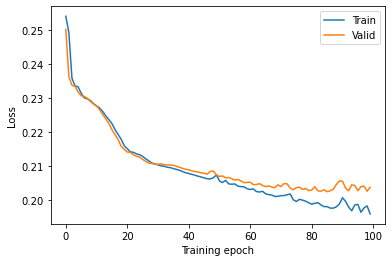

In [97]:
# # Load Q_data_random
# with open('./data/oxides_sinter/Q_data_random.pkl', 'rb') as f:
#     Q_c_data_random = pickle.load(f)

# print('Number of episodes generated by random policy:',len(Q_c_data_random))

# s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets = generate_dqn_dcn_inputs_and_targets_from_Q_c_data(Q_c_data = Q_c_data_random)

# # Standardizing s_material data
# scaler = StandardScaler() # Fit scaler
# print('before scaling:', s_material_inputs)
# scaler.fit(s_material_inputs)
# s_material_inputs_scaled = torch.tensor(scaler.transform(s_material_inputs)).float().to('cuda')
# print('after scaling:', s_material_inputs_scaled)

# # Train-validation split
# s_material_inputs_train, s_step_inputs_train, a_elem_inputs_train, a_comp_inputs_train, Q_targets_train, en_targets_train, s_material_inputs_valid, s_step_inputs_valid, a_elem_inputs_valid, a_comp_inputs_valid, Q_targets_valid, en_targets_valid \
# = train_validation_split(s_material_inputs_scaled = s_material_inputs_scaled.to('cuda'), 
#                                     s_step_inputs = s_step_inputs.to('cuda'), 
#                                     a_elem_inputs = a_elem_inputs.to('cuda'),
#                                     a_comp_inputs = a_comp_inputs.to('cuda'),
#                                     Q_targets  = Q_targets.to('cuda'),
#                                     en_targets = en_targets.to('cuda'),
#                                     valid_size = 0.2)

# print('TRAIN SIZES:')
# print('s_material_inputs_train:', s_material_inputs_train.shape)
# print('s_step_inputs_train:', s_step_inputs_train.shape)
# print('a_elem_inputs_train:', a_elem_inputs_train.shape)
# print('a_comp_inputs_train:', a_comp_inputs_train.shape)
# print('Q_targets_train:', Q_targets_train.shape)
# print('en_targets_train:', en_targets_train.shape)
# print('')
# print('VALIDATION SIZES:')
# print('s_material_inputs_valid:', s_material_inputs_valid.shape)
# print('s_step_inputs_valid:', s_step_inputs_valid.shape)
# print('a_elem_inputs_valid:', a_elem_inputs_valid.shape)
# print('a_comp_inputs_valid:', a_comp_inputs_valid.shape)
# print('Q_targets_valid:', Q_targets_valid.shape)
# print('en_targets_valid:', en_targets_valid.shape)

# # Initialize constraint network
# dcn = DCN_pytorch().cuda()

# # Train DCN on random data
# dcn, train_loss_list, valid_loss_list = train_DCN(dcn =  dcn, num_epoch = 100, s_material_inputs_train = s_material_inputs_train, s_step_inputs_train = s_step_inputs_train,
#  a_elem_inputs_train = a_elem_inputs_train, a_comp_inputs_train = a_comp_inputs_train, Q_targets_train = Q_targets_train, en_targets_train = en_targets_train,
#  s_material_inputs_valid = s_material_inputs_valid, s_step_inputs_valid = s_step_inputs_valid, a_elem_inputs_valid = a_elem_inputs_valid,
#  a_comp_inputs_valid = a_comp_inputs_valid, Q_targets_valid = Q_targets_valid, en_targets_valid = en_targets_valid)

# # Plot train and valid losses
# plt.figure()
# plt.plot(range(0,len(train_loss_list)), train_loss_list, label = 'Train')
# plt.plot(range(0,len(valid_loss_list)), valid_loss_list, label = 'Valid')
# plt.legend()
# # plt.ylim(130,170)
# plt.xlabel('Training epoch')
# plt.ylabel('Loss')
# # plt.savefig('plots/train_valid_loss.png', dpi = 300)
# plt.show()

In [98]:
# torch.save(dcn, './dcn_models/oxides_sinter/dcn_test_random_RF_constrained')

# Visualization of results

### Final reward of compounds generated from constrained model (DQN + DCN)

In [16]:
# # Earlier models
# dqn = torch.load('./dqn_models/dqn_test_500iter_RF_constrained') # Trained in constrained RL
# dqn = torch.load('./dqn_models/dqn_test_490iter_RF') # Trained in unconstrained RL
# dcn = torch.load('./dcn_models/dcn_test_random_RF_constrained') # Trained on random data

# Final constrained models
dqn = torch.load('./dqn_models/oxides_sinter/dqn_test_490iter_RF_constrained') # Trained in constrained RL
dcn = torch.load('./dcn_models/oxides_sinter/dcn_test_random_RF_constrained') # Trained on random data

# dqn.fc1.weight.mean(), dqn.fc2.weight.mean(), dqn.fc3.weight.mean(), dqn.fc4.weight.mean(),
dcn.fc1.weight.mean(), dcn.fc2.weight.mean(), dcn.fc3.weight.mean(), dcn.fc4.weight.mean(),

(tensor(-0.0071, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(-0.0300, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(-0.0047, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(-0.0183, device='cuda:0', grad_fn=<MeanBackward0>))

In [17]:
# 1. Get final rewards from random policy
with open('./data/oxides_sinter/Q_data_random.pkl', 'rb') as f:
    Q_data_random = pickle.load(f)
s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets = generate_dqn_dcn_inputs_and_targets_from_Q_c_data(Q_c_data = Q_data_random)
final_rewards_random = Q_targets[0::5].reshape(-1) # find final rewards
en_random = en_targets[0::5].reshape(-1) # find final en

# 2. Get final rewards from trained policy
Q_c_data_trained, en_targets_trained, final_rewards_trained, final_compounds = \
generate_Q_c_datapoints_and_evaluate_policy(dqn = dqn, dcn = dcn, num_eps = 1000, epsilon = 0, 
                                            en_threshold = 0.4, stochastic_top_frac = 0.20, oxide = True)

# Save compounds generated                                            
with open('./training_data/oxides_sinter/final_compounds_RF_constrained.pkl', 'wb') as f:
        pickle.dump(final_compounds, f, pickle.HIGHEST_PROTOCOL)

print(final_compounds)

Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions


/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


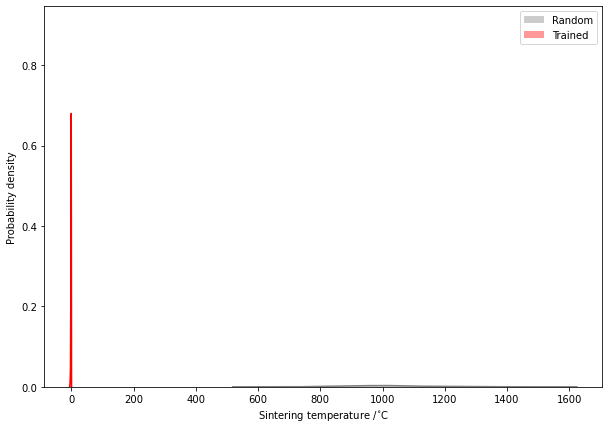

In [18]:
# Plot distribution of final rewards by random vs trained policy
plt.figure(figsize=(10,7))
sns.distplot(-np.array(final_rewards_random), hist = True, norm_hist = True, label = 'Random', color = 'grey')
sns.distplot(-np.array(final_rewards_trained), hist = True, norm_hist = True, label = 'Trained', color = 'red')
plt.ylabel('Probability density')
plt.xlabel('Sintering temperature /$^{\circ}$C')
# plt.ylim(0,0.0025)
# plt.xlim(-2000,0)   
plt.legend()
plt.savefig(fname = 'plots/oxides_sinter/oxides_sinter.png', dpi = 300)
plt.show()

### Validity of compounds generated from constrained model (DQN + DCN)

In [27]:
# Validity of random
count_random = 0
for target in en_random:
    if target.item() == 1.:
        count_random += 1
print('Random policy: Fraction of en OK compounds = ' , count_random/len(en_random))
# Validity of trained
count_trained = 0
for target in en_targets_trained:
    if target.item() == 1.:
        count_trained += 1
print('Trained policy: Fraction of en OK compounds = ' , count_trained/len(en_targets_trained))
validity = {'random': count_random/len(en_random),
            'trained': count_trained/len(en_targets_trained)
            }
with open('training_data/oxides_sinter/validity.json', 'w') as f:
    json.dump(validity, f)

Random policy: Fraction of en OK compounds =  0.4202
Trained policy: Fraction of en OK compounds =  0.646


### Experiment: Validity vs en_threshold

In [47]:
# en_threshold_list  = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# en_good_ratio_vs_en_threshold = []

# def evaluate_en_threshold(en_threshold):
#     # 2. Get final rewards from trained policy
#     Q_c_data_trained, en_targets_trained, final_rewards_trained, final_compounds = \
#     generate_Q_c_datapoints_and_evaluate_policy(dqn = dqn, dcn = dcn, num_eps = 100, epsilon = 0, 
#                                             en_threshold = en_threshold, stochastic_top_frac = 0.20, oxide = True)
#     # Validity of trained
#     count = 0
#     for target in en_targets_trained:
#         if target.item() == 1.:
#             count += 1
#     ratio = count/len(en_targets_trained)
#     return ratio

# for en_threshold in en_threshold_list:
#     en_good_ratio = evaluate_en_threshold(en_threshold = en_threshold)
#     en_good_ratio_vs_en_threshold.append(en_good_ratio)

# with open('./training_data/oxides_sinter/en_threshold_list_RF_constrained.pkl', 'wb') as f:
#         pickle.dump(en_threshold_list, f, pickle.HIGHEST_PROTOCOL)

# with open('./training_data/oxides_sinter/en_good_ratio_vs_en_threshold_RF_constrained.pkl', 'wb') as f:
#         pickle.dump(en_good_ratio_vs_en_threshold, f, pickle.HIGHEST_PROTOCOL)

Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions


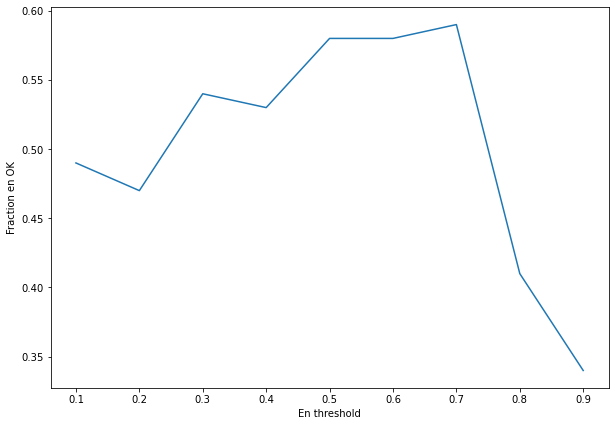

In [48]:
# with open('./training_data/oxides_sinter/en_threshold_list_RF_constrained.pkl', 'rb') as f:
#     en_threshold_list = pickle.load(f)

# with open('./training_data/oxides_sinter/en_good_ratio_vs_en_threshold_RF_constrained.pkl', 'rb') as f:
#     en_good_ratio_vs_en_threshold = pickle.load(f)

# plt.figure(figsize=(10,7))
# plt.plot(en_threshold_list, en_good_ratio_vs_en_threshold)
# plt.ylabel('Fraction en OK')
# plt.xlabel('En threshold')
# # plt.savefig(fname = 'plots/oxides_sinter/en_good_ratio_vs_en_threshold_500iter_RF_constrained.png', dpi = 300)
# plt.show()

### Look at compounds

In [17]:
# rf_regr = RandomForestRegressor()
# rf_regr = joblib.load("rf_models/optimal_sinter_RF.joblib")

# # Featurization for RF model
# feature_calculators = MultipleFeaturizer([
#     cf.element.Stoichiometry(),
#     cf.composite.ElementProperty.from_preset("magpie"),
#     cf.orbital.ValenceOrbital(props=["avg"]),
#     cf.ion.IonProperty(fast=True)
# ])

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [18]:
# # Load compounds generated
# with open('./training_data/oxides_sinter/final_compounds_RF_constrained.pkl', 'rb') as f: # For final compounds generated using constrained RL (DQN + DCN)
#     final_compounds = pickle.load(f)

# # For final compounds generated using constrained RL (DQN + DCN)
# good, bad = check_both_multiple(final_compounds)

In [19]:
# print('Fraction of en OK compounds:', len(good)/(len(good) + len(bad)))

Fraction of en OK compounds: 0.576


Compound: SnBi8Pt9S6O5           Sinter T: 724
Compound: Sn7H8Pt2S9O7           Sinter T: 812
Compound: Rb6Ag5(PtO)8           Sinter T: 780
Compound: Bi8C5Cl5O7             Sinter T: 621
Compound: C8Se5S5Cl5O8           Sinter T: 1099
Compound: In7As2Ir3BrO4          Sinter T: 830
Compound: Cu6Sn2P8Se9O4          Sinter T: 775
Compound: In2Sn5Pt4(BrO2)4       Sinter T: 830
Compound: Rb2Sn7Te5(BrO)2        Sinter T: 802
Compound: In5Se9N7O8             Sinter T: 994
Compound: ZnCd6Bi2(PtO)8         Sinter T: 813
Compound: As8Ir6SO2              Sinter T: 786
Compound: CdAs8Ir3O4             Sinter T: 827
Compound: Bi8Te4P9Ir6O7          Sinter T: 680
Compound: P3Se15(BrO4)2          Sinter T: 847
Compound: Tl7P8Ir3Se7O6          Sinter T: 765
Compound: H9Ir6S3BrO8            Sinter T: 824
Compound: P9Pd2Pt7Se9O8          Sinter T: 738
Compound: Rb3Zn5Ir3(Se3O4)2      Sinter T: 854
Compound: K5SnPt3Se3O8           Sinter T: 837
Compound: C8SeS7Cl5O8            Sinter T: 1197
Compound: I

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


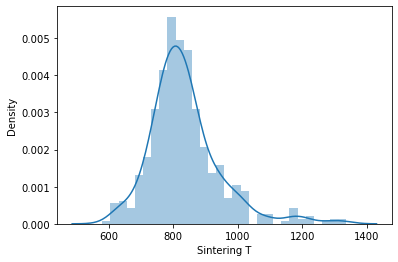

In [20]:
# # Convert good ones to reduced formula
# for idx in range(len(good)):
#     good[idx] = Composition(good[idx]).reduced_formula

# # Predict sintering T of valid compounds
# max_len = 0
# good_sinter_T = []
# for compound in good:
#     chemical = Composition(compound)
#     features = feature_calculators.featurize(chemical) # No need to scale for RF model
#     features = np.array(features).reshape(1, -1)
#     # print(features)
#     sinter_T_pred = rf_regr.predict(features)[0]
#     good_sinter_T.append(sinter_T_pred)
#     compound = Composition(compound).reduced_formula
#     print('Compound:', compound, (18-len(compound)+3)*' ','Sinter T:', round(sinter_T_pred))

# plt.figure()
# sns.distplot(good_sinter_T)
# plt.xlabel('Sintering T')
# plt.show()

### Formation energy of generated compounds

In [35]:
# # RANDOM POLICY
# # Load random oxides
# with open('./training_data/oxides_sinter/random_oxides.pkl', 'rb') as f: 
#     random_oxides = pickle.load(f)
# form_e_random = []
# for compound in random_oxides:
#     form_e_random.append(predict_formation_energy(compound))

# # Save predicted formation energies of random oxides                               
# with open('./training_data/oxides_sinter/form_e_random.pkl', 'wb') as f:
#         pickle.dump(form_e_random, f, pickle.HIGHEST_PROTOCOL)

# Load predicted formation energies of random oxides 
with open('./training_data/oxides_sinter/form_e_random.pkl', 'rb') as f: 
    form_e_random = pickle.load(f)
    
stable_random = len([x for x in form_e_random if x <= 0])/len(form_e_random)
print(stable_random)

0.9903


In [22]:
# # UNCONSTRAINED DQN (sintering T only)
# with open('./training_data/oxides_sinter/compounds_vs_iter_RF_constrained.pkl', 'rb') as f: # For final compounds generated using constrained RL (DQN + DCN)
#     final_compounds = pickle.load(f)
# final_compounds = final_compounds[-1]

# form_e_unconstrained = []
# for compound in final_compounds:
#     form_e_unconstrained.append(predict_formation_energy(compound))

# # Save predicted formation energies of UNconstrained DQN                                  
# with open('./training_data/oxides_sinter/form_e_500iter_RF.pkl', 'wb') as f:
#         pickle.dump(form_e_unconstrained, f, pickle.HIGHEST_PROTOCOL)

# # Load predicted formation energies of UNconstrained DQN
# with open('./training_data/oxides_sinter/form_e_500iter_RF.pkl', 'rb') as f: 
#     form_e_unconstrained = pickle.load(f)

# len([x for x in form_e_unconstrained if x <= 0])/len(form_e_unconstrained)

0.94

In [36]:
# # CONSTRAINED DQN (sintering T + en constraint)
# # Load compounds generated
# with open('./training_data/oxides_sinter/final_compounds_RF_constrained.pkl', 'rb') as f: # For final compounds generated using constrained RL (DQN + DCN)
#     final_compounds = pickle.load(f)

# form_e_constrained = []
# for compound in final_compounds:
#     form_e_constrained.append(predict_formation_energy(compound))

# # Save predicted formation energies of constrained DQN                                  
# with open('./training_data/oxides_sinter/form_e_500iter_RF_constrained.pkl', 'wb') as f:
#         pickle.dump(form_e_constrained, f, pickle.HIGHEST_PROTOCOL)

# Load predicted formation energies of constrained DQN
with open('./training_data/oxides_sinter/form_e_500iter_RF_constrained.pkl', 'rb') as f: 
    form_e_constrained = pickle.load(f)

stable_trained = len([x for x in form_e_constrained if x <= 0])/len(form_e_constrained)
print(stable_trained)

0.991


In [37]:
form_e_below_zero = {'random': stable_random,
                    'trained': stable_trained
            }
with open('training_data/oxides_sinter/form_e_below_zero.json', 'w') as f:
    json.dump(form_e_below_zero, f)

/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/synthesisproject/anaconda3/envs/dqn_roost/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


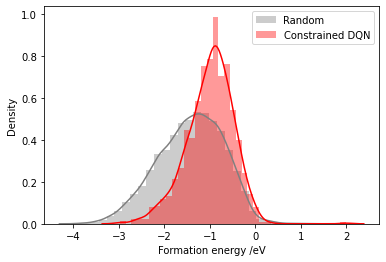

In [38]:
plt.figure()
sns.distplot(form_e_random, bins = 30, hist = True, norm_hist = True, label = 'Random', color = 'grey')
# sns.distplot(form_e_unconstrained, hist = True, norm_hist = True, label = 'DQN', color = 'blue')
sns.distplot(form_e_constrained, hist = True, norm_hist = True, label = 'Constrained DQN', color = 'red')
plt.xlabel('Formation energy /eV')
plt.legend()
# plt.savefig('plots/oxides_sinter/form_e_comparison.png', dpi = 300)
plt.show()

# Visualizing training data of unconstrained DQN

### Evolution of final rewards with iteration (unconstrained DQN only)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


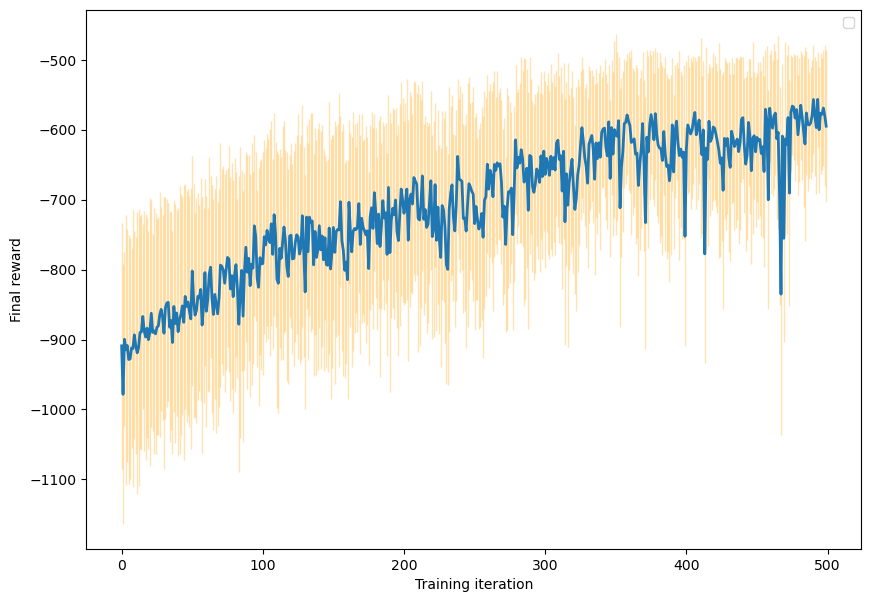

In [21]:
# with open('./training_data/final_rewards_vs_iter_RF_constrained.pkl', 'rb') as f:
#     final_rewards_vs_iter = pickle.load(f)
# num_iter = 500
# final_rewards_mean = [x.mean() for x in final_rewards_vs_iter]
# final_rewards_std  = [x.std() for x in final_rewards_vs_iter]
# plt.figure(figsize=(10,7))
# markers, caps, bars = plt.errorbar(range(num_iter), final_rewards_mean, yerr = final_rewards_std, mfc= 'blue', linewidth = 2, elinewidth= 1)
# [bar.set_alpha(0.3) for bar in bars]
# [bar.set_color('orange') for bar in bars]
# plt.ylabel('Final reward')
# plt.xlabel('Training iteration')
# plt.legend()
# # plt.savefig(fname = 'plots/reward_vs_iter_500iter_RF_constrained.png', dpi = 300)
# plt.show()

### Evolution of compounds with iteration (unconstrained DQN only)

In [2]:
# with open('./training_data/compounds_vs_iter_RF.pkl', 'rb') as f:
#     compounds_vs_iter = pickle.load(f)

# # FEATURIZE GENERATED COMPOUNDS
# for iteration in tqdm(range(len(compounds_vs_iter))): # For each iteration of compounds
#     for idx in range(len(compounds_vs_iter[iteration])): # For each compound
#         compounds_vs_iter[iteration][idx] = featurize_target(compounds_vs_iter[iteration][idx]) # Featurize using Magpie embeddings

# # Save featurized compounds
# with open('./training_data/compound_features_vs_iter_RF.pkl', 'wb') as f:
#         pickle.dump(compounds_vs_iter, f, pickle.HIGHEST_PROTOCOL)

In [28]:
# # Load compound features
# with open('./training_data/compound_features_vs_iter_RF.pkl', 'rb') as f:
#     compound_features_vs_iter = pickle.load(f)

In [29]:
# len(compound_features_vs_iter)

500

Standarizing data before PCA is important.

In [30]:
# # Load scalar
# scaler = StandardScaler() # Fit scaler
# scaler.fit(s_material_inputs)

# # Convert each compound features from list to np.array
# for iteration in tqdm(range(len(compound_features_vs_iter))): # For each iteration of compounds
#     for idx in range(len(compound_features_vs_iter[iteration])): # For each compound
#         compound_features_vs_iter[iteration][idx] = scaler.transform(np.array([compound_features_vs_iter[iteration][idx]]))[0] # Featurize using Magpie embeddings

100%|██████████| 500/500 [00:02<00:00, 243.93it/s]


In [32]:
# features = [] # 500 x np.array() of shape 100 x 145 (100 is no of compounds per iteration, 145 is the feature size)
# for iteration in tqdm(range(len(compound_features_vs_iter))): # For each iteration of compounds
#     iteration_stack = []
#     for idx in range(len(compound_features_vs_iter[iteration])): # For each compound
#         iteration_stack.append(compound_features_vs_iter[iteration][idx])
#     iteration_stack = np.stack(iteration_stack)
#     features.append(iteration_stack)

100%|██████████| 500/500 [00:00<00:00, 6695.70it/s]


In [33]:
# # Stack features into one big matrix
# full_stack = [] 
# for iteration in features:
#     full_stack.append(iteration)
# full_stack = np.vstack(full_stack)

### Dimensionality reduction using t-SNE

In [69]:
# # Perform t-SNE
# tsne_embeddings = TSNE(n_components = 2, 
#                        perplexity = 30,
#                        learning_rate='auto',
#                        init='random' # random/pca initialization
#                        ).fit_transform(full_stack)

# # with open('training_data/tsne_embeddings_500iter_RF.npy', 'wb') as f:
# #     np.save(f, tsne_embeddings)

In [97]:
# # Load t-SNE embeddings
# with open('training_data/tsne_embeddings_500iter_RF.npy', 'rb') as f:
#     tsne_embeddings = np.load(f)

# with open('./training_data/final_rewards_vs_iter_RF.pkl', 'rb') as f:
#     final_rewards_vs_iter = pickle.load(f)

# final_rewards_vs_iter_stacked = torch.stack(final_rewards_vs_iter)
# final_rewards = final_rewards_vs_iter_stacked.reshape(-1)
# print('tsne_embeddings: ', tsne_embeddings.shape)
# print('final_rewards:', final_rewards.shape)

tsne_embeddings:  (50000, 2)
final_rewards: torch.Size([50000])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


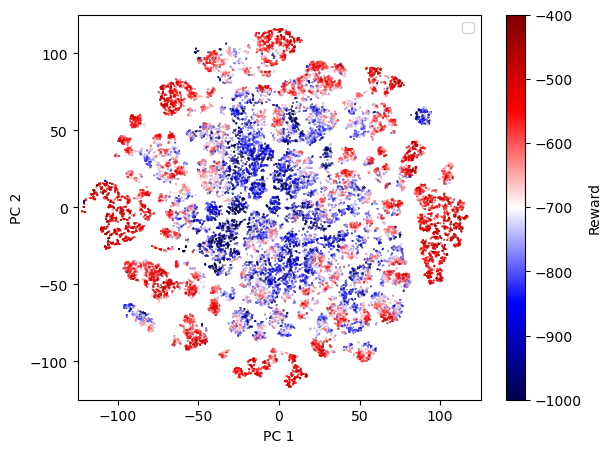

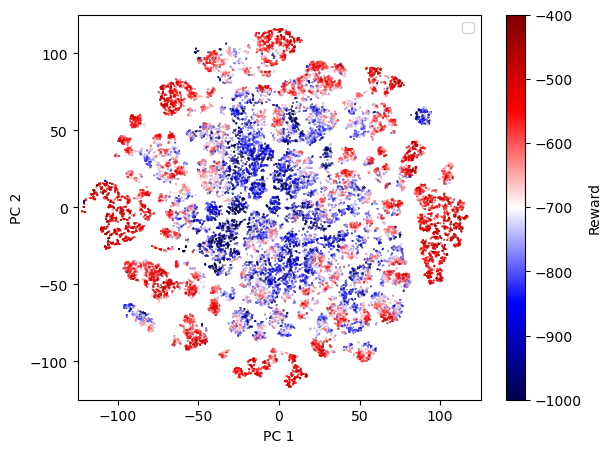

In [98]:
# # Generate list of iterations for 50k compounds
# iteration = []
# for i in range(500):
#     for j in range(100):
#         iteration.append(i)
# # Plot TSNE
# def plot_TSNE(train_iter = None):
#     fig = plt.figure(figsize=(6.5,5))
#     if train_iter == None:
#         plt.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], s = 0.05, alpha = 1, c = final_rewards, cmap = 'seismic') # For rewards
#         # plt.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], s = 0.05, alpha = 1, c = iteration, cmap = 'seismic') # For iteration
#     else:
#         row_idx = range(100*train_iter,(100*train_iter)+100)
#         rewards = final_rewards_vs_iter[train_iter]
#         plt.scatter(tsne_embeddings[row_idx,0], tsne_embeddings[row_idx,1], c = rewards, s = 5, cmap = 'seismic')
#     plt.ylabel('PC 2')
#     plt.xlabel('PC 1')
#     plt.ylim(-125, 125)
#     plt.xlim(-125, 125)
#     plt.legend()
#     # plt.text(20,100,'Iteration %.0f' % train_iter, fontsize = 15)
#     cbar = plt.colorbar()
#     cbar.set_label('Reward')
#     # cbar.set_label('Iteration')
#     plt.clim(-1000,-400) 
#     # plt.savefig(fname = 'plots/TSNE_vs_iter_500iter_RF.png', dpi = 300) 
#     plt.show()
#     return fig
# plot_TSNE()

In [ ]:
images = []  # For saving into gif

for i in range(0, 600, 1): # For stalling the last frame
    j = i
    if i > 499: # For stalling the last frame
        j = 499
    fig = plot_TSNE(train_iter = j)
    # Used to return the plot as an image array 
    # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image)
imageio.mimsave('plots/TSNE_reward_vs_iter_500iter_RF.gif', images, fps = 30)

### Dimensionality reduction using singular value decomposition (SVD)

In [66]:
# # Perform SVD
# u, s, vh = np.linalg.svd(full_stack, full_matrices=True)

# # with open('training_data/SVD_embeddings_500iter_RF.npy', 'wb') as f:
# #     np.save(f, u)

In [67]:
# # Load SVD embeddings
# with open('training_data/SVD_embeddings_500iter_RF.npy', 'rb') as f:
#     u = np.load(f)

# with open('training_data/final_rewards_vs_iter_RF.pkl', 'rb') as f:
#     final_rewards_vs_iter = pickle.load(f)

# final_rewards_vs_iter_stacked = torch.stack(final_rewards_vs_iter)
# final_rewards = final_rewards_vs_iter_stacked.reshape(-1)
# print('SVD_embeddings: ', u.shape)
# print('final_rewards:', final_rewards.shape)

# u_truncated = u[:, :2]
# print('SVD_embeddings after truncation:', u_truncated.shape)

SVD_embeddings:  (50000, 50000)
final_rewards: torch.Size([50000])
SVD_embeddings after truncation: (50000, 2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


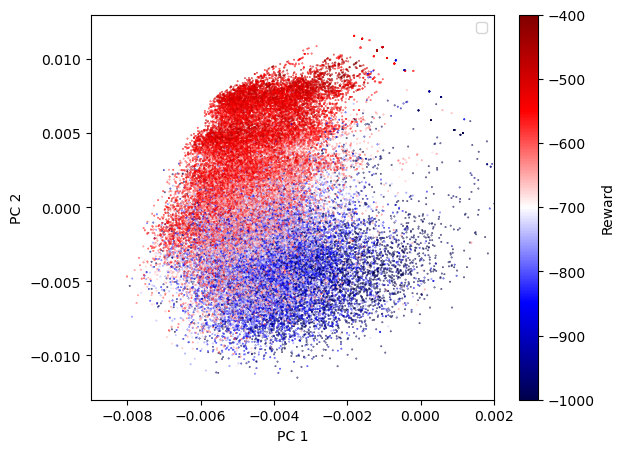

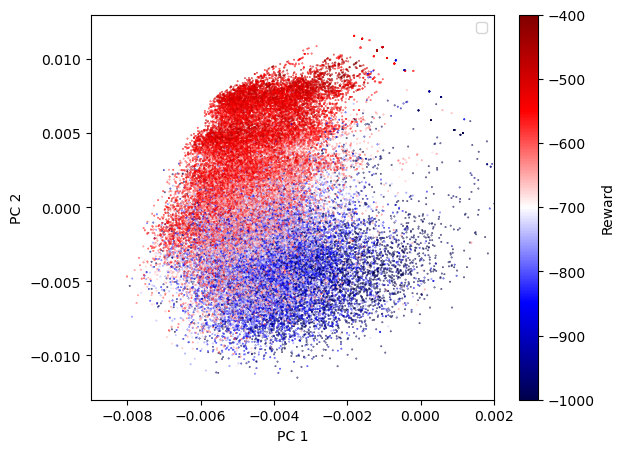

In [99]:
# iteration = []
# for i in range(500):
#     for j in range(100):
#         iteration.append(i)

# # Plot SVD
# def plot_SVD(train_iter = None):
#     fig = plt.figure(figsize=(6.5,5))
#     if train_iter == None:
#         plt.scatter(u_truncated[:,0], u_truncated[:,1], c = final_rewards, s = 0.1, cmap = 'seismic') # For rewards
#         # plt.scatter(u_truncated[:,0], u_truncated[:,1], c = iteration, s = 0.1, cmap = 'seismic') # For iterations
#     else:
#         row_idx = range(100*train_iter,(100*train_iter)+100)
#         rewards = final_rewards_vs_iter[train_iter]
#         plt.scatter(u_truncated[row_idx,0], u_truncated[row_idx,1], c = rewards, s = 5, cmap = 'seismic')
#     plt.ylabel('PC 2')
#     plt.xlabel('PC 1')
#     plt.ylim(-0.013, 0.013)
#     plt.xlim(-0.009, .002)
#     plt.legend()
#     # plt.text(-0.002,0.010,'Iteration %.0f' % train_iter, fontsize = 15)
#     cbar = plt.colorbar()
#     plt.clim(-1000,-400)  
#     # cbar.set_label('Iteration')
#     cbar.set_label('Reward')
#     # plt.savefig(fname = 'plots/SVD_reward_vs_iter_500iter_RF.png', dpi = 300)
#     plt.show()
#     return fig
# plot_SVD()

In [ ]:
# images = []  # For saving into gif

# for i in range(0, 600, 1): # For stalling the last frame
#     j = i
#     if i > 499: # For stalling the last frame
#         j = 499
#     fig = plot_SVD(train_iter = j)
#     # Used to return the plot as an image array 
#     # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
#     fig.canvas.draw()       # draw the canvas, cache the renderer
#     image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
#     image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
#     images.append(image)
# imageio.mimsave('plots/SVD_reward_vs_iter_500iter_RF.gif', images, fps = 30)